In [1]:
import time
import os
import json
import string 
import re
from datetime import datetime

import random
import scipy
import numpy as np
from scipy.special import softmax

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, f1_score, classification_report, cohen_kappa_score, matthews_corrcoef, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data

import transformers
from transformers import AutoTokenizer, AutoModel
import evaluate

from tqdm.notebook import tqdm

tqdm.pandas()
sns.set_theme()

In [2]:
device = "cuda:0"

# Part 0: Data Loading and Analysis
I begin by loading the necessary data and performing some basic analysis on the data to familarise myself with it.

In [3]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yoyo1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yoyo1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yoyo1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
train_stances = pd.read_csv("./dataset/train_stances.csv")
train_bodies = pd.read_csv("./dataset/train_bodies.csv")

test_stances = pd.read_csv("./dataset/competition_test_stances.csv")
test_bodies = pd.read_csv("./dataset/competition_test_bodies.csv")

In [5]:
train_stances

Headline  Body ID     Stance
0      Police find mass graves with at least '15 bodi...      712  unrelated
1      Hundreds of Palestinians flee floods in Gaza a...      158      agree
2      Christian Bale passes on role of Steve Jobs, a...      137  unrelated
3      HBO and Apple in Talks for $15/Month Apple TV ...     1034  unrelated
4      Spider burrowed through tourist's stomach and ...     1923   disagree
...                                                  ...      ...        ...
49967  Urgent: The Leader of ISIL 'Abu Bakr al-Baghda...     1681  unrelated
49968  Brian Williams slams social media for speculat...     2419  unrelated
49969  Mexico Says Missing Students Not Found In Firs...     1156      agree
49970  US Lawmaker: Ten ISIS Fighters Have Been Appre...     1012    discuss
49971  Shots Heard In Alleged Brown Shooting Recordin...     2044  unrelated

[49972 rows x 3 columns]

In [6]:
train_stances.nunique()

Headline    1648
Body ID     1683
Stance         4
dtype: int64

In [7]:
train_bodies

Body ID                                        articleBody
0           0  A small meteorite crashed into a wooded area i...
1           4  Last week we hinted at what was to come as Ebo...
2           5  (NEWSER) – Wonder how long a Quarter Pounder w...
3           6  Posting photos of a gun-toting child online, I...
4           7  At least 25 suspected Boko Haram insurgents we...
...       ...                                                ...
1678     2528  Intelligence agencies hunting for identity of ...
1679     2529  While Daleks "know no fear" and "must not fear...
1680     2530  More than 200 schoolgirls were kidnapped in Ap...
1681     2531  A Guantanamo Bay prisoner released last year a...
1682     2532  ANN ARBOR, Mich. – A pizza delivery man in Mic...

[1683 rows x 2 columns]

In [8]:
train_bodies.nunique()

Body ID        1683
articleBody    1669
dtype: int64

<AxesSubplot: xlabel='Stance', ylabel='Frequency (%)'>

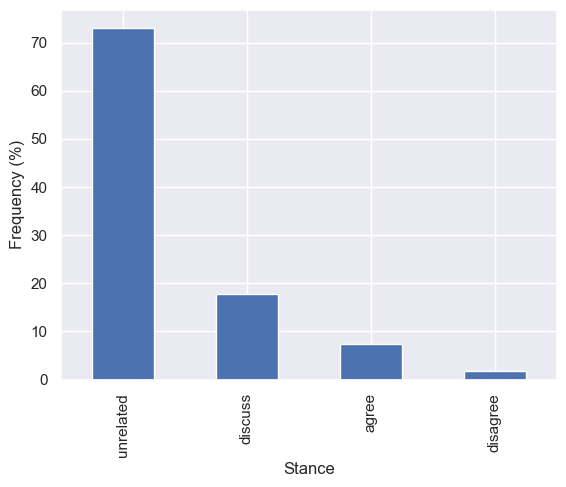

In [9]:
train_stances["Stance"].value_counts(normalize=True).multiply(100).plot(kind="bar", xlabel="Stance", ylabel="Frequency (%)")

<AxesSubplot: xlabel='Stance', ylabel='Frequency (%)'>

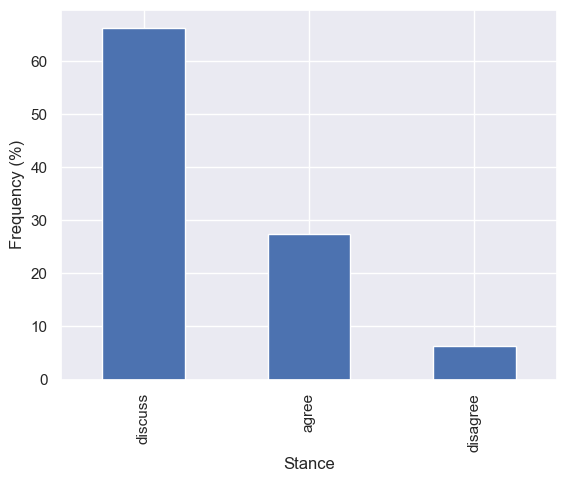

In [10]:
train_stances["Stance"].mask(lambda row: row.eq("unrelated")).value_counts(normalize=True).multiply(100).plot(kind="bar", xlabel="Stance", ylabel="Frequency (%)")

It's clear that there is a large overlap in the Headline and Body ID counts. For the first task we have an approximate 3:1 split for unrelated/related which is quite imbalanced but this gets substantially worse for the second task as once the unrelated is excluded we have an approximate 11:5:1 split for discuss/agree/disagree which is heavily imbalanced. 

It's also imperative to look at the lengths of sequences, especially for the transformer tasks. While this isn't a true count of their lengths (since the transformers will token them with WordPiece etc.) this will be useful to get a general feel for it.

In [11]:
train_stances["Headline"].apply(len).describe()

count    49972.000000
mean        69.356860
std         24.825253
min          9.000000
25%         54.000000
50%         65.000000
75%         79.000000
max        225.000000
Name: Headline, dtype: float64

In [12]:
train_bodies["articleBody"].apply(len).describe()

count     1683.000000
mean      2223.292929
std       1809.834941
min         38.000000
25%       1179.500000
50%       1822.000000
75%       2743.500000
max      27840.000000
Name: articleBody, dtype: float64

It is immediately clear that care will need to be taken to ensure we get a good balance of headline and body for classification

<AxesSubplot: >

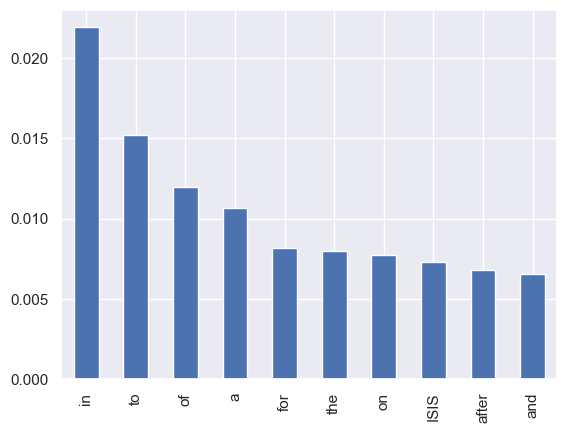

In [13]:
# Reference: https://stackoverflow.com/a/46786277
train_stances[train_stances["Stance"] == "agree"]["Headline"].str.split().explode().value_counts(normalize=True)[:10].plot(kind="bar")

<AxesSubplot: >

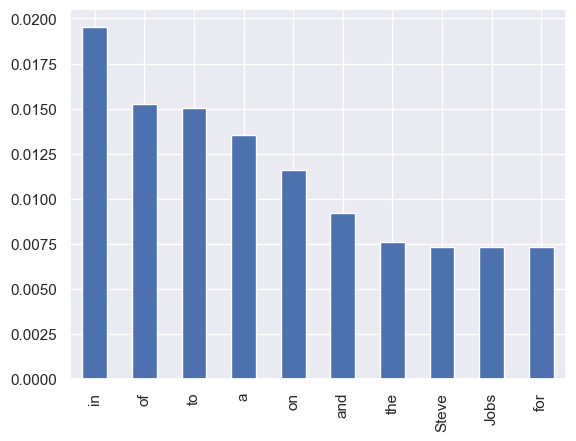

In [14]:
train_stances[train_stances["Stance"] == "disagree"]["Headline"].str.split().explode().value_counts(normalize=True)[:10].plot(kind="bar")

In [15]:
## TODO: EXTEND

In [16]:
train_stances.loc[train_stances["Headline"].isin(test_stances["Headline"])]

Headline  Body ID     Stance
173         Cheese addiction breaks Kim Jong-un's ankles     2210  unrelated
1415   WSJ: Apple cut watch health features due to er...     1917    discuss
1418   Cheese blamed for North Korean leader Kim Jong...     1689  unrelated
1479   Cheese blamed for North Korean leader Kim Jong...      186  unrelated
1503        Cheese addiction breaks Kim Jong-un's ankles     2329  unrelated
...                                                  ...      ...        ...
48270  Apple was forced to nix key health features fr...      407    discuss
48852  Cheese blamed for North Korean leader Kim Jong...     2042  unrelated
49279       Cheese addiction breaks Kim Jong-un's ankles     1854    discuss
49349  Cheese blamed for North Korean leader Kim Jong...     2344  unrelated
49683  Cheese blamed for North Korean leader Kim Jong...     2327  unrelated

[156 rows x 3 columns]

In [17]:
train_bodies.loc[train_bodies["articleBody"].isin(test_bodies["articleBody"])]

Body ID                                        articleBody
259       407  The health-focused smartwatch that Apple initi...
337       521  Apple apparently wanted its smartwatches to fo...
730      1095  North Korea leader Kim Jong-un is so fat from ...
800      1201  Citigroup Jim Suva on Apple Watch:\r\n\r\nWe e...
945      1415  Jim Suva with Citigroup this evening weighs in...
1028     1542  Apple Watch will take approximately two hours ...
1159     1750  In designing its first wearable device in the ...
1182     1788  Before Apple unveiled the Apple Watch last Sep...
1231     1854  No craving can be more important than your hea...
1275     1917  Apple originally planned for the Apple Watch t...

Interestingly there is actually overlap between the headlines and bodies between the train set and the test set. This makes splitting the data into disjoint sets difficult, following existing repos (TODO: CITE) I will split so that there is no overlap between 

## Data Splitting

In [18]:
train_and_val_df = train_stances.merge(train_bodies, on="Body ID")
train_and_val_df["Related"] = (train_and_val_df["Stance"] != "unrelated").astype(int)

In [19]:
test_df = test_stances.merge(test_bodies, on="Body ID")
test_df["Related"] = (test_df["Stance"] != "unrelated").astype(int)

In [20]:
# Split the train and validation sets by ensuring there is no overlap between the bodies
def split_train_val(df, ratio):
    val_count = int(ratio * df["Body ID"].nunique())
    all_ids = list(df["Body ID"].unique())
    val_body_ids = random.sample(all_ids, val_count)
    train_body_ids = set(all_ids) - set(val_body_ids)
    
    assert len(set(val_body_ids) & train_body_ids) == 0
    
    val_df = df.loc[df["Body ID"].isin(val_body_ids)]
    train_df = df.loc[df["Body ID"].isin(train_body_ids)]
    
    return val_df, train_df

In [21]:
val_split_ratio = 0.2
val_df, train_df = split_train_val(train_and_val_df, val_split_ratio)

In [22]:
val_df

Headline  Body ID     Stance  \
289    'Nasa Confirms Earth Will Experience 6 Days of...      154      agree   
290    ’6 Days Darkness in December 2014′ 100% Fake; ...      154      agree   
1623   Thanks Uncle Sam, we have your weapons airdrop...     2176  unrelated   
1624   Isis Syria News: Video Shows US Airdropped Wea...     2176  unrelated   
1625   US probing claims ISIS fighters seized airdrop...     2176  unrelated   
...                                                  ...      ...        ...   
49926  Apple Watch to reportedly offer 'Power Reserve...      232    discuss   
49944  You may be able to make appointments at the Ap...      307    discuss   
49945  Meteorite makes big crater in Nicaragua, gover...        9      agree   
49946  Small Meteorite Strikes in Nicaragua's Capital...        9      agree   
49965  NASA: Planetary Alignment On Jan 4, 2015 Will ...      175    discuss   

                                             articleBody  Related  
289    Thousands of people have been duped by a fake ...        1  
290    Thousands of people have been duped by a fake ...        1  
1623   Longtime "NBC Nightly News" anchor Tom Brokaw ...        0  
1624   Longtime "NBC Nightly News" anchor Tom Brokaw ...        0  
1625   Longtime "NBC Nightly News" anchor Tom Brokaw ...        0  
...                                                  ...      ...  
49926  Apple will offer a low power mode on Apple Wat...        1  
49944  Apple is reportedly planning to market and sel...        1  
49945  (CNN) -- A meteorite crashed down in Managua, ...        1  
49946  (CNN) -- A meteorite crashed down in Managua, ...        1  
49965  via Daily Buzz Live\r\n\r\nStrange natural occ...        1  

[10330 rows x 5 columns]

In [23]:
train_df

Headline  Body ID     Stance  \
0      Police find mass graves with at least '15 bodi...      712  unrelated   
1               Seth Rogen to Play Apple’s Steve Wozniak      712    discuss   
2      Mexico police find mass grave near site 43 stu...      712  unrelated   
3      Mexico Says Missing Students Not Found In Firs...      712  unrelated   
4      New iOS 8 bug can delete all of your iCloud do...      712  unrelated   
...                                                  ...      ...        ...   
49967  Amazon Is Opening a Brick-and-Mortar Store in ...      464      agree   
49968  Elon University has not banned the term ‘fresh...      362      agree   
49969  Fake BBC News website set up to carry Charlie ...      915      agree   
49970  Apple was forced to nix key health features fr...      407    discuss   
49971  If you want an Apple Watch, you’ll probably be...     1066    discuss   

                                             articleBody  Related  
0      Danny Boyle is directing the untitled film\r\n...        0  
1      Danny Boyle is directing the untitled film\r\n...        1  
2      Danny Boyle is directing the untitled film\r\n...        0  
3      Danny Boyle is directing the untitled film\r\n...        0  
4      Danny Boyle is directing the untitled film\r\n...        0  
...                                                  ...      ...  
49967  Amazon, the cyber store that sells everything,...        1  
49968  ELON, N.C. – A recent rumor claims that Elon U...        1  
49969  A realistic-looking fake BBC News website has ...        1  
49970  The health-focused smartwatch that Apple initi...        1  
49971  We still don’t know the exact date the Apple W...        1  

[39642 rows x 5 columns]

In [24]:
train_df["Body ID"].nunique()

1347

In [25]:
val_df["Body ID"].nunique()

336

In [26]:
test_df["Body ID"].nunique()

904

In [27]:
def prepare_df(df):
    df = df.drop("Body ID", axis=1)
    df = df.reset_index()
    df = df.drop("index", axis=1)
    # df["Related"] = df["Stance"] != "unrelated"
    return df

In [28]:
clean_train_df = prepare_df(train_df)
clean_val_df = prepare_df(val_df)
clean_test_df = prepare_df(test_df)

<AxesSubplot: >

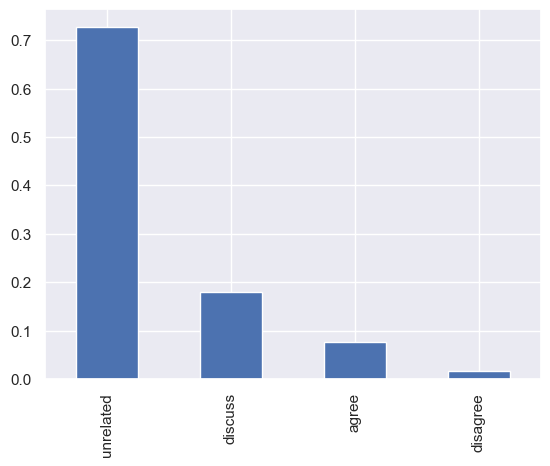

In [29]:
clean_train_df["Stance"].value_counts(normalize=True).plot(kind="bar")

<AxesSubplot: >

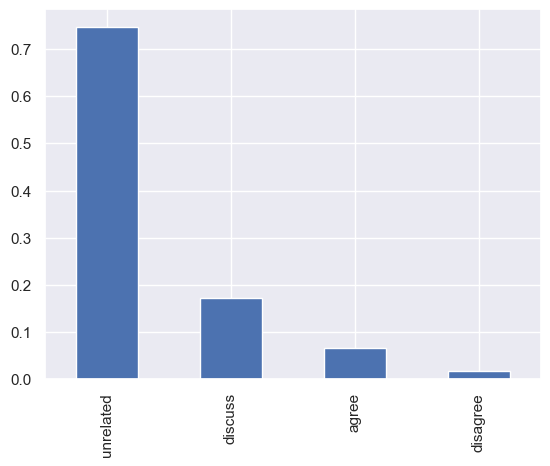

In [30]:
clean_val_df["Stance"].value_counts(normalize=True).plot(kind="bar")

<AxesSubplot: >

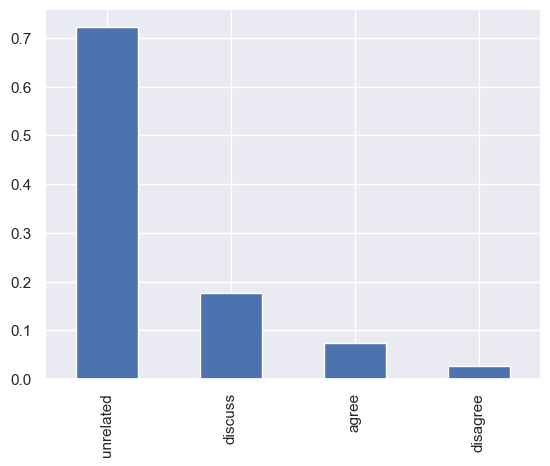

In [31]:
clean_test_df["Stance"].value_counts(normalize=True).plot(kind="bar")

The class distribution between the train and validation (and test although we wouldn't be able to control this anyway) are pretty similar which is good so we don't need to resample to ensure we have similar distributions.

# Part 1: Feature Extraction

## Part 1.a: TF-IDF Features

### Data Cleaning and Tokenisation
Now we have the data, need to clean the data and extract the TF-IDF features. Basic things to consider doing:
* Remove punctuation
* Remove URLs
* Remove HTML
* Remove numbers
* Remove emojis
* Convert to lowercase

And we should also:
* Tokenise
* Remove stopwords
* Lemmatisation or Stemming

In [32]:
# Keep clean copies as we will process differently for Transformers
train_df = clean_train_df.copy(deep=True)
val_df = clean_val_df.copy(deep=True)
test_df = clean_test_df.copy(deep=True)

In [32]:
# TODO: CITE Most of this from the first practical
additional_specials = ["—", "”", "“", "’", "‘"]

def remove_excess_whitespace(text):
    text = text.replace("\n", " ")
    text = text.replace("\t", " ")
    text = text.replace("\r", " ")
    text = text.strip()
    return text

def remove_punctuation(text):
    punc = str.maketrans('', '', string.punctuation)
    text = text.translate(punc)
    
    for special in additional_specials:
        text = text.replace(special, "")
    
    return text

def remove_urls(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub('', text)

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub('', text)

def remove_numbers(text):
    numbers = re.compile(r'\d+')
    return numbers.sub('', text)

def remove_emojis(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', text)

def apply_cleaning(text, excess=True, punc=True, urls=True, html=True, numbers=True, emojis=True, lower=True):
    if excess:
        text = " ".join(text.split())
        
    if punc:
        text = remove_punctuation(text)
    
    if urls:
        text = remove_urls(text)
    
    if html:
        text = remove_html(text)
    
    if numbers:
        text = remove_numbers(text)
        
    if emojis:
        text = remove_emojis(text)
        
    if lower:
        text = text.lower()
    
    return text

In [33]:
eng_stopwords = set(stopwords.words("english"))
lemmatiser = WordNetLemmatizer()
stemmer = PorterStemmer()

def lemmatise(text):
    tokens = word_tokenize(text)
    return " ".join([lemmatiser.lemmatize(x) for x in tokens])

def stematise(text):
    tokens = word_tokenize(text)
    return " ".join([stemmer.stem(x) for x in tokens])

def apply_tokeniser(text, stops=True, sl="lemmatise"):
    word_processor = None
    
    if sl == "lemmatise":
        word_processor = lemmatiser.lemmatize
    elif sl == "stematise":
        word_processor = stemmer.stem
    elif sl == "identity":
        word_processor = lambda x: x
    else:
        assert False, "Invalid"
    
    tokens = word_tokenize(text)
    filtered_tokens = []
    
    if stops:
        for token in tokens:
            if token not in eng_stopwords:
                filtered_tokens.append(token)
    else:
        filtered_tokens = tokens
        
    return " ".join([word_processor(token) for token in filtered_tokens])

In [35]:
config_remove_excess_whitespace = True
config_remove_punctuation = True
config_remove_urls = True
config_remove_html = True
config_remove_numbers = True
config_remove_emojis = True
config_convert_to_lowercase = True
config_stem_or_lemm = ["lemmatise", "stematise", "identity"][0]
config_remove_stopwords = True

In [36]:
def process_text(text):
    text = apply_cleaning(
        text, 
        excess=config_remove_excess_whitespace, 
        punc=config_remove_punctuation, 
        urls=config_remove_urls, 
        html=config_remove_html, 
        numbers=config_remove_numbers, 
        emojis=config_remove_emojis, 
        lower=config_convert_to_lowercase
    )
    
    text = apply_tokeniser(text, stops=config_remove_stopwords, sl=config_stem_or_lemm)
    return text

In [37]:
test_text = clean_train_df.iloc[812]["articleBody"]
print("Unprocessed:")
print(test_text)
print()
test_processed = process_text(test_text)
print("Processed:")
print(test_processed)

Unprocessed:
Led Zeppelin fans will be disappointed to learn that there’s no reunion tour and a story that appeared in the Daily Mirror suggesting that Robert Plant ripped up an $800 contract for such a gig is false, according to the Guardian.

The reported tour was supposedly financed by Virgin founder Richard Branson, who wanted to turn one of his Virgin planes into a new iteration of “The Starship,” the jet​ the band used to tour in the 1970s. The group was to play 35 dates in three locales-- London, Berlin and New Jersey.

Guitarist Jimmy Page and bassist John Paul Jones had signed on. And the late drummer John Bonham’s son Jason was to play drums for the band. “It was a no-brainer for them but Robert asked for 48 hours to think about it,” a source told the Daily Mirror. “When he said no and ripped up the paperwork he had been given, there was an enormous sense of shock. There is no way they can go ahead without him.”

Turns out, the entire tale is “rubbish,” said Plant’s publicist

In [38]:
train_df

Headline     Stance  \
0      Police find mass graves with at least '15 bodi...  unrelated   
1               Seth Rogen to Play Apple’s Steve Wozniak    discuss   
2      Mexico police find mass grave near site 43 stu...  unrelated   
3      Mexico Says Missing Students Not Found In Firs...  unrelated   
4      New iOS 8 bug can delete all of your iCloud do...  unrelated   
...                                                  ...        ...   
40528  NASA: Planetary Alignment On Jan 4, 2015 Will ...    discuss   
40529  “Willie Nelson dead 2015” : Guitarist killed b...      agree   
40530  Elon University has not banned the term ‘fresh...      agree   
40531  Fake BBC News website set up to carry Charlie ...      agree   
40532  If you want an Apple Watch, you’ll probably be...    discuss   

                                             articleBody  Related  
0      Danny Boyle is directing the untitled film\r\n...    False  
1      Danny Boyle is directing the untitled film\r\n...     True  
2      Danny Boyle is directing the untitled film\r\n...    False  
3      Danny Boyle is directing the untitled film\r\n...    False  
4      Danny Boyle is directing the untitled film\r\n...    False  
...                                                  ...      ...  
40528  via Daily Buzz Live\r\n\r\nStrange natural occ...     True  
40529  News of guitarist Willie Nelson’s death spread...     True  
40530  ELON, N.C. – A recent rumor claims that Elon U...     True  
40531  A realistic-looking fake BBC News website has ...     True  
40532  We still don’t know the exact date the Apple W...     True  

[40533 rows x 4 columns]

In [39]:
train_df["Processed Headline"] = train_df["Headline"].progress_apply(process_text)
train_df["Processed Body"] = train_df["articleBody"].progress_apply(process_text)

  0%|          | 0/40533 [00:00<?, ?it/s]

  0%|          | 0/40533 [00:00<?, ?it/s]

In [40]:
train_df

Headline     Stance  \
0      Police find mass graves with at least '15 bodi...  unrelated   
1               Seth Rogen to Play Apple’s Steve Wozniak    discuss   
2      Mexico police find mass grave near site 43 stu...  unrelated   
3      Mexico Says Missing Students Not Found In Firs...  unrelated   
4      New iOS 8 bug can delete all of your iCloud do...  unrelated   
...                                                  ...        ...   
40528  NASA: Planetary Alignment On Jan 4, 2015 Will ...    discuss   
40529  “Willie Nelson dead 2015” : Guitarist killed b...      agree   
40530  Elon University has not banned the term ‘fresh...      agree   
40531  Fake BBC News website set up to carry Charlie ...      agree   
40532  If you want an Apple Watch, you’ll probably be...    discuss   

                                             articleBody  Related  \
0      Danny Boyle is directing the untitled film\r\n...    False   
1      Danny Boyle is directing the untitled film\r\n...     True   
2      Danny Boyle is directing the untitled film\r\n...    False   
3      Danny Boyle is directing the untitled film\r\n...    False   
4      Danny Boyle is directing the untitled film\r\n...    False   
...                                                  ...      ...   
40528  via Daily Buzz Live\r\n\r\nStrange natural occ...     True   
40529  News of guitarist Willie Nelson’s death spread...     True   
40530  ELON, N.C. – A recent rumor claims that Elon U...     True   
40531  A realistic-looking fake BBC News website has ...     True   
40532  We still don’t know the exact date the Apple W...     True   

                                      Processed Headline  \
0      police find mass graf least body near mexico t...   
1                    seth rogen play apple steve wozniak   
2      mexico police find mass grave near site studen...   
3       mexico say missing student found first mass graf   
4                      new io bug delete icloud document   
...                                                  ...   
40528  nasa planetary alignment jan decrease gravity ...   
40529  willie nelson dead guitarist killed internet d...   
40530  elon university banned term freshman despite r...   
40531  fake bbc news website set carry charlie hebdo ...   
40532  want apple watch youll probably trekking apple...   

                                          Processed Body  
0      danny boyle directing untitled film seth rogen...  
1      danny boyle directing untitled film seth rogen...  
2      danny boyle directing untitled film seth rogen...  
3      danny boyle directing untitled film seth rogen...  
4      danny boyle directing untitled film seth rogen...  
...                                                  ...  
40528  via daily buzz live strange natural occurrence...  
40529  news guitarist willie nelson death spread quic...  
40530  elon nc – recent rumor claim elon university b...  
40531  realisticlooking fake bbc news website set car...  
40532  still dont know exact date apple watch ship ne...  

[40533 rows x 6 columns]

In [41]:
val_df["Processed Headline"] = val_df["Headline"].progress_apply(process_text)
val_df["Processed Body"] = val_df["articleBody"].progress_apply(process_text)

  0%|          | 0/9439 [00:00<?, ?it/s]

  0%|          | 0/9439 [00:00<?, ?it/s]

In [42]:
val_df

Headline    Stance  \
0     'Nasa Confirms Earth Will Experience 6 Days of...     agree   
1     ’6 Days Darkness in December 2014′ 100% Fake; ...     agree   
2     Woman detained in Lebanon is not al-Baghdadi's...     agree   
3     Lebanon 'holding IS leader's daughter and ex-w...   discuss   
4           Lebanon detains wife and son of Al-Baghdadi  disagree   
...                                                 ...       ...   
9434  Axl Rose NOT Dead: Fake MSNBC Death Hoax Goes ...     agree   
9435  BMO forecasts 19M Apple Watch sales in 2015, w...   discuss   
9436  Chinese parents try to SELL their son to pay f...     agree   
9437  Amazon Is Opening a Brick-and-Mortar Store in ...     agree   
9438  Apple was forced to nix key health features fr...   discuss   

                                            articleBody  Related  \
0     Thousands of people have been duped by a fake ...     True   
1     Thousands of people have been duped by a fake ...     True   
2     An Iraqi official denied that a woman detained...     True   
3     An Iraqi official denied that a woman detained...     True   
4     An Iraqi official denied that a woman detained...     True   
...                                                 ...      ...   
9434  Axl Rose is NOT dead. He’s the victim of a new...     True   
9435  Momentum for the Apple Watch will likely take ...     True   
9436  A Chinese couple who can't afford live-saving ...     True   
9437  Amazon, the cyber store that sells everything,...     True   
9438  The health-focused smartwatch that Apple initi...     True   

                                     Processed Headline  \
0     nasa confirms earth experience day total darkn...   
1     day darkness december ′ fake nasa confirmed da...   
2      woman detained lebanon albaghdadis wife iraq say   
3                lebanon holding leader daughter exwife   
4                   lebanon detains wife son albaghdadi   
...                                                 ...   
9434  axl rose dead fake msnbc death hoax go viral f...   
9435  bmo forecast apple watch sale half selling hol...   
9436  chinese parent try sell son pay medical treatm...   
9437      amazon opening brickandmortar store manhattan   
9438  apple forced nix key health feature smartwatch...   

                                         Processed Body  
0     thousand people duped fake news story claiming...  
1     thousand people duped fake news story claiming...  
2     iraqi official denied woman detained lebanon w...  
3     iraqi official denied woman detained lebanon w...  
4     iraqi official denied woman detained lebanon w...  
...                                                 ...  
9434  axl rose dead he victim new death hoax designe...  
9435  momentum apple watch likely take short time bu...  
9436  chinese couple cant afford livesaving medical ...  
9437  amazon cyber store sell everything plan open f...  
9438  healthfocused smartwatch apple initially envis...  

[9439 rows x 6 columns]

In [43]:
test_df["Processed Headline"] = test_df["Headline"].progress_apply(process_text)
test_df["Processed Body"] = test_df["articleBody"].progress_apply(process_text)

  0%|          | 0/25413 [00:00<?, ?it/s]

  0%|          | 0/25413 [00:00<?, ?it/s]

In [44]:
test_df

Headline     Stance  \
0      Ferguson riots: Pregnant woman loses eye after...  unrelated   
1      Apple Stores to install safes to secure gold A...  unrelated   
2      Pregnant woman loses eye after police shoot be...  unrelated   
3      We just found out the #Ferguson Protester who ...  unrelated   
4      Police Chief In Charge of Paris Attacks Commit...    discuss   
...                                                  ...        ...   
25408        A Sign That Obamacare Exchanges Are Failing   disagree   
25409  Republicans call Obamacare a 'failure.' These ...      agree   
25410  CBO’s Alternate Facts Show Obamacare is Unsust...   disagree   
25411                               Why Obamacare failed   disagree   
25412  The success of the Affordable Care Act is a hu...      agree   

                                             articleBody  Related  \
0      A RESPECTED senior French police officer inves...    False   
1      A RESPECTED senior French police officer inves...    False   
2      A RESPECTED senior French police officer inves...    False   
3      A RESPECTED senior French police officer inves...    False   
4      A RESPECTED senior French police officer inves...     True   
...                                                  ...      ...   
25408  Remember how much Republicans wanted to repeal...     True   
25409  Remember how much Republicans wanted to repeal...     True   
25410  Remember how much Republicans wanted to repeal...     True   
25411  Remember how much Republicans wanted to repeal...     True   
25412  Remember how much Republicans wanted to repeal...     True   

                                      Processed Headline  \
0      ferguson riot pregnant woman loses eye cop fir...   
1       apple store install safe secure gold apple watch   
2         pregnant woman loses eye police shoot bean bag   
3      found ferguson protester claim shot eye rubber...   
4       police chief charge paris attack commits suicide   
...                                                  ...   
25408                    sign obamacare exchange failing   
25409  republican call obamacare failure chart show c...   
25410   cbos alternate fact show obamacare unsustainable   
25411                                   obamacare failed   
25412  success affordable care act hugely inconvenien...   

                                          Processed Body  
0      respected senior french police officer investi...  
1      respected senior french police officer investi...  
2      respected senior french police officer investi...  
3      respected senior french police officer investi...  
4      respected senior french police officer investi...  
...                                                  ...  
25408  remember much republican wanted repeal obamaca...  
25409  remember much republican wanted repeal obamaca...  
25410  remember much republican wanted repeal obamaca...  
25411  remember much republican wanted repeal obamaca...  
25412  remember much republican wanted repeal obamaca...  

[25413 rows x 6 columns]

In [45]:
tfidf_train_df = train_df.copy(deep=True)
tfidf_val_df = val_df.copy(deep=True)
tfidf_test_df = test_df.copy(deep=True)

In [46]:
del train_df
del val_df
del test_df

### Feature Extraction

In [47]:
train_text = (tfidf_train_df["Processed Headline"].values + tfidf_train_df["Processed Body"].values).astype("U")

In [48]:
train_text_tfidf = TfidfVectorizer(decode_error="ignore", lowercase=True, min_df=2)
train_text_tfidf.fit(train_text)

TfidfVectorizer(decode_error='ignore', min_df=2)

In [49]:
train_headline_features = train_text_tfidf.transform(tfidf_train_df["Processed Headline"].values.astype("U"))
train_body_features = train_text_tfidf.transform(tfidf_train_df["Processed Body"].values.astype("U"))

In [50]:
print(train_headline_features.shape)
print(train_body_features.shape)

(40533, 26825)
(40533, 26825)


In [51]:
type(train_headline_features)

scipy.sparse._csr.csr_matrix

In [52]:
tfidf_train_input_features = scipy.sparse.hstack((train_headline_features, train_body_features))

In [53]:
tfidf_train_input_features.shape

(40533, 53650)

In [54]:
val_headline_features = train_text_tfidf.transform(tfidf_val_df["Processed Headline"].values.astype("U"))
val_body_features = train_text_tfidf.transform(tfidf_val_df["Processed Body"].values.astype("U"))
tfidf_val_input_features = scipy.sparse.hstack((val_headline_features, val_body_features))
tfidf_val_input_features.shape

(9439, 53650)

In [55]:
test_headline_features = train_text_tfidf.transform(tfidf_test_df["Processed Headline"].values.astype("U"))
test_body_features = train_text_tfidf.transform(tfidf_test_df["Processed Body"].values.astype("U"))
tfidf_test_input_features = scipy.sparse.hstack((test_headline_features, test_body_features))
tfidf_test_input_features.shape

(25413, 53650)

In [56]:
del train_headline_features
del train_body_features
del val_headline_features
del val_body_features
del test_headline_features
del test_body_features

### Dataset Preparation

In [57]:
coo = tfidf_train_input_features.tocoo()
tfidf_train_sparse_tensor = torch.sparse.FloatTensor(torch.LongTensor(np.vstack((coo.row, coo.col))), torch.FloatTensor(coo.data), torch.Size(coo.shape))
tfidf_train_labels_tensor = torch.FloatTensor(tfidf_train_df["Related"].values.astype(int)).unsqueeze(1)

In [58]:
coo = tfidf_val_input_features.tocoo()
tfidf_val_sparse_tensor = torch.sparse.FloatTensor(torch.LongTensor(np.vstack((coo.row, coo.col))), torch.FloatTensor(coo.data), torch.Size(coo.shape))
tfidf_val_labels_tensor = torch.FloatTensor(tfidf_val_df["Related"].values.astype(int)).unsqueeze(1)

In [59]:
coo = tfidf_test_input_features.tocoo()
tfidf_test_sparse_tensor = torch.sparse.FloatTensor(torch.LongTensor(np.vstack((coo.row, coo.col))), torch.FloatTensor(coo.data), torch.Size(coo.shape))
tfidf_test_labels_tensor = torch.FloatTensor(tfidf_test_df["Related"].values.astype(int)).unsqueeze(1)

## Part 1.b: Transformer Features

In [34]:
# https://huggingface.co/docs/transformers/model_doc/auto
selected_transformer_name = "distilroberta-base" # "distilbert-base-uncased" # 
tokeniser = AutoTokenizer.from_pretrained(selected_transformer_name)
max_input_length = tokeniser.max_model_input_sizes[selected_transformer_name]
print(max_input_length)

512


### Data Cleaning
Uses the same functions as in Part 1.a but we don't need to do such deep cleaning as the transformer is more flexible and uses a better tokenisation system

In [35]:
# Keep clean copies as we will process differently for Transformers
train_df = clean_train_df.copy(deep=True)
val_df = clean_val_df.copy(deep=True)
test_df = clean_test_df.copy(deep=True)

In [36]:
config_remove_excess_whitespace = True
config_remove_punctuation = False
config_remove_urls = True
config_remove_html = True
config_remove_numbers = False
config_remove_emojis = True
config_convert_to_lowercase = False

In [37]:
def process_text_no_tokeniser(text):
    text = apply_cleaning(
        text, 
        excess=config_remove_excess_whitespace, 
        punc=config_remove_punctuation, 
        urls=config_remove_urls, 
        html=config_remove_html, 
        numbers=config_remove_numbers, 
        emojis=config_remove_emojis, 
        lower=config_convert_to_lowercase
    )
    
    return text

In [38]:
test_text = train_df.iloc[812]["articleBody"]
print("Unprocessed:")
print(test_text)
print()
test_processed = process_text_no_tokeniser(test_text)
print("Processed:")
print(test_processed)

Unprocessed:
Led Zeppelin fans will be disappointed to learn that there’s no reunion tour and a story that appeared in the Daily Mirror suggesting that Robert Plant ripped up an $800 contract for such a gig is false, according to the Guardian.

The reported tour was supposedly financed by Virgin founder Richard Branson, who wanted to turn one of his Virgin planes into a new iteration of “The Starship,” the jet​ the band used to tour in the 1970s. The group was to play 35 dates in three locales-- London, Berlin and New Jersey.

Guitarist Jimmy Page and bassist John Paul Jones had signed on. And the late drummer John Bonham’s son Jason was to play drums for the band. “It was a no-brainer for them but Robert asked for 48 hours to think about it,” a source told the Daily Mirror. “When he said no and ripped up the paperwork he had been given, there was an enormous sense of shock. There is no way they can go ahead without him.”

Turns out, the entire tale is “rubbish,” said Plant’s publicist

In [39]:
train_df

Headline     Stance  \
0      Police find mass graves with at least '15 bodi...  unrelated   
1               Seth Rogen to Play Apple’s Steve Wozniak    discuss   
2      Mexico police find mass grave near site 43 stu...  unrelated   
3      Mexico Says Missing Students Not Found In Firs...  unrelated   
4      New iOS 8 bug can delete all of your iCloud do...  unrelated   
...                                                  ...        ...   
39637  Amazon Is Opening a Brick-and-Mortar Store in ...      agree   
39638  Elon University has not banned the term ‘fresh...      agree   
39639  Fake BBC News website set up to carry Charlie ...      agree   
39640  Apple was forced to nix key health features fr...    discuss   
39641  If you want an Apple Watch, you’ll probably be...    discuss   

                                             articleBody  Related  
0      Danny Boyle is directing the untitled film\r\n...        0  
1      Danny Boyle is directing the untitled film\r\n...        1  
2      Danny Boyle is directing the untitled film\r\n...        0  
3      Danny Boyle is directing the untitled film\r\n...        0  
4      Danny Boyle is directing the untitled film\r\n...        0  
...                                                  ...      ...  
39637  Amazon, the cyber store that sells everything,...        1  
39638  ELON, N.C. – A recent rumor claims that Elon U...        1  
39639  A realistic-looking fake BBC News website has ...        1  
39640  The health-focused smartwatch that Apple initi...        1  
39641  We still don’t know the exact date the Apple W...        1  

[39642 rows x 4 columns]

In [40]:
train_df["Processed Headline"] = train_df["Headline"].progress_apply(process_text_no_tokeniser)
train_df["Processed Body"] = train_df["articleBody"].progress_apply(process_text_no_tokeniser)

  0%|          | 0/39642 [00:00<?, ?it/s]

  0%|          | 0/39642 [00:00<?, ?it/s]

In [41]:
train_df

Headline     Stance  \
0      Police find mass graves with at least '15 bodi...  unrelated   
1               Seth Rogen to Play Apple’s Steve Wozniak    discuss   
2      Mexico police find mass grave near site 43 stu...  unrelated   
3      Mexico Says Missing Students Not Found In Firs...  unrelated   
4      New iOS 8 bug can delete all of your iCloud do...  unrelated   
...                                                  ...        ...   
39637  Amazon Is Opening a Brick-and-Mortar Store in ...      agree   
39638  Elon University has not banned the term ‘fresh...      agree   
39639  Fake BBC News website set up to carry Charlie ...      agree   
39640  Apple was forced to nix key health features fr...    discuss   
39641  If you want an Apple Watch, you’ll probably be...    discuss   

                                             articleBody  Related  \
0      Danny Boyle is directing the untitled film\r\n...        0   
1      Danny Boyle is directing the untitled film\r\n...        1   
2      Danny Boyle is directing the untitled film\r\n...        0   
3      Danny Boyle is directing the untitled film\r\n...        0   
4      Danny Boyle is directing the untitled film\r\n...        0   
...                                                  ...      ...   
39637  Amazon, the cyber store that sells everything,...        1   
39638  ELON, N.C. – A recent rumor claims that Elon U...        1   
39639  A realistic-looking fake BBC News website has ...        1   
39640  The health-focused smartwatch that Apple initi...        1   
39641  We still don’t know the exact date the Apple W...        1   

                                      Processed Headline  \
0      Police find mass graves with at least '15 bodi...   
1               Seth Rogen to Play Apple’s Steve Wozniak   
2      Mexico police find mass grave near site 43 stu...   
3      Mexico Says Missing Students Not Found In Firs...   
4      New iOS 8 bug can delete all of your iCloud do...   
...                                                  ...   
39637  Amazon Is Opening a Brick-and-Mortar Store in ...   
39638  Elon University has not banned the term ‘fresh...   
39639  Fake BBC News website set up to carry Charlie ...   
39640  Apple was forced to nix key health features fr...   
39641  If you want an Apple Watch, you’ll probably be...   

                                          Processed Body  
0      Danny Boyle is directing the untitled film Set...  
1      Danny Boyle is directing the untitled film Set...  
2      Danny Boyle is directing the untitled film Set...  
3      Danny Boyle is directing the untitled film Set...  
4      Danny Boyle is directing the untitled film Set...  
...                                                  ...  
39637  Amazon, the cyber store that sells everything,...  
39638  ELON, N.C. – A recent rumor claims that Elon U...  
39639  A realistic-looking fake BBC News website has ...  
39640  The health-focused smartwatch that Apple initi...  
39641  We still don’t know the exact date the Apple W...  

[39642 rows x 6 columns]

In [42]:
val_df["Processed Headline"] = val_df["Headline"].progress_apply(process_text_no_tokeniser)
val_df["Processed Body"] = val_df["articleBody"].progress_apply(process_text_no_tokeniser)

  0%|          | 0/10330 [00:00<?, ?it/s]

  0%|          | 0/10330 [00:00<?, ?it/s]

In [43]:
val_df

Headline     Stance  \
0      'Nasa Confirms Earth Will Experience 6 Days of...      agree   
1      ’6 Days Darkness in December 2014′ 100% Fake; ...      agree   
2      Thanks Uncle Sam, we have your weapons airdrop...  unrelated   
3      Isis Syria News: Video Shows US Airdropped Wea...  unrelated   
4      US probing claims ISIS fighters seized airdrop...  unrelated   
...                                                  ...        ...   
10325  Apple Watch to reportedly offer 'Power Reserve...    discuss   
10326  You may be able to make appointments at the Ap...    discuss   
10327  Meteorite makes big crater in Nicaragua, gover...      agree   
10328  Small Meteorite Strikes in Nicaragua's Capital...      agree   
10329  NASA: Planetary Alignment On Jan 4, 2015 Will ...    discuss   

                                             articleBody  Related  \
0      Thousands of people have been duped by a fake ...        1   
1      Thousands of people have been duped by a fake ...        1   
2      Longtime "NBC Nightly News" anchor Tom Brokaw ...        0   
3      Longtime "NBC Nightly News" anchor Tom Brokaw ...        0   
4      Longtime "NBC Nightly News" anchor Tom Brokaw ...        0   
...                                                  ...      ...   
10325  Apple will offer a low power mode on Apple Wat...        1   
10326  Apple is reportedly planning to market and sel...        1   
10327  (CNN) -- A meteorite crashed down in Managua, ...        1   
10328  (CNN) -- A meteorite crashed down in Managua, ...        1   
10329  via Daily Buzz Live\r\n\r\nStrange natural occ...        1   

                                      Processed Headline  \
0      'Nasa Confirms Earth Will Experience 6 Days of...   
1      ’6 Days Darkness in December 2014′ 100% Fake; ...   
2      Thanks Uncle Sam, we have your weapons airdrop...   
3      Isis Syria News: Video Shows US Airdropped Wea...   
4      US probing claims ISIS fighters seized airdrop...   
...                                                  ...   
10325  Apple Watch to reportedly offer 'Power Reserve...   
10326  You may be able to make appointments at the Ap...   
10327  Meteorite makes big crater in Nicaragua, gover...   
10328  Small Meteorite Strikes in Nicaragua's Capital...   
10329  NASA: Planetary Alignment On Jan 4, 2015 Will ...   

                                          Processed Body  
0      Thousands of people have been duped by a fake ...  
1      Thousands of people have been duped by a fake ...  
2      Longtime "NBC Nightly News" anchor Tom Brokaw ...  
3      Longtime "NBC Nightly News" anchor Tom Brokaw ...  
4      Longtime "NBC Nightly News" anchor Tom Brokaw ...  
...                                                  ...  
10325  Apple will offer a low power mode on Apple Wat...  
10326  Apple is reportedly planning to market and sel...  
10327  (CNN) -- A meteorite crashed down in Managua, ...  
10328  (CNN) -- A meteorite crashed down in Managua, ...  
10329  via Daily Buzz Live Strange natural occurrence...  

[10330 rows x 6 columns]

In [44]:
test_df["Processed Headline"] = test_df["Headline"].progress_apply(process_text_no_tokeniser)
test_df["Processed Body"] = test_df["articleBody"].progress_apply(process_text_no_tokeniser)

  0%|          | 0/25413 [00:00<?, ?it/s]

  0%|          | 0/25413 [00:00<?, ?it/s]

In [45]:
test_df

Headline     Stance  \
0      Ferguson riots: Pregnant woman loses eye after...  unrelated   
1      Apple Stores to install safes to secure gold A...  unrelated   
2      Pregnant woman loses eye after police shoot be...  unrelated   
3      We just found out the #Ferguson Protester who ...  unrelated   
4      Police Chief In Charge of Paris Attacks Commit...    discuss   
...                                                  ...        ...   
25408        A Sign That Obamacare Exchanges Are Failing   disagree   
25409  Republicans call Obamacare a 'failure.' These ...      agree   
25410  CBO’s Alternate Facts Show Obamacare is Unsust...   disagree   
25411                               Why Obamacare failed   disagree   
25412  The success of the Affordable Care Act is a hu...      agree   

                                             articleBody  Related  \
0      A RESPECTED senior French police officer inves...        0   
1      A RESPECTED senior French police officer inves...        0   
2      A RESPECTED senior French police officer inves...        0   
3      A RESPECTED senior French police officer inves...        0   
4      A RESPECTED senior French police officer inves...        1   
...                                                  ...      ...   
25408  Remember how much Republicans wanted to repeal...        1   
25409  Remember how much Republicans wanted to repeal...        1   
25410  Remember how much Republicans wanted to repeal...        1   
25411  Remember how much Republicans wanted to repeal...        1   
25412  Remember how much Republicans wanted to repeal...        1   

                                      Processed Headline  \
0      Ferguson riots: Pregnant woman loses eye after...   
1      Apple Stores to install safes to secure gold A...   
2      Pregnant woman loses eye after police shoot be...   
3      We just found out the #Ferguson Protester who ...   
4      Police Chief In Charge of Paris Attacks Commit...   
...                                                  ...   
25408        A Sign That Obamacare Exchanges Are Failing   
25409  Republicans call Obamacare a 'failure.' These ...   
25410  CBO’s Alternate Facts Show Obamacare is Unsust...   
25411                               Why Obamacare failed   
25412  The success of the Affordable Care Act is a hu...   

                                          Processed Body  
0      A RESPECTED senior French police officer inves...  
1      A RESPECTED senior French police officer inves...  
2      A RESPECTED senior French police officer inves...  
3      A RESPECTED senior French police officer inves...  
4      A RESPECTED senior French police officer inves...  
...                                                  ...  
25408  Remember how much Republicans wanted to repeal...  
25409  Remember how much Republicans wanted to repeal...  
25410  Remember how much Republicans wanted to repeal...  
25411  Remember how much Republicans wanted to repeal...  
25412  Remember how much Republicans wanted to repeal...  

[25413 rows x 6 columns]

### Tokenisation

In [46]:
test_processed

'Led Zeppelin fans will be disappointed to learn that there’s no reunion tour and a story that appeared in the Daily Mirror suggesting that Robert Plant ripped up an $800 contract for such a gig is false, according to the Guardian. The reported tour was supposedly financed by Virgin founder Richard Branson, who wanted to turn one of his Virgin planes into a new iteration of “The Starship,” the jet\u200b the band used to tour in the 1970s. The group was to play 35 dates in three locales-- London, Berlin and New Jersey. Guitarist Jimmy Page and bassist John Paul Jones had signed on. And the late drummer John Bonham’s son Jason was to play drums for the band. “It was a no-brainer for them but Robert asked for 48 hours to think about it,” a source told the Daily Mirror. “When he said no and ripped up the paperwork he had been given, there was an enormous sense of shock. There is no way they can go ahead without him.” Turns out, the entire tale is “rubbish,” said Plant’s publicist to the Gu

In [47]:
test_processed_tokens = tokeniser.tokenize(test_processed)

In [48]:
print(test_processed_tokens)

['Led', 'ĠZe', 'ppelin', 'Ġfans', 'Ġwill', 'Ġbe', 'Ġdisappointed', 'Ġto', 'Ġlearn', 'Ġthat', 'Ġthere', 'âĢ', 'Ļ', 's', 'Ġno', 'Ġreunion', 'Ġtour', 'Ġand', 'Ġa', 'Ġstory', 'Ġthat', 'Ġappeared', 'Ġin', 'Ġthe', 'ĠDaily', 'ĠMirror', 'Ġsuggesting', 'Ġthat', 'ĠRobert', 'ĠPlant', 'Ġripped', 'Ġup', 'Ġan', 'Ġ$', '800', 'Ġcontract', 'Ġfor', 'Ġsuch', 'Ġa', 'Ġgig', 'Ġis', 'Ġfalse', ',', 'Ġaccording', 'Ġto', 'Ġthe', 'ĠGuardian', '.', 'ĠThe', 'Ġreported', 'Ġtour', 'Ġwas', 'Ġsupposedly', 'Ġfinanced', 'Ġby', 'ĠVirgin', 'Ġfounder', 'ĠRichard', 'ĠBr', 'anson', ',', 'Ġwho', 'Ġwanted', 'Ġto', 'Ġturn', 'Ġone', 'Ġof', 'Ġhis', 'ĠVirgin', 'Ġplanes', 'Ġinto', 'Ġa', 'Ġnew', 'Ġiteration', 'Ġof', 'ĠâĢ', 'ľ', 'The', 'ĠStarship', ',', 'âĢ', 'Ŀ', 'Ġthe', 'Ġjet', 'âĢĭ', 'Ġthe', 'Ġband', 'Ġused', 'Ġto', 'Ġtour', 'Ġin', 'Ġthe', 'Ġ1970', 's', '.', 'ĠThe', 'Ġgroup', 'Ġwas', 'Ġto', 'Ġplay', 'Ġ35', 'Ġdates', 'Ġin', 'Ġthree', 'Ġlocal', 'es', '--', 'ĠLondon', ',', 'ĠBerlin', 'Ġand', 'ĠNew', 'ĠJersey', '.', 'ĠGuitar', 'ist', 

In [49]:
test_processed_indexes = tokeniser.convert_tokens_to_ids(test_processed_tokens)

In [50]:
print(test_processed_indexes)

[40794, 10915, 38042, 841, 40, 28, 5779, 7, 1532, 14, 89, 17, 27, 29, 117, 14094, 2106, 8, 10, 527, 14, 1382, 11, 5, 1681, 15187, 5542, 14, 1738, 12124, 12256, 62, 41, 68, 3913, 1355, 13, 215, 10, 10196, 16, 3950, 6, 309, 7, 5, 8137, 4, 20, 431, 2106, 21, 14032, 20959, 30, 9880, 3787, 2431, 2265, 15927, 6, 54, 770, 7, 1004, 65, 9, 39, 9880, 8449, 88, 10, 92, 27304, 9, 44, 48, 133, 44792, 6, 17, 46, 5, 4900, 13635, 5, 1971, 341, 7, 2106, 11, 5, 6200, 29, 4, 20, 333, 21, 7, 310, 1718, 5461, 11, 130, 400, 293, 5579, 928, 6, 5459, 8, 188, 3123, 4, 32453, 661, 5905, 7086, 8, 9590, 661, 610, 1206, 1454, 56, 1419, 15, 4, 178, 5, 628, 21145, 610, 5520, 1908, 17, 27, 29, 979, 3262, 21, 7, 310, 21072, 13, 5, 1971, 4, 44, 48, 243, 21, 10, 117, 12, 31246, 13, 106, 53, 1738, 553, 13, 2929, 722, 7, 206, 59, 24, 6, 17, 46, 10, 1300, 174, 5, 1681, 15187, 4, 44, 48, 1779, 37, 26, 117, 8, 12256, 62, 5, 14630, 37, 56, 57, 576, 6, 89, 21, 41, 7934, 1472, 9, 4817, 4, 345, 16, 117, 169, 51, 64, 213, 789, 39

In [51]:
test_processed_encoded = tokeniser.encode(test_processed[:max_input_length])
test_processed_encoded_rev = tokeniser.convert_ids_to_tokens(test_processed_encoded)
print(test_processed_encoded_rev)

['<s>', 'Led', 'ĠZe', 'ppelin', 'Ġfans', 'Ġwill', 'Ġbe', 'Ġdisappointed', 'Ġto', 'Ġlearn', 'Ġthat', 'Ġthere', 'âĢ', 'Ļ', 's', 'Ġno', 'Ġreunion', 'Ġtour', 'Ġand', 'Ġa', 'Ġstory', 'Ġthat', 'Ġappeared', 'Ġin', 'Ġthe', 'ĠDaily', 'ĠMirror', 'Ġsuggesting', 'Ġthat', 'ĠRobert', 'ĠPlant', 'Ġripped', 'Ġup', 'Ġan', 'Ġ$', '800', 'Ġcontract', 'Ġfor', 'Ġsuch', 'Ġa', 'Ġgig', 'Ġis', 'Ġfalse', ',', 'Ġaccording', 'Ġto', 'Ġthe', 'ĠGuardian', '.', 'ĠThe', 'Ġreported', 'Ġtour', 'Ġwas', 'Ġsupposedly', 'Ġfinanced', 'Ġby', 'ĠVirgin', 'Ġfounder', 'ĠRichard', 'ĠBr', 'anson', ',', 'Ġwho', 'Ġwanted', 'Ġto', 'Ġturn', 'Ġone', 'Ġof', 'Ġhis', 'ĠVirgin', 'Ġplanes', 'Ġinto', 'Ġa', 'Ġnew', 'Ġiteration', 'Ġof', 'ĠâĢ', 'ľ', 'The', 'ĠStarship', ',', 'âĢ', 'Ŀ', 'Ġthe', 'Ġjet', 'âĢĭ', 'Ġthe', 'Ġband', 'Ġused', 'Ġto', 'Ġtour', 'Ġin', 'Ġthe', 'Ġ1970', 's', '.', 'ĠThe', 'Ġgroup', 'Ġwas', 'Ġto', 'Ġplay', 'Ġ35', 'Ġdates', 'Ġin', 'Ġthree', 'Ġlocal', 'es', '--', 'ĠLondon', ',', 'ĠBerlin', 'Ġand', 'ĠNew', 'ĠJe', '</s>']


In [52]:
test_headline = train_df.iloc[812]["Processed Headline"]
test_body = train_df.iloc[812]["Processed Body"]

In [53]:
test_headline

'Mexican students not among bodies found in mass graves'

In [54]:
test_body

'Led Zeppelin fans will be disappointed to learn that there’s no reunion tour and a story that appeared in the Daily Mirror suggesting that Robert Plant ripped up an $800 contract for such a gig is false, according to the Guardian. The reported tour was supposedly financed by Virgin founder Richard Branson, who wanted to turn one of his Virgin planes into a new iteration of “The Starship,” the jet\u200b the band used to tour in the 1970s. The group was to play 35 dates in three locales-- London, Berlin and New Jersey. Guitarist Jimmy Page and bassist John Paul Jones had signed on. And the late drummer John Bonham’s son Jason was to play drums for the band. “It was a no-brainer for them but Robert asked for 48 hours to think about it,” a source told the Daily Mirror. “When he said no and ripped up the paperwork he had been given, there was an enormous sense of shock. There is no way they can go ahead without him.” Turns out, the entire tale is “rubbish,” said Plant’s publicist to the Gu

In [55]:
test_concat_ids = tokeniser(test_headline, test_body, truncation="longest_first", padding="max_length")["input_ids"]

In [56]:
test_concat_tokens = tokeniser.convert_ids_to_tokens(test_concat_ids)
print(test_concat_tokens)

['<s>', 'Mex', 'ican', 'Ġstudents', 'Ġnot', 'Ġamong', 'Ġbodies', 'Ġfound', 'Ġin', 'Ġmass', 'Ġgraves', '</s>', '</s>', 'Led', 'ĠZe', 'ppelin', 'Ġfans', 'Ġwill', 'Ġbe', 'Ġdisappointed', 'Ġto', 'Ġlearn', 'Ġthat', 'Ġthere', 'âĢ', 'Ļ', 's', 'Ġno', 'Ġreunion', 'Ġtour', 'Ġand', 'Ġa', 'Ġstory', 'Ġthat', 'Ġappeared', 'Ġin', 'Ġthe', 'ĠDaily', 'ĠMirror', 'Ġsuggesting', 'Ġthat', 'ĠRobert', 'ĠPlant', 'Ġripped', 'Ġup', 'Ġan', 'Ġ$', '800', 'Ġcontract', 'Ġfor', 'Ġsuch', 'Ġa', 'Ġgig', 'Ġis', 'Ġfalse', ',', 'Ġaccording', 'Ġto', 'Ġthe', 'ĠGuardian', '.', 'ĠThe', 'Ġreported', 'Ġtour', 'Ġwas', 'Ġsupposedly', 'Ġfinanced', 'Ġby', 'ĠVirgin', 'Ġfounder', 'ĠRichard', 'ĠBr', 'anson', ',', 'Ġwho', 'Ġwanted', 'Ġto', 'Ġturn', 'Ġone', 'Ġof', 'Ġhis', 'ĠVirgin', 'Ġplanes', 'Ġinto', 'Ġa', 'Ġnew', 'Ġiteration', 'Ġof', 'ĠâĢ', 'ľ', 'The', 'ĠStarship', ',', 'âĢ', 'Ŀ', 'Ġthe', 'Ġjet', 'âĢĭ', 'Ġthe', 'Ġband', 'Ġused', 'Ġto', 'Ġtour', 'Ġin', 'Ġthe', 'Ġ1970', 's', '.', 'ĠThe', 'Ġgroup', 'Ġwas', 'Ġto', 'Ġplay', 'Ġ35', 'Ġdates',

In [57]:
def concated_headline_body_tokens(headline, body):
    concated = tokeniser(headline, body, truncation="longest_first", padding="max_length", return_tensors="pt")
    input_ids = concated["input_ids"]
    attention_mask = concated["attention_mask"]
    return input_ids, attention_mask

In [58]:
train_df

Headline     Stance  \
0      Police find mass graves with at least '15 bodi...  unrelated   
1               Seth Rogen to Play Apple’s Steve Wozniak    discuss   
2      Mexico police find mass grave near site 43 stu...  unrelated   
3      Mexico Says Missing Students Not Found In Firs...  unrelated   
4      New iOS 8 bug can delete all of your iCloud do...  unrelated   
...                                                  ...        ...   
39637  Amazon Is Opening a Brick-and-Mortar Store in ...      agree   
39638  Elon University has not banned the term ‘fresh...      agree   
39639  Fake BBC News website set up to carry Charlie ...      agree   
39640  Apple was forced to nix key health features fr...    discuss   
39641  If you want an Apple Watch, you’ll probably be...    discuss   

                                             articleBody  Related  \
0      Danny Boyle is directing the untitled film\r\n...        0   
1      Danny Boyle is directing the untitled film\r\n...        1   
2      Danny Boyle is directing the untitled film\r\n...        0   
3      Danny Boyle is directing the untitled film\r\n...        0   
4      Danny Boyle is directing the untitled film\r\n...        0   
...                                                  ...      ...   
39637  Amazon, the cyber store that sells everything,...        1   
39638  ELON, N.C. – A recent rumor claims that Elon U...        1   
39639  A realistic-looking fake BBC News website has ...        1   
39640  The health-focused smartwatch that Apple initi...        1   
39641  We still don’t know the exact date the Apple W...        1   

                                      Processed Headline  \
0      Police find mass graves with at least '15 bodi...   
1               Seth Rogen to Play Apple’s Steve Wozniak   
2      Mexico police find mass grave near site 43 stu...   
3      Mexico Says Missing Students Not Found In Firs...   
4      New iOS 8 bug can delete all of your iCloud do...   
...                                                  ...   
39637  Amazon Is Opening a Brick-and-Mortar Store in ...   
39638  Elon University has not banned the term ‘fresh...   
39639  Fake BBC News website set up to carry Charlie ...   
39640  Apple was forced to nix key health features fr...   
39641  If you want an Apple Watch, you’ll probably be...   

                                          Processed Body  
0      Danny Boyle is directing the untitled film Set...  
1      Danny Boyle is directing the untitled film Set...  
2      Danny Boyle is directing the untitled film Set...  
3      Danny Boyle is directing the untitled film Set...  
4      Danny Boyle is directing the untitled film Set...  
...                                                  ...  
39637  Amazon, the cyber store that sells everything,...  
39638  ELON, N.C. – A recent rumor claims that Elon U...  
39639  A realistic-looking fake BBC News website has ...  
39640  The health-focused smartwatch that Apple initi...  
39641  We still don’t know the exact date the Apple W...  

[39642 rows x 6 columns]

In [60]:
transformers.logging.set_verbosity_error()
train_df[["input_ids", "attention_mask"]] = train_df.progress_apply(lambda row: concated_headline_body_tokens(row["Processed Headline"], row["Processed Body"]), axis="columns", result_type="expand") # type: ignore
transformers.logging.set_verbosity_warning()

  0%|          | 0/39642 [00:00<?, ?it/s]

In [61]:
train_df

Headline     Stance  \
0      Police find mass graves with at least '15 bodi...  unrelated   
1               Seth Rogen to Play Apple’s Steve Wozniak    discuss   
2      Mexico police find mass grave near site 43 stu...  unrelated   
3      Mexico Says Missing Students Not Found In Firs...  unrelated   
4      New iOS 8 bug can delete all of your iCloud do...  unrelated   
...                                                  ...        ...   
39637  Amazon Is Opening a Brick-and-Mortar Store in ...      agree   
39638  Elon University has not banned the term ‘fresh...      agree   
39639  Fake BBC News website set up to carry Charlie ...      agree   
39640  Apple was forced to nix key health features fr...    discuss   
39641  If you want an Apple Watch, you’ll probably be...    discuss   

                                             articleBody  Related  \
0      Danny Boyle is directing the untitled film\r\n...        0   
1      Danny Boyle is directing the untitled film\r\n...        1   
2      Danny Boyle is directing the untitled film\r\n...        0   
3      Danny Boyle is directing the untitled film\r\n...        0   
4      Danny Boyle is directing the untitled film\r\n...        0   
...                                                  ...      ...   
39637  Amazon, the cyber store that sells everything,...        1   
39638  ELON, N.C. – A recent rumor claims that Elon U...        1   
39639  A realistic-looking fake BBC News website has ...        1   
39640  The health-focused smartwatch that Apple initi...        1   
39641  We still don’t know the exact date the Apple W...        1   

                                      Processed Headline  \
0      Police find mass graves with at least '15 bodi...   
1               Seth Rogen to Play Apple’s Steve Wozniak   
2      Mexico police find mass grave near site 43 stu...   
3      Mexico Says Missing Students Not Found In Firs...   
4      New iOS 8 bug can delete all of your iCloud do...   
...                                                  ...   
39637  Amazon Is Opening a Brick-and-Mortar Store in ...   
39638  Elon University has not banned the term ‘fresh...   
39639  Fake BBC News website set up to carry Charlie ...   
39640  Apple was forced to nix key health features fr...   
39641  If you want an Apple Watch, you’ll probably be...   

                                          Processed Body  \
0      Danny Boyle is directing the untitled film Set...   
1      Danny Boyle is directing the untitled film Set...   
2      Danny Boyle is directing the untitled film Set...   
3      Danny Boyle is directing the untitled film Set...   
4      Danny Boyle is directing the untitled film Set...   
...                                                  ...   
39637  Amazon, the cyber store that sells everything,...   
39638  ELON, N.C. – A recent rumor claims that Elon U...   
39639  A realistic-looking fake BBC News website has ...   
39640  The health-focused smartwatch that Apple initi...   
39641  We still don’t know the exact date the Apple W...   

                                               input_ids  \
0      [[tensor(0), tensor(9497), tensor(465), tensor...   
1      [[tensor(0), tensor(104), tensor(4774), tensor...   
2      [[tensor(0), tensor(15780), tensor(249), tenso...   
3      [[tensor(0), tensor(15780), tensor(15674), ten...   
4      [[tensor(0), tensor(4030), tensor(6894), tenso...   
...                                                  ...   
39637  [[tensor(0), tensor(25146), tensor(1534), tens...   
39638  [[tensor(0), tensor(9682), tensor(261), tensor...   
39639  [[tensor(0), tensor(38193), tensor(3295), tens...   
39640  [[tensor(0), tensor(20770), tensor(21), tensor...   
39641  [[tensor(0), tensor(1106), tensor(47), tensor(...   

                                          attention_mask  
0      [[tensor(1), tensor(1), tensor(1), tensor(1), ...  
1      [[tensor(1), tensor(1), tensor(1), tensor(1), ...  
2      [[tensor(1), tensor

In [62]:
transformers.logging.set_verbosity_error()
val_df[["input_ids", "attention_mask"]] = val_df.progress_apply(lambda row: concated_headline_body_tokens(row["Processed Headline"], row["Processed Body"]), axis="columns", result_type="expand") # type: ignore
transformers.logging.set_verbosity_warning()

  0%|          | 0/10330 [00:00<?, ?it/s]

In [63]:
transformers.logging.set_verbosity_error()
test_df[["input_ids", "attention_mask"]] = test_df.progress_apply(lambda row: concated_headline_body_tokens(row["Processed Headline"], row["Processed Body"]), axis="columns", result_type="expand") # type: ignore
transformers.logging.set_verbosity_warning()

  0%|          | 0/25413 [00:00<?, ?it/s]

In [64]:
transformer_train_df = train_df
transformer_val_df = val_df
transformer_test_df = test_df

In [65]:
del train_df
del val_df
del test_df

# Part 2.a.i: Related / Unrelated Classification with Standard ML Models

## TF-IDF Features

In [62]:
train_labels = np.array(tfidf_train_df["Related"].values.astype(int))
train_labels.shape

(39776,)

In [63]:
val_labels = np.array(tfidf_val_df["Related"].values.astype(int))
val_labels.shape

(10196,)

In [64]:
test_labels = np.array(tfidf_test_df["Related"].values.astype(int))
test_labels.shape

test_weights = compute_class_weight("balanced", classes=[0, 1], y=test_labels)
test_weights

array([0.69249005, 1.7987684 ])

In [71]:
def tfidf_feature_report(y_true, y_pred):
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    print()
    
    print("Additional Metrics:")
    
    binary_f1 = f1_score(y_true, y_pred)
    print("Binary F1 Score:", binary_f1)
    
    weighted_f1 = f1_score(y_true, y_pred, average="weighted")
    print("Weighted F1 Score:", weighted_f1)
    
    kappa = cohen_kappa_score(y_true, y_pred)
    print("Cohen-Kappa Score:", kappa)
    
    mcc = matthews_corrcoef(y_true, y_pred)
    print("MCC:", mcc)
    
    auc = roc_auc_score(y_true, y_pred)
    print("ROC AUC:", auc)
    
    print()
    
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=["Unrelated", "Related"], values_format="")
    plt.grid(False)
    plt.show
    
    RocCurveDisplay.from_predictions(y_true, y_pred)
    plt.gca().set_aspect("equal")
    plt.grid(True)
    plt.show()

### Naive Bayes

In [76]:
model = MultinomialNB()
model.fit(tfidf_train_input_features, train_labels)

MultinomialNB()

In [77]:
print("Train accuracy:", model.score(tfidf_train_input_features, train_labels))
print("Validation accuracy:", model.score(tfidf_val_input_features, val_labels))
print("Test accuracy:", model.score(tfidf_test_input_features, test_labels))

Train accuracy: 0.7973706279907257
Validation accuracy: 0.6909862142099682
Test accuracy: 0.6738283555660489


In [78]:
val_pred = model.predict(tfidf_val_input_features)

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.89      0.80      6723
           1       0.42      0.20      0.27      2707

    accuracy                           0.69      9430
   macro avg       0.58      0.54      0.54      9430
weighted avg       0.64      0.69      0.65      9430


Additional Metrics:
Binary F1 Score: 0.26857429718875503
Weighted F1 Score: 0.650380605085181
Cohen-Kappa Score: 0.10361690430038495
MCC: 0.11537941863200128
ROC AUC: 0.5436341818175024



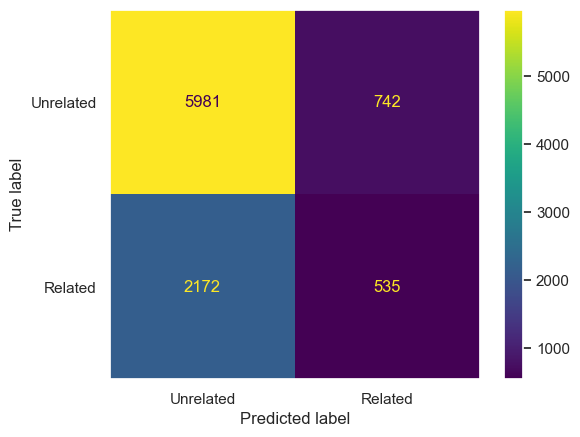

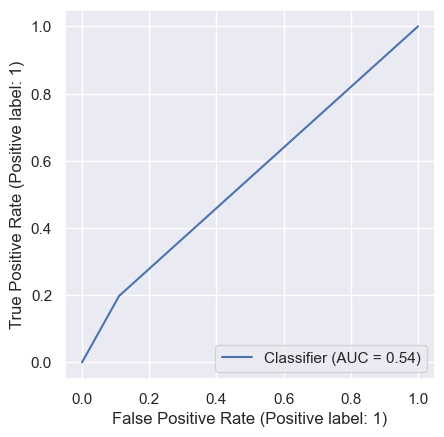

In [79]:
tfidf_feature_report(val_labels, val_pred)

In [80]:
y_pred = model.predict(tfidf_test_input_features)

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.85      0.79     18349
           1       0.35      0.21      0.26      7064

    accuracy                           0.67     25413
   macro avg       0.55      0.53      0.53     25413
weighted avg       0.63      0.67      0.64     25413


Additional Metrics:
Binary F1 Score: 0.26365816825086613
Weighted F1 Score: 0.6440677195180847
Cohen-Kappa Score: 0.07136045502449428
MCC: 0.07536537263920247
ROC AUC: 0.5312209008831966



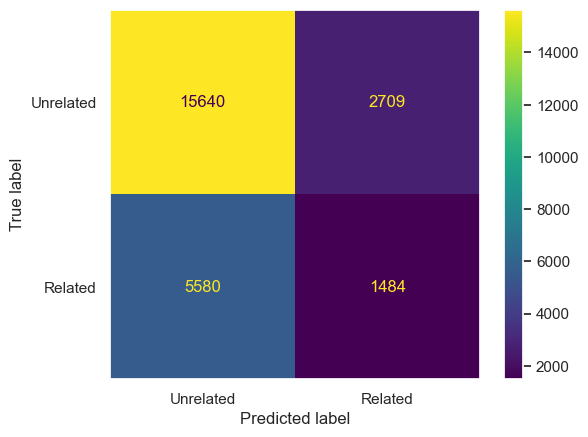

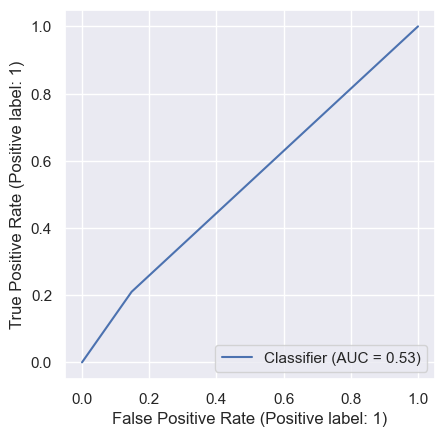

In [81]:
tfidf_feature_report(test_labels, y_pred)

In [82]:
del y_pred, model

### Complement Bayes

In [83]:
model = ComplementNB()
model.fit(tfidf_train_input_features, train_labels)

ComplementNB()

In [84]:
print("Train accuracy:", model.score(tfidf_train_input_features, train_labels))
print("Validation accuracy:", model.score(tfidf_val_input_features, val_labels))
print("Test accuracy:", model.score(tfidf_test_input_features, test_labels))

Train accuracy: 0.7996398796309999
Validation accuracy: 0.6669141039236479
Test accuracy: 0.5598315822610475


In [85]:
val_pred = model.predict(tfidf_val_input_features)

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      6723
           1       0.42      0.39      0.40      2707

    accuracy                           0.67      9430
   macro avg       0.59      0.59      0.59      9430
weighted avg       0.66      0.67      0.66      9430


Additional Metrics:
Binary F1 Score: 0.40409789413773484
Weighted F1 Score: 0.6641484318359752
Cohen-Kappa Score: 0.17319110405042604
MCC: 0.1733139338915987
ROC AUC: 0.5852292586454948



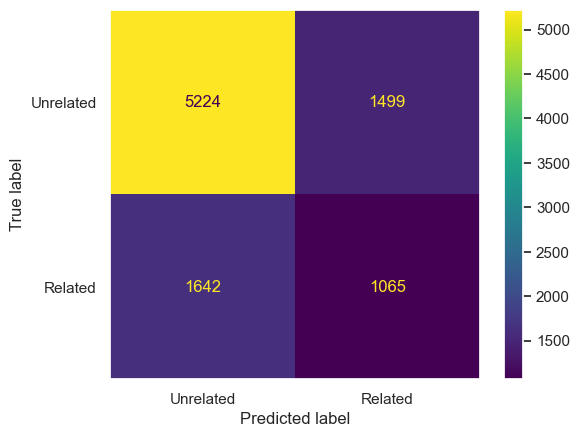

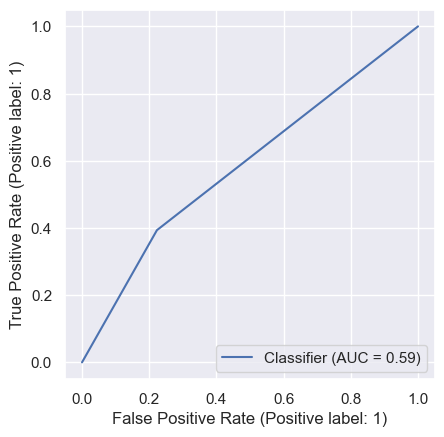

In [86]:
tfidf_feature_report(val_labels, val_pred)

In [71]:
y_pred = model.predict(tfidf_test_input_features)

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.58      0.65     18349
           1       0.32      0.52      0.40      7064

    accuracy                           0.56     25413
   macro avg       0.54      0.55      0.52     25413
weighted avg       0.64      0.56      0.58     25413


Additional Metrics:
Binary F1 Score: 0.3962651122625216
Weighted F1 Score: 0.5821144625630327
Cohen-Kappa Score: 0.07970138186226527
MCC: 0.08550010846621127
ROC AUC: 0.5474837216219287



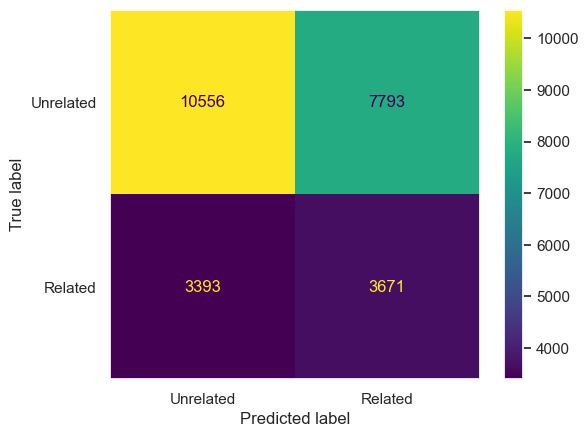

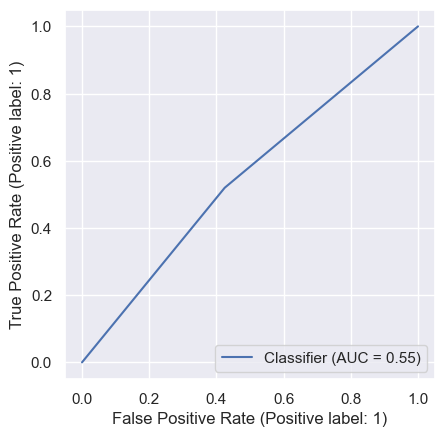

In [72]:
tfidf_feature_report(test_labels, y_pred)

In [73]:
del y_pred, model

### Gradient Boost

In [101]:
def f1_metric(ytrue,preds):
    ''' Return the F1 Score value for the preds and true values, ytrue '''
    return 'f1_score', f1_score((preds>=0.5).astype('int'), ytrue, average='weighted'), True

In [114]:
model = LGBMClassifier(learning_rate=0.06, n_estimators=1500, colsample_bytree=0.5, metric="f1_score", is_unbalance=True)
model.fit(
    tfidf_train_input_features.astype(np.float32),
    train_labels, 
    eval_set=[(tfidf_val_input_features.astype(np.float32), val_labels)],
    verbose=400
)

F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMClassifier(colsample_bytree=0.5, is_unbalance=True, learning_rate=0.06,
               metric='f1_score', n_estimators=1500)

In [115]:
print("Train accuracy:", model.score(tfidf_train_input_features.astype(np.float32), train_labels))
print("Validation accuracy:", model.score(tfidf_val_input_features.astype(np.float32), val_labels))
print("Test accuracy:", model.score(tfidf_test_input_features.astype(np.float32), test_labels))

Train accuracy: 0.9998273395491095
Validation accuracy: 0.9173913043478261
Test accuracy: 0.6063432101680243


In [116]:
val_pred = model.predict(tfidf_val_input_features)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      6723
           1       0.79      0.97      0.87      2707

    accuracy                           0.92      9430
   macro avg       0.89      0.93      0.91      9430
weighted avg       0.93      0.92      0.92      9430


Additional Metrics:
Binary F1 Score: 0.8711757896477591
Weighted F1 Score: 0.9196744871157291
Cohen-Kappa Score: 0.8113537465540331
MCC: 0.821057652106072
ROC AUC: 0.9340101172795823



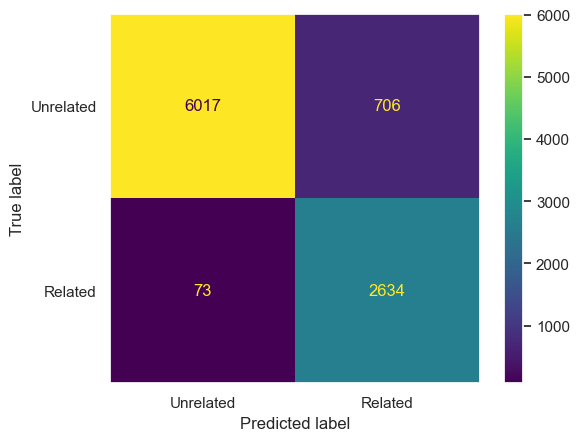

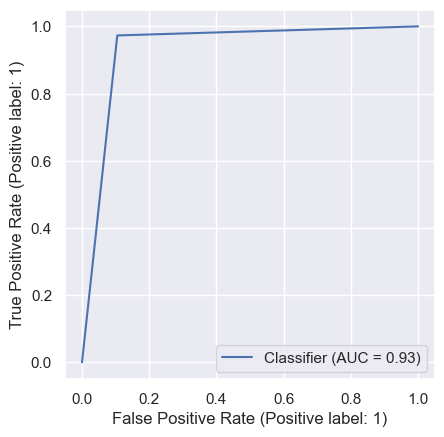

In [117]:
tfidf_feature_report(val_labels, val_pred)

In [118]:
y_pred = model.predict(tfidf_test_input_features)

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.53      0.66     18349
           1       0.40      0.80      0.53      7064

    accuracy                           0.61     25413
   macro avg       0.63      0.66      0.60     25413
weighted avg       0.74      0.61      0.62     25413


Additional Metrics:
Binary F1 Score: 0.52913489598042
Weighted F1 Score: 0.6249222764421071
Cohen-Kappa Score: 0.25129380025760406
MCC: 0.29693436930313233
ROC AUC: 0.6645799331965904



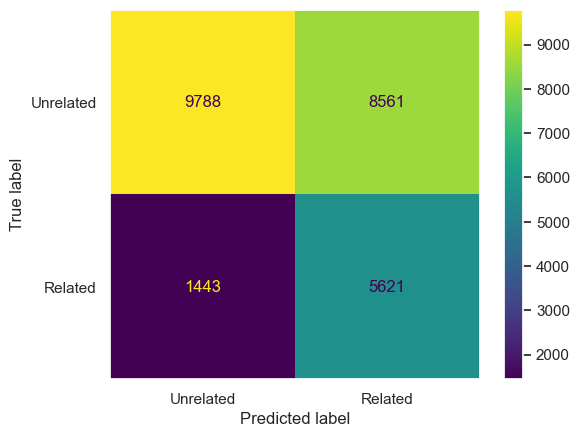

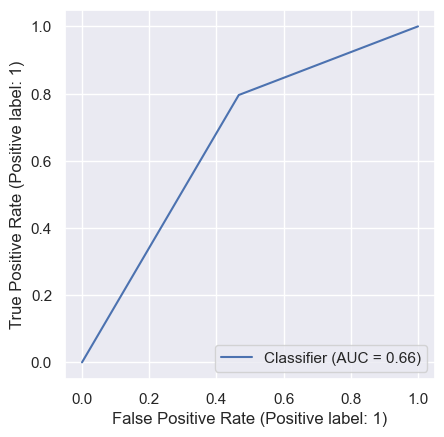

In [119]:
tfidf_feature_report(test_labels, y_pred)

In [120]:
del y_pred, model

### Decision Tree

In [121]:
model = DecisionTreeClassifier()
model.fit(tfidf_train_input_features, train_labels)

DecisionTreeClassifier()

In [122]:
print("Train accuracy:", model.score(tfidf_train_input_features, train_labels))
print("Validation accuracy:", model.score(tfidf_val_input_features, val_labels))
print("Test accuracy:", model.score(tfidf_test_input_features, test_labels))

Train accuracy: 1.0
Validation accuracy: 0.7200424178154825
Test accuracy: 0.5876913390784244


In [124]:
val_pred = model.predict(tfidf_val_input_features)

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.72      0.79      6723
           1       0.51      0.72      0.60      2707

    accuracy                           0.72      9430
   macro avg       0.69      0.72      0.69      9430
weighted avg       0.76      0.72      0.73      9430


Additional Metrics:
Binary F1 Score: 0.5976836330387078
Weighted F1 Score: 0.7314644282987918
Cohen-Kappa Score: 0.39292866950882843
MCC: 0.40737962836888264
ROC AUC: 0.7213493523135489



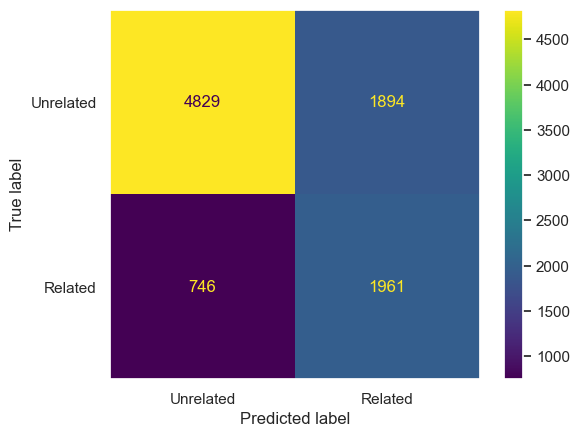

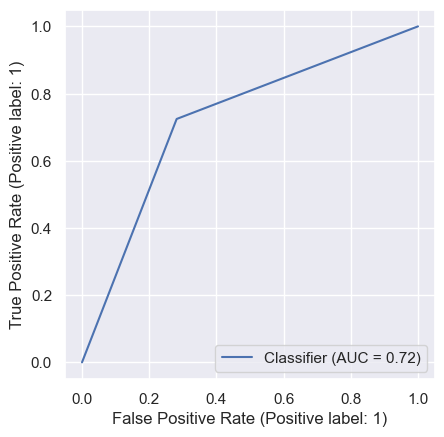

In [125]:
tfidf_feature_report(val_labels, val_pred)

In [123]:
y_pred = model.predict(tfidf_test_input_features)

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.65      0.69     18349
           1       0.32      0.43      0.37      7064

    accuracy                           0.59     25413
   macro avg       0.53      0.54      0.53     25413
weighted avg       0.63      0.59      0.60     25413


Additional Metrics:
Binary F1 Score: 0.3694029850746269
Weighted F1 Score: 0.6035668557332461
Cohen-Kappa Score: 0.07321085146562323
MCC: 0.07505072078701128
ROC AUC: 0.5405700708121327



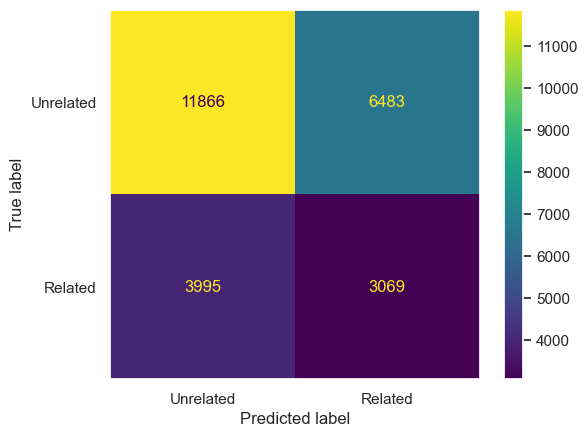

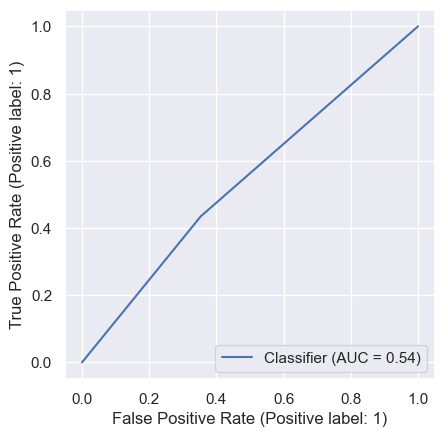

In [126]:
tfidf_feature_report(test_labels, y_pred)

In [127]:
del y_pred, model

### Random Forest

In [129]:
model = RandomForestClassifier()
model.fit(tfidf_train_input_features, train_labels)

RandomForestClassifier()

In [130]:
print("Train accuracy:", model.score(tfidf_train_input_features, train_labels))
print("Validation accuracy:", model.score(tfidf_val_input_features, val_labels))
print("Test accuracy:", model.score(tfidf_test_input_features, test_labels))

Train accuracy: 1.0
Validation accuracy: 0.7729586426299045
Test accuracy: 0.6938574745209145


In [131]:
val_pred = model.predict(tfidf_val_input_features)

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      6723
           1       0.58      0.79      0.67      2707

    accuracy                           0.77      9430
   macro avg       0.74      0.78      0.75      9430
weighted avg       0.81      0.77      0.78      9430


Additional Metrics:
Binary F1 Score: 0.6664589499922106
Weighted F1 Score: 0.7815618249384715
Cohen-Kappa Score: 0.5006818698592352
MCC: 0.5150283688701293
ROC AUC: 0.7781003475929467



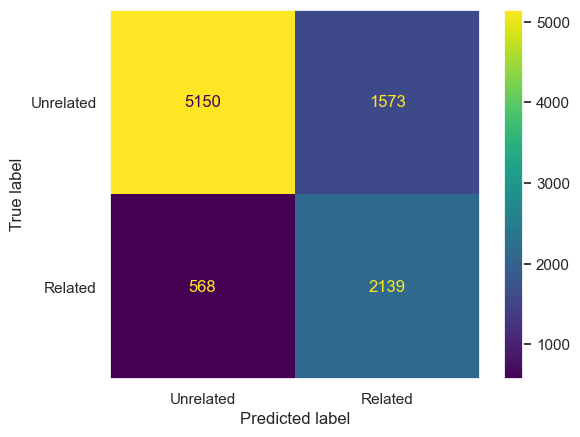

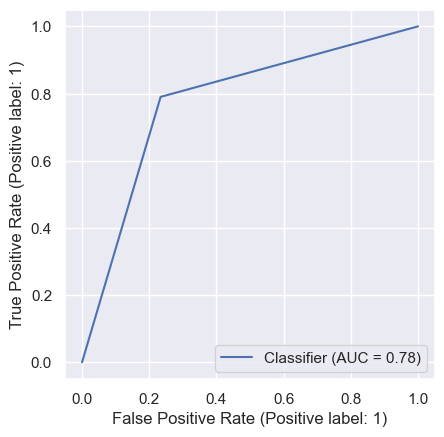

In [133]:
tfidf_feature_report(val_labels, val_pred)

In [132]:
y_pred = model.predict(tfidf_test_input_features)

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.88      0.81     18349
           1       0.40      0.20      0.27      7064

    accuracy                           0.69     25413
   macro avg       0.57      0.54      0.54     25413
weighted avg       0.65      0.69      0.66     25413


Additional Metrics:
Binary F1 Score: 0.26686769694685264
Weighted F1 Score: 0.6565248028655108
Cohen-Kappa Score: 0.09948901926032638
MCC: 0.10891647631624811
ROC AUC: 0.5421306915303367



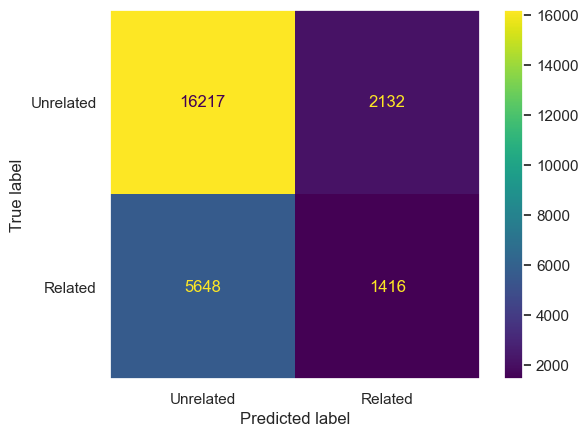

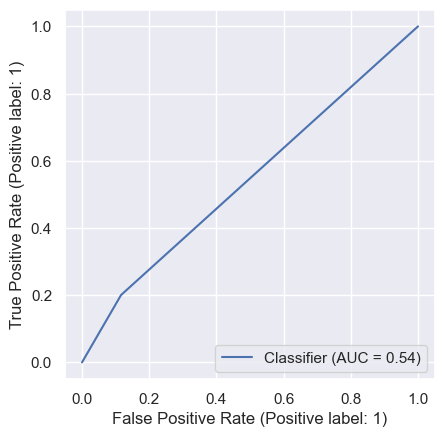

In [134]:
tfidf_feature_report(test_labels, y_pred)

In [135]:
del y_pred, model

## Transformer Features

In [ ]:
train_labels_tensor = torch.LongTensor(transformer_train_df["Related"].values.astype(int))
train_labels_tensor.shape

In [ ]:
val_labels_tensor = torch.LongTensor(transformer_val_df["Related"].values.astype(int))
val_labels_tensor.shape

In [ ]:
test_labels_tensor = torch.LongTensor(transformer_test_df["Related"].values.astype(int))
test_labels_tensor.shape

In [ ]:
class TransformerTokenDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_masks[idx],
            "labels": self.labels[idx] 
        }

        return item
    
    def get_labels(self):
        return self.labels
    
    def __len__(self):
        return len(self.labels)

In [ ]:
train_transformer_input_ids = torch.concat(list(transformer_train_df["input_ids"].values))
train_transformer_attention_masks = torch.concat(list(transformer_train_df["attention_mask"].values))
transformer_train_dataset = TransformerTokenDataset(train_transformer_input_ids, train_transformer_attention_masks, train_labels_tensor)

In [ ]:
val_transformer_input_ids = torch.concat(list(transformer_val_df["input_ids"].values))
val_transformer_attention_masks = torch.concat(list(transformer_val_df["attention_mask"].values))
transformer_val_dataset = TransformerTokenDataset(val_transformer_input_ids, val_transformer_attention_masks, val_labels_tensor)

In [ ]:
test_transformer_input_ids = torch.concat(list(transformer_test_df["input_ids"].values))
test_transformer_attention_masks = torch.concat(list(transformer_test_df["attention_mask"].values))
transformer_test_dataset = TransformerTokenDataset(test_transformer_input_ids, test_transformer_attention_masks, test_labels_tensor)

In [ ]:
transformer = AutoModel.from_pretrained(selected_transformer_name).to(device)

def extract_cls_tokens(dataset, cls_batch_size=64):
    rows = []
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=cls_batch_size, shuffle=False)
    
    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            
            cls_outputs = transformer(input_ids, attention_mask=attention_mask)["last_hidden_state"][:, 0, :].detach().cpu()
            
            for cls_output, label in zip(cls_outputs, batch["labels"]):
                rows.append({"CLS Output": cls_output.numpy(), "Related": label.item() == 1})
    
    cls_df = pd.DataFrame(rows)
    cls_df = cls_df.sample(frac=1).reset_index(drop=True)
    
    return cls_df

In [ ]:
cls_train_df = extract_cls_tokens(transformer_train_dataset)

In [ ]:
cls_val_df = extract_cls_tokens(transformer_val_dataset)

In [ ]:
cls_test_df = extract_cls_tokens(transformer_test_dataset)

In [ ]:
cls_train_features = np.array(list(cls_train_df["CLS Output"].values))
cls_train_labels = cls_train_df["Related"].values.astype(int)

In [ ]:
cls_train_features.shape

In [ ]:
cls_train_labels.shape

In [ ]:
cls_val_features = np.array(list(cls_val_df["CLS Output"].values))
cls_val_labels = cls_val_df["Related"].values.astype(int)

In [ ]:
cls_val_features.shape

In [ ]:
cls_val_labels.shape

In [ ]:
cls_test_features = np.array(list(cls_test_df["CLS Output"].values))
cls_test_labels = cls_test_df["Related"].values.astype(int)

In [ ]:
cls_test_features.shape

In [ ]:
cls_test_labels.shape

In [ ]:
def transformer_feature_report(y_true, y_pred):
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    print()
    
    print("Additional Metrics:")
    
    binary_f1 = f1_score(y_true, y_pred)
    print("Binary F1 Score:", binary_f1)
    
    weighted_f1 = f1_score(y_true, y_pred, average="weighted")
    print("Weighted F1 Score:", weighted_f1)
    
    kappa = cohen_kappa_score(y_true, y_pred)
    print("Cohen-Kappa Score:", kappa)
    
    mcc = matthews_corrcoef(y_true, y_pred)
    print("MCC:", mcc)
    
    auc = roc_auc_score(y_true, y_pred)
    print("ROC AUC:", auc)
    
    print()
    
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=["Unrelated", "Related"], values_format="")
    plt.grid(False)
    plt.show
    
    RocCurveDisplay.from_predictions(y_true, y_pred)
    plt.gca().set_aspect("equal")
    plt.grid(True)
    plt.show()

### Decision Trees

In [96]:
model = DecisionTreeClassifier()
model.fit(cls_train_features, cls_train_labels)

DecisionTreeClassifier()

In [97]:
print("Train accuracy:", model.score(cls_train_features, cls_train_labels))
print("Validation accuracy:", model.score(cls_val_features, cls_val_labels))
print("Test accuracy:", model.score(cls_test_features, cls_test_labels))

Train accuracy: 1.0
Validation accuracy: 0.5504725897920605
Test accuracy: 0.556093338055326


In [98]:
val_pred = model.predict(cls_val_features)

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.55      0.65      7967
           1       0.29      0.54      0.37      2613

    accuracy                           0.55     10580
   macro avg       0.54      0.55      0.51     10580
weighted avg       0.66      0.55      0.58     10580


Additional Metrics:
Binary F1 Score: 0.37404580152671757
Weighted F1 Score: 0.5813297157148883
Cohen-Kappa Score: 0.07392533352670083
MCC: 0.08334797762926212
ROC AUC: 0.5482370326775139



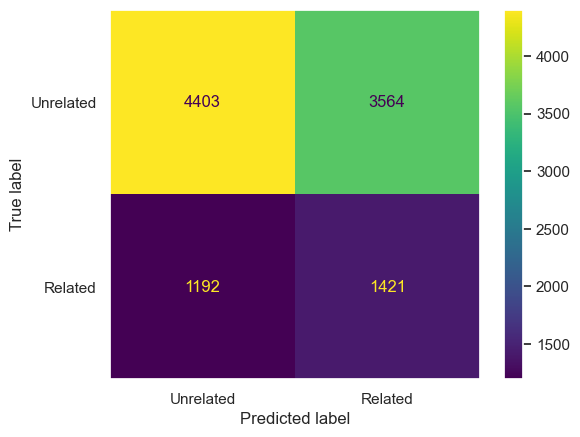

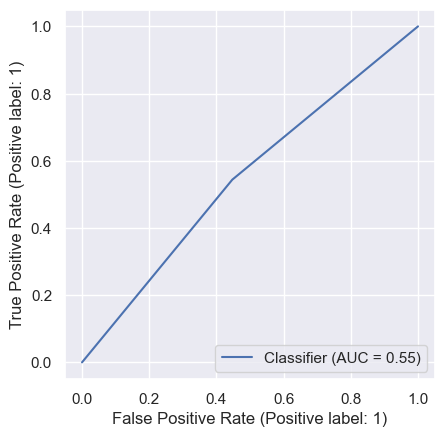

In [99]:
transformer_feature_report(cls_val_labels, val_pred)

In [100]:
y_pred = model.predict(cls_test_features)

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.56      0.65     18349
           1       0.32      0.54      0.40      7064

    accuracy                           0.56     25413
   macro avg       0.54      0.55      0.53     25413
weighted avg       0.64      0.56      0.58     25413


Additional Metrics:
Binary F1 Score: 0.40441370571775515
Weighted F1 Score: 0.5789891847054979
Cohen-Kappa Score: 0.08568131838450443
MCC: 0.09305334518094915
ROC AUC: 0.5518166103953873



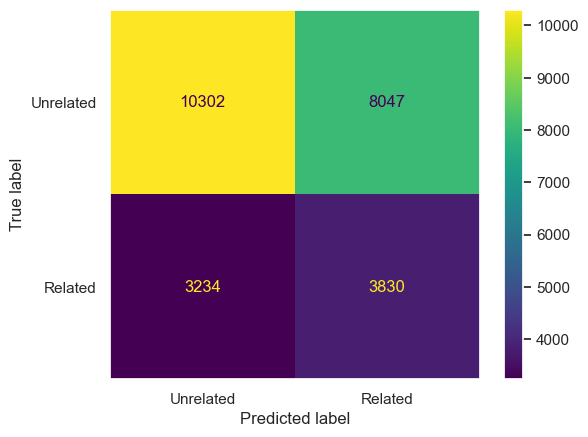

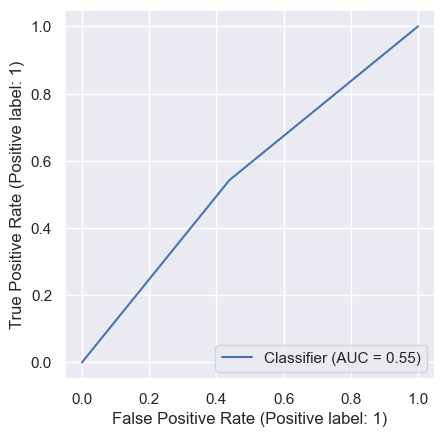

In [101]:
transformer_feature_report(cls_test_labels, y_pred)

In [102]:
del y_pred, model

### SVM

In [103]:
model = SVC(verbose=True)
model.fit(cls_train_features, cls_train_labels)

[LibSVM]

SVC(verbose=True)

In [104]:
print("Train accuracy:", model.score(cls_train_features, cls_train_labels))
print("Validation accuracy:", model.score(cls_val_features, cls_val_labels))
print("Test accuracy:", model.score(cls_test_features, cls_test_labels))

Train accuracy: 0.7254772542648253
Validation accuracy: 0.7530245746691872
Test accuracy: 0.7220320308503522


In [105]:
val_pred = model.predict(cls_val_features)

Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86      7967
           1       0.00      0.00      0.00      2613

    accuracy                           0.75     10580
   macro avg       0.38      0.50      0.43     10580
weighted avg       0.57      0.75      0.65     10580


Additional Metrics:
Binary F1 Score: 0.0
Weighted F1 Score: 0.6469344677187052
Cohen-Kappa Score: 0.0
MCC: 0.0
ROC AUC: 0.5



F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

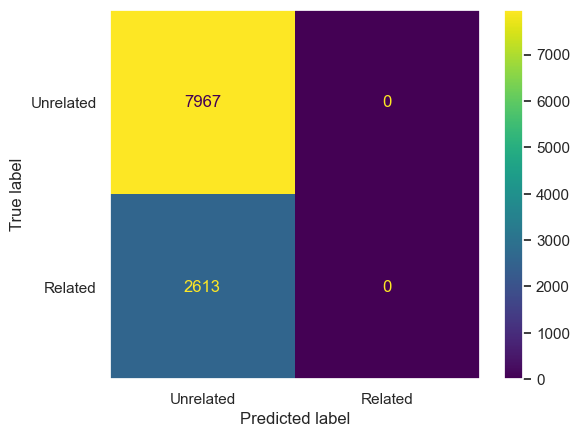

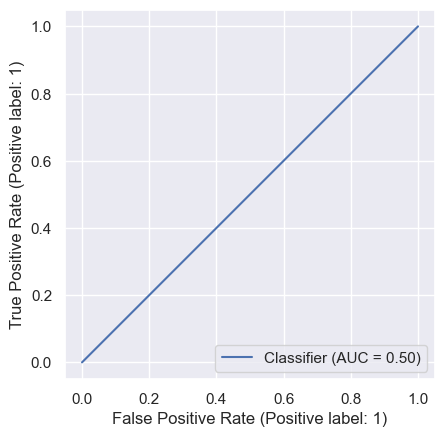

In [106]:
transformer_feature_report(cls_val_labels, val_pred)

In [107]:
y_pred = model.predict(cls_test_features)

Classification Report:
              precision    recall  f1-score   support

           0       0.72      1.00      0.84     18349
           1       0.00      0.00      0.00      7064

    accuracy                           0.72     25413
   macro avg       0.36      0.50      0.42     25413
weighted avg       0.52      0.72      0.61     25413


Additional Metrics:
Binary F1 Score: 0.0
Weighted F1 Score: 0.6054826440324077
Cohen-Kappa Score: 0.0
MCC: 0.0
ROC AUC: 0.5



F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

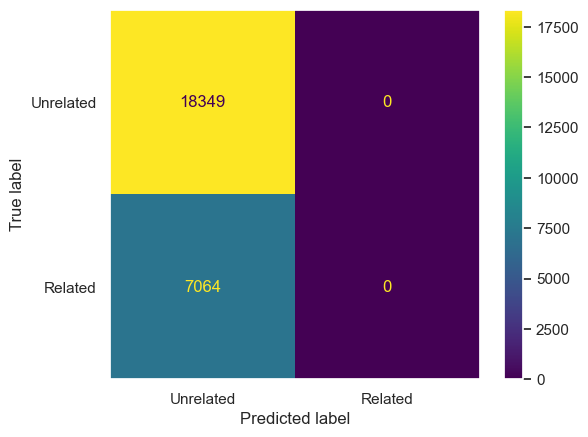

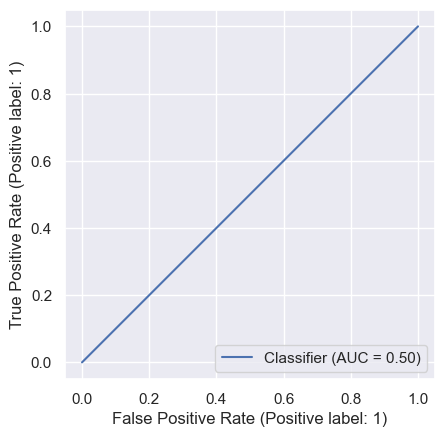

In [108]:
transformer_feature_report(cls_test_labels, y_pred)

In [91]:
del y_pred, model

### Gradient Boost

In [99]:
def f1_metric(ytrue,preds):
    ''' Return the F1 Score value for the preds and true values, ytrue '''
    return 'f1_score', f1_score((preds>=0.5).astype('int'), ytrue, average="weighted"), True

In [106]:
model = LGBMClassifier(learning_rate=0.06, n_estimators=1500, colsample_bytree=0.5, metric="f1_score", scale_pos_weighting=2.0)
model.fit(
    cls_train_features.astype(np.float32),
    cls_train_labels, 
    eval_set=[(cls_val_features.astype(np.float32), cls_val_labels)],
    verbose=400, 
    eval_metric=f1_metric
)

F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: scale_pos_weighting
[400]	valid_0's f1_score: 0.636138
[800]	valid_0's f1_score: 0.622192
[1200]	valid_0's f1_score: 0.622725


LGBMClassifier(colsample_bytree=0.5, learning_rate=0.06, metric='f1_score',
               n_estimators=1500, scale_pos_weighting=2.0)

In [107]:
print("Train accuracy:", model.score(cls_train_features, cls_train_labels))
print("Validation accuracy:", model.score(cls_val_features, cls_val_labels))
print("Test accuracy:", model.score(cls_test_features, cls_test_labels))

Train accuracy: 1.0
Validation accuracy: 0.6506801007556675
Test accuracy: 0.6941722740329752


In [108]:
val_pred = model.predict(cls_val_features)

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.62      0.72      7278
           1       0.41      0.75      0.53      2647

    accuracy                           0.65      9925
   macro avg       0.64      0.68      0.63      9925
weighted avg       0.75      0.65      0.67      9925


Additional Metrics:
Binary F1 Score: 0.5333153856508278
Weighted F1 Score: 0.6708534899150616
Cohen-Kappa Score: 0.2892985110968548
MCC: 0.3217490626392463
ROC AUC: 0.6817679655804509



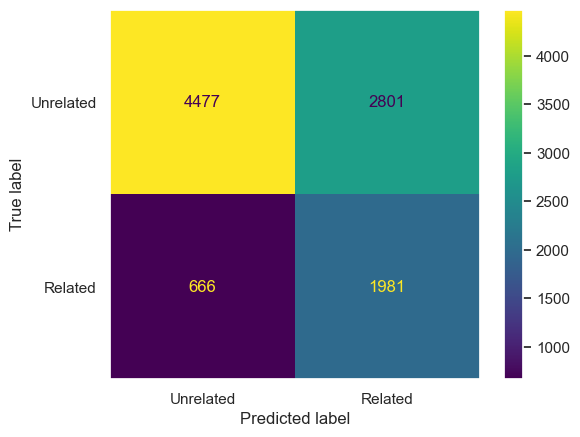

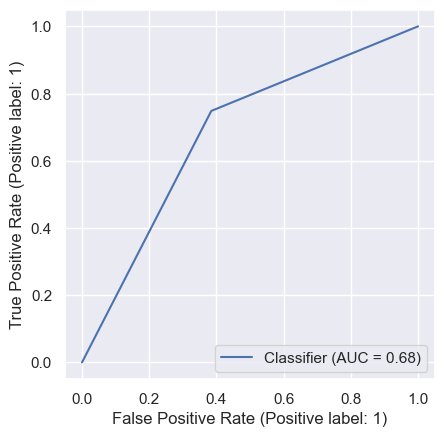

In [109]:
transformer_feature_report(cls_val_labels, val_pred)

In [110]:
y_pred = model.predict(cls_test_features)

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.74      0.78     18349
           1       0.46      0.57      0.51      7064

    accuracy                           0.69     25413
   macro avg       0.64      0.65      0.64     25413
weighted avg       0.72      0.69      0.70     25413


Additional Metrics:
Binary F1 Score: 0.5073529411764707
Weighted F1 Score: 0.7029562472297661
Cohen-Kappa Score: 0.2891042580959039
MCC: 0.2924459363579412
ROC AUC: 0.6549224017379898



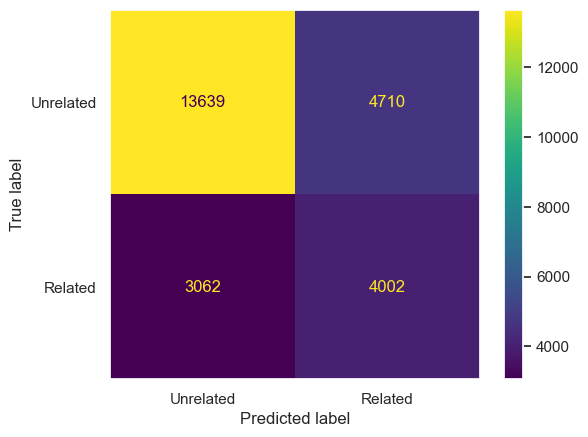

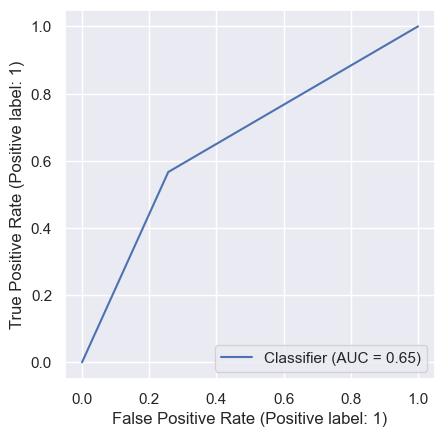

In [111]:
transformer_feature_report(cls_test_labels, y_pred)

In [ ]:
del y_pred, model

# Part 2.a.ii: Related / Unrelated Classification with Deep Learning Models

## TF-IDF

In [60]:
batch_size = 64
apply_loss_weighting = False

In [61]:
unique_class_labels = np.unique(tfidf_train_labels_tensor)
class_weights = compute_class_weight("balanced", classes=unique_class_labels, y=tfidf_train_labels_tensor.squeeze().numpy())
class_weights = torch.from_numpy(class_weights)
class_weights

tensor([0.6847, 1.8537], dtype=torch.float64)

In [62]:
tfidf_train_dataset = torch.utils.data.TensorDataset(tfidf_train_sparse_tensor, tfidf_train_labels_tensor)
tfidf_train_dataloader = torch.utils.data.DataLoader(tfidf_train_dataset, batch_size=batch_size, shuffle=True)

In [63]:
tfidf_val_dataset = torch.utils.data.TensorDataset(tfidf_val_sparse_tensor, tfidf_val_labels_tensor)
tfidf_val_dataloader = torch.utils.data.DataLoader(tfidf_val_dataset, batch_size=batch_size)

In [64]:
tfidf_test_dataset = torch.utils.data.TensorDataset(tfidf_test_sparse_tensor, tfidf_test_labels_tensor)
tfidf_test_dataloader = torch.utils.data.DataLoader(tfidf_test_dataset, batch_size=batch_size)

In [65]:
def evaluate_model(model, dataloader, apply_loss_weighting):
    if not apply_loss_weighting:
        loss_func = nn.BCEWithLogitsLoss()
    
    with torch.no_grad():
        model.eval()
        
        all_pred = np.array([])
        total_loss = 0
        
        for inp, labels in tqdm(dataloader):
            inp = inp.to_dense().to(device)
            labels = labels.to(device)
            
            loss_weights = torch.zeros_like(labels)
            loss_weights[labels == 0] = class_weights[0]
            loss_weights[labels == 1] = class_weights[1]
            loss_func = nn.BCEWithLogitsLoss(weight=loss_weights)
        
            pred = model(inp)
            loss = loss_func(pred, labels.float())
            pred = torch.sigmoid(pred)
            
            all_pred = np.concatenate([all_pred, pred.cpu().round().numpy().squeeze()])
            total_loss += loss.item()
        
        model.train()
    
    return all_pred, total_loss / len(dataloader)

In [72]:
create_classifier_model = lambda inp_dim: nn.Sequential(*[
    nn.Linear(inp_dim, 1024),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(128, 1)
])

In [73]:
classifier_model = create_classifier_model(tfidf_train_sparse_tensor.shape[1]).to(device)

In [74]:
classifier_model

Sequential(
  (0): Linear(in_features=53650, out_features=1024, bias=True)
  (1): Dropout(p=0.2, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=1024, out_features=512, bias=True)
  (4): Dropout(p=0.2, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=512, out_features=256, bias=True)
  (7): Dropout(p=0.2, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=128, bias=True)
  (10): Dropout(p=0.2, inplace=False)
  (11): ReLU()
  (12): Linear(in_features=128, out_features=1, bias=True)
)

In [75]:
opt = optim.Adam(classifier_model.parameters(), lr=1e-3)

  0%|          | 0/634 [00:00<?, ?it/s]

[1:40] Loss: 0.593
[1:80] Loss: 0.486
[1:120] Loss: 0.441
[1:160] Loss: 0.353
[1:200] Loss: 0.284
[1:240] Loss: 0.235
[1:280] Loss: 0.205
[1:320] Loss: 0.177
[1:360] Loss: 0.151
[1:400] Loss: 0.135
[1:440] Loss: 0.105
[1:480] Loss: 0.124
[1:520] Loss: 0.099
[1:560] Loss: 0.084
[1:600] Loss: 0.080
[1:END] Took 194.795s
[1:END] Training Loss: 0.228


  0%|          | 0/148 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92      6945
         1.0       0.71      0.97      0.82      2494

    accuracy                           0.89      9439
   macro avg       0.85      0.91      0.87      9439
weighted avg       0.91      0.89      0.89      9439


Additional Metrics:
Binary F1 Score: 0.8187035786630654
Weighted F1 Score: 0.8910949706842858
Cohen-Kappa Score: 0.7387770745857353
MCC: 0.7586996461532419
ROC AUC: 0.913812588657703



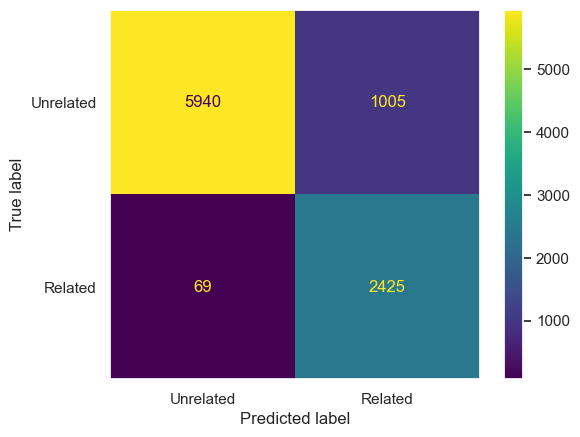

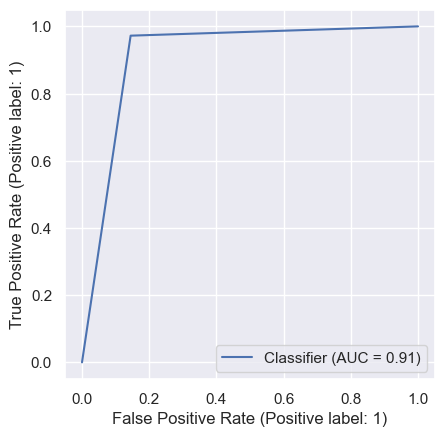

[1:END] Validation Loss: 0.215
[1:END] Validation Accuracy: 88.622%


  0%|          | 0/398 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.23      0.38     18349
         1.0       0.33      0.99      0.50      7064

    accuracy                           0.44     25413
   macro avg       0.66      0.61      0.44     25413
weighted avg       0.80      0.44      0.41     25413


Additional Metrics:
Binary F1 Score: 0.4961940670128762
Weighted F1 Score: 0.40967358263601344
Cohen-Kappa Score: 0.13694920372469366
MCC: 0.26174886703891626
ROC AUC: 0.6101645654868266



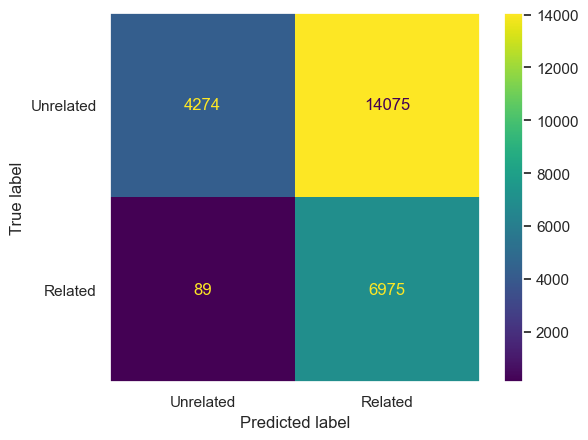

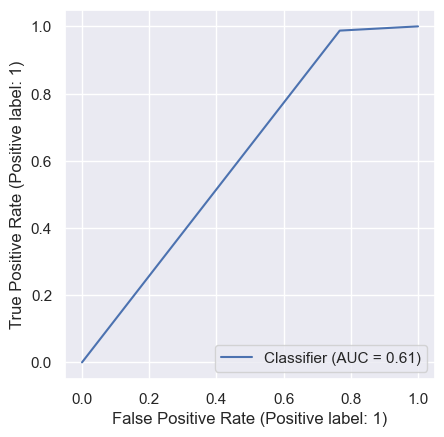

[1:END] Test Loss: 0.700
[1:END] Test Accuracy: 44.265%
[1:END] Validation loss improved, saved model to ./runs/1681904201.7140074_no_weight/model_1.pth


  0%|          | 0/634 [00:00<?, ?it/s]

[2:40] Loss: 0.048
[2:80] Loss: 0.049
[2:120] Loss: 0.052
[2:160] Loss: 0.040
[2:200] Loss: 0.044
[2:240] Loss: 0.037
[2:280] Loss: 0.039
[2:320] Loss: 0.030
[2:360] Loss: 0.050
[2:400] Loss: 0.038
[2:440] Loss: 0.031
[2:480] Loss: 0.041
[2:520] Loss: 0.039
[2:560] Loss: 0.030
[2:600] Loss: 0.029
[2:END] Took 193.039s
[2:END] Training Loss: 0.040


  0%|          | 0/148 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.85      0.92      6945
         1.0       0.71      0.99      0.83      2494

    accuracy                           0.89      9439
   macro avg       0.85      0.92      0.87      9439
weighted avg       0.92      0.89      0.89      9439


Additional Metrics:
Binary F1 Score: 0.8263052208835341
Weighted F1 Score: 0.8949106489290175
Cohen-Kappa Score: 0.7490299505769169
MCC: 0.7713617481008547
ROC AUC: 0.9220578055439607



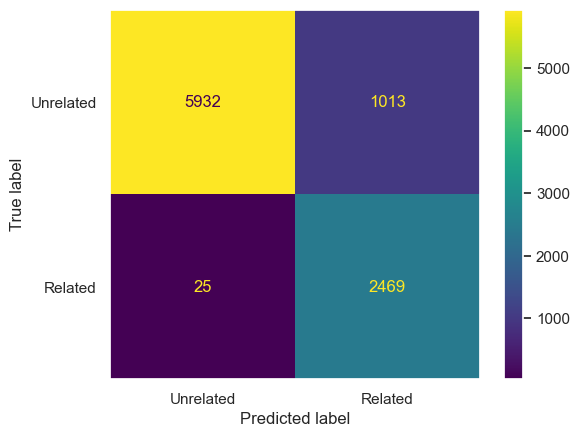

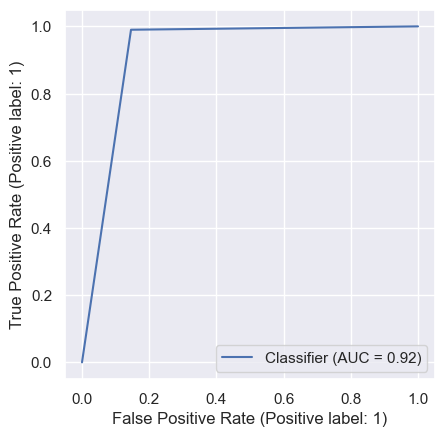

[2:END] Validation Loss: 0.180
[2:END] Validation Accuracy: 89.003%


  0%|          | 0/398 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.21      0.35     18349
         1.0       0.33      0.99      0.49      7064

    accuracy                           0.43     25413
   macro avg       0.66      0.60      0.42     25413
weighted avg       0.81      0.43      0.39     25413


Additional Metrics:
Binary F1 Score: 0.4915153423603093
Weighted F1 Score: 0.38694294215194935
Cohen-Kappa Score: 0.12551511231521284
MCC: 0.2542687833964321
ROC AUC: 0.6022425889080145



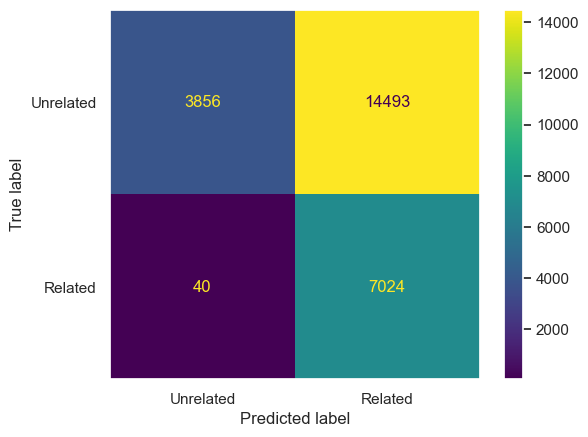

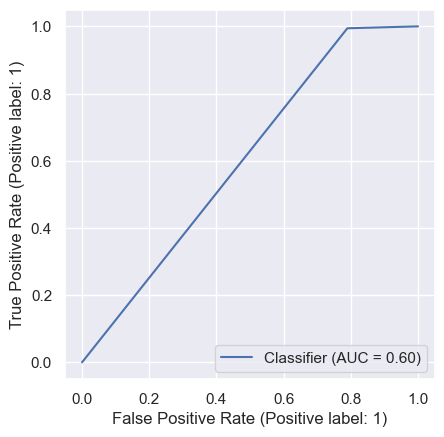

[2:END] Test Loss: 0.769
[2:END] Test Accuracy: 42.813%
[2:END] Validation loss improved, saved model to ./runs/1681904201.7140074_no_weight/model_2.pth


  0%|          | 0/634 [00:00<?, ?it/s]

[3:40] Loss: 0.017
[3:80] Loss: 0.019
[3:120] Loss: 0.013
[3:160] Loss: 0.017
[3:200] Loss: 0.014
[3:240] Loss: 0.019
[3:280] Loss: 0.014
[3:320] Loss: 0.014
[3:360] Loss: 0.010
[3:400] Loss: 0.021
[3:440] Loss: 0.019
[3:480] Loss: 0.015
[3:520] Loss: 0.024
[3:560] Loss: 0.016
[3:600] Loss: 0.011
[3:END] Took 176.100s
[3:END] Training Loss: 0.016


  0%|          | 0/148 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.91      0.95      6945
         1.0       0.80      0.98      0.88      2494

    accuracy                           0.93      9439
   macro avg       0.90      0.95      0.92      9439
weighted avg       0.94      0.93      0.93      9439


Additional Metrics:
Binary F1 Score: 0.8835529879039538
Weighted F1 Score: 0.9336539359078347
Cohen-Kappa Score: 0.8358729558541572
MCC: 0.8442119920281013
ROC AUC: 0.9475248299302055



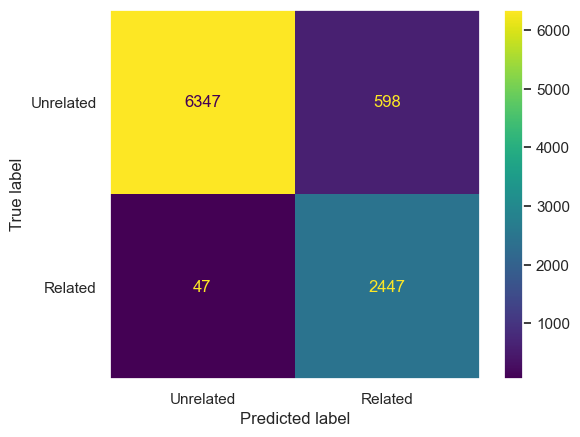

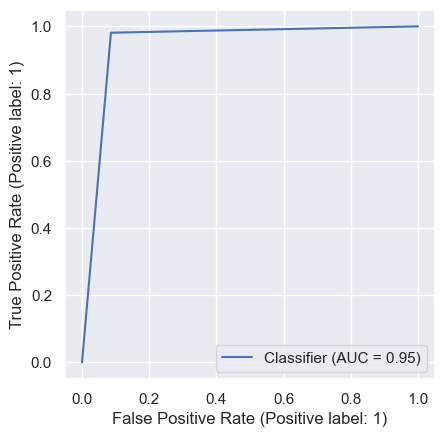

[3:END] Validation Loss: 0.154
[3:END] Validation Accuracy: 93.167%


  0%|          | 0/398 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.26      0.41     18349
         1.0       0.34      0.99      0.50      7064

    accuracy                           0.46     25413
   macro avg       0.66      0.62      0.46     25413
weighted avg       0.80      0.46      0.43     25413


Additional Metrics:
Binary F1 Score: 0.503867563073809
Weighted F1 Score: 0.43417174525919283
Cohen-Kappa Score: 0.1533749431283391
MCC: 0.27875926886482655
ROC AUC: 0.6218821608862568



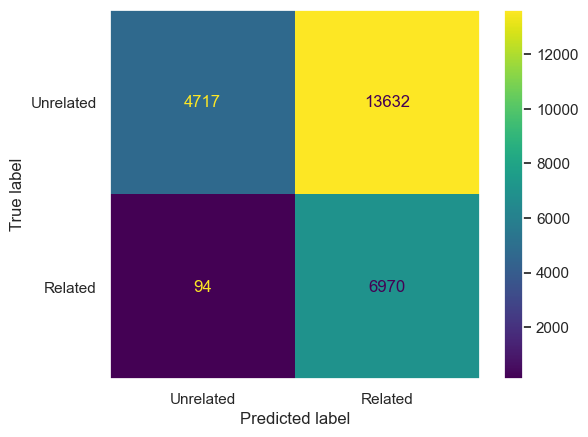

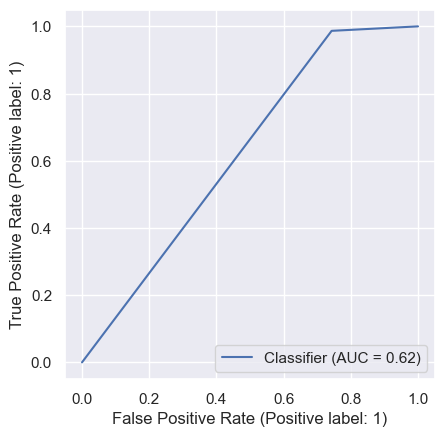

[3:END] Test Loss: 0.881
[3:END] Test Accuracy: 45.988%
[3:END] Validation loss improved, saved model to ./runs/1681904201.7140074_no_weight/model_3.pth


  0%|          | 0/634 [00:00<?, ?it/s]

[4:40] Loss: 0.008
[4:80] Loss: 0.014
[4:120] Loss: 0.014
[4:160] Loss: 0.007
[4:200] Loss: 0.009
[4:240] Loss: 0.010
[4:280] Loss: 0.014
[4:320] Loss: 0.006
[4:360] Loss: 0.008
[4:400] Loss: 0.021
[4:440] Loss: 0.015
[4:480] Loss: 0.007
[4:520] Loss: 0.014
[4:560] Loss: 0.009
[4:600] Loss: 0.014
[4:END] Took 189.936s
[4:END] Training Loss: 0.011


  0%|          | 0/148 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.90      0.95      6945
         1.0       0.79      0.98      0.87      2494

    accuracy                           0.92      9439
   macro avg       0.89      0.94      0.91      9439
weighted avg       0.94      0.92      0.93      9439


Additional Metrics:
Binary F1 Score: 0.8722341184867952
Weighted F1 Score: 0.9265534867355265
Cohen-Kappa Score: 0.8192162761964671
MCC: 0.8293085927192715
ROC AUC: 0.9420277781145592



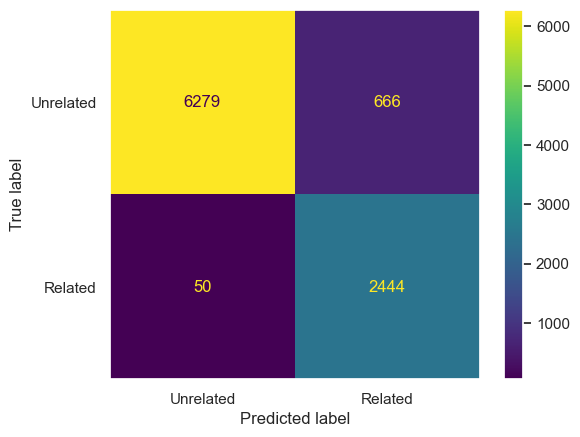

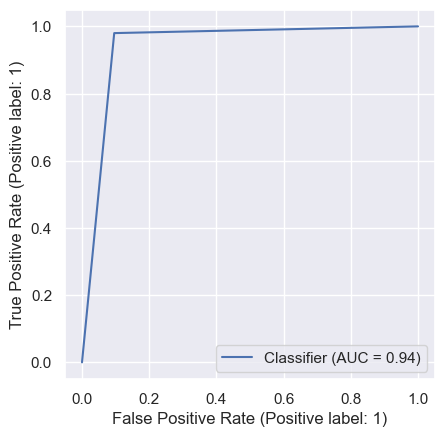

[4:END] Validation Loss: 0.188
[4:END] Validation Accuracy: 92.414%


  0%|          | 0/398 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.27      0.42     18349
         1.0       0.34      0.99      0.51      7064

    accuracy                           0.47     25413
   macro avg       0.66      0.63      0.46     25413
weighted avg       0.81      0.47      0.44     25413


Additional Metrics:
Binary F1 Score: 0.5085263425808093
Weighted F1 Score: 0.4449275927613623
Cohen-Kappa Score: 0.16252718280334533
MCC: 0.2903670180797173
ROC AUC: 0.6285785298040688



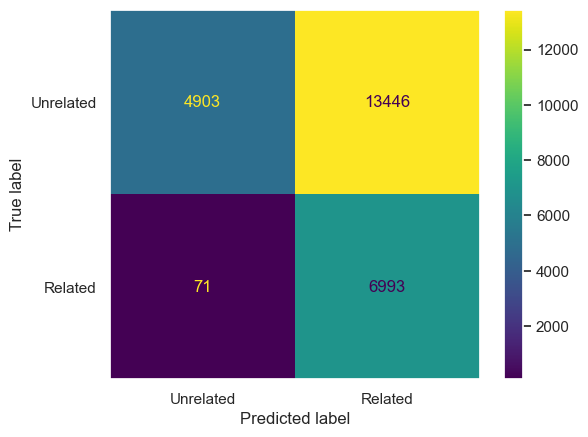

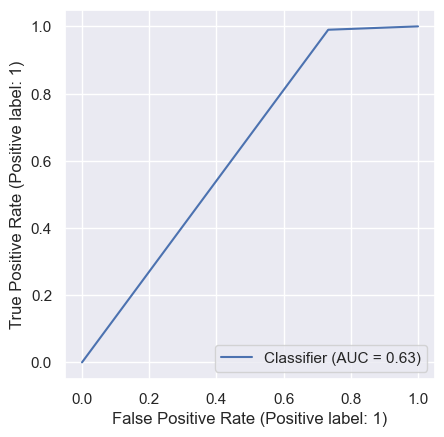

[4:END] Test Loss: 0.826
[4:END] Test Accuracy: 46.811%


  0%|          | 0/634 [00:00<?, ?it/s]

[5:40] Loss: 0.004
[5:80] Loss: 0.003
[5:120] Loss: 0.006
[5:160] Loss: 0.008
[5:200] Loss: 0.003
[5:240] Loss: 0.013
[5:280] Loss: 0.002
[5:320] Loss: 0.004
[5:360] Loss: 0.008
[5:400] Loss: 0.005
[5:440] Loss: 0.012
[5:480] Loss: 0.004
[5:520] Loss: 0.003
[5:560] Loss: 0.002
[5:600] Loss: 0.005
[5:END] Took 177.927s
[5:END] Training Loss: 0.006


  0%|          | 0/148 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92      6945
         1.0       0.72      0.99      0.83      2494

    accuracy                           0.89      9439
   macro avg       0.86      0.92      0.88      9439
weighted avg       0.92      0.89      0.90      9439


Additional Metrics:
Binary F1 Score: 0.8318943626206197
Weighted F1 Score: 0.8992549356271362
Cohen-Kappa Score: 0.7580064085813615
MCC: 0.7777628478644946
ROC AUC: 0.9237557033929666



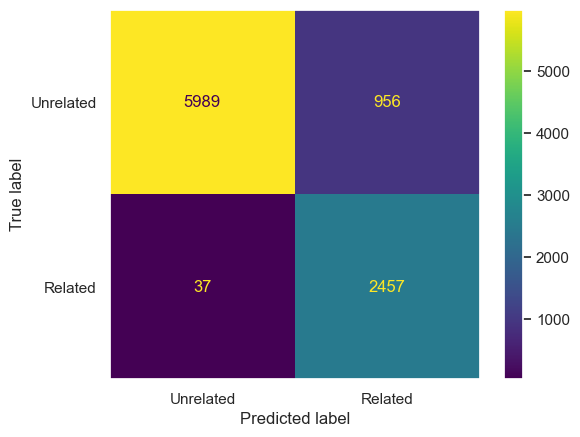

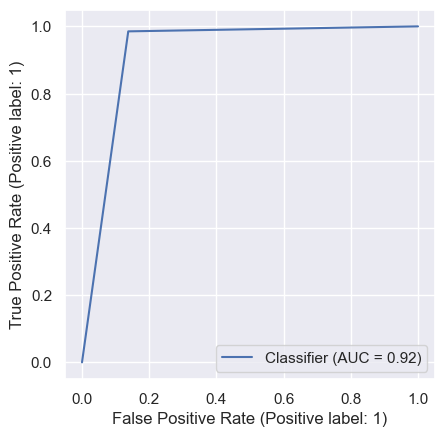

[5:END] Validation Loss: 0.290
[5:END] Validation Accuracy: 89.480%


  0%|          | 0/398 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.22      0.36     18349
         1.0       0.33      1.00      0.49      7064

    accuracy                           0.43     25413
   macro avg       0.66      0.61      0.43     25413
weighted avg       0.81      0.43      0.40     25413


Additional Metrics:
Binary F1 Score: 0.49465240641711233
Weighted F1 Score: 0.3965678517807359
Cohen-Kappa Score: 0.1320430748507878
MCC: 0.26211889113444536
ROC AUC: 0.6071089364157276



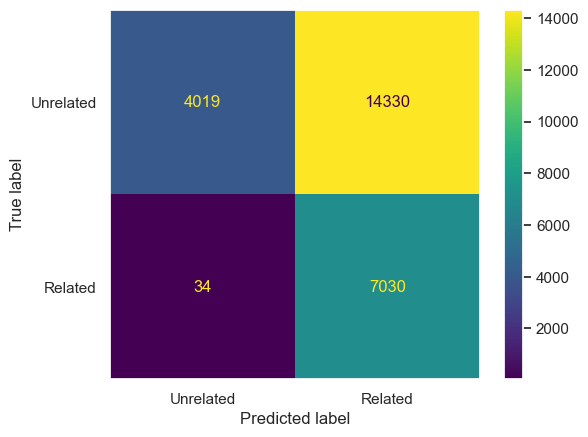

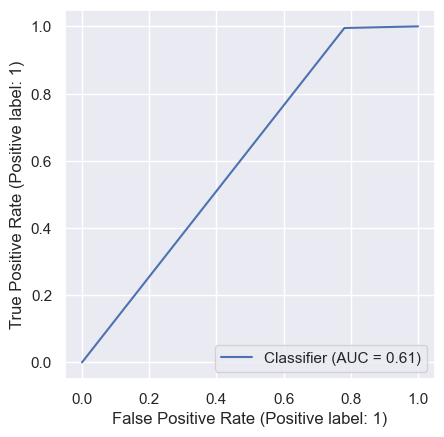

[5:END] Test Loss: 1.134
[5:END] Test Accuracy: 43.478%
[END] Stopping early as validation loss hasn't improved in 2 epochs
Training complete


In [76]:
best_validation_loss = 1e9
save_path = f"./runs/{time.time()}_{'weighted' if apply_loss_weighting else 'no_weight'}"
epochs_since_best_validation = 0

os.makedirs(save_path, exist_ok=True)

val_labels = tfidf_val_labels_tensor.squeeze().numpy()
test_labels = tfidf_test_labels_tensor.squeeze().numpy()

if not apply_loss_weighting:
    loss_func = nn.BCEWithLogitsLoss()

for epoch in range(1, 16):
    epoch_st = time.time()
    epoch_loss = 0
    
    batch_acc_loss = 0
    
    for batch_no, (inp, labels) in enumerate(tqdm(tfidf_train_dataloader)):
        inp = inp.to_dense().to(device)
        labels = labels.to(device)
        
        if apply_loss_weighting:
            loss_weights = torch.zeros_like(labels)
            loss_weights[labels == 0] = class_weights[0]
            loss_weights[labels == 1] = class_weights[1]
            loss_func = nn.BCEWithLogitsLoss(weight=loss_weights)
        
        predictions = classifier_model(inp)
        loss = loss_func(predictions, labels.float())
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        epoch_loss += loss.item()
        batch_acc_loss += loss.item()
        
        if batch_no != 0 and batch_no % 40 == 0:
            print(f"[{epoch}:{batch_no}] Loss: {(batch_acc_loss / 40):.3f}")
            batch_acc_loss = 0
    
    epoch_dt = time.time() - epoch_st
    print(f"[{epoch}:END] Took {epoch_dt:.3f}s")
    print(f"[{epoch}:END] Training Loss: {(epoch_loss / len(tfidf_train_dataloader)):.3f}")
    
    validation_pred, avg_validation_loss = evaluate_model(classifier_model, tfidf_val_dataloader, apply_loss_weighting)
    tfidf_feature_report(val_labels, validation_pred)
    print(f"[{epoch}:END] Validation Loss: {avg_validation_loss:.3f}")
    print(f"[{epoch}:END] Validation Accuracy: {(validation_pred == val_labels).mean() * 100:.3f}%")
    
    test_pred, avg_test_loss = evaluate_model(classifier_model, tfidf_test_dataloader, apply_loss_weighting)
    tfidf_feature_report(test_labels, test_pred)
    print(f"[{epoch}:END] Test Loss: {avg_test_loss:.3f}")
    print(f"[{epoch}:END] Test Accuracy: {(test_pred == test_labels).mean() * 100:.3f}%")
    
    epochs_since_best_validation += 1
    
    if avg_validation_loss < best_validation_loss:
        epochs_since_best_validation = 0
        best_validation_loss = avg_validation_loss
        torch.save(classifier_model.state_dict(), f"{save_path}/model_{epoch}.pth")
        print(f"[{epoch}:END] Validation loss improved, saved model to {save_path}/model_{epoch}.pth")
    
    if epochs_since_best_validation >= 2:
        print(f"[END] Stopping early as validation loss hasn't improved in 2 epochs")
        break
        
print("Training complete")

In [229]:
del classifier_model

## Transformer

### Setup

In [66]:
train_labels_tensor = torch.LongTensor(transformer_train_df["Related"].values.astype(int))
train_labels_tensor.shape

torch.Size([39642])

In [67]:
val_labels_tensor = torch.LongTensor(transformer_val_df["Related"].values.astype(int))
val_labels_tensor.shape

torch.Size([10330])

In [68]:
test_labels_tensor = torch.LongTensor(transformer_test_df["Related"].values.astype(int))
test_labels_tensor.shape

torch.Size([25413])

In [69]:
def transformer_feature_report(y_true, y_pred):
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    print()
    
    print("Additional Metrics:")
    
    binary_f1 = f1_score(y_true, y_pred)
    print("Binary F1 Score:", binary_f1)
    
    weighted_f1 = f1_score(y_true, y_pred, average="weighted")
    print("Weighted F1 Score:", weighted_f1)
    
    kappa = cohen_kappa_score(y_true, y_pred)
    print("Cohen-Kappa Score:", kappa)
    
    mcc = matthews_corrcoef(y_true, y_pred)
    print("MCC:", mcc)
    
    auc = roc_auc_score(y_true, y_pred)
    print("ROC AUC:", auc)
    
    print()
    
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=["Unrelated", "Related"], values_format="")
    plt.grid(False)
    plt.show
    
    RocCurveDisplay.from_predictions(y_true, y_pred)
    plt.gca().set_aspect("equal")
    plt.grid(True)
    plt.show()

In [70]:
class TransformerTokenDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_masks[idx],
            "labels": self.labels[idx] 
        }

        return item
    
    def get_labels(self):
        return self.labels
    
    def __len__(self):
        return len(self.labels)

In [71]:
class WeightedDatasetSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, dataset, label_weights=None):
        self.sample_labels = [x.item() for x in dataset.labels.squeeze()]
        self.unique_labels = sorted(list(set(self.sample_labels)))
        
        print("Unique labels", self.unique_labels)
        
        self.label_indices = [[] for _ in self.unique_labels]
        
        for idx, sample_label in enumerate(self.sample_labels):
            self.label_indices[sample_label].append(idx)
        
        label_sample_distribution = label_weights
        
        if callable(label_weights):
            label_sample_distribution = [label_weights(len(self.label_indices[unique]), len(self.sample_labels)) for unique in self.unique_labels]
            print("Calculated balanced with lambda")
        elif label_weights is None:
            label_sample_distribution = [len(self.label_indices[unique]) / len(self.sample_labels) for unique in self.unique_labels]
            print("Calculated raw distribution")
        elif label_weights == "balanced":
            label_sample_distribution = [1 for unique in self.unique_labels]
            print("Calculated balanced")
        elif label_weights == "inverse":
            label_sample_distribution = [len(self.sample_labels) / len(self.label_indices[unique]) for unique in self.unique_labels]
            print("Calculated inverse")
        elif label_weights == "log_inverse":
            log_total = np.log(len(self.sample_labels))
            label_sample_distribution = [log_total - np.log(len(self.label_indices[unique])) for unique in self.unique_labels]
        
        print("Distribution", label_sample_distribution)
        
        total = sum(label_sample_distribution) # type: ignore
        label_sample_distribution = [x / total for x in label_sample_distribution] # type: ignore
        
        print("Normalised Distribution", label_sample_distribution)
        
        self.label_sample_distribution = label_sample_distribution

    def __iter__(self):
        selected_classes = random.choices(population=self.unique_labels, weights=self.label_sample_distribution, k=len(self))
        possible_choices = [
            random.sample(range(len(indices)), len(indices))
            for indices in self.label_indices
        ]
        
        class_counts = [0 for _ in self.label_indices]
        max_counts = [len(indices) for indices in self.label_indices]
        
        for _i, selected_class in enumerate(selected_classes):
            # Try and visit all samples
            if class_counts[selected_class] < max_counts[selected_class]:
                yield possible_choices[selected_class][class_counts[selected_class]]
                class_counts[selected_class] += 1
                
                if class_counts[selected_class] == max_counts[selected_class]:
                    print(f"Class {selected_class} exhausted, falling back to randomised sampling fromthe class")
            else:
                # Then randomly sample
                yield random.choice(self.label_indices[selected_class])
                class_counts[selected_class] += 1
        
        print("Expected ratio:", self.label_sample_distribution)
        total = sum(class_counts)
        print("Actual ratio:", [x / total for x in class_counts])
    
    def __len__(self):
        return len(self.sample_labels)

In [72]:
from transformers import default_data_collator

class TransformerBasedModelTrainer:
    def __init__(
        self, 
        model_class,
        model_transformer,
        model_freeze_transformer,
        model_config,
        optimiser_class,
        optimiser_config,
        hf_scheduler_name,
        hf_scheduler_config,
        loss_class,
        batch_size,
        max_epochs,
        train_dataset,
        val_dataset,
        test_dataset,
        label_names,
        sampling_weight_fn,
        no_improvement_epochs_stop=3,
        eval_batch_size=None,
        loss_weights=None,
        device="cuda:0",
        excluded_freeze=None
    ):
        excluded_freeze_layers = excluded_freeze if excluded_freeze is not None else []
        
        for name, param in model_transformer.named_parameters():
            if name in excluded_freeze_layers:
                param.requires_grad = True
                continue
                
            param.requires_grad = not model_freeze_transformer
        
        if model_freeze_transformer:
            print("Transformer Frozen")
        
        self.model = model_class(model_transformer, **model_config).to(device)
        print("Model Initialised")
        
        print(self.model)
        
        self.optimiser = optimiser_class(self.model.parameters(), **optimiser_config)
        print("Model Initialised")
        
        if loss_weights is not None:
            assert False, "Need to implement!"

        if hf_scheduler_name is not None:
            self.scheduler = transformers.get_scheduler(hf_scheduler_name, self.optimiser, **hf_scheduler_config)
        else:
            self.scheduler = None
        
        self.loss_fn = loss_class().to(device)
        print("Loss Initialised")
        
        self.batch_size = batch_size
        self.eval_batch_size = eval_batch_size if eval_batch_size is not None else batch_size
        
        self.max_epochs = max_epochs
        self.no_improvement_epochs_stop = no_improvement_epochs_stop
        
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.test_dataset = test_dataset
        
        if sampling_weight_fn is not None:
            train_sampler = WeightedDatasetSampler(train_dataset, label_weights=sampling_weight_fn)
            self.sampling_weights = train_sampler.label_sample_distribution
            print("Train Data Sampler Initialised")

            self.train_dataloader = torch.utils.data.DataLoader(train_dataset, collate_fn=default_data_collator, batch_size=self.batch_size, drop_last=True, sampler=train_sampler)
        else:
            self.sampling_weights = None
            self.train_dataloader = torch.utils.data.DataLoader(train_dataset, collate_fn=default_data_collator, batch_size=self.batch_size, drop_last=True, shuffle=True)
        
        print("Dataloaders Initialised")
        
        self.label_names = label_names
        self.device = device
        self.is_trained = False
        
        self.high_level_name = f"{model_class.__qualname__}/{time.time()}"
        self.save_folder = f"./runs/{self.high_level_name}"
        os.makedirs(self.save_folder)
        
        save_config = {
            "model": {
                "model_class": model_class.__qualname__,
                "model_transformer": model_transformer.__class__.__qualname__,
                "model_freeze_transformer": model_freeze_transformer,
                "model_config": model_config,
                "model_trainable_layers": [name for name, param in self.model.named_parameters() if param.requires_grad]
            },
            "loss": {
                "loss_class": loss_class.__qualname__,
                "loss_weights": loss_weights
            },
            "optimiser": {
                "optimiser_class": optimiser_class.__qualname__,
                "optimiser_config": optimiser_config,
                "scheduler_name": hf_scheduler_name,
                "scheduler_config": hf_scheduler_config
            },
            "datasets": {
                "train_size": len(train_dataset),
                "val_size": len(val_dataset),
                "test_size": len(test_dataset),
                "sampling_weights": self.sampling_weights
            },
            "train_settings": {
                "max_epochs": max_epochs,
                "batch_size": batch_size,
                "no_improvement_epochs_stop": no_improvement_epochs_stop,
                "label_names": label_names
            }
        }
        
        with open(f"{self.save_folder}/info.json", "w+") as fp:
            json.dump(save_config, fp, indent=2)
        
        print("Dumped Config")
        
        # wandb.init(
        #     project=self.high_level_name.replace("/", "_"),
        #     config=save_config
        # )
        
        self._stored_log = []
        
        self._best_validation_loss = 1e9
        self._best_validation_epoch = -1

    def _log(self, msg):
        message = f"[{datetime.today().strftime('%Y-%m-%d %H:%M:%S')}]"
        
        if msg.startswith("["):
            message += msg
        else:
            message = f"{message} {msg}"
        
        self._stored_log.append(message)
        print(message)
    
    def _save_log(self, file_name):
        loc = f"{self.save_folder}/{file_name}"
        
        with open(loc, "w+") as fp:
            fp.write("\n".join(self._stored_log))
        
        self._stored_log = []
    
    def train(self):
        if self.is_trained:
            assert False, "Model already trained"
        
        self.is_trained = True
        
        for epoch in range(1, self.max_epochs + 1):
            self._log(f"Starting epoch {epoch}")
            
            self._log("Starting epoch training")
            epoch_loss = self._train_epoch(epoch)
            self._log("Finished epoch training")

            self._log(f"Epoch Loss: {epoch_loss}")
            
            self._log("Starting validation evaluation")
            validation_results = self.evaluate_model(self.val_dataset, f"{epoch}_validation_set")
            self._log(f"Epoch Accuracy {validation_results['evaluate']['accuracy']}")
            self._log("Finished validation evaluation")
            
            if validation_results["avg_validation_loss"] < self._best_validation_loss:
                self._log(f"Beat best validation loss, new validation loss: {validation_results['avg_validation_loss']} (surpassed {self._best_validation_loss} from epoch {self._best_validation_epoch})")
                self._best_validation_epoch = epoch
                self._best_validation_loss = validation_results["avg_validation_loss"]
                
                torch.save(self.model.state_dict(), f"{self.save_folder}/{epoch}_model.pth")
                
                self._log(f"Saved best model")
            elif epoch - self._best_validation_epoch >= self.no_improvement_epochs_stop:
                self._log(f"Early stopping triggered, best validation loss achieved at {self._best_validation_epoch} (loss: {self._best_validation_loss})")
                self._save_log(f"log_epoch_{epoch}.txt")
                break
                
            # wandb.log({"val_acc": validation_results["accuracy"], "train_loss": epoch_loss, "val_loss": validation_results["avg_validation_loss"]})
            
            self._log("Logged to wandb")
            self._save_log(f"log_epoch_{epoch}.txt")
            
        self._log(f"Loading best model (epoch {self._best_validation_loss}) for evaluation")
        self.model.load_state_dict(torch.load(f"{self.save_folder}/{self._best_validation_epoch}_model.pth"))
        self.model.to(self.device)
        self.model.eval()
        
        self._log("Starting test evaluation")
        test_results = self.evaluate_model(self.test_dataset, f"final_test_set")
        self._log("Finished test evaluation")
        
        self._save_log(f"log_final_evaluation.txt")
        
    def _train_epoch(self, epoch):
        self.model.train()
        self._log("Set model to train mode")
        
        epoch_st = time.time()
        epoch_loss = 0

        batch_acc_loss = 0

        for batch_no, batch in enumerate(tqdm(self.train_dataloader)):
            tokens = batch["input_ids"].to(self.device)
            attention_masks = batch["attention_mask"].to(self.device)
            labels = batch["labels"].to(self.device).squeeze()
            
            # print out tokens, am, labels?

            logits = self.model(tokens, attention_masks)
            loss = self.loss_fn(logits, labels)

            self.optimiser.zero_grad()
            loss.backward()
            self.optimiser.step()

            if self.scheduler is not None:
                self.scheduler.step()

            epoch_loss += loss.item()
            batch_acc_loss += loss.item()

            if batch_no != 0 and batch_no % 40 == 0:
                self._log(f"[{epoch}:{batch_no}] Loss: {(batch_acc_loss / 40):.3f}")
                self._log(f"[{epoch}:{batch_no}] LR: {self.scheduler.get_last_lr()[0]}")
                batch_acc_loss = 0

        epoch_dt = time.time() - epoch_st
        self._log(f"[{epoch}:END] Took {epoch_dt:.3f}s")
        self._log(f"[{epoch}:END] Training Loss: {(epoch_loss / len(self.train_dataloader)):.3f}")
        
        return epoch_loss / len(self.train_dataloader)
    
    def evaluate_model(self, dataset, base_save_name=None):
        results = self._evaluate_model(dataset) 
        
        ConfusionMatrixDisplay.from_predictions(results["y_true"], results["y_pred"], display_labels=self.label_names)
        plt.grid(False)
        
        if base_save_name is not None:
            plt.savefig(f"{self.save_folder}/{base_save_name}_confusion_matrix.png", bbox_inches="tight")
        
        plt.show()
        
        self._log("Classification Report:")
        self._log(classification_report(results["y_true"], results["y_pred"]))
        
        if base_save_name is not None:
            saveable_results = {k: v for k, v in results.items() if k not in ["y_true", "y_pred"]}
            
            saveable_results["y_pred"] = list(results["y_pred"])
            saveable_results["y_true"] = list(results["y_true"].detach().squeeze().cpu().numpy())
            
            with open(f"{self.save_folder}/{base_save_name}_results.json", "w+") as fp:
                json.dump(saveable_results, fp, indent=2, default=lambda o: str(o))
        
        return results
        
    def _evaluate_model(self, dataset):
        y_true = dataset.labels
        y_logits = np.empty((len(y_true), len(self.label_names)))
        y_pred = np.empty(len(y_true))
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.eval_batch_size, collate_fn=default_data_collator)
        
        self._log("Using model to generate predictions")
        
        with torch.inference_mode():
            self.model.eval()
            self._log("Set model to eval mode")

            total_loss = 0

            for i, batch in enumerate(tqdm(dataloader)):
                upper = ((i + 1) if i + 1 < len(dataloader) else len(dataloader)) * self.eval_batch_size

                tokens = batch["input_ids"].to(self.device)
                attention_masks = batch["attention_mask"].to(self.device)
                labels = batch["labels"].to(self.device)

                logits = self.model(tokens, attention_masks)
                y_logits[i * self.eval_batch_size : upper] = logits.cpu().numpy()
                
                loss = self.loss_fn(logits, labels)

                pred = torch.argmax(logits, 1)
                y_pred[i * self.eval_batch_size : upper] = pred.cpu().numpy()
                
                total_loss += loss.item()

            self.model.train()
            self._log("Set model to train mode")
        
        # y_true = y_true[:32]
        # y_pred = y_pred[:32]
        
        report = classification_report(y_true, y_pred, output_dict=True)
        
        probs = softmax(y_logits, axis=-1)
        
        accuracy = evaluate.load("accuracy").compute(predictions=y_pred, references=y_true)
        precision = evaluate.load("precision").compute(predictions=y_pred, references=y_true, average="weighted")
        recall = evaluate.load("recall").compute(predictions=y_pred, references=y_true, average="weighted")
        f1 = evaluate.load("f1").compute(predictions=y_pred, references=y_true, average="weighted")
        
        if len(self.label_names) == 2:
            roc_auc = roc_auc_score(y_true, y_pred)
        else:
            roc_auc = evaluate.load("roc_auc", "multiclass").compute(prediction_scores=probs, references=y_true.squeeze(), average="weighted", multi_class="ovr")
            
        mcc = evaluate.load("matthews_correlation").compute(predictions=y_pred, references=y_true)
        kappa = cohen_kappa_score(y_true, y_pred)
        
        results = {
            "y_true": y_true,
            "y_pred": y_pred,
            "evaluate": {
                "accuracy": accuracy,
                "precision": precision,
                "recall": recall,
                "f1": f1,
                "roc_auc": roc_auc,
                "mcc": mcc,
                "kappa": kappa
            },
            "accuracy": (y_true.squeeze().numpy() == y_pred).mean() * 100,
            "avg_validation_loss": total_loss / len(dataloader),
            "classification_report": report
        }

        return results

In [73]:
train_dataset = TransformerTokenDataset(
    torch.concat(list(transformer_train_df["input_ids"].values)),
    torch.concat(list(transformer_train_df["attention_mask"].values)),
    train_labels_tensor
)

In [74]:
val_dataset = TransformerTokenDataset(
    torch.concat(list(transformer_val_df["input_ids"].values)),
    torch.concat(list(transformer_val_df["attention_mask"].values)),
    val_labels_tensor
)

In [75]:
test_dataset = TransformerTokenDataset(
    torch.concat(list(transformer_test_df["input_ids"].values)),
    torch.concat(list(transformer_test_df["attention_mask"].values)),
    test_labels_tensor
)

In [76]:
labels2id = {
    "Unrelated": 0,
    "Related": 1
}

### Finetuned DistilRoberta

In [81]:
class TransformerMLPDummy(nn.Module):
    def __init__(self, transformer):
        super().__init__()
        self.transformer = transformer
        
    def forward(self, input_ids, mask):
        out = self.transformer(input_ids, attention_mask=mask)
        return out["logits"]

In [82]:
from transformers import AutoModelForSequenceClassification

transformer_with_head = AutoModelForSequenceClassification.from_pretrained(
    selected_transformer_name,
    num_labels=2
)

# print(transformer)

# transformer = AutoModel.from_pretrained(selected_transformer_name)

model_trainer = TransformerBasedModelTrainer(
    model_class=TransformerMLPDummy,
    model_transformer=transformer_with_head,
    model_freeze_transformer=False,
    model_config={},
    optimiser_class=optim.AdamW,
    optimiser_config={
        "lr": 5e-5
    },
    hf_scheduler_name="linear",
    hf_scheduler_config={
        "num_warmup_steps": 0,
        "num_training_steps": 3 * (len(train_dataset) + 1) // 8
    },
    loss_class=nn.CrossEntropyLoss,
    batch_size=8,
    max_epochs=3,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    label_names=list(labels2id.keys()),
    sampling_weight_fn=None,
    no_improvement_epochs_stop=1,
    eval_batch_size=None,
    loss_weights=None,
    device="cuda:0",
    excluded_freeze=["classifier.dense.weight", "classifier.dense.bias", "classifier.out_proj.weight", "classifier.out_proj.bias"]
)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.out_proj.weig

Model Initialised
TransformerMLPDummy(
  (transformer): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
   

[2023-04-21 09:23:30] Starting epoch 1
[2023-04-21 09:23:30] Starting epoch training
[2023-04-21 09:23:30] Set model to train mode


  0%|          | 0/5008 [00:00<?, ?it/s]

[2023-04-21 09:23:41][1:40] Loss: 0.581
[2023-04-21 09:23:41][1:40] LR: 4.986356073211315e-05
[2023-04-21 09:23:52][1:80] Loss: 0.553
[2023-04-21 09:23:52][1:80] LR: 4.9730449251247924e-05
[2023-04-21 09:24:03][1:120] Loss: 0.315
[2023-04-21 09:24:03][1:120] LR: 4.9597337770382694e-05
[2023-04-21 09:24:13][1:160] Loss: 0.247
[2023-04-21 09:24:13][1:160] LR: 4.946422628951747e-05
[2023-04-21 09:24:24][1:200] Loss: 0.148
[2023-04-21 09:24:24][1:200] LR: 4.933111480865225e-05
[2023-04-21 09:24:35][1:240] Loss: 0.136
[2023-04-21 09:24:35][1:240] LR: 4.9198003327787026e-05
[2023-04-21 09:24:46][1:280] Loss: 0.112
[2023-04-21 09:24:46][1:280] LR: 4.9064891846921803e-05
[2023-04-21 09:24:57][1:320] Loss: 0.119
[2023-04-21 09:24:57][1:320] LR: 4.8931780366056574e-05
[2023-04-21 09:25:07][1:360] Loss: 0.064
[2023-04-21 09:25:07][1:360] LR: 4.879866888519135e-05
[2023-04-21 09:25:18][1:400] Loss: 0.112
[2023-04-21 09:25:18][1:400] LR: 4.866555740432612e-05
[2023-04-21 09:25:29][1:440] Loss: 0.19

  0%|          | 0/1239 [00:00<?, ?it/s]

[2023-04-21 09:47:30] Set model to train mode


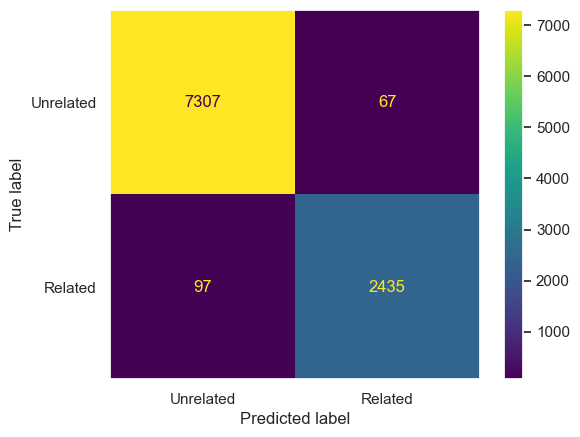

[2023-04-21 09:47:34] Classification Report:
[2023-04-21 09:47:34]               precision    recall  f1-score   support

           0       0.99      0.99      0.99      7374
           1       0.97      0.96      0.97      2532

    accuracy                           0.98      9906
   macro avg       0.98      0.98      0.98      9906
weighted avg       0.98      0.98      0.98      9906

[2023-04-21 09:47:34] Epoch Accuracy {'accuracy': 0.9834443771451645}
[2023-04-21 09:47:34] Finished validation evaluation
[2023-04-21 09:47:34] Beat best validation loss, new validation loss: 0.07312208610729452 (surpassed 1000000000.0 from epoch -1)
[2023-04-21 09:47:35] Saved best model
[2023-04-21 09:47:35] Logged to wandb
[2023-04-21 09:47:35] Starting epoch 2
[2023-04-21 09:47:35] Starting epoch training
[2023-04-21 09:47:35] Set model to train mode


  0%|          | 0/5008 [00:00<?, ?it/s]

[2023-04-21 09:47:46][2:40] Loss: 0.038
[2023-04-21 09:47:46][2:40] LR: 3.3198003327787024e-05
[2023-04-21 09:47:57][2:80] Loss: 0.005
[2023-04-21 09:47:57][2:80] LR: 3.3064891846921794e-05
[2023-04-21 09:48:07][2:120] Loss: 0.010
[2023-04-21 09:48:07][2:120] LR: 3.293178036605658e-05
[2023-04-21 09:48:18][2:160] Loss: 0.003
[2023-04-21 09:48:18][2:160] LR: 3.279866888519135e-05
[2023-04-21 09:48:28][2:200] Loss: 0.030
[2023-04-21 09:48:28][2:200] LR: 3.2665557404326126e-05
[2023-04-21 09:48:39][2:240] Loss: 0.037
[2023-04-21 09:48:39][2:240] LR: 3.25324459234609e-05
[2023-04-21 09:48:49][2:280] Loss: 0.005
[2023-04-21 09:48:49][2:280] LR: 3.2399334442595674e-05
[2023-04-21 09:49:00][2:320] Loss: 0.004
[2023-04-21 09:49:00][2:320] LR: 3.226622296173045e-05
[2023-04-21 09:49:11][2:360] Loss: 0.032
[2023-04-21 09:49:11][2:360] LR: 3.213311148086522e-05
[2023-04-21 09:49:21][2:400] Loss: 0.024
[2023-04-21 09:49:21][2:400] LR: 3.2000000000000005e-05
[2023-04-21 09:49:32][2:440] Loss: 0.021

  0%|          | 0/1239 [00:00<?, ?it/s]

[2023-04-21 10:11:30] Set model to train mode


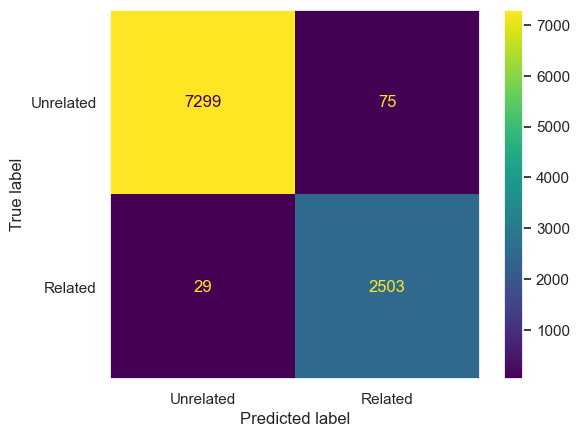

[2023-04-21 10:11:33] Classification Report:
[2023-04-21 10:11:33]               precision    recall  f1-score   support

           0       1.00      0.99      0.99      7374
           1       0.97      0.99      0.98      2532

    accuracy                           0.99      9906
   macro avg       0.98      0.99      0.99      9906
weighted avg       0.99      0.99      0.99      9906

[2023-04-21 10:11:33] Epoch Accuracy {'accuracy': 0.989501312335958}
[2023-04-21 10:11:33] Finished validation evaluation
[2023-04-21 10:11:33] Beat best validation loss, new validation loss: 0.04205945836319239 (surpassed 0.07312208610729452 from epoch 1)
[2023-04-21 10:11:35] Saved best model
[2023-04-21 10:11:35] Logged to wandb
[2023-04-21 10:11:35] Starting epoch 3
[2023-04-21 10:11:35] Starting epoch training
[2023-04-21 10:11:35] Set model to train mode


  0%|          | 0/5008 [00:00<?, ?it/s]

[2023-04-21 10:11:45][3:40] Loss: 0.004
[2023-04-21 10:11:45][3:40] LR: 1.6532445923460897e-05
[2023-04-21 10:11:56][3:80] Loss: 0.003
[2023-04-21 10:11:56][3:80] LR: 1.6399334442595674e-05
[2023-04-21 10:12:07][3:120] Loss: 0.001
[2023-04-21 10:12:07][3:120] LR: 1.626622296173045e-05
[2023-04-21 10:12:17][3:160] Loss: 0.003
[2023-04-21 10:12:17][3:160] LR: 1.6133111480865225e-05
[2023-04-21 10:12:28][3:200] Loss: 0.027
[2023-04-21 10:12:28][3:200] LR: 1.6000000000000003e-05
[2023-04-21 10:12:39][3:240] Loss: 0.003
[2023-04-21 10:12:39][3:240] LR: 1.5866888519134777e-05
[2023-04-21 10:12:49][3:280] Loss: 0.016
[2023-04-21 10:12:49][3:280] LR: 1.573377703826955e-05
[2023-04-21 10:13:00][3:320] Loss: 0.012
[2023-04-21 10:13:00][3:320] LR: 1.5600665557404324e-05
[2023-04-21 10:13:11][3:360] Loss: 0.002
[2023-04-21 10:13:11][3:360] LR: 1.5467554076539105e-05
[2023-04-21 10:13:21][3:400] Loss: 0.009
[2023-04-21 10:13:21][3:400] LR: 1.533444259567388e-05
[2023-04-21 10:13:32][3:440] Loss: 0.

  0%|          | 0/1239 [00:00<?, ?it/s]

[2023-04-21 10:35:38] Set model to train mode


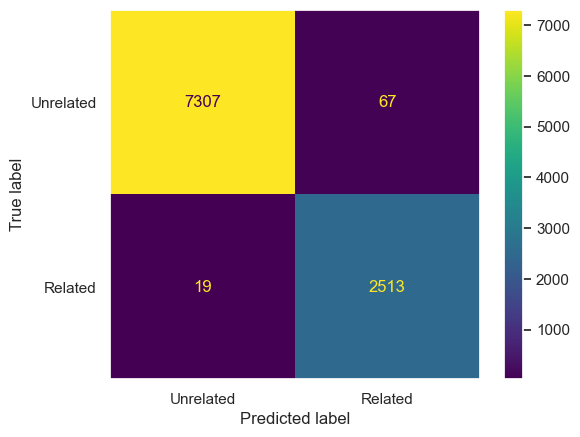

[2023-04-21 10:35:41] Classification Report:
[2023-04-21 10:35:41]               precision    recall  f1-score   support

           0       1.00      0.99      0.99      7374
           1       0.97      0.99      0.98      2532

    accuracy                           0.99      9906
   macro avg       0.99      0.99      0.99      9906
weighted avg       0.99      0.99      0.99      9906

[2023-04-21 10:35:41] Epoch Accuracy {'accuracy': 0.991318392893196}
[2023-04-21 10:35:41] Finished validation evaluation
[2023-04-21 10:35:41] Early stopping triggered, best validation loss achieved at 2 (loss: 0.04205945836319239)
[2023-04-21 10:35:41] Loading best model (epoch 0.04205945836319239) for evaluation
[2023-04-21 10:35:41] Starting test evaluation
[2023-04-21 10:35:41] Using model to generate predictions
[2023-04-21 10:35:41] Set model to eval mode


  0%|          | 0/3177 [00:00<?, ?it/s]

[2023-04-21 10:40:08] Set model to train mode


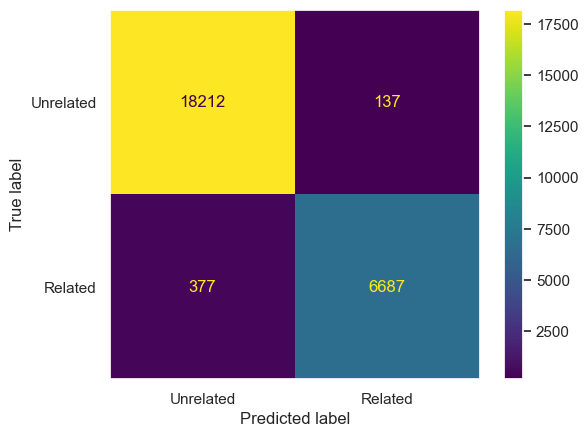

[2023-04-21 10:40:12] Classification Report:
[2023-04-21 10:40:12]               precision    recall  f1-score   support

           0       0.98      0.99      0.99     18349
           1       0.98      0.95      0.96      7064

    accuracy                           0.98     25413
   macro avg       0.98      0.97      0.97     25413
weighted avg       0.98      0.98      0.98     25413

[2023-04-21 10:40:12] Finished test evaluation


In [83]:
model_trainer.train()

### Non-finetuned DistilRoberta

In [77]:
class TransformerMLPDummy(nn.Module):
    def __init__(self, transformer):
        super().__init__()
        self.transformer = transformer
        
    def forward(self, input_ids, mask):
        out = self.transformer(input_ids, attention_mask=mask)
        return out["logits"]

In [80]:
from transformers import AutoModelForSequenceClassification

transformer_with_head = AutoModelForSequenceClassification.from_pretrained(
    selected_transformer_name,
    num_labels=2
)

model_trainer = TransformerBasedModelTrainer(
    model_class=TransformerMLPDummy,
    model_transformer=transformer_with_head,
    model_freeze_transformer=True,
    model_config={},
    optimiser_class=optim.AdamW,
    optimiser_config={
        "lr": 5e-5
    },
    hf_scheduler_name="linear",
    hf_scheduler_config={
        "num_warmup_steps": 0,
        "num_training_steps": 3 * (len(train_dataset) + 1) // 8
    },
    loss_class=nn.CrossEntropyLoss,
    batch_size=8,
    max_epochs=3,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    label_names=list(labels2id.keys()),
    sampling_weight_fn=None,
    no_improvement_epochs_stop=1,
    eval_batch_size=None,
    loss_weights=None,
    device="cuda:0",
    excluded_freeze=["classifier.dense.weight", "classifier.dense.bias", "classifier.out_proj.weight", "classifier.out_proj.bias"]
)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.out_proj.bias

Transformer Frozen
Model Initialised
TransformerMLPDummy(
  (transformer): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): Rob

[2023-04-23 20:19:50] Starting epoch 1
[2023-04-23 20:19:50] Starting epoch training
[2023-04-23 20:19:50] Set model to train mode


  0%|          | 0/4955 [00:00<?, ?it/s]

[2023-04-23 20:19:54][1:40] Loss: 0.570
[2023-04-23 20:19:54][1:40] LR: 4.9862101439526434e-05
[2023-04-23 20:19:58][1:80] Loss: 0.586
[2023-04-23 20:19:58][1:80] LR: 4.9727566258576616e-05
[2023-04-23 20:20:01][1:120] Loss: 0.621
[2023-04-23 20:20:01][1:120] LR: 4.95930310776268e-05
[2023-04-23 20:20:05][1:160] Loss: 0.593
[2023-04-23 20:20:05][1:160] LR: 4.945849589667698e-05
[2023-04-23 20:20:08][1:200] Loss: 0.601
[2023-04-23 20:20:08][1:200] LR: 4.932396071572716e-05
[2023-04-23 20:20:12][1:240] Loss: 0.552
[2023-04-23 20:20:12][1:240] LR: 4.918942553477734e-05
[2023-04-23 20:20:16][1:280] Loss: 0.610
[2023-04-23 20:20:16][1:280] LR: 4.9054890353827525e-05
[2023-04-23 20:20:19][1:320] Loss: 0.596
[2023-04-23 20:20:19][1:320] LR: 4.892035517287771e-05
[2023-04-23 20:20:23][1:360] Loss: 0.573
[2023-04-23 20:20:23][1:360] LR: 4.878581999192789e-05
[2023-04-23 20:20:26][1:400] Loss: 0.583
[2023-04-23 20:20:26][1:400] LR: 4.865128481097807e-05
[2023-04-23 20:20:30][1:440] Loss: 0.567
[

  0%|          | 0/1292 [00:00<?, ?it/s]

[2023-04-23 20:29:02] Set model to train mode


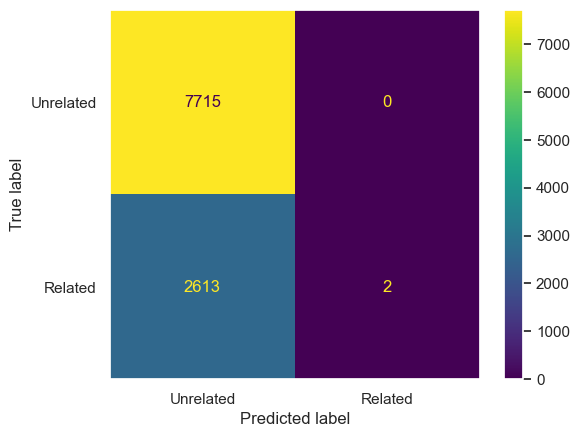

[2023-04-23 20:29:06] Classification Report:
[2023-04-23 20:29:06]               precision    recall  f1-score   support

           0       0.75      1.00      0.86      7715
           1       1.00      0.00      0.00      2615

    accuracy                           0.75     10330
   macro avg       0.87      0.50      0.43     10330
weighted avg       0.81      0.75      0.64     10330

[2023-04-23 20:29:06] Epoch Accuracy {'accuracy': 0.7470474346563407}
[2023-04-23 20:29:06] Finished validation evaluation
[2023-04-23 20:29:06] Beat best validation loss, new validation loss: 0.5367998285882244 (surpassed 1000000000.0 from epoch -1)
[2023-04-23 20:29:08] Saved best model
[2023-04-23 20:29:08] Logged to wandb
[2023-04-23 20:29:08] Starting epoch 2
[2023-04-23 20:29:08] Starting epoch training
[2023-04-23 20:29:08] Set model to train mode


  0%|          | 0/4955 [00:00<?, ?it/s]

[2023-04-23 20:29:12][2:40] Loss: 0.570
[2023-04-23 20:29:12][2:40] LR: 3.319655589936769e-05
[2023-04-23 20:29:15][2:80] Loss: 0.546
[2023-04-23 20:29:15][2:80] LR: 3.306202071841787e-05
[2023-04-23 20:29:19][2:120] Loss: 0.545
[2023-04-23 20:29:19][2:120] LR: 3.292748553746805e-05
[2023-04-23 20:29:22][2:160] Loss: 0.535
[2023-04-23 20:29:22][2:160] LR: 3.2792950356518233e-05
[2023-04-23 20:29:26][2:200] Loss: 0.522
[2023-04-23 20:29:26][2:200] LR: 3.2658415175568415e-05
[2023-04-23 20:29:30][2:240] Loss: 0.574
[2023-04-23 20:29:30][2:240] LR: 3.25238799946186e-05
[2023-04-23 20:29:33][2:280] Loss: 0.586
[2023-04-23 20:29:33][2:280] LR: 3.238934481366878e-05
[2023-04-23 20:29:37][2:320] Loss: 0.527
[2023-04-23 20:29:37][2:320] LR: 3.225480963271896e-05
[2023-04-23 20:29:40][2:360] Loss: 0.535
[2023-04-23 20:29:40][2:360] LR: 3.2120274451769136e-05
[2023-04-23 20:29:44][2:400] Loss: 0.524
[2023-04-23 20:29:44][2:400] LR: 3.198573927081932e-05
[2023-04-23 20:29:47][2:440] Loss: 0.576
[

  0%|          | 0/1292 [00:00<?, ?it/s]

[2023-04-23 20:38:30] Set model to train mode


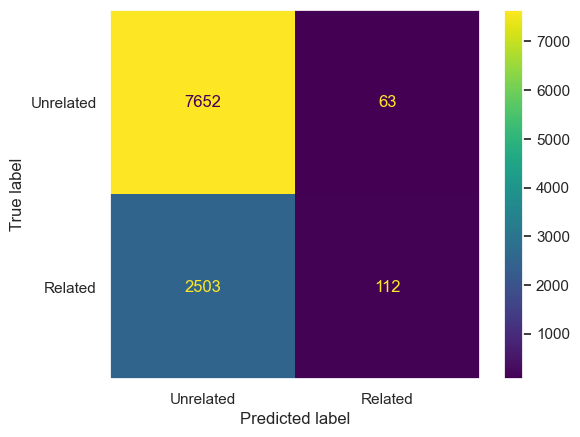

[2023-04-23 20:38:34] Classification Report:
[2023-04-23 20:38:34]               precision    recall  f1-score   support

           0       0.75      0.99      0.86      7715
           1       0.64      0.04      0.08      2615

    accuracy                           0.75     10330
   macro avg       0.70      0.52      0.47     10330
weighted avg       0.72      0.75      0.66     10330

[2023-04-23 20:38:34] Epoch Accuracy {'accuracy': 0.7515972894482091}
[2023-04-23 20:38:34] Finished validation evaluation
[2023-04-23 20:38:34] Beat best validation loss, new validation loss: 0.52863629653058 (surpassed 0.5367998285882244 from epoch 1)
[2023-04-23 20:38:35] Saved best model
[2023-04-23 20:38:35] Logged to wandb
[2023-04-23 20:38:35] Starting epoch 3
[2023-04-23 20:38:35] Starting epoch training
[2023-04-23 20:38:35] Set model to train mode


  0%|          | 0/4955 [00:00<?, ?it/s]

[2023-04-23 20:38:39][3:40] Loss: 0.575
[2023-04-23 20:38:39][3:40] LR: 1.6531010359208935e-05
[2023-04-23 20:38:43][3:80] Loss: 0.512
[2023-04-23 20:38:43][3:80] LR: 1.6396475178259117e-05
[2023-04-23 20:38:46][3:120] Loss: 0.547
[2023-04-23 20:38:46][3:120] LR: 1.62619399973093e-05
[2023-04-23 20:38:50][3:160] Loss: 0.571
[2023-04-23 20:38:50][3:160] LR: 1.612740481635948e-05
[2023-04-23 20:38:54][3:200] Loss: 0.532
[2023-04-23 20:38:54][3:200] LR: 1.599286963540966e-05
[2023-04-23 20:38:58][3:240] Loss: 0.538
[2023-04-23 20:38:58][3:240] LR: 1.585833445445984e-05
[2023-04-23 20:39:01][3:280] Loss: 0.538
[2023-04-23 20:39:01][3:280] LR: 1.5723799273510023e-05
[2023-04-23 20:39:05][3:320] Loss: 0.506
[2023-04-23 20:39:05][3:320] LR: 1.5589264092560204e-05
[2023-04-23 20:39:09][3:360] Loss: 0.539
[2023-04-23 20:39:09][3:360] LR: 1.5454728911610386e-05
[2023-04-23 20:39:12][3:400] Loss: 0.510
[2023-04-23 20:39:12][3:400] LR: 1.5320193730660568e-05
[2023-04-23 20:39:16][3:440] Loss: 0.52

  0%|          | 0/1292 [00:00<?, ?it/s]

[2023-04-23 20:47:57] Set model to train mode


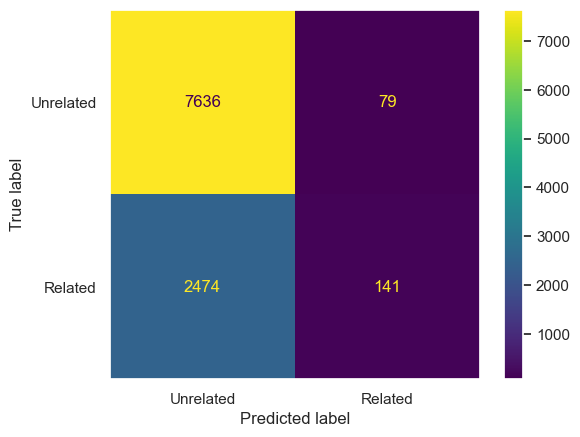

[2023-04-23 20:48:01] Classification Report:
[2023-04-23 20:48:01]               precision    recall  f1-score   support

           0       0.76      0.99      0.86      7715
           1       0.64      0.05      0.10      2615

    accuracy                           0.75     10330
   macro avg       0.70      0.52      0.48     10330
weighted avg       0.73      0.75      0.67     10330

[2023-04-23 20:48:01] Epoch Accuracy {'accuracy': 0.7528557599225557}
[2023-04-23 20:48:01] Finished validation evaluation
[2023-04-23 20:48:01] Beat best validation loss, new validation loss: 0.5234156931539992 (surpassed 0.52863629653058 from epoch 2)
[2023-04-23 20:48:02] Saved best model
[2023-04-23 20:48:02] Logged to wandb
[2023-04-23 20:48:02] Loading best model (epoch 0.5234156931539992) for evaluation
[2023-04-23 20:48:03] Starting test evaluation
[2023-04-23 20:48:03] Using model to generate predictions
[2023-04-23 20:48:03] Set model to eval mode


  0%|          | 0/3177 [00:00<?, ?it/s]

[2023-04-23 20:52:25] Set model to train mode


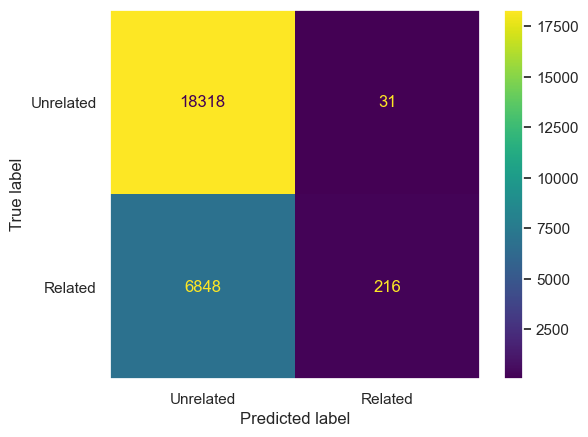

[2023-04-23 20:52:29] Classification Report:
[2023-04-23 20:52:29]               precision    recall  f1-score   support

           0       0.73      1.00      0.84     18349
           1       0.87      0.03      0.06      7064

    accuracy                           0.73     25413
   macro avg       0.80      0.51      0.45     25413
weighted avg       0.77      0.73      0.62     25413

[2023-04-23 20:52:29] Finished test evaluation


In [81]:
model_trainer.train()

### Finetuned DistilRoBERTa LSTM

In [76]:
class TransformerRNN(nn.Module):
    def __init__(self, transformer, rnn_type, stacked_layers, hidden_dim, output_dim, bidirectional, dropout_prob):
        super().__init__()
        
        self.transformer = transformer
        embedding_dim = transformer.config.to_dict()["hidden_size"]
        
        rnn_class = None
        
        if rnn_type.lower() == "lstm":
            rnn_class = nn.LSTM
        elif rnn_type.lower() == "gru":
            rnn_class = nn.GRU
        else:
            assert 1 == 0, "Invalid RNN type"
        
        self.rnn_type = rnn_type
        self.rnn = rnn_class(embedding_dim, hidden_dim, num_layers=stacked_layers, bidirectional=bidirectional, batch_first=True, dropout=dropout_prob)
        self.classifier = nn.Linear(hidden_dim * (1 + bidirectional), output_dim)
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, ids, mask):
        embeddings = self.transformer(input_ids=ids, attention_mask=mask)[0]
        
        if self.rnn_type == "gru":
            _, hidden_state = self.rnn(embeddings)
        else:
            _, (hidden_state, _) = self.rnn(embeddings)
        
        if self.rnn.bidirectional:
            hidden_state = self.dropout(torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim=1))
        else:
            hidden_state = self.dropout(hidden_state[-1,:,:])
        
        return self.classifier(hidden_state)

In [79]:
from transformers import AutoModelForSequenceClassification

transformer = AutoModel.from_pretrained(selected_transformer_name)

model_trainer = TransformerBasedModelTrainer(
    model_class=TransformerRNN,
    model_transformer=transformer,
    model_freeze_transformer=False,
    model_config={
        "rnn_type": "lstm",
        "stacked_layers": 2,
        "hidden_dim": 256,
        "output_dim": 2,
        "dropout_prob": 0.1,
        "bidirectional": True,
    },
    optimiser_class=optim.AdamW,
    optimiser_config={
        "lr": 5e-5
    },
    hf_scheduler_name="linear",
    hf_scheduler_config={
        "num_warmup_steps": 0,
        "num_training_steps": 4 * (len(train_dataset) + 1) // 8
    },
    loss_class=nn.CrossEntropyLoss,
    batch_size=8,
    max_epochs=4,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    label_names=list(labels2id.keys()),
    sampling_weight_fn=None,
    no_improvement_epochs_stop=1,
    eval_batch_size=None,
    loss_weights=None,
    device="cuda:0",
    excluded_freeze=None
)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model Initialised
TransformerRNN(
  (transformer): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

[2023-04-22 10:38:11] Starting epoch 1
[2023-04-22 10:38:11] Starting epoch training
[2023-04-22 10:38:11] Set model to train mode


  0%|          | 0/4916 [00:00<?, ?it/s]

[2023-04-22 10:38:28][1:40] Loss: 0.507
[2023-04-22 10:38:28][1:40] LR: 4.9895769778320116e-05
[2023-04-22 10:38:42][1:80] Loss: 0.296
[2023-04-22 10:38:42][1:80] LR: 4.9794081757169006e-05
[2023-04-22 10:38:55][1:120] Loss: 0.218
[2023-04-22 10:38:55][1:120] LR: 4.96923937360179e-05
[2023-04-22 10:39:08][1:160] Loss: 0.265
[2023-04-22 10:39:08][1:160] LR: 4.959070571486679e-05
[2023-04-22 10:39:22][1:200] Loss: 0.109
[2023-04-22 10:39:22][1:200] LR: 4.948901769371568e-05
[2023-04-22 10:39:35][1:240] Loss: 0.192
[2023-04-22 10:39:35][1:240] LR: 4.938732967256458e-05
[2023-04-22 10:39:48][1:280] Loss: 0.127
[2023-04-22 10:39:48][1:280] LR: 4.9285641651413466e-05
[2023-04-22 10:40:02][1:320] Loss: 0.087
[2023-04-22 10:40:02][1:320] LR: 4.9183953630262356e-05
[2023-04-22 10:40:15][1:360] Loss: 0.052
[2023-04-22 10:40:15][1:360] LR: 4.908226560911125e-05
[2023-04-22 10:40:29][1:400] Loss: 0.124
[2023-04-22 10:40:29][1:400] LR: 4.898057758796014e-05
[2023-04-22 10:40:42][1:440] Loss: 0.124


  0%|          | 0/1330 [00:00<?, ?it/s]

[2023-04-22 11:07:38] Set model to train mode


Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--accuracy\f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Fri Mar 31 21:15:28 2023) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--precision\4e7f439a346715f68500ce6f2be82bf3272abd3f20bdafd203a2c4f85b61dd5f (last modified on Fri Mar 31 21:16:47 2023) since it couldn't be found locally at evaluate-metric--precision, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--recall\e40e6e98d18ff3f210f4d0b26fa721bfaa80704b1fdf890fa551cfabf94fc185 (last modified on Fri Mar 31 21:38:10 2023) since it couldn't be found locally at

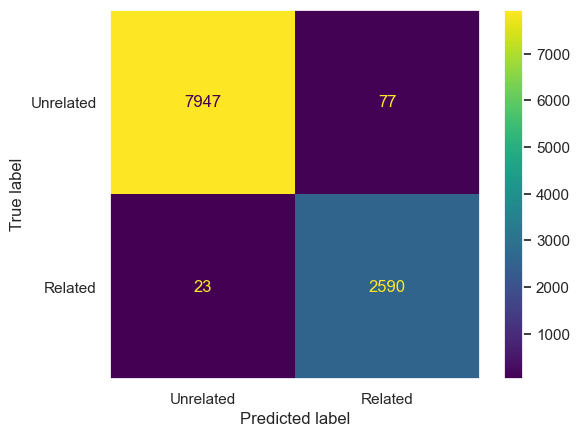

[2023-04-22 11:07:47] Classification Report:
[2023-04-22 11:07:47]               precision    recall  f1-score   support

           0       1.00      0.99      0.99      8024
           1       0.97      0.99      0.98      2613

    accuracy                           0.99     10637
   macro avg       0.98      0.99      0.99     10637
weighted avg       0.99      0.99      0.99     10637

[2023-04-22 11:07:47] Epoch Accuracy {'accuracy': 0.9905988530600733}
[2023-04-22 11:07:47] Finished validation evaluation
[2023-04-22 11:07:47] Beat best validation loss, new validation loss: 0.03645899902869023 (surpassed 1000000000.0 from epoch -1)
[2023-04-22 11:07:48] Saved best model
[2023-04-22 11:07:48] Logged to wandb
[2023-04-22 11:07:48] Starting epoch 2
[2023-04-22 11:07:48] Starting epoch training
[2023-04-22 11:07:48] Set model to train mode


  0%|          | 0/4916 [00:00<?, ?it/s]

[2023-04-22 11:08:02][2:40] Loss: 0.003
[2023-04-22 11:08:02][2:40] LR: 3.739831197884889e-05
[2023-04-22 11:08:15][2:80] Loss: 0.052
[2023-04-22 11:08:15][2:80] LR: 3.729662395769778e-05
[2023-04-22 11:08:28][2:120] Loss: 0.029
[2023-04-22 11:08:28][2:120] LR: 3.719493593654668e-05
[2023-04-22 11:08:41][2:160] Loss: 0.024
[2023-04-22 11:08:41][2:160] LR: 3.709324791539557e-05
[2023-04-22 11:08:55][2:200] Loss: 0.006
[2023-04-22 11:08:55][2:200] LR: 3.699155989424446e-05
[2023-04-22 11:09:08][2:240] Loss: 0.101
[2023-04-22 11:09:08][2:240] LR: 3.6889871873093354e-05
[2023-04-22 11:09:21][2:280] Loss: 0.009
[2023-04-22 11:09:21][2:280] LR: 3.678818385194224e-05
[2023-04-22 11:09:35][2:320] Loss: 0.012
[2023-04-22 11:09:35][2:320] LR: 3.668649583079113e-05
[2023-04-22 11:09:48][2:360] Loss: 0.025
[2023-04-22 11:09:48][2:360] LR: 3.658480780964003e-05
[2023-04-22 11:10:01][2:400] Loss: 0.024
[2023-04-22 11:10:01][2:400] LR: 3.648311978848892e-05
[2023-04-22 11:10:15][2:440] Loss: 0.019
[2

  0%|          | 0/1330 [00:00<?, ?it/s]

[2023-04-22 11:37:22] Set model to train mode


Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--accuracy\f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Fri Mar 31 21:15:28 2023) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--precision\4e7f439a346715f68500ce6f2be82bf3272abd3f20bdafd203a2c4f85b61dd5f (last modified on Fri Mar 31 21:16:47 2023) since it couldn't be found locally at evaluate-metric--precision, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--recall\e40e6e98d18ff3f210f4d0b26fa721bfaa80704b1fdf890fa551cfabf94fc185 (last modified on Fri Mar 31 21:38:10 2023) since it couldn't be found locally at

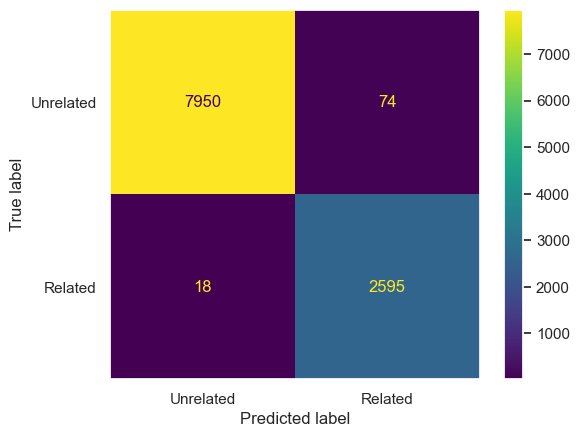

[2023-04-22 11:37:30] Classification Report:
[2023-04-22 11:37:30]               precision    recall  f1-score   support

           0       1.00      0.99      0.99      8024
           1       0.97      0.99      0.98      2613

    accuracy                           0.99     10637
   macro avg       0.99      0.99      0.99     10637
weighted avg       0.99      0.99      0.99     10637

[2023-04-22 11:37:31] Epoch Accuracy {'accuracy': 0.9913509448152674}
[2023-04-22 11:37:31] Finished validation evaluation
[2023-04-22 11:37:31] Beat best validation loss, new validation loss: 0.03235409486346144 (surpassed 0.03645899902869023 from epoch 1)
[2023-04-22 11:37:32] Saved best model
[2023-04-22 11:37:32] Logged to wandb
[2023-04-22 11:37:32] Starting epoch 3
[2023-04-22 11:37:32] Starting epoch training
[2023-04-22 11:37:32] Set model to train mode


  0%|          | 0/4916 [00:00<?, ?it/s]

[2023-04-22 11:37:45][3:40] Loss: 0.004
[2023-04-22 11:37:45][3:40] LR: 2.490085417937767e-05
[2023-04-22 11:37:58][3:80] Loss: 0.001
[2023-04-22 11:37:58][3:80] LR: 2.4799166158226563e-05
[2023-04-22 11:38:11][3:120] Loss: 0.001
[2023-04-22 11:38:11][3:120] LR: 2.4697478137075452e-05
[2023-04-22 11:38:24][3:160] Loss: 0.001
[2023-04-22 11:38:24][3:160] LR: 2.4595790115924345e-05
[2023-04-22 11:38:37][3:200] Loss: 0.001
[2023-04-22 11:38:37][3:200] LR: 2.4494102094773234e-05
[2023-04-22 11:38:50][3:240] Loss: 0.001
[2023-04-22 11:38:50][3:240] LR: 2.4392414073622127e-05
[2023-04-22 11:39:04][3:280] Loss: 0.009
[2023-04-22 11:39:04][3:280] LR: 2.429072605247102e-05
[2023-04-22 11:39:17][3:320] Loss: 0.007
[2023-04-22 11:39:17][3:320] LR: 2.418903803131991e-05
[2023-04-22 11:39:30][3:360] Loss: 0.002
[2023-04-22 11:39:30][3:360] LR: 2.4087350010168802e-05
[2023-04-22 11:39:43][3:400] Loss: 0.001
[2023-04-22 11:39:43][3:400] LR: 2.3985661989017695e-05
[2023-04-22 11:39:57][3:440] Loss: 0.

  0%|          | 0/1330 [00:00<?, ?it/s]

[2023-04-22 12:06:59] Set model to train mode


Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--accuracy\f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Fri Mar 31 21:15:28 2023) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--precision\4e7f439a346715f68500ce6f2be82bf3272abd3f20bdafd203a2c4f85b61dd5f (last modified on Fri Mar 31 21:16:47 2023) since it couldn't be found locally at evaluate-metric--precision, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--recall\e40e6e98d18ff3f210f4d0b26fa721bfaa80704b1fdf890fa551cfabf94fc185 (last modified on Fri Mar 31 21:38:10 2023) since it couldn't be found locally at

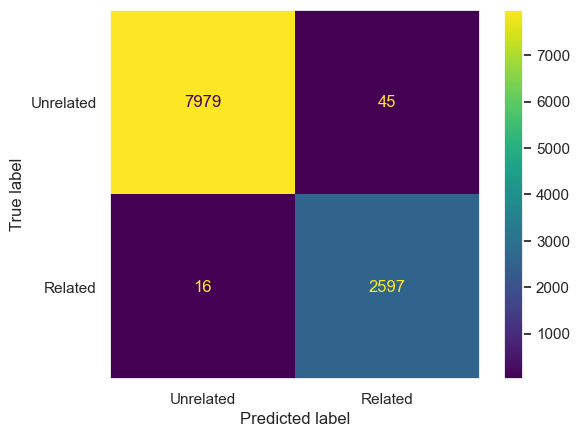

[2023-04-22 12:07:08] Classification Report:
[2023-04-22 12:07:08]               precision    recall  f1-score   support

           0       1.00      0.99      1.00      8024
           1       0.98      0.99      0.99      2613

    accuracy                           0.99     10637
   macro avg       0.99      0.99      0.99     10637
weighted avg       0.99      0.99      0.99     10637

[2023-04-22 12:07:08] Epoch Accuracy {'accuracy': 0.9942653003666447}
[2023-04-22 12:07:08] Finished validation evaluation
[2023-04-22 12:07:08] Beat best validation loss, new validation loss: 0.019768979896685038 (surpassed 0.03235409486346144 from epoch 2)
[2023-04-22 12:07:10] Saved best model
[2023-04-22 12:07:10] Logged to wandb
[2023-04-22 12:07:10] Starting epoch 4
[2023-04-22 12:07:10] Starting epoch training
[2023-04-22 12:07:10] Set model to train mode


  0%|          | 0/4916 [00:00<?, ?it/s]

[2023-04-22 12:07:23][4:40] Loss: 0.006
[2023-04-22 12:07:23][4:40] LR: 1.2403396379906447e-05
[2023-04-22 12:07:37][4:80] Loss: 0.010
[2023-04-22 12:07:37][4:80] LR: 1.230170835875534e-05
[2023-04-22 12:07:50][4:120] Loss: 0.002
[2023-04-22 12:07:50][4:120] LR: 1.220002033760423e-05
[2023-04-22 12:08:03][4:160] Loss: 0.000
[2023-04-22 12:08:03][4:160] LR: 1.2098332316453122e-05
[2023-04-22 12:08:17][4:200] Loss: 0.001
[2023-04-22 12:08:17][4:200] LR: 1.1996644295302013e-05
[2023-04-22 12:08:30][4:240] Loss: 0.000
[2023-04-22 12:08:30][4:240] LR: 1.1894956274150906e-05
[2023-04-22 12:08:44][4:280] Loss: 0.004
[2023-04-22 12:08:44][4:280] LR: 1.1793268252999799e-05
[2023-04-22 12:08:57][4:320] Loss: 0.005
[2023-04-22 12:08:57][4:320] LR: 1.169158023184869e-05
[2023-04-22 12:09:10][4:360] Loss: 0.010
[2023-04-22 12:09:10][4:360] LR: 1.1589892210697581e-05
[2023-04-22 12:09:24][4:400] Loss: 0.001
[2023-04-22 12:09:24][4:400] LR: 1.1488204189546472e-05
[2023-04-22 12:09:37][4:440] Loss: 0.

  0%|          | 0/1330 [00:00<?, ?it/s]

[2023-04-22 12:36:41] Set model to train mode


Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--accuracy\f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Fri Mar 31 21:15:28 2023) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--precision\4e7f439a346715f68500ce6f2be82bf3272abd3f20bdafd203a2c4f85b61dd5f (last modified on Fri Mar 31 21:16:47 2023) since it couldn't be found locally at evaluate-metric--precision, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--recall\e40e6e98d18ff3f210f4d0b26fa721bfaa80704b1fdf890fa551cfabf94fc185 (last modified on Fri Mar 31 21:38:10 2023) since it couldn't be found locally at

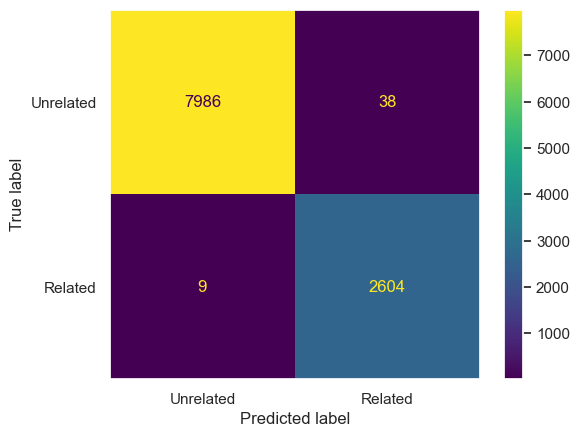

[2023-04-22 12:36:50] Classification Report:
[2023-04-22 12:36:50]               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8024
           1       0.99      1.00      0.99      2613

    accuracy                           1.00     10637
   macro avg       0.99      1.00      0.99     10637
weighted avg       1.00      1.00      1.00     10637

[2023-04-22 12:36:50] Epoch Accuracy {'accuracy': 0.9955814609382345}
[2023-04-22 12:36:50] Finished validation evaluation
[2023-04-22 12:36:50] Beat best validation loss, new validation loss: 0.019726535428764378 (surpassed 0.019768979896685038 from epoch 3)
[2023-04-22 12:36:51] Saved best model
[2023-04-22 12:36:51] Logged to wandb
[2023-04-22 12:36:51] Loading best model (epoch 0.019726535428764378) for evaluation
[2023-04-22 12:36:52] Starting test evaluation
[2023-04-22 12:36:52] Using model to generate predictions
[2023-04-22 12:36:52] Set model to eval mode


  0%|          | 0/3177 [00:00<?, ?it/s]

[2023-04-22 12:42:37] Set model to train mode


Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--accuracy\f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Fri Mar 31 21:15:28 2023) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--precision\4e7f439a346715f68500ce6f2be82bf3272abd3f20bdafd203a2c4f85b61dd5f (last modified on Fri Mar 31 21:16:47 2023) since it couldn't be found locally at evaluate-metric--precision, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--recall\e40e6e98d18ff3f210f4d0b26fa721bfaa80704b1fdf890fa551cfabf94fc185 (last modified on Fri Mar 31 21:38:10 2023) since it couldn't be found locally at

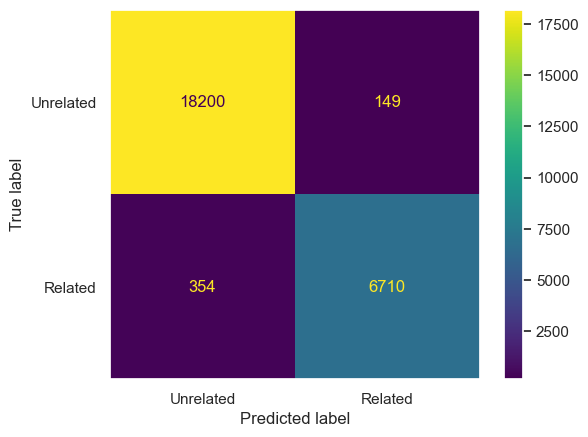

[2023-04-22 12:42:45] Classification Report:
[2023-04-22 12:42:45]               precision    recall  f1-score   support

           0       0.98      0.99      0.99     18349
           1       0.98      0.95      0.96      7064

    accuracy                           0.98     25413
   macro avg       0.98      0.97      0.98     25413
weighted avg       0.98      0.98      0.98     25413

[2023-04-22 12:42:45] Finished test evaluation


In [80]:
model_trainer.train()

### Finetuned DistilBERT

In [65]:
class TransformerMLPDummy(nn.Module):
    def __init__(self, transformer):
        super().__init__()
        self.transformer = transformer
        
    def forward(self, input_ids, mask):
        out = self.transformer(input_ids, attention_mask=mask)
        return out["logits"]

In [78]:
from transformers import AutoModelForSequenceClassification

transformer_with_head = AutoModelForSequenceClassification.from_pretrained(
    selected_transformer_name,
    num_labels=2
)

# print(transformer)

# transformer = AutoModel.from_pretrained(selected_transformer_name)

model_trainer = TransformerBasedModelTrainer(
    model_class=TransformerMLPDummy,
    model_transformer=transformer_with_head,
    model_freeze_transformer=False,
    model_config={},
    optimiser_class=optim.AdamW,
    optimiser_config={
        "lr": 5e-5
    },
    hf_scheduler_name="linear",
    hf_scheduler_config={
        "num_warmup_steps": 0,
        "num_training_steps": 3 * (len(train_dataset) + 1) // 2
    },
    loss_class=nn.CrossEntropyLoss,
    batch_size=8,
    max_epochs=3,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    label_names=list(labels2id.keys()),
    sampling_weight_fn=None,
    no_improvement_epochs_stop=1,
    eval_batch_size=None,
    loss_weights=None,
    device="cuda:0",
    excluded_freeze=None
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

Model Initialised
TransformerMLPDummy(
  (transformer): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_aff

[2023-04-21 12:02:40] Starting epoch 1
[2023-04-21 12:02:40] Starting epoch training
[2023-04-21 12:02:40] Set model to train mode


  0%|          | 0/5106 [00:00<?, ?it/s]

[2023-04-21 12:02:53][1:40] Loss: 0.632
[2023-04-21 12:02:53][1:40] LR: 4.996654590554522e-05
[2023-04-21 12:03:03][1:80] Loss: 0.486
[2023-04-21 12:03:03][1:80] LR: 4.9933907764613727e-05
[2023-04-21 12:03:14][1:120] Loss: 0.253
[2023-04-21 12:03:14][1:120] LR: 4.990126962368224e-05
[2023-04-21 12:03:24][1:160] Loss: 0.291
[2023-04-21 12:03:24][1:160] LR: 4.9868631482750745e-05
[2023-04-21 12:03:35][1:200] Loss: 0.190
[2023-04-21 12:03:35][1:200] LR: 4.9835993341819254e-05
[2023-04-21 12:03:45][1:240] Loss: 0.151
[2023-04-21 12:03:45][1:240] LR: 4.980335520088776e-05
[2023-04-21 12:03:56][1:280] Loss: 0.080
[2023-04-21 12:03:56][1:280] LR: 4.9770717059956266e-05
[2023-04-21 12:04:06][1:320] Loss: 0.135
[2023-04-21 12:04:06][1:320] LR: 4.9738078919024775e-05
[2023-04-21 12:04:17][1:360] Loss: 0.185
[2023-04-21 12:04:17][1:360] LR: 4.9705440778093284e-05
[2023-04-21 12:04:27][1:400] Loss: 0.055
[2023-04-21 12:04:27][1:400] LR: 4.9672802637161793e-05
[2023-04-21 12:04:38][1:440] Loss: 0.

  0%|          | 0/1141 [00:00<?, ?it/s]

[2023-04-21 12:26:39] Set model to train mode


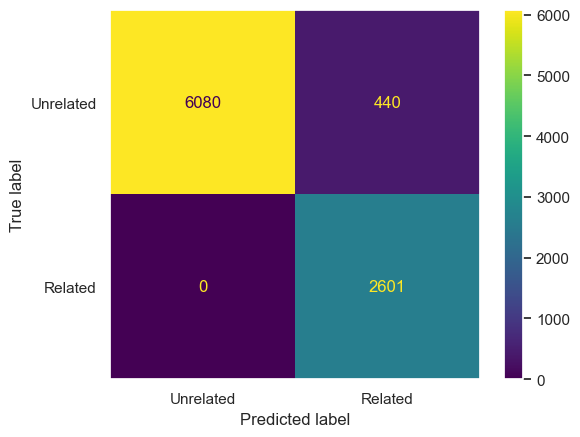

[2023-04-21 12:26:43] Classification Report:
[2023-04-21 12:26:43]               precision    recall  f1-score   support

           0       1.00      0.93      0.97      6520
           1       0.86      1.00      0.92      2601

    accuracy                           0.95      9121
   macro avg       0.93      0.97      0.94      9121
weighted avg       0.96      0.95      0.95      9121

[2023-04-21 12:26:43] Epoch Accuracy {'accuracy': 0.9517596754741805}
[2023-04-21 12:26:43] Finished validation evaluation
[2023-04-21 12:26:43] Beat best validation loss, new validation loss: 0.11822136568857376 (surpassed 1000000000.0 from epoch -1)
[2023-04-21 12:26:44] Saved best model
[2023-04-21 12:26:44] Logged to wandb
[2023-04-21 12:26:44] Starting epoch 2
[2023-04-21 12:26:44] Starting epoch training
[2023-04-21 12:26:44] Set model to train mode


  0%|          | 0/5106 [00:00<?, ?it/s]

[2023-04-21 12:26:54][2:40] Loss: 0.040
[2023-04-21 12:26:54][2:40] LR: 4.5800287215640196e-05
[2023-04-21 12:27:05][2:80] Loss: 0.014
[2023-04-21 12:27:05][2:80] LR: 4.5767649074708705e-05
[2023-04-21 12:27:15][2:120] Loss: 0.055
[2023-04-21 12:27:15][2:120] LR: 4.5735010933777214e-05
[2023-04-21 12:27:26][2:160] Loss: 0.042
[2023-04-21 12:27:26][2:160] LR: 4.5702372792845724e-05
[2023-04-21 12:27:36][2:200] Loss: 0.014
[2023-04-21 12:27:36][2:200] LR: 4.566973465191423e-05
[2023-04-21 12:27:47][2:240] Loss: 0.029
[2023-04-21 12:27:47][2:240] LR: 4.5637096510982735e-05
[2023-04-21 12:27:57][2:280] Loss: 0.031
[2023-04-21 12:27:57][2:280] LR: 4.5604458370051244e-05
[2023-04-21 12:28:07][2:320] Loss: 0.021
[2023-04-21 12:28:07][2:320] LR: 4.557182022911975e-05
[2023-04-21 12:28:18][2:360] Loss: 0.046
[2023-04-21 12:28:18][2:360] LR: 4.5539182088188256e-05
[2023-04-21 12:28:28][2:400] Loss: 0.027
[2023-04-21 12:28:28][2:400] LR: 4.550654394725677e-05
[2023-04-21 12:28:39][2:440] Loss: 0.

  0%|          | 0/1141 [00:00<?, ?it/s]

[2023-04-21 12:50:31] Set model to train mode


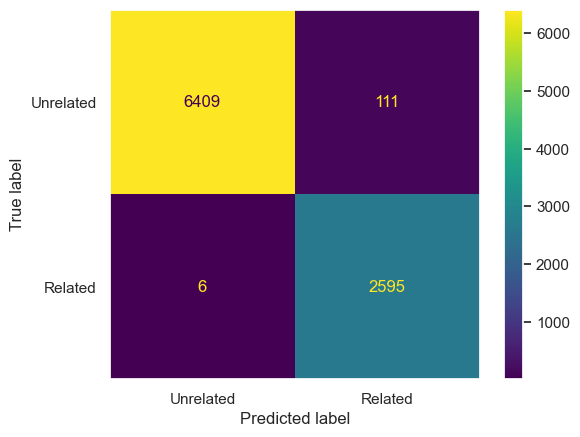

[2023-04-21 12:50:35] Classification Report:
[2023-04-21 12:50:35]               precision    recall  f1-score   support

           0       1.00      0.98      0.99      6520
           1       0.96      1.00      0.98      2601

    accuracy                           0.99      9121
   macro avg       0.98      0.99      0.98      9121
weighted avg       0.99      0.99      0.99      9121

[2023-04-21 12:50:35] Epoch Accuracy {'accuracy': 0.9871724591601798}
[2023-04-21 12:50:35] Finished validation evaluation
[2023-04-21 12:50:35] Beat best validation loss, new validation loss: 0.051140935673324533 (surpassed 0.11822136568857376 from epoch 1)
[2023-04-21 12:50:36] Saved best model
[2023-04-21 12:50:36] Logged to wandb
[2023-04-21 12:50:36] Starting epoch 3
[2023-04-21 12:50:36] Starting epoch training
[2023-04-21 12:50:36] Set model to train mode


  0%|          | 0/5106 [00:00<?, ?it/s]

[2023-04-21 12:50:47][3:40] Loss: 0.001
[2023-04-21 12:50:47][3:40] LR: 4.1634028525735174e-05
[2023-04-21 12:50:57][3:80] Loss: 0.029
[2023-04-21 12:50:57][3:80] LR: 4.1601390384803684e-05
[2023-04-21 12:51:08][3:120] Loss: 0.025
[2023-04-21 12:51:08][3:120] LR: 4.1568752243872186e-05
[2023-04-21 12:51:18][3:160] Loss: 0.002
[2023-04-21 12:51:18][3:160] LR: 4.1536114102940695e-05
[2023-04-21 12:51:29][3:200] Loss: 0.022
[2023-04-21 12:51:29][3:200] LR: 4.150347596200921e-05
[2023-04-21 12:51:39][3:240] Loss: 0.012
[2023-04-21 12:51:39][3:240] LR: 4.1470837821077714e-05
[2023-04-21 12:51:49][3:280] Loss: 0.024
[2023-04-21 12:51:49][3:280] LR: 4.143819968014622e-05
[2023-04-21 12:52:00][3:320] Loss: 0.024
[2023-04-21 12:52:00][3:320] LR: 4.1405561539214725e-05
[2023-04-21 12:52:10][3:360] Loss: 0.002
[2023-04-21 12:52:10][3:360] LR: 4.1372923398283235e-05
[2023-04-21 12:52:21][3:400] Loss: 0.002
[2023-04-21 12:52:21][3:400] LR: 4.1340285257351744e-05
[2023-04-21 12:52:31][3:440] Loss: 0

KeyboardInterrupt: 

In [79]:
model_trainer.train()

### Non-Finetuned DistilBERT

In [83]:
class TransformerMLPDummy(nn.Module):
    def __init__(self, transformer):
        super().__init__()
        self.transformer = transformer
        
    def forward(self, input_ids, mask):
        out = self.transformer(input_ids, attention_mask=mask)
        return out["logits"]

In [84]:
from transformers import AutoModelForSequenceClassification

transformer_with_head = AutoModelForSequenceClassification.from_pretrained(
    selected_transformer_name,
    num_labels=2
)

model_trainer = TransformerBasedModelTrainer(
    model_class=TransformerMLPDummy,
    model_transformer=transformer_with_head,
    model_freeze_transformer=True,
    model_config={},
    optimiser_class=optim.AdamW,
    optimiser_config={
        "lr": 5e-5
    },
    hf_scheduler_name="linear",
    hf_scheduler_config={
        "num_warmup_steps": 0,
        "num_training_steps": 3 * (len(train_dataset) + 1) // 2
    },
    loss_class=nn.CrossEntropyLoss,
    batch_size=8,
    max_epochs=3,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    label_names=list(labels2id.keys()),
    sampling_weight_fn=None,
    no_improvement_epochs_stop=1,
    eval_batch_size=None,
    loss_weights=None,
    device="cuda:0",
    excluded_freeze=["pre_classifier.weight", "pre_classifier.bias", "classifier.weight", "classifier.bias"]
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

Transformer Frozen
Model Initialised
TransformerMLPDummy(
  (transformer): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-

[2023-04-21 13:12:45] Starting epoch 1
[2023-04-21 13:12:45] Starting epoch training
[2023-04-21 13:12:45] Set model to train mode


  0%|          | 0/5106 [00:00<?, ?it/s]

[2023-04-21 13:12:49][1:40] Loss: 0.617
[2023-04-21 13:12:49][1:40] LR: 4.996654590554522e-05
[2023-04-21 13:12:53][1:80] Loss: 0.550
[2023-04-21 13:12:53][1:80] LR: 4.9933907764613727e-05
[2023-04-21 13:12:56][1:120] Loss: 0.539
[2023-04-21 13:12:56][1:120] LR: 4.990126962368224e-05
[2023-04-21 13:13:00][1:160] Loss: 0.618
[2023-04-21 13:13:00][1:160] LR: 4.9868631482750745e-05
[2023-04-21 13:13:03][1:200] Loss: 0.577
[2023-04-21 13:13:03][1:200] LR: 4.9835993341819254e-05
[2023-04-21 13:13:07][1:240] Loss: 0.546
[2023-04-21 13:13:07][1:240] LR: 4.980335520088776e-05
[2023-04-21 13:13:11][1:280] Loss: 0.595
[2023-04-21 13:13:11][1:280] LR: 4.9770717059956266e-05
[2023-04-21 13:13:14][1:320] Loss: 0.553
[2023-04-21 13:13:14][1:320] LR: 4.9738078919024775e-05
[2023-04-21 13:13:18][1:360] Loss: 0.579
[2023-04-21 13:13:18][1:360] LR: 4.9705440778093284e-05
[2023-04-21 13:13:21][1:400] Loss: 0.548
[2023-04-21 13:13:21][1:400] LR: 4.9672802637161793e-05
[2023-04-21 13:13:25][1:440] Loss: 0.

  0%|          | 0/1141 [00:00<?, ?it/s]

[2023-04-21 13:21:59] Set model to train mode


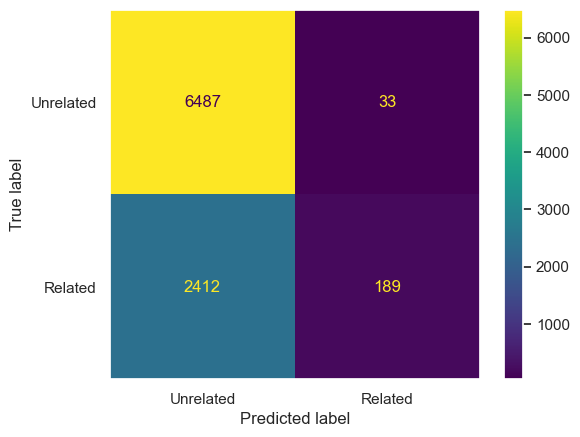

[2023-04-21 13:22:02] Classification Report:
[2023-04-21 13:22:02]               precision    recall  f1-score   support

           0       0.73      0.99      0.84      6520
           1       0.85      0.07      0.13      2601

    accuracy                           0.73      9121
   macro avg       0.79      0.53      0.49      9121
weighted avg       0.76      0.73      0.64      9121

[2023-04-21 13:22:02] Epoch Accuracy {'accuracy': 0.7319372875781164}
[2023-04-21 13:22:02] Finished validation evaluation
[2023-04-21 13:22:02] Beat best validation loss, new validation loss: 0.5052287105885542 (surpassed 1000000000.0 from epoch -1)
[2023-04-21 13:22:03] Saved best model
[2023-04-21 13:22:03] Logged to wandb
[2023-04-21 13:22:03] Starting epoch 2
[2023-04-21 13:22:03] Starting epoch training
[2023-04-21 13:22:03] Set model to train mode


  0%|          | 0/5106 [00:00<?, ?it/s]

[2023-04-21 13:22:07][2:40] Loss: 0.555
[2023-04-21 13:22:07][2:40] LR: 4.5800287215640196e-05
[2023-04-21 13:22:10][2:80] Loss: 0.421
[2023-04-21 13:22:10][2:80] LR: 4.5767649074708705e-05
[2023-04-21 13:22:14][2:120] Loss: 0.475
[2023-04-21 13:22:14][2:120] LR: 4.5735010933777214e-05
[2023-04-21 13:22:17][2:160] Loss: 0.507
[2023-04-21 13:22:17][2:160] LR: 4.5702372792845724e-05
[2023-04-21 13:22:21][2:200] Loss: 0.459
[2023-04-21 13:22:21][2:200] LR: 4.566973465191423e-05
[2023-04-21 13:22:25][2:240] Loss: 0.514
[2023-04-21 13:22:25][2:240] LR: 4.5637096510982735e-05
[2023-04-21 13:22:28][2:280] Loss: 0.466
[2023-04-21 13:22:28][2:280] LR: 4.5604458370051244e-05
[2023-04-21 13:22:32][2:320] Loss: 0.517
[2023-04-21 13:22:32][2:320] LR: 4.557182022911975e-05
[2023-04-21 13:22:35][2:360] Loss: 0.523
[2023-04-21 13:22:35][2:360] LR: 4.5539182088188256e-05
[2023-04-21 13:22:39][2:400] Loss: 0.474
[2023-04-21 13:22:39][2:400] LR: 4.550654394725677e-05
[2023-04-21 13:22:42][2:440] Loss: 0.

  0%|          | 0/1141 [00:00<?, ?it/s]

[2023-04-21 13:31:11] Set model to train mode


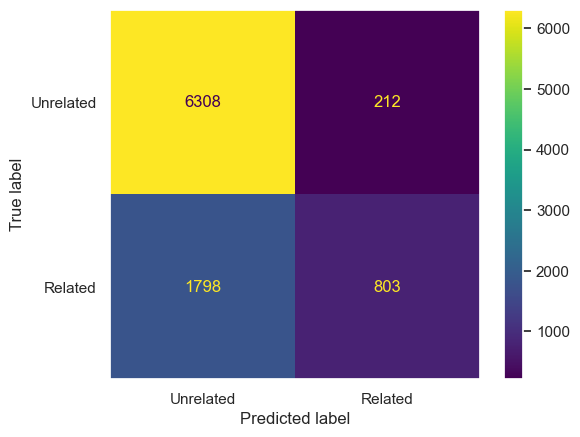

[2023-04-21 13:31:14] Classification Report:
[2023-04-21 13:31:14]               precision    recall  f1-score   support

           0       0.78      0.97      0.86      6520
           1       0.79      0.31      0.44      2601

    accuracy                           0.78      9121
   macro avg       0.78      0.64      0.65      9121
weighted avg       0.78      0.78      0.74      9121

[2023-04-21 13:31:14] Epoch Accuracy {'accuracy': 0.7796294265979608}
[2023-04-21 13:31:14] Finished validation evaluation
[2023-04-21 13:31:14] Beat best validation loss, new validation loss: 0.4489997146515654 (surpassed 0.5052287105885542 from epoch 1)
[2023-04-21 13:31:16] Saved best model
[2023-04-21 13:31:16] Logged to wandb
[2023-04-21 13:31:16] Starting epoch 3
[2023-04-21 13:31:16] Starting epoch training
[2023-04-21 13:31:16] Set model to train mode


  0%|          | 0/5106 [00:00<?, ?it/s]

[2023-04-21 13:31:20][3:40] Loss: 0.428
[2023-04-21 13:31:20][3:40] LR: 4.1634028525735174e-05
[2023-04-21 13:31:23][3:80] Loss: 0.442
[2023-04-21 13:31:23][3:80] LR: 4.1601390384803684e-05
[2023-04-21 13:31:27][3:120] Loss: 0.451
[2023-04-21 13:31:27][3:120] LR: 4.1568752243872186e-05
[2023-04-21 13:31:30][3:160] Loss: 0.494
[2023-04-21 13:31:30][3:160] LR: 4.1536114102940695e-05
[2023-04-21 13:31:34][3:200] Loss: 0.413
[2023-04-21 13:31:34][3:200] LR: 4.150347596200921e-05
[2023-04-21 13:31:37][3:240] Loss: 0.469
[2023-04-21 13:31:37][3:240] LR: 4.1470837821077714e-05
[2023-04-21 13:31:41][3:280] Loss: 0.454
[2023-04-21 13:31:41][3:280] LR: 4.143819968014622e-05
[2023-04-21 13:31:44][3:320] Loss: 0.469
[2023-04-21 13:31:44][3:320] LR: 4.1405561539214725e-05
[2023-04-21 13:31:48][3:360] Loss: 0.447
[2023-04-21 13:31:48][3:360] LR: 4.1372923398283235e-05
[2023-04-21 13:31:52][3:400] Loss: 0.454
[2023-04-21 13:31:52][3:400] LR: 4.1340285257351744e-05
[2023-04-21 13:31:55][3:440] Loss: 0

  0%|          | 0/1141 [00:00<?, ?it/s]

[2023-04-21 13:40:24] Set model to train mode


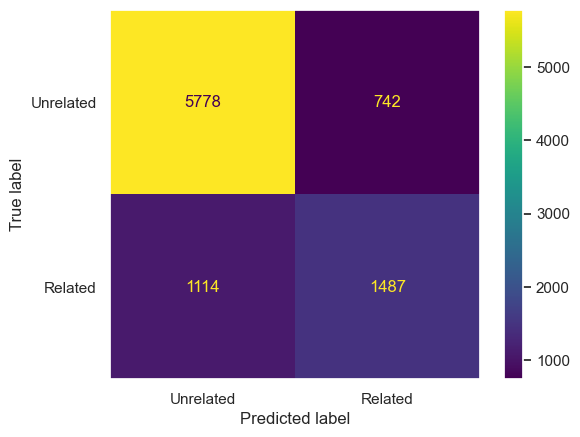

[2023-04-21 13:40:27] Classification Report:
[2023-04-21 13:40:27]               precision    recall  f1-score   support

           0       0.84      0.89      0.86      6520
           1       0.67      0.57      0.62      2601

    accuracy                           0.80      9121
   macro avg       0.75      0.73      0.74      9121
weighted avg       0.79      0.80      0.79      9121

[2023-04-21 13:40:27] Epoch Accuracy {'accuracy': 0.7965135401819976}
[2023-04-21 13:40:27] Finished validation evaluation
[2023-04-21 13:40:27] Beat best validation loss, new validation loss: 0.43557059473956394 (surpassed 0.4489997146515654 from epoch 2)
[2023-04-21 13:40:28] Saved best model
[2023-04-21 13:40:28] Logged to wandb
[2023-04-21 13:40:28] Loading best model (epoch 0.43557059473956394) for evaluation
[2023-04-21 13:40:28] Starting test evaluation
[2023-04-21 13:40:28] Using model to generate predictions
[2023-04-21 13:40:28] Set model to eval mode


  0%|          | 0/3177 [00:00<?, ?it/s]

[2023-04-21 13:44:53] Set model to train mode


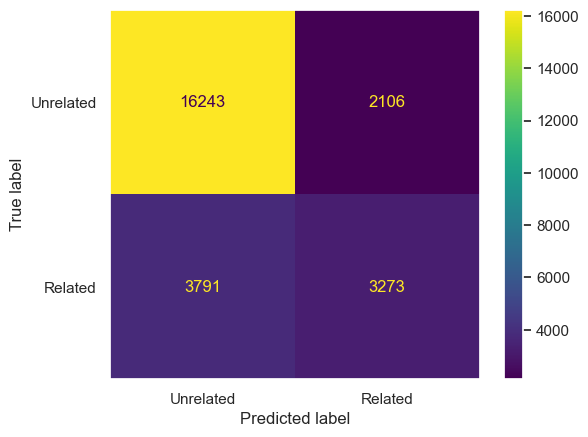

[2023-04-21 13:44:56] Classification Report:
[2023-04-21 13:44:56]               precision    recall  f1-score   support

           0       0.81      0.89      0.85     18349
           1       0.61      0.46      0.53      7064

    accuracy                           0.77     25413
   macro avg       0.71      0.67      0.69     25413
weighted avg       0.75      0.77      0.76     25413

[2023-04-21 13:44:56] Finished test evaluation


In [85]:
model_trainer.train()

# Part 2.b: Stance Classification

## Dataset Preparation

In [76]:
labels2id = {
    "agree": 0,
    "disagree": 1,
    "discuss": 2
}

In [77]:
train_df = transformer_train_df.copy(deep=True)
val_df = transformer_val_df.copy(deep=True)
test_df = transformer_test_df.copy(deep=True)

In [78]:
train_df = train_df[train_df["Related"] == True]
val_df = val_df[val_df["Related"] == True]
test_df = test_df[test_df["Related"] == True]

In [79]:
train_labels = np.array([labels2id[x] for x in train_df["Stance"].values])
train_labels_tensor = torch.LongTensor(train_labels).unsqueeze(1)
train_labels_tensor.shape

torch.Size([10723, 1])

In [80]:
val_labels = np.array([labels2id[x] for x in val_df["Stance"].values])
val_labels_tensor = torch.LongTensor(val_labels).unsqueeze(1)
val_labels_tensor.shape

torch.Size([2704, 1])

In [81]:
test_labels = np.array([labels2id[x] for x in test_df["Stance"].values])
test_labels_tensor = torch.LongTensor(test_labels).unsqueeze(1)
test_labels_tensor.shape

torch.Size([7064, 1])

In [82]:
train_transformer_input_ids = torch.concat(list(train_df["input_ids"].values))
train_transformer_attention_masks = torch.concat(list(train_df["attention_mask"].values))
train_dataset = TransformerTokenDataset(train_transformer_input_ids, train_transformer_attention_masks, train_labels_tensor)

In [83]:
val_transformer_input_ids = torch.concat(list(val_df["input_ids"].values))
val_transformer_attention_masks = torch.concat(list(val_df["attention_mask"].values))
val_dataset = TransformerTokenDataset(val_transformer_input_ids, val_transformer_attention_masks, val_labels_tensor)

In [84]:
test_transformer_input_ids = torch.concat(list(test_df["input_ids"].values))
test_transformer_attention_masks = torch.concat(list(test_df["attention_mask"].values))
test_dataset = TransformerTokenDataset(test_transformer_input_ids, test_transformer_attention_masks, test_labels_tensor)

## Reset CUDA

In [96]:
1/0

ZeroDivisionError: division by zero

In [97]:
import gc

# model_trainer.model = None

model_trainer = None
bert = None

gc.collect()

with torch.no_grad():
    torch.cuda.empty_cache()

## Training

### Finetune DistilRoBERTa Head

In [92]:
from transformers import default_data_collator

class TransformerBasedModelTrainer:
    def __init__(
        self, 
        model_class,
        model_transformer,
        model_freeze_transformer,
        model_config,
        optimiser_class,
        optimiser_config,
        hf_scheduler_name,
        hf_scheduler_config,
        loss_class,
        batch_size,
        max_epochs,
        train_dataset,
        val_dataset,
        test_dataset,
        label_names,
        sampling_weight_fn,
        no_improvement_epochs_stop=3,
        eval_batch_size=None,
        loss_weights=None,
        device="cuda:0",
        excluded_freeze=None
    ):
        excluded_freeze_layers = excluded_freeze if excluded_freeze is not None else []
        
        for name, param in model_transformer.named_parameters():
            if name in excluded_freeze_layers:
                param.requires_grad = True
                continue
                
            param.requires_grad = not model_freeze_transformer
        
        if model_freeze_transformer:
            print("Transformer Frozen")
        
        self.model = model_class(model_transformer, **model_config).to(device)
        print("Model Initialised")
        
        print(self.model)
        
        self.optimiser = optimiser_class(self.model.parameters(), **optimiser_config)
        print("Model Initialised")
        
        if loss_weights is not None:
            assert False, "Need to implement!"

        if hf_scheduler_name is not None:
            self.scheduler = transformers.get_scheduler(hf_scheduler_name, self.optimiser, **hf_scheduler_config)
        else:
            self.scheduler = None
        
        self.loss_fn = loss_class().to(device)
        print("Loss Initialised")
        
        self.batch_size = batch_size
        self.eval_batch_size = eval_batch_size if eval_batch_size is not None else batch_size
        
        self.max_epochs = max_epochs
        self.no_improvement_epochs_stop = no_improvement_epochs_stop
        
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.test_dataset = test_dataset
        
        if sampling_weight_fn is not None:
            train_sampler = WeightedDatasetSampler(train_dataset, label_weights=sampling_weight_fn)
            self.sampling_weights = train_sampler.label_sample_distribution
            print("Train Data Sampler Initialised")

            self.train_dataloader = torch.utils.data.DataLoader(train_dataset, collate_fn=default_data_collator, batch_size=self.batch_size, drop_last=True, sampler=train_sampler)
        else:
            self.sampling_weights = None
            self.train_dataloader = torch.utils.data.DataLoader(train_dataset, collate_fn=default_data_collator, batch_size=self.batch_size, drop_last=True, shuffle=True)
        
        print("Dataloaders Initialised")
        
        self.label_names = label_names
        self.device = device
        self.is_trained = False
        
        self.high_level_name = f"{model_class.__qualname__}/{time.time()}"
        self.save_folder = f"./runs/{self.high_level_name}"
        os.makedirs(self.save_folder)
        
        save_config = {
            "model": {
                "model_class": model_class.__qualname__,
                "model_transformer": model_transformer.__class__.__qualname__,
                "model_freeze_transformer": model_freeze_transformer,
                "model_config": model_config,
                "model_trainable_layers": [name for name, param in self.model.named_parameters() if param.requires_grad]
            },
            "loss": {
                "loss_class": loss_class.__qualname__,
                "loss_weights": loss_weights
            },
            "optimiser": {
                "optimiser_class": optimiser_class.__qualname__,
                "optimiser_config": optimiser_config,
                "scheduler_name": hf_scheduler_name,
                "scheduler_config": hf_scheduler_config
            },
            "datasets": {
                "train_size": len(train_dataset),
                "val_size": len(val_dataset),
                "test_size": len(test_dataset),
                "sampling_weights": self.sampling_weights
            },
            "train_settings": {
                "max_epochs": max_epochs,
                "batch_size": batch_size,
                "no_improvement_epochs_stop": no_improvement_epochs_stop,
                "label_names": label_names
            }
        }
        
        with open(f"{self.save_folder}/info.json", "w+") as fp:
            json.dump(save_config, fp, indent=2)
        
        print("Dumped Config")
        
        # wandb.init(
        #     project=self.high_level_name.replace("/", "_"),
        #     config=save_config
        # )
        
        self._stored_log = []
        
        self._best_validation_loss = 1e9
        self._best_validation_epoch = -1

    def _log(self, msg):
        message = f"[{datetime.today().strftime('%Y-%m-%d %H:%M:%S')}]"
        
        if msg.startswith("["):
            message += msg
        else:
            message = f"{message} {msg}"
        
        self._stored_log.append(message)
        print(message)
    
    def _save_log(self, file_name):
        loc = f"{self.save_folder}/{file_name}"
        
        with open(loc, "w+") as fp:
            fp.write("\n".join(self._stored_log))
        
        self._stored_log = []
    
    def train(self):
        if self.is_trained:
            assert False, "Model already trained"
        
        self.is_trained = True
        
        for epoch in range(1, self.max_epochs + 1):
            self._log(f"Starting epoch {epoch}")
            
            self._log("Starting epoch training")
            epoch_loss = self._train_epoch(epoch)
            self._log("Finished epoch training")

            self._log(f"Epoch Loss: {epoch_loss}")
            
            self._log("Starting validation evaluation")
            validation_results = self.evaluate_model(self.val_dataset, f"{epoch}_validation_set")
            self._log(f"Epoch Accuracy {validation_results['evaluate']['accuracy']}")
            self._log("Finished validation evaluation")
            
            if validation_results["avg_validation_loss"] < self._best_validation_loss:
                self._log(f"Beat best validation loss, new validation loss: {validation_results['avg_validation_loss']} (surpassed {self._best_validation_loss} from epoch {self._best_validation_epoch})")
                self._best_validation_epoch = epoch
                self._best_validation_loss = validation_results["avg_validation_loss"]
                
                torch.save(self.model.state_dict(), f"{self.save_folder}/{epoch}_model.pth")
                
                self._log(f"Saved best model")
            elif epoch - self._best_validation_epoch >= self.no_improvement_epochs_stop:
                self._log(f"Early stopping triggered, best validation loss achieved at {self._best_validation_epoch} (loss: {self._best_validation_loss})")
                self._save_log(f"log_epoch_{epoch}.txt")
                break
                
            # wandb.log({"val_acc": validation_results["accuracy"], "train_loss": epoch_loss, "val_loss": validation_results["avg_validation_loss"]})
            
            self._log("Logged to wandb")
            self._save_log(f"log_epoch_{epoch}.txt")
            
        self._log(f"Loading best model (epoch {self._best_validation_loss}) for evaluation")
        self.model.load_state_dict(torch.load(f"{self.save_folder}/{self._best_validation_epoch}_model.pth"))
        self.model.to(self.device)
        self.model.eval()
        
        self._log("Starting test evaluation")
        test_results = self.evaluate_model(self.test_dataset, f"final_test_set")
        self._log("Finished test evaluation")
        
        self._save_log(f"log_final_evaluation.txt")
        
    def _train_epoch(self, epoch):
        self.model.train()
        self._log("Set model to train mode")
        
        epoch_st = time.time()
        epoch_loss = 0

        batch_acc_loss = 0

        for batch_no, batch in enumerate(tqdm(self.train_dataloader)):
            tokens = batch["input_ids"].to(self.device)
            attention_masks = batch["attention_mask"].to(self.device)
            labels = batch["labels"].to(self.device).squeeze()
            
            # print out tokens, am, labels?

            logits = self.model(tokens, attention_masks)
            # print("T", logits.shape, labels.shape)
            loss = self.loss_fn(logits, labels)

            self.optimiser.zero_grad()
            loss.backward()
            self.optimiser.step()

            if self.scheduler is not None:
                self.scheduler.step()

            epoch_loss += loss.item()
            batch_acc_loss += loss.item()

            if batch_no != 0 and batch_no % 40 == 0:
                self._log(f"[{epoch}:{batch_no}] Loss: {(batch_acc_loss / 40):.3f}")
                self._log(f"[{epoch}:{batch_no}] LR: {self.scheduler.get_last_lr()[0]}")
                batch_acc_loss = 0

        epoch_dt = time.time() - epoch_st
        self._log(f"[{epoch}:END] Took {epoch_dt:.3f}s")
        self._log(f"[{epoch}:END] Training Loss: {(epoch_loss / len(self.train_dataloader)):.3f}")
        
        return epoch_loss / len(self.train_dataloader)
    
    def evaluate_model(self, dataset, base_save_name=None):
        results = self._evaluate_model(dataset) 
        
        ConfusionMatrixDisplay.from_predictions(results["y_true"], results["y_pred"], display_labels=self.label_names)
        plt.grid(False)
        
        if base_save_name is not None:
            plt.savefig(f"{self.save_folder}/{base_save_name}_confusion_matrix.png", bbox_inches="tight")
        
        plt.show()
        
        self._log("Classification Report:")
        self._log(classification_report(results["y_true"], results["y_pred"]))
        
        if base_save_name is not None:
            saveable_results = {k: v for k, v in results.items() if k not in ["y_true", "y_pred"]}
            
            saveable_results["y_pred"] = list(results["y_pred"])
            saveable_results["y_true"] = list(results["y_true"].detach().squeeze().cpu().numpy())
            
            with open(f"{self.save_folder}/{base_save_name}_results.json", "w+") as fp:
                json.dump(saveable_results, fp, indent=2, default=lambda o: str(o))
        
        return results
        
    def _evaluate_model(self, dataset):
        y_true = dataset.labels
        y_logits = np.empty((len(y_true), len(self.label_names)))
        y_pred = np.empty(len(y_true))
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.eval_batch_size, collate_fn=default_data_collator)
        
        self._log("Using model to generate predictions")
        
        with torch.inference_mode():
            self.model.eval()
            self._log("Set model to eval mode")

            total_loss = 0

            for i, batch in enumerate(tqdm(dataloader)):
                upper = ((i + 1) if i + 1 < len(dataloader) else len(dataloader)) * self.eval_batch_size

                tokens = batch["input_ids"].to(self.device)
                attention_masks = batch["attention_mask"].to(self.device)
                labels = batch["labels"].to(self.device).squeeze(-1)

                logits = self.model(tokens, attention_masks)
                
                # print("E", logits.shape, labels.shape, labels.squeeze().shape)
                
                y_logits[i * self.eval_batch_size : upper] = logits.cpu().numpy()
                
                loss = self.loss_fn(logits, labels)

                pred = torch.argmax(logits, 1)
                y_pred[i * self.eval_batch_size : upper] = pred.cpu().numpy()
                
                total_loss += loss.item()

            self.model.train()
            self._log("Set model to train mode")
        
        # y_true = y_true[:32]
        # y_pred = y_pred[:32]
        
        report = classification_report(y_true, y_pred, output_dict=True)
        
        probs = softmax(y_logits, axis=-1)
        
        accuracy = evaluate.load("accuracy").compute(predictions=y_pred, references=y_true)
        precision = evaluate.load("precision").compute(predictions=y_pred, references=y_true, average="weighted")
        recall = evaluate.load("recall").compute(predictions=y_pred, references=y_true, average="weighted")
        f1 = evaluate.load("f1").compute(predictions=y_pred, references=y_true, average="weighted")
        
        if len(self.label_names) == 2:
            roc_auc = roc_auc_score(y_true, y_pred)
        else:
            roc_auc = evaluate.load("roc_auc", "multiclass").compute(prediction_scores=probs, references=y_true.squeeze(), average="weighted", multi_class="ovr")
            
        mcc = evaluate.load("matthews_correlation").compute(predictions=y_pred, references=y_true)
        kappa = cohen_kappa_score(y_true, y_pred)
        
        results = {
            "y_true": y_true,
            "y_pred": y_pred,
            "evaluate": {
                "accuracy": accuracy,
                "precision": precision,
                "recall": recall,
                "f1": f1,
                "roc_auc": roc_auc,
                "mcc": mcc,
                "kappa": kappa
            },
            "accuracy": (y_true.squeeze().numpy() == y_pred).mean() * 100,
            "avg_validation_loss": total_loss / len(dataloader),
            "classification_report": report
        }

        return results

In [93]:
class TransformerMLPDummy(nn.Module):
    def __init__(self, transformer):
        super().__init__()
        self.transformer = transformer
        
    def forward(self, input_ids, mask):
        out = self.transformer(input_ids, attention_mask=mask)
        return out["logits"]

In [94]:
from transformers import AutoModelForSequenceClassification

transformer_with_head = AutoModelForSequenceClassification.from_pretrained(
    selected_transformer_name,
    num_labels=3
)

# print(transformer)

# transformer = AutoModel.from_pretrained(selected_transformer_name)

model_trainer = TransformerBasedModelTrainer(
    model_class=TransformerMLPDummy,
    model_transformer=transformer_with_head,
    model_freeze_transformer=False,
    model_config={},
    optimiser_class=optim.AdamW,
    optimiser_config={
        "lr": 5e-5
    },
    hf_scheduler_name="linear",
    hf_scheduler_config={
        "num_warmup_steps": 0,
        "num_training_steps": 3 * (len(train_dataset) + 1) // 8
    },
    loss_class=nn.CrossEntropyLoss,
    batch_size=8,
    max_epochs=3,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    label_names=list(labels2id.keys()),
    sampling_weight_fn=None,
    no_improvement_epochs_stop=1,
    eval_batch_size=None,
    loss_weights=None,
    device="cuda:0",
    excluded_freeze=["classifier.dense.weight", "classifier.dense.bias", "classifier.out_proj.weight", "classifier.out_proj.bias"]
)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.out_proj.bias

Model Initialised
TransformerMLPDummy(
  (transformer): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
   

[2023-04-22 13:08:20] Starting epoch 1
[2023-04-22 13:08:20] Starting epoch training
[2023-04-22 13:08:20] Set model to train mode


  0%|          | 0/1356 [00:00<?, ?it/s]

[2023-04-22 13:08:31][1:40] Loss: 0.811
[2023-04-22 13:08:31][1:40] LR: 4.949619071024822e-05
[2023-04-22 13:08:42][1:80] Loss: 0.673
[2023-04-22 13:08:42][1:80] LR: 4.90046694519538e-05
[2023-04-22 13:08:53][1:120] Loss: 0.670
[2023-04-22 13:08:53][1:120] LR: 4.851314819365938e-05
[2023-04-22 13:09:04][1:160] Loss: 0.704
[2023-04-22 13:09:04][1:160] LR: 4.802162693536496e-05
[2023-04-22 13:09:14][1:200] Loss: 0.582
[2023-04-22 13:09:14][1:200] LR: 4.7530105677070536e-05
[2023-04-22 13:09:25][1:240] Loss: 0.708
[2023-04-22 13:09:25][1:240] LR: 4.7038584418776115e-05
[2023-04-22 13:09:35][1:280] Loss: 0.626
[2023-04-22 13:09:35][1:280] LR: 4.6547063160481694e-05
[2023-04-22 13:09:46][1:320] Loss: 0.680
[2023-04-22 13:09:46][1:320] LR: 4.605554190218727e-05
[2023-04-22 13:09:57][1:360] Loss: 0.660
[2023-04-22 13:09:57][1:360] LR: 4.556402064389285e-05
[2023-04-22 13:10:07][1:400] Loss: 0.674
[2023-04-22 13:10:07][1:400] LR: 4.5072499385598423e-05
[2023-04-22 13:10:18][1:440] Loss: 0.625


  0%|          | 0/322 [00:00<?, ?it/s]

[2023-04-22 13:14:49] Set model to train mode


Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--accuracy\f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Fri Mar 31 21:15:28 2023) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--precision\4e7f439a346715f68500ce6f2be82bf3272abd3f20bdafd203a2c4f85b61dd5f (last modified on Fri Mar 31 21:16:47 2023) since it couldn't be found locally at evaluate-metric--precision, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--recall\e40e6e98d18ff3f210f4d0b26fa721bfaa80704b1fdf890fa551cfabf94fc185 (last modified on Fri Mar 31 21:38:10 2023) since it couldn't be found locally at

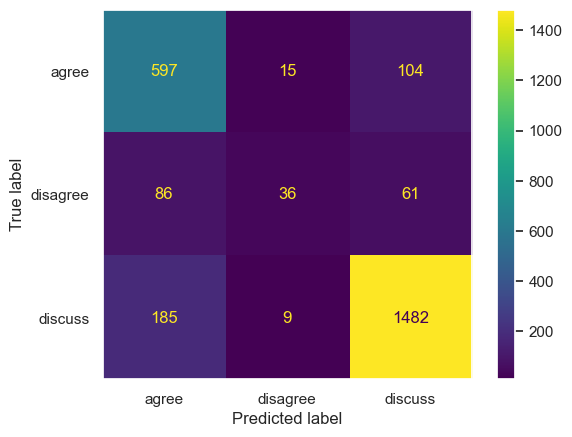

[2023-04-22 13:14:59] Classification Report:
[2023-04-22 13:14:59]               precision    recall  f1-score   support

           0       0.69      0.83      0.75       716
           1       0.60      0.20      0.30       183
           2       0.90      0.88      0.89      1676

    accuracy                           0.82      2575
   macro avg       0.73      0.64      0.65      2575
weighted avg       0.82      0.82      0.81      2575

[2023-04-22 13:14:59] Epoch Accuracy {'accuracy': 0.8213592233009709}
[2023-04-22 13:14:59] Finished validation evaluation
[2023-04-22 13:14:59] Beat best validation loss, new validation loss: 0.4864122164667069 (surpassed 1000000000.0 from epoch -1)
[2023-04-22 13:15:00] Saved best model
[2023-04-22 13:15:00] Logged to wandb
[2023-04-22 13:15:00] Starting epoch 2
[2023-04-22 13:15:00] Starting epoch training
[2023-04-22 13:15:00] Set model to train mode


  0%|          | 0/1356 [00:00<?, ?it/s]

[2023-04-22 13:15:11][2:40] Loss: 0.236
[2023-04-22 13:15:11][2:40] LR: 3.283362005406734e-05
[2023-04-22 13:15:22][2:80] Loss: 0.253
[2023-04-22 13:15:22][2:80] LR: 3.2342098795772917e-05
[2023-04-22 13:15:33][2:120] Loss: 0.288
[2023-04-22 13:15:33][2:120] LR: 3.1850577537478495e-05
[2023-04-22 13:15:43][2:160] Loss: 0.336
[2023-04-22 13:15:43][2:160] LR: 3.1359056279184074e-05
[2023-04-22 13:15:54][2:200] Loss: 0.260
[2023-04-22 13:15:54][2:200] LR: 3.086753502088965e-05
[2023-04-22 13:16:05][2:240] Loss: 0.310
[2023-04-22 13:16:05][2:240] LR: 3.0376013762595235e-05
[2023-04-22 13:16:15][2:280] Loss: 0.297
[2023-04-22 13:16:15][2:280] LR: 2.9884492504300814e-05
[2023-04-22 13:16:26][2:320] Loss: 0.250
[2023-04-22 13:16:26][2:320] LR: 2.939297124600639e-05
[2023-04-22 13:16:37][2:360] Loss: 0.232
[2023-04-22 13:16:37][2:360] LR: 2.8901449987711972e-05
[2023-04-22 13:16:47][2:400] Loss: 0.224
[2023-04-22 13:16:47][2:400] LR: 2.840992872941755e-05
[2023-04-22 13:16:58][2:440] Loss: 0.3

  0%|          | 0/322 [00:00<?, ?it/s]

[2023-04-22 13:21:29] Set model to train mode


Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--accuracy\f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Fri Mar 31 21:15:28 2023) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--precision\4e7f439a346715f68500ce6f2be82bf3272abd3f20bdafd203a2c4f85b61dd5f (last modified on Fri Mar 31 21:16:47 2023) since it couldn't be found locally at evaluate-metric--precision, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--recall\e40e6e98d18ff3f210f4d0b26fa721bfaa80704b1fdf890fa551cfabf94fc185 (last modified on Fri Mar 31 21:38:10 2023) since it couldn't be found locally at

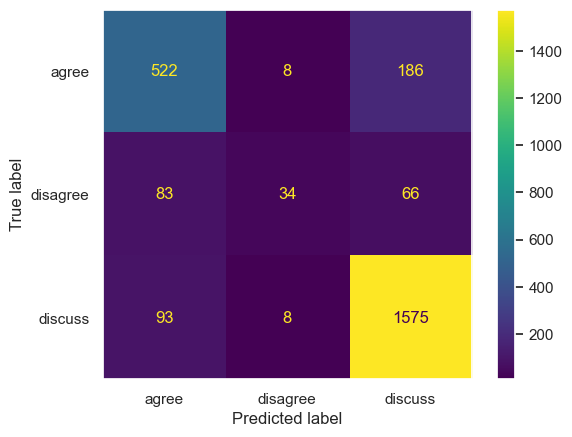

[2023-04-22 13:21:39] Classification Report:
[2023-04-22 13:21:39]               precision    recall  f1-score   support

           0       0.75      0.73      0.74       716
           1       0.68      0.19      0.29       183
           2       0.86      0.94      0.90      1676

    accuracy                           0.83      2575
   macro avg       0.76      0.62      0.64      2575
weighted avg       0.82      0.83      0.81      2575

[2023-04-22 13:21:39] Epoch Accuracy {'accuracy': 0.8275728155339805}
[2023-04-22 13:21:39] Finished validation evaluation
[2023-04-22 13:21:39] Early stopping triggered, best validation loss achieved at 1 (loss: 0.4864122164667069)
[2023-04-22 13:21:39] Loading best model (epoch 0.4864122164667069) for evaluation
[2023-04-22 13:21:39] Starting test evaluation
[2023-04-22 13:21:39] Using model to generate predictions
[2023-04-22 13:21:39] Set model to eval mode


  0%|          | 0/883 [00:00<?, ?it/s]

[2023-04-22 13:22:53] Set model to train mode


Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--accuracy\f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Fri Mar 31 21:15:28 2023) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--precision\4e7f439a346715f68500ce6f2be82bf3272abd3f20bdafd203a2c4f85b61dd5f (last modified on Fri Mar 31 21:16:47 2023) since it couldn't be found locally at evaluate-metric--precision, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--recall\e40e6e98d18ff3f210f4d0b26fa721bfaa80704b1fdf890fa551cfabf94fc185 (last modified on Fri Mar 31 21:38:10 2023) since it couldn't be found locally at

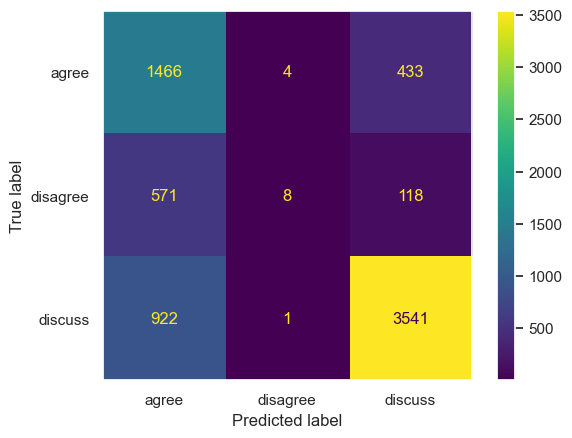

[2023-04-22 13:23:03] Classification Report:
[2023-04-22 13:23:03]               precision    recall  f1-score   support

           0       0.50      0.77      0.60      1903
           1       0.62      0.01      0.02       697
           2       0.87      0.79      0.83      4464

    accuracy                           0.71      7064
   macro avg       0.66      0.53      0.48      7064
weighted avg       0.74      0.71      0.69      7064

[2023-04-22 13:23:03] Finished test evaluation


In [95]:
model_trainer.train()

### Finetuned with Balanced Weighting

In [96]:
class TransformerMLPDummy(nn.Module):
    def __init__(self, transformer):
        super().__init__()
        self.transformer = transformer
        
    def forward(self, input_ids, mask):
        out = self.transformer(input_ids, attention_mask=mask)
        return out["logits"]

In [97]:
from transformers import AutoModelForSequenceClassification

transformer_with_head = AutoModelForSequenceClassification.from_pretrained(
    selected_transformer_name,
    num_labels=3
)

# print(transformer)

# transformer = AutoModel.from_pretrained(selected_transformer_name)

model_trainer = TransformerBasedModelTrainer(
    model_class=TransformerMLPDummy,
    model_transformer=transformer_with_head,
    model_freeze_transformer=False,
    model_config={},
    optimiser_class=optim.AdamW,
    optimiser_config={
        "lr": 5e-5
    },
    hf_scheduler_name="linear",
    hf_scheduler_config={
        "num_warmup_steps": 0,
        "num_training_steps": 3 * (len(train_dataset) + 1) // 8
    },
    loss_class=nn.CrossEntropyLoss,
    batch_size=8,
    max_epochs=3,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    label_names=list(labels2id.keys()),
    sampling_weight_fn="balanced",
    no_improvement_epochs_stop=1,
    eval_batch_size=None,
    loss_weights=None,
    device="cuda:0",
    excluded_freeze=["classifier.dense.weight", "classifier.dense.bias", "classifier.out_proj.weight", "classifier.out_proj.bias"]
)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.out_proj.bias

Model Initialised
TransformerMLPDummy(
  (transformer): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
   

[2023-04-22 13:25:17] Starting epoch 1
[2023-04-22 13:25:17] Starting epoch training
[2023-04-22 13:25:17] Set model to train mode


  0%|          | 0/1356 [00:00<?, ?it/s]

[2023-04-22 13:25:28][1:40] Loss: 0.793
[2023-04-22 13:25:28][1:40] LR: 4.949619071024822e-05
[2023-04-22 13:25:38][1:80] Loss: 0.668
[2023-04-22 13:25:38][1:80] LR: 4.90046694519538e-05
[2023-04-22 13:25:49][1:120] Loss: 0.672
[2023-04-22 13:25:49][1:120] LR: 4.851314819365938e-05
[2023-04-22 13:26:00][1:160] Loss: 0.530
[2023-04-22 13:26:00][1:160] LR: 4.802162693536496e-05
[2023-04-22 13:26:10][1:200] Loss: 0.582
[2023-04-22 13:26:10][1:200] LR: 4.7530105677070536e-05
[2023-04-22 13:26:21][1:240] Loss: 0.584
[2023-04-22 13:26:21][1:240] LR: 4.7038584418776115e-05
Class 1 exhausted, falling back to randomised sampling fromthe class
[2023-04-22 13:26:32][1:280] Loss: 0.777
[2023-04-22 13:26:32][1:280] LR: 4.6547063160481694e-05
[2023-04-22 13:26:42][1:320] Loss: 0.698
[2023-04-22 13:26:42][1:320] LR: 4.605554190218727e-05
[2023-04-22 13:26:53][1:360] Loss: 0.680
[2023-04-22 13:26:53][1:360] LR: 4.556402064389285e-05
[2023-04-22 13:27:03][1:400] Loss: 0.707
[2023-04-22 13:27:03][1:400]

  0%|          | 0/322 [00:00<?, ?it/s]

[2023-04-22 13:31:45] Set model to train mode


Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--accuracy\f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Fri Mar 31 21:15:28 2023) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--precision\4e7f439a346715f68500ce6f2be82bf3272abd3f20bdafd203a2c4f85b61dd5f (last modified on Fri Mar 31 21:16:47 2023) since it couldn't be found locally at evaluate-metric--precision, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--recall\e40e6e98d18ff3f210f4d0b26fa721bfaa80704b1fdf890fa551cfabf94fc185 (last modified on Fri Mar 31 21:38:10 2023) since it couldn't be found locally at

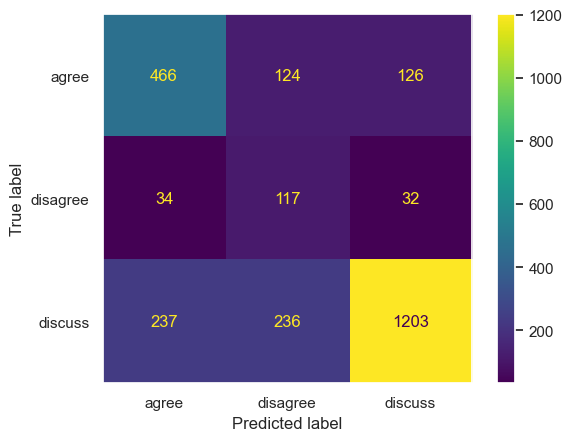

[2023-04-22 13:31:54] Classification Report:
[2023-04-22 13:31:54]               precision    recall  f1-score   support

           0       0.63      0.65      0.64       716
           1       0.25      0.64      0.35       183
           2       0.88      0.72      0.79      1676

    accuracy                           0.69      2575
   macro avg       0.59      0.67      0.60      2575
weighted avg       0.77      0.69      0.72      2575

[2023-04-22 13:31:54] Epoch Accuracy {'accuracy': 0.6935922330097087}
[2023-04-22 13:31:54] Finished validation evaluation
[2023-04-22 13:31:54] Beat best validation loss, new validation loss: 0.8809072506695014 (surpassed 1000000000.0 from epoch -1)
[2023-04-22 13:31:56] Saved best model
[2023-04-22 13:31:56] Logged to wandb
[2023-04-22 13:31:56] Starting epoch 2
[2023-04-22 13:31:56] Starting epoch training
[2023-04-22 13:31:56] Set model to train mode


  0%|          | 0/1356 [00:00<?, ?it/s]

[2023-04-22 13:32:07][2:40] Loss: 0.310
[2023-04-22 13:32:07][2:40] LR: 3.283362005406734e-05
[2023-04-22 13:32:18][2:80] Loss: 0.310
[2023-04-22 13:32:18][2:80] LR: 3.2342098795772917e-05
[2023-04-22 13:32:28][2:120] Loss: 0.330
[2023-04-22 13:32:28][2:120] LR: 3.1850577537478495e-05
[2023-04-22 13:32:39][2:160] Loss: 0.255
[2023-04-22 13:32:39][2:160] LR: 3.1359056279184074e-05
[2023-04-22 13:32:49][2:200] Loss: 0.271
[2023-04-22 13:32:49][2:200] LR: 3.086753502088965e-05
[2023-04-22 13:33:00][2:240] Loss: 0.209
[2023-04-22 13:33:00][2:240] LR: 3.0376013762595235e-05
Class 1 exhausted, falling back to randomised sampling fromthe class
[2023-04-22 13:33:11][2:280] Loss: 0.349
[2023-04-22 13:33:11][2:280] LR: 2.9884492504300814e-05
[2023-04-22 13:33:21][2:320] Loss: 0.356
[2023-04-22 13:33:21][2:320] LR: 2.939297124600639e-05
[2023-04-22 13:33:32][2:360] Loss: 0.220
[2023-04-22 13:33:32][2:360] LR: 2.8901449987711972e-05
[2023-04-22 13:33:43][2:400] Loss: 0.316
[2023-04-22 13:33:43][2:

  0%|          | 0/322 [00:00<?, ?it/s]

[2023-04-22 13:38:24] Set model to train mode


Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--accuracy\f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Fri Mar 31 21:15:28 2023) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--precision\4e7f439a346715f68500ce6f2be82bf3272abd3f20bdafd203a2c4f85b61dd5f (last modified on Fri Mar 31 21:16:47 2023) since it couldn't be found locally at evaluate-metric--precision, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--recall\e40e6e98d18ff3f210f4d0b26fa721bfaa80704b1fdf890fa551cfabf94fc185 (last modified on Fri Mar 31 21:38:10 2023) since it couldn't be found locally at

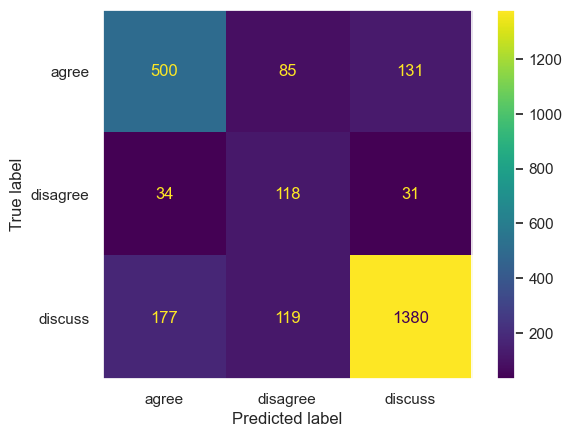

[2023-04-22 13:38:33] Classification Report:
[2023-04-22 13:38:33]               precision    recall  f1-score   support

           0       0.70      0.70      0.70       716
           1       0.37      0.64      0.47       183
           2       0.89      0.82      0.86      1676

    accuracy                           0.78      2575
   macro avg       0.65      0.72      0.68      2575
weighted avg       0.80      0.78      0.79      2575

[2023-04-22 13:38:33] Epoch Accuracy {'accuracy': 0.7759223300970873}
[2023-04-22 13:38:33] Finished validation evaluation
[2023-04-22 13:38:33] Beat best validation loss, new validation loss: 0.7693547844089227 (surpassed 0.8809072506695014 from epoch 1)
[2023-04-22 13:38:35] Saved best model
[2023-04-22 13:38:35] Logged to wandb
[2023-04-22 13:38:35] Starting epoch 3
[2023-04-22 13:38:35] Starting epoch training
[2023-04-22 13:38:35] Set model to train mode


  0%|          | 0/1356 [00:00<?, ?it/s]

[2023-04-22 13:38:46][3:40] Loss: 0.140
[2023-04-22 13:38:46][3:40] LR: 1.6171049397886458e-05
[2023-04-22 13:38:56][3:80] Loss: 0.088
[2023-04-22 13:38:56][3:80] LR: 1.5679528139592037e-05
[2023-04-22 13:39:07][3:120] Loss: 0.089
[2023-04-22 13:39:07][3:120] LR: 1.5188006881297618e-05
[2023-04-22 13:39:18][3:160] Loss: 0.113
[2023-04-22 13:39:18][3:160] LR: 1.4696485623003195e-05
[2023-04-22 13:39:28][3:200] Loss: 0.087
[2023-04-22 13:39:28][3:200] LR: 1.4204964364708775e-05
Class 1 exhausted, falling back to randomised sampling fromthe class
[2023-04-22 13:39:39][3:240] Loss: 0.134
[2023-04-22 13:39:39][3:240] LR: 1.3713443106414353e-05
[2023-04-22 13:39:50][3:280] Loss: 0.203
[2023-04-22 13:39:50][3:280] LR: 1.3221921848119931e-05
[2023-04-22 13:40:00][3:320] Loss: 0.101
[2023-04-22 13:40:00][3:320] LR: 1.2730400589825512e-05
[2023-04-22 13:40:11][3:360] Loss: 0.091
[2023-04-22 13:40:11][3:360] LR: 1.223887933153109e-05
[2023-04-22 13:40:22][3:400] Loss: 0.153
[2023-04-22 13:40:22][

  0%|          | 0/322 [00:00<?, ?it/s]

[2023-04-22 13:45:03] Set model to train mode


Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--accuracy\f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Fri Mar 31 21:15:28 2023) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--precision\4e7f439a346715f68500ce6f2be82bf3272abd3f20bdafd203a2c4f85b61dd5f (last modified on Fri Mar 31 21:16:47 2023) since it couldn't be found locally at evaluate-metric--precision, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--recall\e40e6e98d18ff3f210f4d0b26fa721bfaa80704b1fdf890fa551cfabf94fc185 (last modified on Fri Mar 31 21:38:10 2023) since it couldn't be found locally at

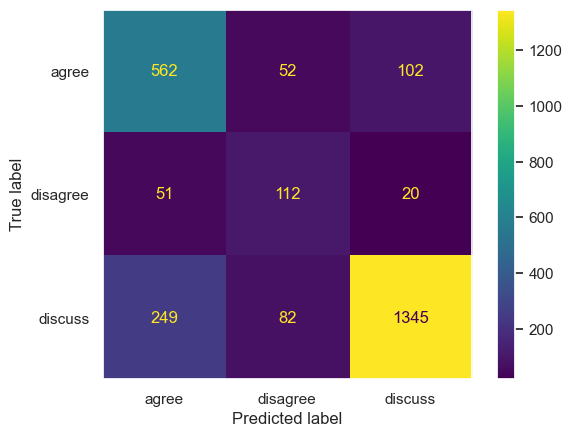

[2023-04-22 13:45:13] Classification Report:
[2023-04-22 13:45:13]               precision    recall  f1-score   support

           0       0.65      0.78      0.71       716
           1       0.46      0.61      0.52       183
           2       0.92      0.80      0.86      1676

    accuracy                           0.78      2575
   macro avg       0.67      0.73      0.70      2575
weighted avg       0.81      0.78      0.79      2575

[2023-04-22 13:45:13] Epoch Accuracy {'accuracy': 0.7840776699029126}
[2023-04-22 13:45:13] Finished validation evaluation
[2023-04-22 13:45:13] Early stopping triggered, best validation loss achieved at 2 (loss: 0.7693547844089227)
[2023-04-22 13:45:13] Loading best model (epoch 0.7693547844089227) for evaluation
[2023-04-22 13:45:13] Starting test evaluation
[2023-04-22 13:45:13] Using model to generate predictions
[2023-04-22 13:45:13] Set model to eval mode


  0%|          | 0/883 [00:00<?, ?it/s]

[2023-04-22 13:46:26] Set model to train mode


Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--accuracy\f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Fri Mar 31 21:15:28 2023) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--precision\4e7f439a346715f68500ce6f2be82bf3272abd3f20bdafd203a2c4f85b61dd5f (last modified on Fri Mar 31 21:16:47 2023) since it couldn't be found locally at evaluate-metric--precision, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--recall\e40e6e98d18ff3f210f4d0b26fa721bfaa80704b1fdf890fa551cfabf94fc185 (last modified on Fri Mar 31 21:38:10 2023) since it couldn't be found locally at

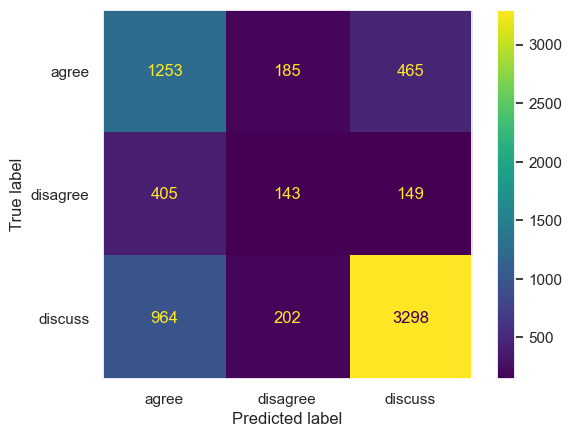

[2023-04-22 13:46:35] Classification Report:
[2023-04-22 13:46:35]               precision    recall  f1-score   support

           0       0.48      0.66      0.55      1903
           1       0.27      0.21      0.23       697
           2       0.84      0.74      0.79      4464

    accuracy                           0.66      7064
   macro avg       0.53      0.53      0.52      7064
weighted avg       0.69      0.66      0.67      7064

[2023-04-22 13:46:36] Finished test evaluation


In [98]:
model_trainer.train()

### Finetuned with Inverse Weighting

In [96]:
class TransformerMLPDummy(nn.Module):
    def __init__(self, transformer):
        super().__init__()
        self.transformer = transformer
        
    def forward(self, input_ids, mask):
        out = self.transformer(input_ids, attention_mask=mask)
        return out["logits"]

In [101]:
from transformers import AutoModelForSequenceClassification

transformer_with_head = AutoModelForSequenceClassification.from_pretrained(
    selected_transformer_name,
    num_labels=3
)

# print(transformer)

# transformer = AutoModel.from_pretrained(selected_transformer_name)

model_trainer = TransformerBasedModelTrainer(
    model_class=TransformerMLPDummy,
    model_transformer=transformer_with_head,
    model_freeze_transformer=False,
    model_config={},
    optimiser_class=optim.AdamW,
    optimiser_config={
        "lr": 5e-5
    },
    hf_scheduler_name="linear",
    hf_scheduler_config={
        "num_warmup_steps": 0,
        "num_training_steps": 3 * (len(train_dataset) + 1) // 8
    },
    loss_class=nn.CrossEntropyLoss,
    batch_size=8,
    max_epochs=3,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    label_names=list(labels2id.keys()),
    sampling_weight_fn="inverse",
    no_improvement_epochs_stop=1,
    eval_batch_size=None,
    loss_weights=None,
    device="cuda:0",
    excluded_freeze=["classifier.dense.weight", "classifier.dense.bias", "classifier.out_proj.weight", "classifier.out_proj.bias"]
)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.out_proj.bias

Model Initialised
TransformerMLPDummy(
  (transformer): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
   

[2023-04-22 13:48:16] Starting epoch 1
[2023-04-22 13:48:16] Starting epoch training
[2023-04-22 13:48:16] Set model to train mode


  0%|          | 0/1356 [00:00<?, ?it/s]

[2023-04-22 13:48:27][1:40] Loss: 0.761
[2023-04-22 13:48:27][1:40] LR: 4.949619071024822e-05
[2023-04-22 13:48:38][1:80] Loss: 0.644
[2023-04-22 13:48:38][1:80] LR: 4.90046694519538e-05
Class 1 exhausted, falling back to randomised sampling fromthe class
[2023-04-22 13:48:49][1:120] Loss: 0.660
[2023-04-22 13:48:49][1:120] LR: 4.851314819365938e-05
[2023-04-22 13:49:00][1:160] Loss: 0.456
[2023-04-22 13:49:00][1:160] LR: 4.802162693536496e-05
[2023-04-22 13:49:10][1:200] Loss: 0.446
[2023-04-22 13:49:10][1:200] LR: 4.7530105677070536e-05
[2023-04-22 13:49:21][1:240] Loss: 0.451
[2023-04-22 13:49:21][1:240] LR: 4.7038584418776115e-05
[2023-04-22 13:49:32][1:280] Loss: 0.512
[2023-04-22 13:49:32][1:280] LR: 4.6547063160481694e-05
[2023-04-22 13:49:42][1:320] Loss: 0.469
[2023-04-22 13:49:42][1:320] LR: 4.605554190218727e-05
[2023-04-22 13:49:53][1:360] Loss: 0.409
[2023-04-22 13:49:53][1:360] LR: 4.556402064389285e-05
[2023-04-22 13:50:04][1:400] Loss: 0.297
[2023-04-22 13:50:04][1:400]

  0%|          | 0/322 [00:00<?, ?it/s]

[2023-04-22 13:54:45] Set model to train mode


Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--accuracy\f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Fri Mar 31 21:15:28 2023) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--precision\4e7f439a346715f68500ce6f2be82bf3272abd3f20bdafd203a2c4f85b61dd5f (last modified on Fri Mar 31 21:16:47 2023) since it couldn't be found locally at evaluate-metric--precision, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--recall\e40e6e98d18ff3f210f4d0b26fa721bfaa80704b1fdf890fa551cfabf94fc185 (last modified on Fri Mar 31 21:38:10 2023) since it couldn't be found locally at

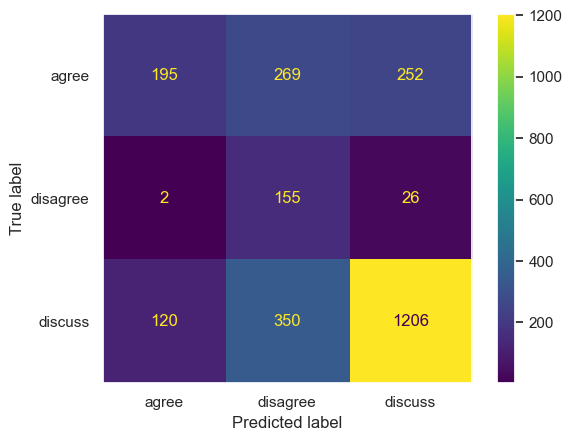

[2023-04-22 13:54:54] Classification Report:
[2023-04-22 13:54:54]               precision    recall  f1-score   support

           0       0.62      0.27      0.38       716
           1       0.20      0.85      0.32       183
           2       0.81      0.72      0.76      1676

    accuracy                           0.60      2575
   macro avg       0.54      0.61      0.49      2575
weighted avg       0.71      0.60      0.62      2575

[2023-04-22 13:54:54] Epoch Accuracy {'accuracy': 0.6042718446601941}
[2023-04-22 13:54:54] Finished validation evaluation
[2023-04-22 13:54:54] Beat best validation loss, new validation loss: 1.3605616763031676 (surpassed 1000000000.0 from epoch -1)
[2023-04-22 13:54:56] Saved best model
[2023-04-22 13:54:56] Logged to wandb
[2023-04-22 13:54:56] Starting epoch 2
[2023-04-22 13:54:56] Starting epoch training
[2023-04-22 13:54:56] Set model to train mode


  0%|          | 0/1356 [00:00<?, ?it/s]

[2023-04-22 13:55:07][2:40] Loss: 0.490
[2023-04-22 13:55:07][2:40] LR: 3.283362005406734e-05
[2023-04-22 13:55:17][2:80] Loss: 0.426
[2023-04-22 13:55:17][2:80] LR: 3.2342098795772917e-05
Class 1 exhausted, falling back to randomised sampling fromthe class
[2023-04-22 13:55:28][2:120] Loss: 0.419
[2023-04-22 13:55:28][2:120] LR: 3.1850577537478495e-05
[2023-04-22 13:55:39][2:160] Loss: 0.176
[2023-04-22 13:55:39][2:160] LR: 3.1359056279184074e-05
[2023-04-22 13:55:49][2:200] Loss: 0.308
[2023-04-22 13:55:49][2:200] LR: 3.086753502088965e-05
[2023-04-22 13:56:00][2:240] Loss: 0.216
[2023-04-22 13:56:00][2:240] LR: 3.0376013762595235e-05
[2023-04-22 13:56:10][2:280] Loss: 0.278
[2023-04-22 13:56:10][2:280] LR: 2.9884492504300814e-05
[2023-04-22 13:56:21][2:320] Loss: 0.205
[2023-04-22 13:56:21][2:320] LR: 2.939297124600639e-05
[2023-04-22 13:56:31][2:360] Loss: 0.203
[2023-04-22 13:56:31][2:360] LR: 2.8901449987711972e-05
[2023-04-22 13:56:42][2:400] Loss: 0.169
[2023-04-22 13:56:42][2:

  0%|          | 0/322 [00:00<?, ?it/s]

[2023-04-22 14:01:21] Set model to train mode


Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--accuracy\f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Fri Mar 31 21:15:28 2023) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--precision\4e7f439a346715f68500ce6f2be82bf3272abd3f20bdafd203a2c4f85b61dd5f (last modified on Fri Mar 31 21:16:47 2023) since it couldn't be found locally at evaluate-metric--precision, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--recall\e40e6e98d18ff3f210f4d0b26fa721bfaa80704b1fdf890fa551cfabf94fc185 (last modified on Fri Mar 31 21:38:10 2023) since it couldn't be found locally at

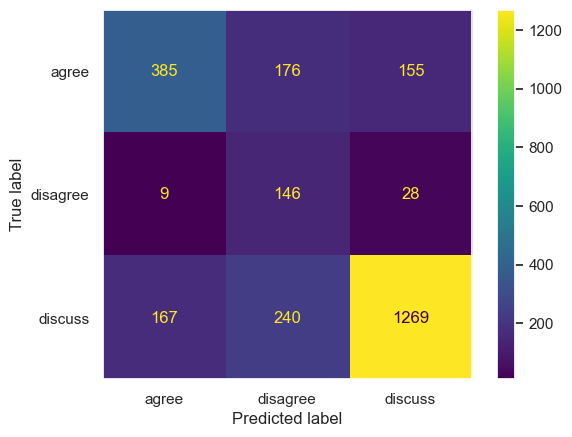

[2023-04-22 14:01:31] Classification Report:
[2023-04-22 14:01:31]               precision    recall  f1-score   support

           0       0.69      0.54      0.60       716
           1       0.26      0.80      0.39       183
           2       0.87      0.76      0.81      1676

    accuracy                           0.70      2575
   macro avg       0.61      0.70      0.60      2575
weighted avg       0.78      0.70      0.72      2575

[2023-04-22 14:01:31] Epoch Accuracy {'accuracy': 0.6990291262135923}
[2023-04-22 14:01:31] Finished validation evaluation
[2023-04-22 14:01:31] Beat best validation loss, new validation loss: 0.9796005537797067 (surpassed 1.3605616763031676 from epoch 1)
[2023-04-22 14:01:32] Saved best model
[2023-04-22 14:01:32] Logged to wandb
[2023-04-22 14:01:32] Starting epoch 3
[2023-04-22 14:01:32] Starting epoch training
[2023-04-22 14:01:32] Set model to train mode


  0%|          | 0/1356 [00:00<?, ?it/s]

[2023-04-22 14:01:43][3:40] Loss: 0.289
[2023-04-22 14:01:43][3:40] LR: 1.6171049397886458e-05
[2023-04-22 14:01:53][3:80] Loss: 0.307
[2023-04-22 14:01:53][3:80] LR: 1.5679528139592037e-05
Class 1 exhausted, falling back to randomised sampling fromthe class
[2023-04-22 14:02:04][3:120] Loss: 0.230
[2023-04-22 14:02:04][3:120] LR: 1.5188006881297618e-05
[2023-04-22 14:02:15][3:160] Loss: 0.114
[2023-04-22 14:02:15][3:160] LR: 1.4696485623003195e-05
[2023-04-22 14:02:25][3:200] Loss: 0.153
[2023-04-22 14:02:25][3:200] LR: 1.4204964364708775e-05
[2023-04-22 14:02:36][3:240] Loss: 0.132
[2023-04-22 14:02:36][3:240] LR: 1.3713443106414353e-05
[2023-04-22 14:02:47][3:280] Loss: 0.046
[2023-04-22 14:02:47][3:280] LR: 1.3221921848119931e-05
[2023-04-22 14:02:57][3:320] Loss: 0.115
[2023-04-22 14:02:57][3:320] LR: 1.2730400589825512e-05
[2023-04-22 14:03:08][3:360] Loss: 0.123
[2023-04-22 14:03:08][3:360] LR: 1.223887933153109e-05
[2023-04-22 14:03:18][3:400] Loss: 0.133
[2023-04-22 14:03:18][

  0%|          | 0/322 [00:00<?, ?it/s]

[2023-04-22 14:07:57] Set model to train mode


Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--accuracy\f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Fri Mar 31 21:15:28 2023) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--precision\4e7f439a346715f68500ce6f2be82bf3272abd3f20bdafd203a2c4f85b61dd5f (last modified on Fri Mar 31 21:16:47 2023) since it couldn't be found locally at evaluate-metric--precision, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--recall\e40e6e98d18ff3f210f4d0b26fa721bfaa80704b1fdf890fa551cfabf94fc185 (last modified on Fri Mar 31 21:38:10 2023) since it couldn't be found locally at

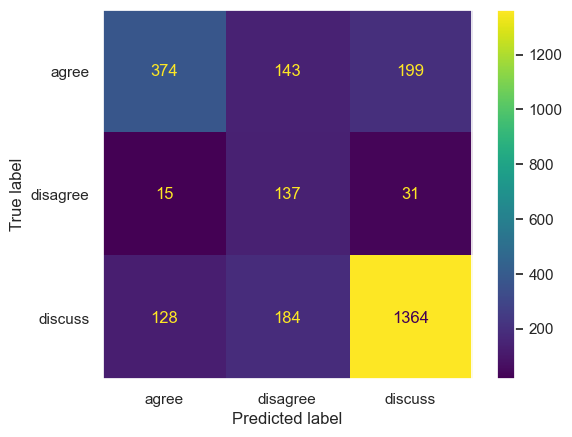

[2023-04-22 14:08:07] Classification Report:
[2023-04-22 14:08:07]               precision    recall  f1-score   support

           0       0.72      0.52      0.61       716
           1       0.30      0.75      0.42       183
           2       0.86      0.81      0.83      1676

    accuracy                           0.73      2575
   macro avg       0.62      0.69      0.62      2575
weighted avg       0.78      0.73      0.74      2575

[2023-04-22 14:08:07] Epoch Accuracy {'accuracy': 0.7281553398058253}
[2023-04-22 14:08:07] Finished validation evaluation
[2023-04-22 14:08:07] Early stopping triggered, best validation loss achieved at 2 (loss: 0.9796005537797067)
[2023-04-22 14:08:07] Loading best model (epoch 0.9796005537797067) for evaluation
[2023-04-22 14:08:07] Starting test evaluation
[2023-04-22 14:08:07] Using model to generate predictions
[2023-04-22 14:08:07] Set model to eval mode


  0%|          | 0/883 [00:00<?, ?it/s]

[2023-04-22 14:09:20] Set model to train mode


Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--accuracy\f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Fri Mar 31 21:15:28 2023) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--precision\4e7f439a346715f68500ce6f2be82bf3272abd3f20bdafd203a2c4f85b61dd5f (last modified on Fri Mar 31 21:16:47 2023) since it couldn't be found locally at evaluate-metric--precision, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--recall\e40e6e98d18ff3f210f4d0b26fa721bfaa80704b1fdf890fa551cfabf94fc185 (last modified on Fri Mar 31 21:38:10 2023) since it couldn't be found locally at

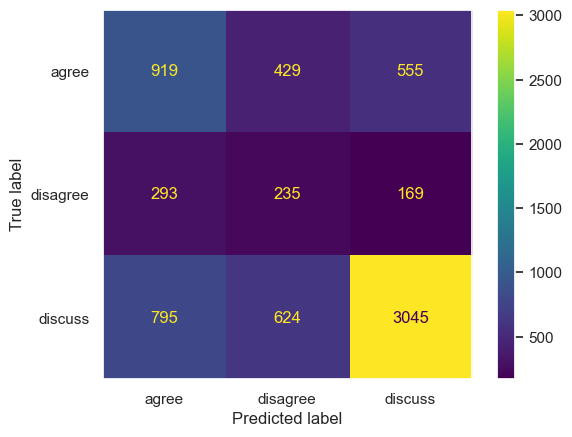

[2023-04-22 14:09:30] Classification Report:
[2023-04-22 14:09:30]               precision    recall  f1-score   support

           0       0.46      0.48      0.47      1903
           1       0.18      0.34      0.24       697
           2       0.81      0.68      0.74      4464

    accuracy                           0.59      7064
   macro avg       0.48      0.50      0.48      7064
weighted avg       0.65      0.59      0.62      7064

[2023-04-22 14:09:30] Finished test evaluation


In [102]:
model_trainer.train()

### Finetuned with Log Inverse Weighting

In [103]:
class TransformerMLPDummy(nn.Module):
    def __init__(self, transformer):
        super().__init__()
        self.transformer = transformer
        
    def forward(self, input_ids, mask):
        out = self.transformer(input_ids, attention_mask=mask)
        return out["logits"]

In [104]:
from transformers import AutoModelForSequenceClassification

transformer_with_head = AutoModelForSequenceClassification.from_pretrained(
    selected_transformer_name,
    num_labels=3
)

# print(transformer)

# transformer = AutoModel.from_pretrained(selected_transformer_name)

model_trainer = TransformerBasedModelTrainer(
    model_class=TransformerMLPDummy,
    model_transformer=transformer_with_head,
    model_freeze_transformer=False,
    model_config={},
    optimiser_class=optim.AdamW,
    optimiser_config={
        "lr": 5e-5
    },
    hf_scheduler_name="linear",
    hf_scheduler_config={
        "num_warmup_steps": 0,
        "num_training_steps": 3 * (len(train_dataset) + 1) // 8
    },
    loss_class=nn.CrossEntropyLoss,
    batch_size=8,
    max_epochs=3,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    label_names=list(labels2id.keys()),
    sampling_weight_fn="log_inverse",
    no_improvement_epochs_stop=1,
    eval_batch_size=None,
    loss_weights=None,
    device="cuda:0",
    excluded_freeze=["classifier.dense.weight", "classifier.dense.bias", "classifier.out_proj.weight", "classifier.out_proj.bias"]
)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.out_proj.bias

Model Initialised
TransformerMLPDummy(
  (transformer): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
   

[2023-04-22 14:12:07] Starting epoch 1
[2023-04-22 14:12:07] Starting epoch training
[2023-04-22 14:12:07] Set model to train mode


  0%|          | 0/1356 [00:00<?, ?it/s]

[2023-04-22 14:12:18][1:40] Loss: 0.784
[2023-04-22 14:12:18][1:40] LR: 4.949619071024822e-05
[2023-04-22 14:12:29][1:80] Loss: 0.562
[2023-04-22 14:12:29][1:80] LR: 4.90046694519538e-05
[2023-04-22 14:12:39][1:120] Loss: 0.599
[2023-04-22 14:12:39][1:120] LR: 4.851314819365938e-05
Class 1 exhausted, falling back to randomised sampling fromthe class
[2023-04-22 14:12:50][1:160] Loss: 0.837
[2023-04-22 14:12:50][1:160] LR: 4.802162693536496e-05
[2023-04-22 14:13:01][1:200] Loss: 0.655
[2023-04-22 14:13:01][1:200] LR: 4.7530105677070536e-05
[2023-04-22 14:13:11][1:240] Loss: 0.555
[2023-04-22 14:13:11][1:240] LR: 4.7038584418776115e-05
[2023-04-22 14:13:22][1:280] Loss: 0.546
[2023-04-22 14:13:22][1:280] LR: 4.6547063160481694e-05
[2023-04-22 14:13:33][1:320] Loss: 0.508
[2023-04-22 14:13:33][1:320] LR: 4.605554190218727e-05
[2023-04-22 14:13:43][1:360] Loss: 0.524
[2023-04-22 14:13:43][1:360] LR: 4.556402064389285e-05
[2023-04-22 14:13:54][1:400] Loss: 0.518
[2023-04-22 14:13:54][1:400]

  0%|          | 0/322 [00:00<?, ?it/s]

[2023-04-22 14:18:35] Set model to train mode


Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--accuracy\f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Fri Mar 31 21:15:28 2023) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--precision\4e7f439a346715f68500ce6f2be82bf3272abd3f20bdafd203a2c4f85b61dd5f (last modified on Fri Mar 31 21:16:47 2023) since it couldn't be found locally at evaluate-metric--precision, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--recall\e40e6e98d18ff3f210f4d0b26fa721bfaa80704b1fdf890fa551cfabf94fc185 (last modified on Fri Mar 31 21:38:10 2023) since it couldn't be found locally at

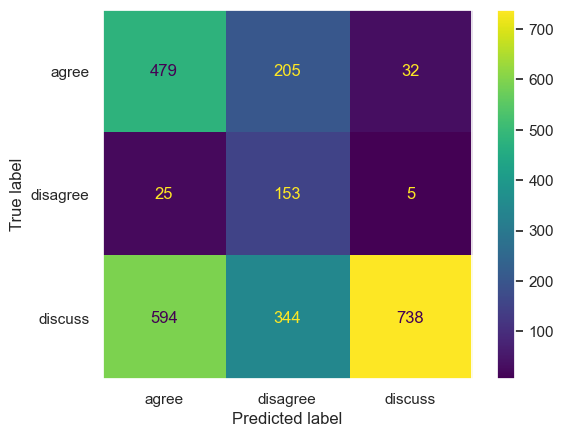

[2023-04-22 14:18:45] Classification Report:
[2023-04-22 14:18:45]               precision    recall  f1-score   support

           0       0.44      0.67      0.53       716
           1       0.22      0.84      0.35       183
           2       0.95      0.44      0.60      1676

    accuracy                           0.53      2575
   macro avg       0.54      0.65      0.49      2575
weighted avg       0.76      0.53      0.56      2575

[2023-04-22 14:18:45] Epoch Accuracy {'accuracy': 0.5320388349514563}
[2023-04-22 14:18:45] Finished validation evaluation
[2023-04-22 14:18:45] Beat best validation loss, new validation loss: 1.3524515857017652 (surpassed 1000000000.0 from epoch -1)
[2023-04-22 14:18:46] Saved best model
[2023-04-22 14:18:46] Logged to wandb
[2023-04-22 14:18:46] Starting epoch 2
[2023-04-22 14:18:46] Starting epoch training
[2023-04-22 14:18:46] Set model to train mode


  0%|          | 0/1356 [00:00<?, ?it/s]

[2023-04-22 14:18:57][2:40] Loss: 0.401
[2023-04-22 14:18:57][2:40] LR: 3.283362005406734e-05
[2023-04-22 14:19:07][2:80] Loss: 0.372
[2023-04-22 14:19:07][2:80] LR: 3.2342098795772917e-05
[2023-04-22 14:19:18][2:120] Loss: 0.336
[2023-04-22 14:19:18][2:120] LR: 3.1850577537478495e-05
Class 1 exhausted, falling back to randomised sampling fromthe class
[2023-04-22 14:19:28][2:160] Loss: 0.352
[2023-04-22 14:19:28][2:160] LR: 3.1359056279184074e-05
[2023-04-22 14:19:39][2:200] Loss: 0.268
[2023-04-22 14:19:39][2:200] LR: 3.086753502088965e-05
[2023-04-22 14:19:49][2:240] Loss: 0.365
[2023-04-22 14:19:49][2:240] LR: 3.0376013762595235e-05
[2023-04-22 14:20:00][2:280] Loss: 0.237
[2023-04-22 14:20:00][2:280] LR: 2.9884492504300814e-05
[2023-04-22 14:20:11][2:320] Loss: 0.288
[2023-04-22 14:20:11][2:320] LR: 2.939297124600639e-05
[2023-04-22 14:20:21][2:360] Loss: 0.239
[2023-04-22 14:20:21][2:360] LR: 2.8901449987711972e-05
[2023-04-22 14:20:32][2:400] Loss: 0.224
[2023-04-22 14:20:32][2:

  0%|          | 0/322 [00:00<?, ?it/s]

[2023-04-22 14:25:11] Set model to train mode


Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--accuracy\f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Fri Mar 31 21:15:28 2023) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--precision\4e7f439a346715f68500ce6f2be82bf3272abd3f20bdafd203a2c4f85b61dd5f (last modified on Fri Mar 31 21:16:47 2023) since it couldn't be found locally at evaluate-metric--precision, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--recall\e40e6e98d18ff3f210f4d0b26fa721bfaa80704b1fdf890fa551cfabf94fc185 (last modified on Fri Mar 31 21:38:10 2023) since it couldn't be found locally at

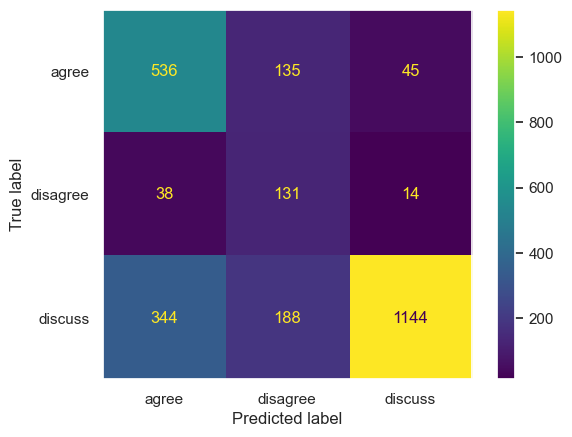

[2023-04-22 14:25:20] Classification Report:
[2023-04-22 14:25:20]               precision    recall  f1-score   support

           0       0.58      0.75      0.66       716
           1       0.29      0.72      0.41       183
           2       0.95      0.68      0.79      1676

    accuracy                           0.70      2575
   macro avg       0.61      0.72      0.62      2575
weighted avg       0.80      0.70      0.73      2575

[2023-04-22 14:25:20] Epoch Accuracy {'accuracy': 0.7033009708737864}
[2023-04-22 14:25:20] Finished validation evaluation
[2023-04-22 14:25:20] Beat best validation loss, new validation loss: 0.9259403219001124 (surpassed 1.3524515857017652 from epoch 1)
[2023-04-22 14:25:23] Saved best model
[2023-04-22 14:25:23] Logged to wandb
[2023-04-22 14:25:23] Starting epoch 3
[2023-04-22 14:25:23] Starting epoch training
[2023-04-22 14:25:23] Set model to train mode


  0%|          | 0/1356 [00:00<?, ?it/s]

[2023-04-22 14:25:34][3:40] Loss: 0.260
[2023-04-22 14:25:34][3:40] LR: 1.6171049397886458e-05
[2023-04-22 14:25:44][3:80] Loss: 0.167
[2023-04-22 14:25:44][3:80] LR: 1.5679528139592037e-05
[2023-04-22 14:25:55][3:120] Loss: 0.153
[2023-04-22 14:25:55][3:120] LR: 1.5188006881297618e-05
Class 1 exhausted, falling back to randomised sampling fromthe class
[2023-04-22 14:26:05][3:160] Loss: 0.213
[2023-04-22 14:26:05][3:160] LR: 1.4696485623003195e-05
[2023-04-22 14:26:16][3:200] Loss: 0.146
[2023-04-22 14:26:16][3:200] LR: 1.4204964364708775e-05
[2023-04-22 14:26:26][3:240] Loss: 0.106
[2023-04-22 14:26:26][3:240] LR: 1.3713443106414353e-05
[2023-04-22 14:26:37][3:280] Loss: 0.121
[2023-04-22 14:26:37][3:280] LR: 1.3221921848119931e-05
[2023-04-22 14:26:48][3:320] Loss: 0.143
[2023-04-22 14:26:48][3:320] LR: 1.2730400589825512e-05
[2023-04-22 14:26:58][3:360] Loss: 0.091
[2023-04-22 14:26:58][3:360] LR: 1.223887933153109e-05
[2023-04-22 14:27:09][3:400] Loss: 0.063
[2023-04-22 14:27:09][

  0%|          | 0/322 [00:00<?, ?it/s]

[2023-04-22 14:31:52] Set model to train mode


Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--accuracy\f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Fri Mar 31 21:15:28 2023) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--precision\4e7f439a346715f68500ce6f2be82bf3272abd3f20bdafd203a2c4f85b61dd5f (last modified on Fri Mar 31 21:16:47 2023) since it couldn't be found locally at evaluate-metric--precision, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--recall\e40e6e98d18ff3f210f4d0b26fa721bfaa80704b1fdf890fa551cfabf94fc185 (last modified on Fri Mar 31 21:38:10 2023) since it couldn't be found locally at

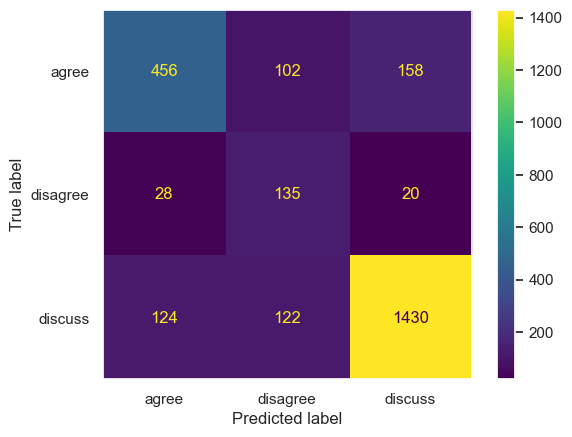

[2023-04-22 14:32:01] Classification Report:
[2023-04-22 14:32:01]               precision    recall  f1-score   support

           0       0.75      0.64      0.69       716
           1       0.38      0.74      0.50       183
           2       0.89      0.85      0.87      1676

    accuracy                           0.78      2575
   macro avg       0.67      0.74      0.69      2575
weighted avg       0.81      0.78      0.79      2575

[2023-04-22 14:32:01] Epoch Accuracy {'accuracy': 0.7848543689320389}
[2023-04-22 14:32:01] Finished validation evaluation
[2023-04-22 14:32:01] Beat best validation loss, new validation loss: 0.7549255198324736 (surpassed 0.9259403219001124 from epoch 2)
[2023-04-22 14:32:03] Saved best model
[2023-04-22 14:32:03] Logged to wandb
[2023-04-22 14:32:03] Loading best model (epoch 0.7549255198324736) for evaluation
[2023-04-22 14:32:03] Starting test evaluation
[2023-04-22 14:32:03] Using model to generate predictions
[2023-04-22 14:32:03] Set model

  0%|          | 0/883 [00:00<?, ?it/s]

[2023-04-22 14:33:16] Set model to train mode


Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--accuracy\f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Fri Mar 31 21:15:28 2023) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--precision\4e7f439a346715f68500ce6f2be82bf3272abd3f20bdafd203a2c4f85b61dd5f (last modified on Fri Mar 31 21:16:47 2023) since it couldn't be found locally at evaluate-metric--precision, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--recall\e40e6e98d18ff3f210f4d0b26fa721bfaa80704b1fdf890fa551cfabf94fc185 (last modified on Fri Mar 31 21:38:10 2023) since it couldn't be found locally at

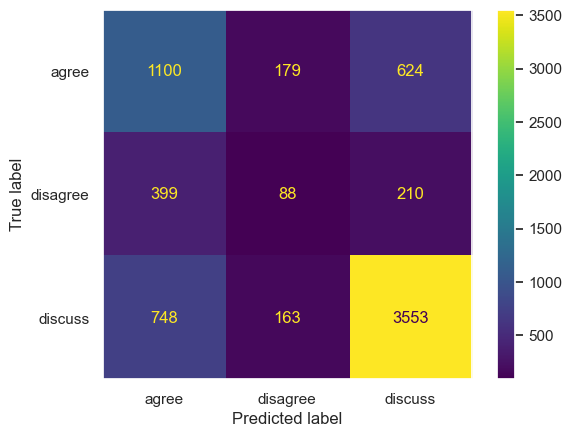

[2023-04-22 14:33:26] Classification Report:
[2023-04-22 14:33:26]               precision    recall  f1-score   support

           0       0.49      0.58      0.53      1903
           1       0.20      0.13      0.16       697
           2       0.81      0.80      0.80      4464

    accuracy                           0.67      7064
   macro avg       0.50      0.50      0.50      7064
weighted avg       0.66      0.67      0.67      7064

[2023-04-22 14:33:26] Finished test evaluation


In [105]:
model_trainer.train()

### LSTM No Weighting

In [106]:
class TransformerRNN(nn.Module):
    def __init__(self, transformer, rnn_type, stacked_layers, hidden_dim, output_dim, bidirectional, dropout_prob):
        super().__init__()
        
        self.transformer = transformer
        embedding_dim = transformer.config.to_dict()["hidden_size"]
        
        rnn_class = None
        
        if rnn_type.lower() == "lstm":
            rnn_class = nn.LSTM
        elif rnn_type.lower() == "gru":
            rnn_class = nn.GRU
        else:
            assert 1 == 0, "Invalid RNN type"
        
        self.rnn_type = rnn_type
        self.rnn = rnn_class(embedding_dim, hidden_dim, num_layers=stacked_layers, bidirectional=bidirectional, batch_first=True, dropout=dropout_prob)
        self.classifier = nn.Linear(hidden_dim * (1 + bidirectional), output_dim)
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, ids, mask):
        embeddings = self.transformer(input_ids=ids, attention_mask=mask)[0]
        
        if self.rnn_type == "gru":
            _, hidden_state = self.rnn(embeddings)
        else:
            _, (hidden_state, _) = self.rnn(embeddings)
        
        if self.rnn.bidirectional:
            hidden_state = self.dropout(torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim=1))
        else:
            hidden_state = self.dropout(hidden_state[-1,:,:])
        
        return self.classifier(hidden_state)

In [107]:
transformer = AutoModel.from_pretrained(selected_transformer_name)

model_trainer = TransformerBasedModelTrainer(
    model_class=TransformerRNN,
    model_transformer=transformer,
    model_freeze_transformer=False,
    model_config={
        "rnn_type": "lstm",
        "stacked_layers": 2,
        "hidden_dim": 256,
        "output_dim": 3,
        "dropout_prob": 0.1,
        "bidirectional": True,
    },
    optimiser_class=optim.AdamW,
    optimiser_config={
        "lr": 5e-5
    },
    hf_scheduler_name="linear",
    hf_scheduler_config={
        "num_warmup_steps": 0,
        "num_training_steps": 4 * (len(train_dataset) + 1) // 8
    },
    loss_class=nn.CrossEntropyLoss,
    batch_size=8,
    max_epochs=4,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    label_names=list(labels2id.keys()),
    sampling_weight_fn=None,
    no_improvement_epochs_stop=1,
    eval_batch_size=None,
    loss_weights=None,
    device="cuda:0",
    excluded_freeze=None
)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model Initialised
TransformerRNN(
  (transformer): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

[2023-04-22 14:33:56] Starting epoch 1
[2023-04-22 14:33:56] Starting epoch training
[2023-04-22 14:33:56] Set model to train mode


  0%|          | 0/1356 [00:00<?, ?it/s]

[2023-04-22 14:34:10][1:40] Loss: 0.883
[2023-04-22 14:34:10][1:40] LR: 4.9622189458164394e-05
[2023-04-22 14:34:23][1:80] Loss: 0.745
[2023-04-22 14:34:23][1:80] LR: 4.9253593807593074e-05
[2023-04-22 14:34:36][1:120] Loss: 0.746
[2023-04-22 14:34:36][1:120] LR: 4.888499815702175e-05
[2023-04-22 14:34:49][1:160] Loss: 0.756
[2023-04-22 14:34:49][1:160] LR: 4.8516402506450426e-05
[2023-04-22 14:35:02][1:200] Loss: 0.658
[2023-04-22 14:35:02][1:200] LR: 4.8147806855879105e-05
[2023-04-22 14:35:15][1:240] Loss: 0.708
[2023-04-22 14:35:15][1:240] LR: 4.777921120530778e-05
[2023-04-22 14:35:28][1:280] Loss: 0.692
[2023-04-22 14:35:28][1:280] LR: 4.741061555473646e-05
[2023-04-22 14:35:41][1:320] Loss: 0.742
[2023-04-22 14:35:41][1:320] LR: 4.7042019904165136e-05
[2023-04-22 14:35:54][1:360] Loss: 0.655
[2023-04-22 14:35:54][1:360] LR: 4.667342425359381e-05
[2023-04-22 14:36:07][1:400] Loss: 0.705
[2023-04-22 14:36:07][1:400] LR: 4.630482860302249e-05
[2023-04-22 14:36:20][1:440] Loss: 0.64

  0%|          | 0/322 [00:00<?, ?it/s]

[2023-04-22 14:41:53] Set model to train mode


Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--accuracy\f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Fri Mar 31 21:15:28 2023) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--precision\4e7f439a346715f68500ce6f2be82bf3272abd3f20bdafd203a2c4f85b61dd5f (last modified on Fri Mar 31 21:16:47 2023) since it couldn't be found locally at evaluate-metric--precision, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--recall\e40e6e98d18ff3f210f4d0b26fa721bfaa80704b1fdf890fa551cfabf94fc185 (last modified on Fri Mar 31 21:38:10 2023) since it couldn't be found locally at

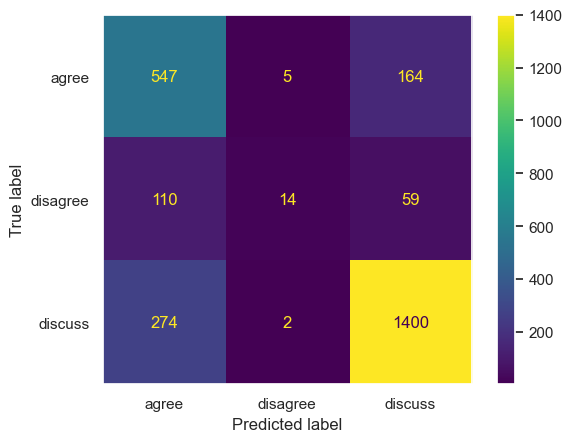

[2023-04-22 14:42:03] Classification Report:
[2023-04-22 14:42:03]               precision    recall  f1-score   support

           0       0.59      0.76      0.66       716
           1       0.67      0.08      0.14       183
           2       0.86      0.84      0.85      1676

    accuracy                           0.76      2575
   macro avg       0.71      0.56      0.55      2575
weighted avg       0.77      0.76      0.75      2575

[2023-04-22 14:42:03] Epoch Accuracy {'accuracy': 0.7615533980582524}
[2023-04-22 14:42:03] Finished validation evaluation
[2023-04-22 14:42:03] Beat best validation loss, new validation loss: 0.5917889157900159 (surpassed 1000000000.0 from epoch -1)
[2023-04-22 14:42:04] Saved best model
[2023-04-22 14:42:04] Logged to wandb
[2023-04-22 14:42:04] Starting epoch 2
[2023-04-22 14:42:04] Starting epoch training
[2023-04-22 14:42:04] Set model to train mode


  0%|          | 0/1356 [00:00<?, ?it/s]

[2023-04-22 14:42:18][2:40] Loss: 0.492
[2023-04-22 14:42:18][2:40] LR: 3.7126796903796536e-05
[2023-04-22 14:42:31][2:80] Loss: 0.453
[2023-04-22 14:42:31][2:80] LR: 3.6758201253225215e-05
[2023-04-22 14:42:44][2:120] Loss: 0.479
[2023-04-22 14:42:44][2:120] LR: 3.6389605602653895e-05
[2023-04-22 14:42:57][2:160] Loss: 0.410
[2023-04-22 14:42:57][2:160] LR: 3.602100995208257e-05
[2023-04-22 14:43:10][2:200] Loss: 0.408
[2023-04-22 14:43:10][2:200] LR: 3.5652414301511247e-05
[2023-04-22 14:43:23][2:240] Loss: 0.435
[2023-04-22 14:43:23][2:240] LR: 3.528381865093992e-05
[2023-04-22 14:43:36][2:280] Loss: 0.537
[2023-04-22 14:43:36][2:280] LR: 3.49152230003686e-05
[2023-04-22 14:43:49][2:320] Loss: 0.396
[2023-04-22 14:43:49][2:320] LR: 3.454662734979727e-05
[2023-04-22 14:44:02][2:360] Loss: 0.416
[2023-04-22 14:44:02][2:360] LR: 3.417803169922595e-05
[2023-04-22 14:44:14][2:400] Loss: 0.382
[2023-04-22 14:44:14][2:400] LR: 3.380943604865463e-05
[2023-04-22 14:44:27][2:440] Loss: 0.439


  0%|          | 0/322 [00:00<?, ?it/s]

[2023-04-22 14:50:01] Set model to train mode


Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--accuracy\f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Fri Mar 31 21:15:28 2023) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--precision\4e7f439a346715f68500ce6f2be82bf3272abd3f20bdafd203a2c4f85b61dd5f (last modified on Fri Mar 31 21:16:47 2023) since it couldn't be found locally at evaluate-metric--precision, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--recall\e40e6e98d18ff3f210f4d0b26fa721bfaa80704b1fdf890fa551cfabf94fc185 (last modified on Fri Mar 31 21:38:10 2023) since it couldn't be found locally at

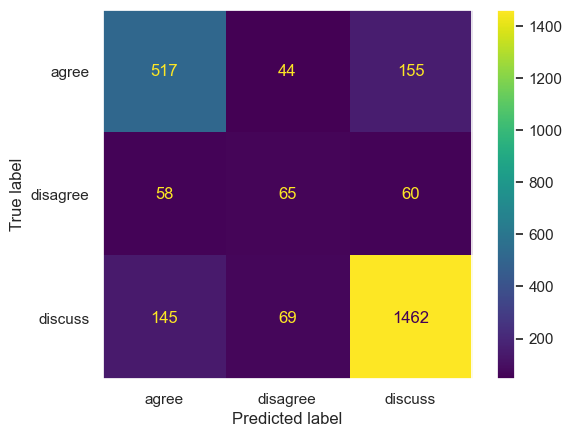

[2023-04-22 14:50:11] Classification Report:
[2023-04-22 14:50:11]               precision    recall  f1-score   support

           0       0.72      0.72      0.72       716
           1       0.37      0.36      0.36       183
           2       0.87      0.87      0.87      1676

    accuracy                           0.79      2575
   macro avg       0.65      0.65      0.65      2575
weighted avg       0.79      0.79      0.79      2575

[2023-04-22 14:50:11] Epoch Accuracy {'accuracy': 0.7937864077669903}
[2023-04-22 14:50:11] Finished validation evaluation
[2023-04-22 14:50:11] Beat best validation loss, new validation loss: 0.5744901587868468 (surpassed 0.5917889157900159 from epoch 1)
[2023-04-22 14:50:12] Saved best model
[2023-04-22 14:50:12] Logged to wandb
[2023-04-22 14:50:12] Starting epoch 3
[2023-04-22 14:50:12] Starting epoch training
[2023-04-22 14:50:12] Set model to train mode


  0%|          | 0/1356 [00:00<?, ?it/s]

[2023-04-22 14:50:26][3:40] Loss: 0.237
[2023-04-22 14:50:26][3:40] LR: 2.4631404349428677e-05
[2023-04-22 14:50:39][3:80] Loss: 0.257
[2023-04-22 14:50:39][3:80] LR: 2.4262808698857353e-05
[2023-04-22 14:50:52][3:120] Loss: 0.244
[2023-04-22 14:50:52][3:120] LR: 2.3894213048286033e-05
[2023-04-22 14:51:05][3:160] Loss: 0.239
[2023-04-22 14:51:05][3:160] LR: 2.352561739771471e-05
[2023-04-22 14:51:18][3:200] Loss: 0.186
[2023-04-22 14:51:18][3:200] LR: 2.3157021747143385e-05
[2023-04-22 14:51:31][3:240] Loss: 0.283
[2023-04-22 14:51:31][3:240] LR: 2.278842609657206e-05
[2023-04-22 14:51:44][3:280] Loss: 0.176
[2023-04-22 14:51:44][3:280] LR: 2.241983044600074e-05
[2023-04-22 14:51:57][3:320] Loss: 0.212
[2023-04-22 14:51:57][3:320] LR: 2.2051234795429416e-05
[2023-04-22 14:52:10][3:360] Loss: 0.195
[2023-04-22 14:52:10][3:360] LR: 2.1682639144858092e-05
[2023-04-22 14:52:23][3:400] Loss: 0.248
[2023-04-22 14:52:23][3:400] LR: 2.1314043494286768e-05
[2023-04-22 14:52:36][3:440] Loss: 0.

  0%|          | 0/322 [00:00<?, ?it/s]

[2023-04-22 14:58:08] Set model to train mode


Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--accuracy\f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Fri Mar 31 21:15:28 2023) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--precision\4e7f439a346715f68500ce6f2be82bf3272abd3f20bdafd203a2c4f85b61dd5f (last modified on Fri Mar 31 21:16:47 2023) since it couldn't be found locally at evaluate-metric--precision, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--recall\e40e6e98d18ff3f210f4d0b26fa721bfaa80704b1fdf890fa551cfabf94fc185 (last modified on Fri Mar 31 21:38:10 2023) since it couldn't be found locally at

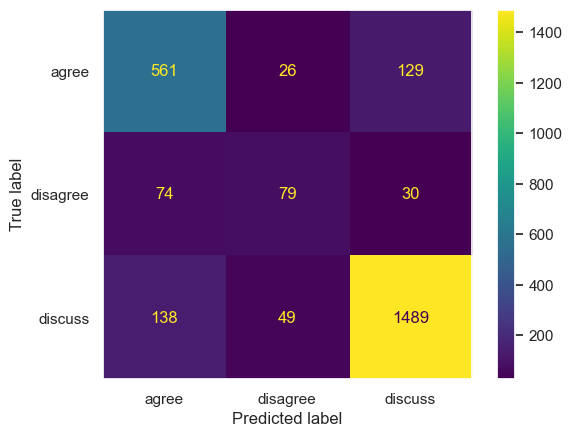

[2023-04-22 14:58:18] Classification Report:
[2023-04-22 14:58:18]               precision    recall  f1-score   support

           0       0.73      0.78      0.75       716
           1       0.51      0.43      0.47       183
           2       0.90      0.89      0.90      1676

    accuracy                           0.83      2575
   macro avg       0.71      0.70      0.71      2575
weighted avg       0.83      0.83      0.83      2575

[2023-04-22 14:58:18] Epoch Accuracy {'accuracy': 0.8267961165048544}
[2023-04-22 14:58:18] Finished validation evaluation
[2023-04-22 14:58:18] Early stopping triggered, best validation loss achieved at 2 (loss: 0.5744901587868468)
[2023-04-22 14:58:18] Loading best model (epoch 0.5744901587868468) for evaluation
[2023-04-22 14:58:18] Starting test evaluation
[2023-04-22 14:58:18] Using model to generate predictions
[2023-04-22 14:58:18] Set model to eval mode


  0%|          | 0/883 [00:00<?, ?it/s]

[2023-04-22 14:59:52] Set model to train mode


Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--accuracy\f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Fri Mar 31 21:15:28 2023) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--precision\4e7f439a346715f68500ce6f2be82bf3272abd3f20bdafd203a2c4f85b61dd5f (last modified on Fri Mar 31 21:16:47 2023) since it couldn't be found locally at evaluate-metric--precision, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--recall\e40e6e98d18ff3f210f4d0b26fa721bfaa80704b1fdf890fa551cfabf94fc185 (last modified on Fri Mar 31 21:38:10 2023) since it couldn't be found locally at

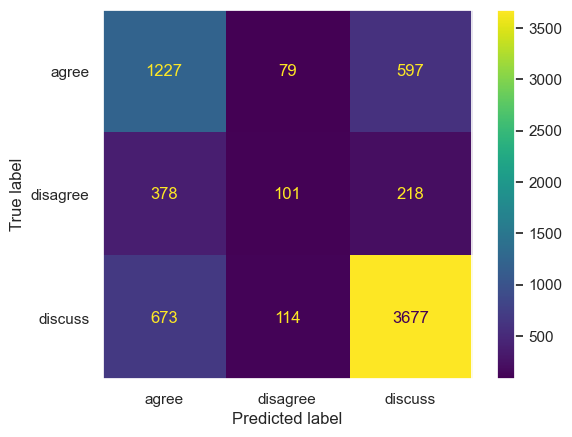

[2023-04-22 15:00:01] Classification Report:
[2023-04-22 15:00:02]               precision    recall  f1-score   support

           0       0.54      0.64      0.59      1903
           1       0.34      0.14      0.20       697
           2       0.82      0.82      0.82      4464

    accuracy                           0.71      7064
   macro avg       0.57      0.54      0.54      7064
weighted avg       0.70      0.71      0.70      7064

[2023-04-22 15:00:02] Finished test evaluation


In [108]:
model_trainer.train()

### LSTM Balanced

In [104]:
class TransformerRNN(nn.Module):
    def __init__(self, transformer, rnn_type, stacked_layers, hidden_dim, output_dim, bidirectional, dropout_prob):
        super().__init__()
        
        self.transformer = transformer
        embedding_dim = transformer.config.to_dict()["hidden_size"]
        
        rnn_class = None
        
        if rnn_type.lower() == "lstm":
            rnn_class = nn.LSTM
        elif rnn_type.lower() == "gru":
            rnn_class = nn.GRU
        else:
            assert 1 == 0, "Invalid RNN type"
        
        self.rnn_type = rnn_type
        self.rnn = rnn_class(embedding_dim, hidden_dim, num_layers=stacked_layers, bidirectional=bidirectional, batch_first=True, dropout=dropout_prob)
        self.classifier = nn.Linear(hidden_dim * (1 + bidirectional), output_dim)
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, ids, mask):
        embeddings = self.transformer(input_ids=ids, attention_mask=mask)[0]
        
        if self.rnn_type == "gru":
            _, hidden_state = self.rnn(embeddings)
        else:
            _, (hidden_state, _) = self.rnn(embeddings)
        
        if self.rnn.bidirectional:
            hidden_state = self.dropout(torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim=1))
        else:
            hidden_state = self.dropout(hidden_state[-1,:,:])
        
        return self.classifier(hidden_state)

In [105]:
transformer = AutoModel.from_pretrained(selected_transformer_name)

model_trainer = TransformerBasedModelTrainer(
    model_class=TransformerRNN,
    model_transformer=transformer,
    model_freeze_transformer=False,
    model_config={
        "rnn_type": "lstm",
        "stacked_layers": 2,
        "hidden_dim": 256,
        "output_dim": 3,
        "dropout_prob": 0.1,
        "bidirectional": True,
    },
    optimiser_class=optim.AdamW,
    optimiser_config={
        "lr": 5e-5
    },
    hf_scheduler_name="linear",
    hf_scheduler_config={
        "num_warmup_steps": 0,
        "num_training_steps": 8 * (len(train_dataset) + 1) // 8
    },
    loss_class=nn.CrossEntropyLoss,
    batch_size=8,
    max_epochs=8,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    label_names=list(labels2id.keys()),
    sampling_weight_fn="balanced",
    no_improvement_epochs_stop=2,
    eval_batch_size=None,
    loss_weights=None,
    device="cuda:0",
    excluded_freeze=None
)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model Initialised
TransformerRNN(
  (transformer): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

AssertionError: Need to implement!

In [ ]:
model_trainer.train()

### LSTM Log Inverse

In [110]:
class TransformerRNN(nn.Module):
    def __init__(self, transformer, rnn_type, stacked_layers, hidden_dim, output_dim, bidirectional, dropout_prob):
        super().__init__()
        
        self.transformer = transformer
        embedding_dim = transformer.config.to_dict()["hidden_size"]
        
        rnn_class = None
        
        if rnn_type.lower() == "lstm":
            rnn_class = nn.LSTM
        elif rnn_type.lower() == "gru":
            rnn_class = nn.GRU
        else:
            assert 1 == 0, "Invalid RNN type"
        
        self.rnn_type = rnn_type
        self.rnn = rnn_class(embedding_dim, hidden_dim, num_layers=stacked_layers, bidirectional=bidirectional, batch_first=True, dropout=dropout_prob)
        self.classifier = nn.Linear(hidden_dim * (1 + bidirectional), output_dim)
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, ids, mask):
        embeddings = self.transformer(input_ids=ids, attention_mask=mask)[0]
        
        if self.rnn_type == "gru":
            _, hidden_state = self.rnn(embeddings)
        else:
            _, (hidden_state, _) = self.rnn(embeddings)
        
        if self.rnn.bidirectional:
            hidden_state = self.dropout(torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim=1))
        else:
            hidden_state = self.dropout(hidden_state[-1,:,:])
        
        return self.classifier(hidden_state)

In [111]:
transformer = AutoModel.from_pretrained(selected_transformer_name)

model_trainer = TransformerBasedModelTrainer(
    model_class=TransformerRNN,
    model_transformer=transformer,
    model_freeze_transformer=False,
    model_config={
        "rnn_type": "lstm",
        "stacked_layers": 2,
        "hidden_dim": 256,
        "output_dim": 3,
        "dropout_prob": 0.1,
        "bidirectional": True,
    },
    optimiser_class=optim.AdamW,
    optimiser_config={
        "lr": 5e-5
    },
    hf_scheduler_name="linear",
    hf_scheduler_config={
        "num_warmup_steps": 0,
        "num_training_steps": 4 * (len(train_dataset) + 1) // 8
    },
    loss_class=nn.CrossEntropyLoss,
    batch_size=8,
    max_epochs=4,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    label_names=list(labels2id.keys()),
    sampling_weight_fn="log_inverse",
    no_improvement_epochs_stop=1,
    eval_batch_size=None,
    loss_weights=None,
    device="cuda:0",
    excluded_freeze=None
)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model Initialised
TransformerRNN(
  (transformer): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

[2023-04-22 15:03:15] Starting epoch 1
[2023-04-22 15:03:15] Starting epoch training
[2023-04-22 15:03:15] Set model to train mode


  0%|          | 0/1356 [00:00<?, ?it/s]

[2023-04-22 15:03:28][1:40] Loss: 0.865
[2023-04-22 15:03:28][1:40] LR: 4.9622189458164394e-05
[2023-04-22 15:03:41][1:80] Loss: 0.748
[2023-04-22 15:03:41][1:80] LR: 4.9253593807593074e-05
[2023-04-22 15:03:55][1:120] Loss: 0.722
[2023-04-22 15:03:55][1:120] LR: 4.888499815702175e-05
Class 1 exhausted, falling back to randomised sampling fromthe class
[2023-04-22 15:04:08][1:160] Loss: 0.839
[2023-04-22 15:04:08][1:160] LR: 4.8516402506450426e-05
[2023-04-22 15:04:21][1:200] Loss: 0.824
[2023-04-22 15:04:21][1:200] LR: 4.8147806855879105e-05
[2023-04-22 15:04:34][1:240] Loss: 0.909
[2023-04-22 15:04:34][1:240] LR: 4.777921120530778e-05
[2023-04-22 15:04:47][1:280] Loss: 0.879
[2023-04-22 15:04:47][1:280] LR: 4.741061555473646e-05
[2023-04-22 15:05:00][1:320] Loss: 0.881
[2023-04-22 15:05:00][1:320] LR: 4.7042019904165136e-05
[2023-04-22 15:05:13][1:360] Loss: 0.870
[2023-04-22 15:05:13][1:360] LR: 4.667342425359381e-05
[2023-04-22 15:05:26][1:400] Loss: 0.710
[2023-04-22 15:05:26][1:4

  0%|          | 0/322 [00:00<?, ?it/s]

[2023-04-22 15:11:12] Set model to train mode


F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

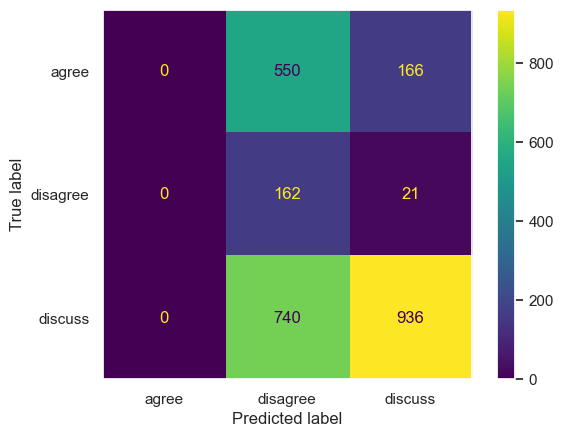

[2023-04-22 15:11:21] Classification Report:
[2023-04-22 15:11:21]               precision    recall  f1-score   support

           0       0.00      0.00      0.00       716
           1       0.11      0.89      0.20       183
           2       0.83      0.56      0.67      1676

    accuracy                           0.43      2575
   macro avg       0.32      0.48      0.29      2575
weighted avg       0.55      0.43      0.45      2575

[2023-04-22 15:11:21] Epoch Accuracy {'accuracy': 0.42640776699029126}
[2023-04-22 15:11:21] Finished validation evaluation
[2023-04-22 15:11:21] Beat best validation loss, new validation loss: 1.5281979362972034 (surpassed 1000000000.0 from epoch -1)


F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

[2023-04-22 15:11:22] Saved best model
[2023-04-22 15:11:22] Logged to wandb
[2023-04-22 15:11:22] Starting epoch 2
[2023-04-22 15:11:22] Starting epoch training
[2023-04-22 15:11:22] Set model to train mode


  0%|          | 0/1356 [00:00<?, ?it/s]

[2023-04-22 15:11:36][2:40] Loss: 0.909
[2023-04-22 15:11:36][2:40] LR: 3.7126796903796536e-05
[2023-04-22 15:11:49][2:80] Loss: 0.620
[2023-04-22 15:11:49][2:80] LR: 3.6758201253225215e-05
[2023-04-22 15:12:02][2:120] Loss: 0.634
[2023-04-22 15:12:02][2:120] LR: 3.6389605602653895e-05
Class 1 exhausted, falling back to randomised sampling fromthe class
[2023-04-22 15:12:15][2:160] Loss: 0.828
[2023-04-22 15:12:15][2:160] LR: 3.602100995208257e-05
[2023-04-22 15:12:28][2:200] Loss: 0.654
[2023-04-22 15:12:28][2:200] LR: 3.5652414301511247e-05
[2023-04-22 15:12:41][2:240] Loss: 0.616
[2023-04-22 15:12:41][2:240] LR: 3.528381865093992e-05
[2023-04-22 15:12:54][2:280] Loss: 0.640
[2023-04-22 15:12:54][2:280] LR: 3.49152230003686e-05
[2023-04-22 15:13:07][2:320] Loss: 0.649
[2023-04-22 15:13:07][2:320] LR: 3.454662734979727e-05
[2023-04-22 15:13:20][2:360] Loss: 0.595
[2023-04-22 15:13:20][2:360] LR: 3.417803169922595e-05
[2023-04-22 15:13:33][2:400] Loss: 0.664
[2023-04-22 15:13:33][2:400

  0%|          | 0/322 [00:00<?, ?it/s]

[2023-04-22 15:19:17] Set model to train mode


F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

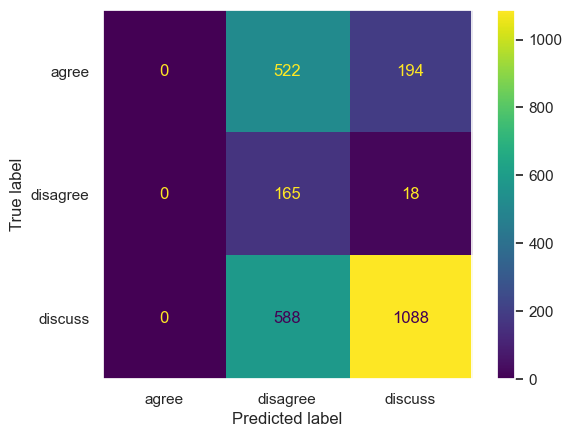

[2023-04-22 15:19:27] Classification Report:
[2023-04-22 15:19:27]               precision    recall  f1-score   support

           0       0.00      0.00      0.00       716
           1       0.13      0.90      0.23       183
           2       0.84      0.65      0.73      1676

    accuracy                           0.49      2575
   macro avg       0.32      0.52      0.32      2575
weighted avg       0.55      0.49      0.49      2575

[2023-04-22 15:19:27] Epoch Accuracy {'accuracy': 0.4866019417475728}
[2023-04-22 15:19:27] Finished validation evaluation
[2023-04-22 15:19:27] Beat best validation loss, new validation loss: 1.2954274390980323 (surpassed 1.5281979362972034 from epoch 1)


F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

[2023-04-22 15:19:29] Saved best model
[2023-04-22 15:19:29] Logged to wandb
[2023-04-22 15:19:29] Starting epoch 3
[2023-04-22 15:19:29] Starting epoch training
[2023-04-22 15:19:29] Set model to train mode


  0%|          | 0/1356 [00:00<?, ?it/s]

[2023-04-22 15:19:43][3:40] Loss: 0.791
[2023-04-22 15:19:43][3:40] LR: 2.4631404349428677e-05
[2023-04-22 15:19:56][3:80] Loss: 0.551
[2023-04-22 15:19:56][3:80] LR: 2.4262808698857353e-05
[2023-04-22 15:20:09][3:120] Loss: 0.526
[2023-04-22 15:20:09][3:120] LR: 2.3894213048286033e-05
Class 1 exhausted, falling back to randomised sampling fromthe class
[2023-04-22 15:20:22][3:160] Loss: 0.721
[2023-04-22 15:20:22][3:160] LR: 2.352561739771471e-05
[2023-04-22 15:20:35][3:200] Loss: 0.569
[2023-04-22 15:20:35][3:200] LR: 2.3157021747143385e-05
[2023-04-22 15:20:48][3:240] Loss: 0.506
[2023-04-22 15:20:48][3:240] LR: 2.278842609657206e-05
[2023-04-22 15:21:01][3:280] Loss: 0.478
[2023-04-22 15:21:01][3:280] LR: 2.241983044600074e-05
[2023-04-22 15:21:13][3:320] Loss: 0.563
[2023-04-22 15:21:13][3:320] LR: 2.2051234795429416e-05
[2023-04-22 15:21:26][3:360] Loss: 0.461
[2023-04-22 15:21:26][3:360] LR: 2.1682639144858092e-05
[2023-04-22 15:21:39][3:400] Loss: 0.519
[2023-04-22 15:21:39][3:

  0%|          | 0/322 [00:00<?, ?it/s]

[2023-04-22 15:27:23] Set model to train mode


F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

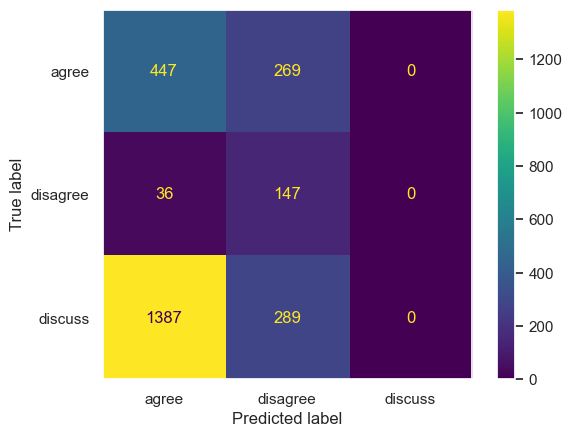

[2023-04-22 15:27:33] Classification Report:
[2023-04-22 15:27:33]               precision    recall  f1-score   support

           0       0.24      0.62      0.35       716
           1       0.21      0.80      0.33       183
           2       0.00      0.00      0.00      1676

    accuracy                           0.23      2575
   macro avg       0.15      0.48      0.23      2575
weighted avg       0.08      0.23      0.12      2575

[2023-04-22 15:27:33] Epoch Accuracy {'accuracy': 0.23067961165048545}
[2023-04-22 15:27:33] Finished validation evaluation
[2023-04-22 15:27:33] Early stopping triggered, best validation loss achieved at 2 (loss: 1.2954274390980323)
[2023-04-22 15:27:33] Loading best model (epoch 1.2954274390980323) for evaluation


F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

[2023-04-22 15:27:33] Starting test evaluation
[2023-04-22 15:27:33] Using model to generate predictions
[2023-04-22 15:27:33] Set model to eval mode


  0%|          | 0/883 [00:00<?, ?it/s]

[2023-04-22 15:29:06] Set model to train mode


F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

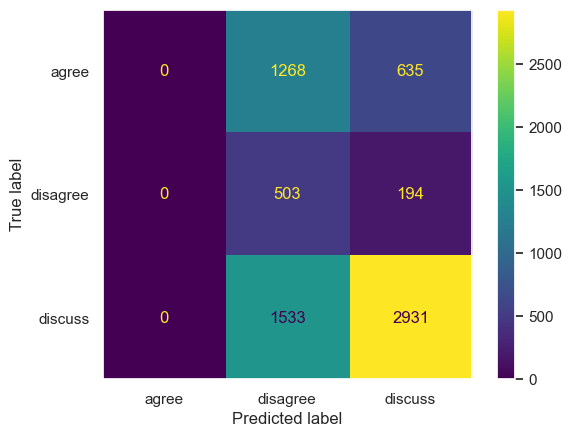

[2023-04-22 15:29:16] Classification Report:
[2023-04-22 15:29:16]               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1903
           1       0.15      0.72      0.25       697
           2       0.78      0.66      0.71      4464

    accuracy                           0.49      7064
   macro avg       0.31      0.46      0.32      7064
weighted avg       0.51      0.49      0.48      7064

[2023-04-22 15:29:16] Finished test evaluation


F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

In [112]:
model_trainer.train()

### LSTM Disagree Amplify

In [119]:
class TransformerRNN(nn.Module):
    def __init__(self, transformer, rnn_type, stacked_layers, hidden_dim, output_dim, bidirectional, dropout_prob):
        super().__init__()
        
        self.transformer = transformer
        embedding_dim = transformer.config.to_dict()["hidden_size"]
        
        rnn_class = None
        
        if rnn_type.lower() == "lstm":
            rnn_class = nn.LSTM
        elif rnn_type.lower() == "gru":
            rnn_class = nn.GRU
        else:
            assert 1 == 0, "Invalid RNN type"
        
        self.rnn_type = rnn_type
        self.rnn = rnn_class(embedding_dim, hidden_dim, num_layers=stacked_layers, bidirectional=bidirectional, batch_first=True, dropout=dropout_prob)
        self.classifier = nn.Linear(hidden_dim * (1 + bidirectional), output_dim)
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, ids, mask):
        embeddings = self.transformer(input_ids=ids, attention_mask=mask)[0]
        
        if self.rnn_type == "gru":
            _, hidden_state = self.rnn(embeddings)
        else:
            _, (hidden_state, _) = self.rnn(embeddings)
        
        if self.rnn.bidirectional:
            hidden_state = self.dropout(torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim=1))
        else:
            hidden_state = self.dropout(hidden_state[-1,:,:])
        
        return self.classifier(hidden_state)

In [120]:
transformer = AutoModel.from_pretrained(selected_transformer_name)

model_trainer = TransformerBasedModelTrainer(
    model_class=TransformerRNN,
    model_transformer=transformer,
    model_freeze_transformer=False,
    model_config={
        "rnn_type": "lstm",
        "stacked_layers": 2,
        "hidden_dim": 256,
        "output_dim": 3,
        "dropout_prob": 0.1,
        "bidirectional": True,
    },
    optimiser_class=optim.AdamW,
    optimiser_config={
        "lr": 5e-5
    },
    hf_scheduler_name="linear",
    hf_scheduler_config={
        "num_warmup_steps": 0,
        "num_training_steps": 8 * (len(train_dataset) + 1) // 8
    },
    loss_class=nn.CrossEntropyLoss,
    batch_size=8,
    max_epochs=8,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    label_names=list(labels2id.keys()),
    sampling_weight_fn=[
      0.18374558303886923,
      0.3476188932473174,
      0.46863552371381334
    ],
    no_improvement_epochs_stop=1,
    eval_batch_size=None,
    loss_weights=None,
    device="cuda:0",
    excluded_freeze=None
)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model Initialised
TransformerRNN(
  (transformer): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

[2023-04-23 15:09:43] Starting epoch 1
[2023-04-23 15:09:43] Starting epoch training
[2023-04-23 15:09:43] Set model to train mode


  0%|          | 0/1340 [00:00<?, ?it/s]

[2023-04-23 15:09:57][1:40] Loss: 0.819
[2023-04-23 15:09:57][1:40] LR: 4.98088399850802e-05
[2023-04-23 15:10:11][1:80] Loss: 0.588
[2023-04-23 15:10:11][1:80] LR: 4.962234240954868e-05
[2023-04-23 15:10:24][1:120] Loss: 0.706
[2023-04-23 15:10:24][1:120] LR: 4.943584483401716e-05
[2023-04-23 15:10:37][1:160] Loss: 0.586
[2023-04-23 15:10:37][1:160] LR: 4.924934725848564e-05
[2023-04-23 15:10:50][1:200] Loss: 0.643
[2023-04-23 15:10:50][1:200] LR: 4.906284968295413e-05
Class 1 exhausted, falling back to randomised sampling fromthe class
[2023-04-23 15:11:03][1:240] Loss: 0.741
[2023-04-23 15:11:03][1:240] LR: 4.887635210742261e-05
[2023-04-23 15:11:16][1:280] Loss: 0.795
[2023-04-23 15:11:16][1:280] LR: 4.868985453189109e-05
[2023-04-23 15:11:29][1:320] Loss: 0.871
[2023-04-23 15:11:29][1:320] LR: 4.850335695635957e-05
[2023-04-23 15:11:43][1:360] Loss: 0.807
[2023-04-23 15:11:43][1:360] LR: 4.831685938082805e-05
[2023-04-23 15:11:56][1:400] Loss: 0.830
[2023-04-23 15:11:56][1:400] LR

  0%|          | 0/338 [00:00<?, ?it/s]

[2023-04-23 15:17:37] Set model to train mode


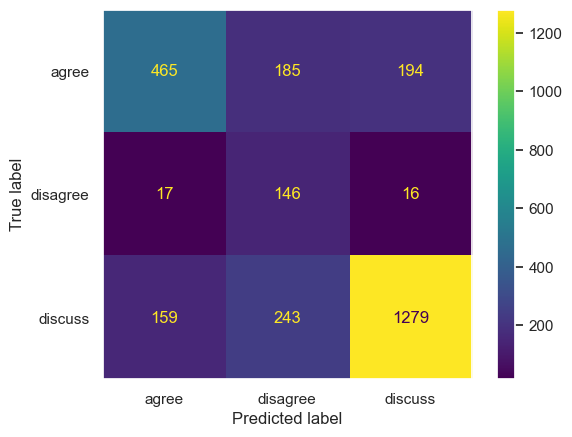

[2023-04-23 15:17:42] Classification Report:
[2023-04-23 15:17:42]               precision    recall  f1-score   support

           0       0.73      0.55      0.63       844
           1       0.25      0.82      0.39       179
           2       0.86      0.76      0.81      1681

    accuracy                           0.70      2704
   macro avg       0.61      0.71      0.61      2704
weighted avg       0.78      0.70      0.72      2704

[2023-04-23 15:17:42] Epoch Accuracy {'accuracy': 0.6989644970414202}
[2023-04-23 15:17:42] Finished validation evaluation
[2023-04-23 15:17:42] Beat best validation loss, new validation loss: 0.794769353663119 (surpassed 1000000000.0 from epoch -1)
[2023-04-23 15:17:43] Saved best model
[2023-04-23 15:17:43] Logged to wandb
[2023-04-23 15:17:43] Starting epoch 2
[2023-04-23 15:17:43] Starting epoch training
[2023-04-23 15:17:43] Set model to train mode


  0%|          | 0/1340 [00:00<?, ?it/s]

[2023-04-23 15:17:57][2:40] Loss: 0.378
[2023-04-23 15:17:57][2:40] LR: 4.356117120477434e-05
[2023-04-23 15:18:10][2:80] Loss: 0.299
[2023-04-23 15:18:10][2:80] LR: 4.337467362924282e-05
[2023-04-23 15:18:23][2:120] Loss: 0.343
[2023-04-23 15:18:23][2:120] LR: 4.31881760537113e-05
[2023-04-23 15:18:36][2:160] Loss: 0.318
[2023-04-23 15:18:36][2:160] LR: 4.3001678478179784e-05
[2023-04-23 15:18:49][2:200] Loss: 0.318
[2023-04-23 15:18:49][2:200] LR: 4.2815180902648265e-05
Class 1 exhausted, falling back to randomised sampling fromthe class
[2023-04-23 15:19:03][2:240] Loss: 0.362
[2023-04-23 15:19:03][2:240] LR: 4.2628683327116746e-05
[2023-04-23 15:19:16][2:280] Loss: 0.345
[2023-04-23 15:19:16][2:280] LR: 4.244218575158523e-05
[2023-04-23 15:19:29][2:320] Loss: 0.380
[2023-04-23 15:19:29][2:320] LR: 4.2255688176053714e-05
[2023-04-23 15:19:42][2:360] Loss: 0.308
[2023-04-23 15:19:42][2:360] LR: 4.2069190600522195e-05
[2023-04-23 15:19:55][2:400] Loss: 0.276
[2023-04-23 15:19:55][2:40

  0%|          | 0/338 [00:00<?, ?it/s]

[2023-04-23 15:25:41] Set model to train mode


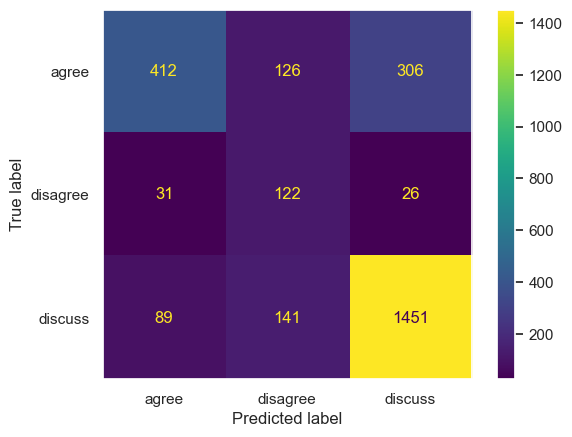

[2023-04-23 15:25:45] Classification Report:
[2023-04-23 15:25:45]               precision    recall  f1-score   support

           0       0.77      0.49      0.60       844
           1       0.31      0.68      0.43       179
           2       0.81      0.86      0.84      1681

    accuracy                           0.73      2704
   macro avg       0.63      0.68      0.62      2704
weighted avg       0.77      0.73      0.74      2704

[2023-04-23 15:25:45] Epoch Accuracy {'accuracy': 0.7340976331360947}
[2023-04-23 15:25:45] Finished validation evaluation
[2023-04-23 15:25:45] Beat best validation loss, new validation loss: 0.7264260407027474 (surpassed 0.794769353663119 from epoch 1)
[2023-04-23 15:25:46] Saved best model
[2023-04-23 15:25:46] Logged to wandb
[2023-04-23 15:25:46] Starting epoch 3
[2023-04-23 15:25:46] Starting epoch training
[2023-04-23 15:25:46] Set model to train mode


  0%|          | 0/1340 [00:00<?, ?it/s]

[2023-04-23 15:26:00][3:40] Loss: 0.202
[2023-04-23 15:26:00][3:40] LR: 3.7313502424468484e-05
[2023-04-23 15:26:13][3:80] Loss: 0.178
[2023-04-23 15:26:13][3:80] LR: 3.7127004848936965e-05
[2023-04-23 15:26:26][3:120] Loss: 0.155
[2023-04-23 15:26:26][3:120] LR: 3.694050727340545e-05
[2023-04-23 15:26:39][3:160] Loss: 0.138
[2023-04-23 15:26:39][3:160] LR: 3.6754009697873934e-05
[2023-04-23 15:26:53][3:200] Loss: 0.154
[2023-04-23 15:26:53][3:200] LR: 3.6567512122342415e-05
Class 1 exhausted, falling back to randomised sampling fromthe class
[2023-04-23 15:27:06][3:240] Loss: 0.180
[2023-04-23 15:27:06][3:240] LR: 3.6381014546810895e-05
[2023-04-23 15:27:19][3:280] Loss: 0.170
[2023-04-23 15:27:19][3:280] LR: 3.6194516971279376e-05
[2023-04-23 15:27:32][3:320] Loss: 0.237
[2023-04-23 15:27:32][3:320] LR: 3.600801939574786e-05
[2023-04-23 15:27:45][3:360] Loss: 0.179
[2023-04-23 15:27:45][3:360] LR: 3.5821521820216345e-05
[2023-04-23 15:27:58][3:400] Loss: 0.211
[2023-04-23 15:27:58][3

  0%|          | 0/338 [00:00<?, ?it/s]

[2023-04-23 15:33:40] Set model to train mode


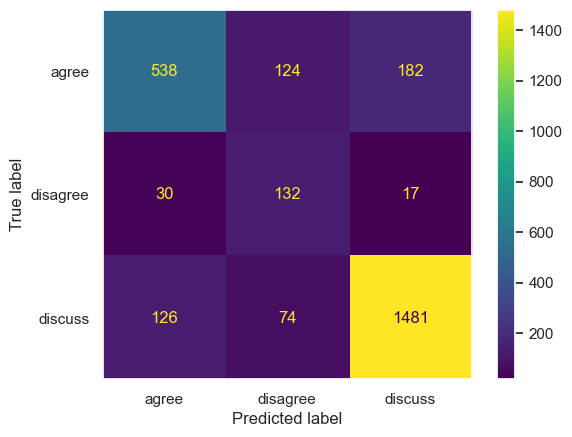

[2023-04-23 15:33:45] Classification Report:
[2023-04-23 15:33:45]               precision    recall  f1-score   support

           0       0.78      0.64      0.70       844
           1       0.40      0.74      0.52       179
           2       0.88      0.88      0.88      1681

    accuracy                           0.80      2704
   macro avg       0.69      0.75      0.70      2704
weighted avg       0.82      0.80      0.80      2704

[2023-04-23 15:33:45] Epoch Accuracy {'accuracy': 0.7954881656804734}
[2023-04-23 15:33:45] Finished validation evaluation
[2023-04-23 15:33:45] Beat best validation loss, new validation loss: 0.7121880173816802 (surpassed 0.7264260407027474 from epoch 2)
[2023-04-23 15:33:46] Saved best model
[2023-04-23 15:33:46] Logged to wandb
[2023-04-23 15:33:46] Starting epoch 4
[2023-04-23 15:33:46] Starting epoch training
[2023-04-23 15:33:46] Set model to train mode


  0%|          | 0/1340 [00:00<?, ?it/s]

[2023-04-23 15:34:00][4:40] Loss: 0.128
[2023-04-23 15:34:00][4:40] LR: 3.106583364416263e-05
[2023-04-23 15:34:13][4:80] Loss: 0.083
[2023-04-23 15:34:13][4:80] LR: 3.087933606863111e-05
[2023-04-23 15:34:26][4:120] Loss: 0.110
[2023-04-23 15:34:26][4:120] LR: 3.069283849309959e-05
[2023-04-23 15:34:39][4:160] Loss: 0.093
[2023-04-23 15:34:39][4:160] LR: 3.050634091756807e-05
[2023-04-23 15:34:52][4:200] Loss: 0.072
[2023-04-23 15:34:52][4:200] LR: 3.031984334203655e-05
Class 1 exhausted, falling back to randomised sampling fromthe class
[2023-04-23 15:35:05][4:240] Loss: 0.094
[2023-04-23 15:35:05][4:240] LR: 3.013334576650504e-05
[2023-04-23 15:35:18][4:280] Loss: 0.074
[2023-04-23 15:35:18][4:280] LR: 2.994684819097352e-05
[2023-04-23 15:35:32][4:320] Loss: 0.091
[2023-04-23 15:35:32][4:320] LR: 2.9760350615442e-05
[2023-04-23 15:35:45][4:360] Loss: 0.066
[2023-04-23 15:35:45][4:360] LR: 2.957385303991048e-05
[2023-04-23 15:35:58][4:400] Loss: 0.069
[2023-04-23 15:35:58][4:400] LR:

  0%|          | 0/338 [00:00<?, ?it/s]

[2023-04-23 15:41:41] Set model to train mode


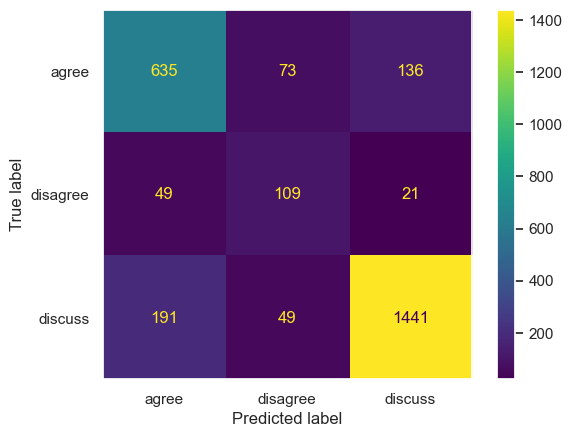

[2023-04-23 15:41:45] Classification Report:
[2023-04-23 15:41:45]               precision    recall  f1-score   support

           0       0.73      0.75      0.74       844
           1       0.47      0.61      0.53       179
           2       0.90      0.86      0.88      1681

    accuracy                           0.81      2704
   macro avg       0.70      0.74      0.72      2704
weighted avg       0.82      0.81      0.81      2704

[2023-04-23 15:41:45] Epoch Accuracy {'accuracy': 0.8080621301775148}
[2023-04-23 15:41:45] Finished validation evaluation
[2023-04-23 15:41:45] Early stopping triggered, best validation loss achieved at 3 (loss: 0.7121880173816802)
[2023-04-23 15:41:45] Loading best model (epoch 0.7121880173816802) for evaluation
[2023-04-23 15:41:45] Starting test evaluation
[2023-04-23 15:41:45] Using model to generate predictions
[2023-04-23 15:41:45] Set model to eval mode


  0%|          | 0/883 [00:00<?, ?it/s]

[2023-04-23 15:43:19] Set model to train mode


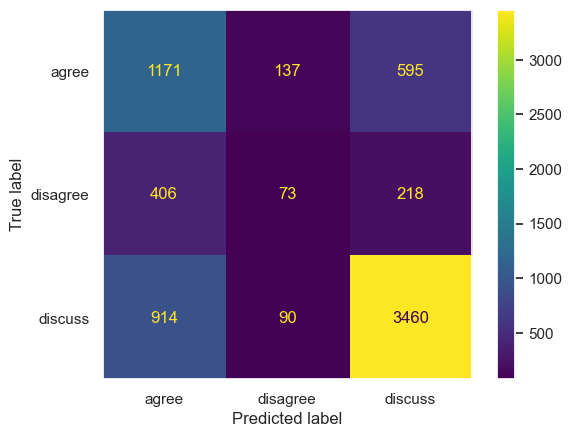

[2023-04-23 15:43:23] Classification Report:
[2023-04-23 15:43:23]               precision    recall  f1-score   support

           0       0.47      0.62      0.53      1903
           1       0.24      0.10      0.15       697
           2       0.81      0.78      0.79      4464

    accuracy                           0.67      7064
   macro avg       0.51      0.50      0.49      7064
weighted avg       0.66      0.67      0.66      7064

[2023-04-23 15:43:23] Finished test evaluation


In [121]:
model_trainer.train()

### CNN+LSTM Balanced

In [101]:
class TransformerCNNRNNHybrid(nn.Module):
    def __init__(self, transformer, rnn_type, stacked_layers, hidden_dim, output_dim, bidirectional, dropout_prob):
        super().__init__()
        
        self.transformer = transformer
        embedding_dim = transformer.config.to_dict()["hidden_size"]
        
        rnn_class = None
        
        if rnn_type.lower() == "lstm":
            rnn_class = nn.LSTM
        elif rnn_type.lower() == "gru":
            rnn_class = nn.GRU
        else:
            assert 1 == 0, "Invalid RNN type"
            
        self.convolutions = nn.Sequential(
            nn.Conv1d(768, 512, 5, padding=2),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Conv1d(512, 256, 5, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_prob)
            # nn.MaxPool1d(1),
        )
        
        self.rnn_type = rnn_type
        self.rnn = rnn_class(256, hidden_dim, num_layers=stacked_layers, bidirectional=bidirectional, batch_first=True, dropout=dropout_prob)
        self.classifier = nn.Linear(hidden_dim * (1 + bidirectional), output_dim)
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, ids, mask):
        embeddings = self.transformer(input_ids=ids, attention_mask=mask)[0]
        
        embeddings = embeddings.permute(0, 2, 1)
        embeddings = self.convolutions(embeddings)
        embeddings = embeddings.permute(0, 2, 1)
        
        if self.rnn_type == "gru":
            _, hidden_state = self.rnn(embeddings)
        else:
            _, (hidden_state, _) = self.rnn(embeddings)
        
        if self.rnn.bidirectional:
            hidden_state = self.dropout(torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim=1))
        else:
            hidden_state = self.dropout(hidden_state[-1,:,:])
        
        return self.classifier(hidden_state)

In [102]:
transformer = AutoModel.from_pretrained(selected_transformer_name)

model_trainer = TransformerBasedModelTrainer(
    model_class=TransformerCNNRNNHybrid,
    model_transformer=transformer,
    model_freeze_transformer=False,
    model_config={
        "rnn_type": "lstm",
        "stacked_layers": 2,
        "hidden_dim": 256,
        "output_dim": 3,
        "dropout_prob": 0.1,
        "bidirectional": True,
    },
    optimiser_class=optim.AdamW,
    optimiser_config={
        "lr": 5e-5
    },
    hf_scheduler_name="linear",
    hf_scheduler_config={
        "num_warmup_steps": 0,
        "num_training_steps": 8 * (len(train_dataset) + 1) // 8
    },
    loss_class=nn.CrossEntropyLoss,
    batch_size=8,
    max_epochs=8,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    label_names=list(labels2id.keys()),
    sampling_weight_fn="balanced",
    no_improvement_epochs_stop=2,
    eval_batch_size=None,
    loss_weights=None,
    device="cuda:0",
    excluded_freeze=None
)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model Initialised
TransformerCNNRNNHybrid(
  (transformer): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
        

[2023-04-23 12:05:48] Starting epoch 1
[2023-04-23 12:05:48] Starting epoch training
[2023-04-23 12:05:48] Set model to train mode


  0%|          | 0/1340 [00:00<?, ?it/s]

[2023-04-23 12:06:02][1:40] Loss: 0.821
[2023-04-23 12:06:02][1:40] LR: 4.98088399850802e-05
[2023-04-23 12:06:16][1:80] Loss: 0.592
[2023-04-23 12:06:16][1:80] LR: 4.962234240954868e-05
[2023-04-23 12:06:29][1:120] Loss: 0.544
[2023-04-23 12:06:29][1:120] LR: 4.943584483401716e-05
[2023-04-23 12:06:43][1:160] Loss: 0.596
[2023-04-23 12:06:43][1:160] LR: 4.924934725848564e-05
[2023-04-23 12:06:57][1:200] Loss: 0.633
[2023-04-23 12:06:57][1:200] LR: 4.906284968295413e-05
[2023-04-23 12:07:11][1:240] Loss: 0.612
[2023-04-23 12:07:11][1:240] LR: 4.887635210742261e-05
Class 1 exhausted, falling back to randomised sampling fromthe class
[2023-04-23 12:07:25][1:280] Loss: 0.874
[2023-04-23 12:07:25][1:280] LR: 4.868985453189109e-05
[2023-04-23 12:07:39][1:320] Loss: 0.778
[2023-04-23 12:07:39][1:320] LR: 4.850335695635957e-05
[2023-04-23 12:07:52][1:360] Loss: 0.747
[2023-04-23 12:07:52][1:360] LR: 4.831685938082805e-05
[2023-04-23 12:08:06][1:400] Loss: 0.772
[2023-04-23 12:08:06][1:400] LR

  0%|          | 0/338 [00:00<?, ?it/s]

[2023-04-23 12:14:01] Set model to train mode


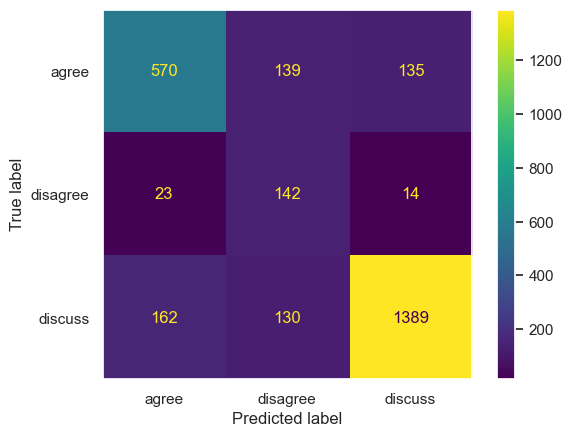

[2023-04-23 12:14:05] Classification Report:
[2023-04-23 12:14:05]               precision    recall  f1-score   support

           0       0.75      0.68      0.71       844
           1       0.35      0.79      0.48       179
           2       0.90      0.83      0.86      1681

    accuracy                           0.78      2704
   macro avg       0.67      0.76      0.69      2704
weighted avg       0.82      0.78      0.79      2704

[2023-04-23 12:14:05] Epoch Accuracy {'accuracy': 0.7769970414201184}
[2023-04-23 12:14:05] Finished validation evaluation
[2023-04-23 12:14:05] Beat best validation loss, new validation loss: 0.6243079592275417 (surpassed 1000000000.0 from epoch -1)
[2023-04-23 12:14:07] Saved best model
[2023-04-23 12:14:07] Logged to wandb
[2023-04-23 12:14:07] Starting epoch 2
[2023-04-23 12:14:07] Starting epoch training
[2023-04-23 12:14:07] Set model to train mode


  0%|          | 0/1340 [00:00<?, ?it/s]

[2023-04-23 12:14:21][2:40] Loss: 0.361
[2023-04-23 12:14:21][2:40] LR: 4.356117120477434e-05
[2023-04-23 12:14:34][2:80] Loss: 0.211
[2023-04-23 12:14:34][2:80] LR: 4.337467362924282e-05
[2023-04-23 12:14:48][2:120] Loss: 0.206
[2023-04-23 12:14:48][2:120] LR: 4.31881760537113e-05
[2023-04-23 12:15:02][2:160] Loss: 0.239
[2023-04-23 12:15:02][2:160] LR: 4.3001678478179784e-05
[2023-04-23 12:15:15][2:200] Loss: 0.333
[2023-04-23 12:15:15][2:200] LR: 4.2815180902648265e-05
[2023-04-23 12:15:28][2:240] Loss: 0.260
[2023-04-23 12:15:28][2:240] LR: 4.2628683327116746e-05
Class 1 exhausted, falling back to randomised sampling fromthe class
[2023-04-23 12:15:42][2:280] Loss: 0.363
[2023-04-23 12:15:42][2:280] LR: 4.244218575158523e-05
[2023-04-23 12:15:55][2:320] Loss: 0.316
[2023-04-23 12:15:55][2:320] LR: 4.2255688176053714e-05
[2023-04-23 12:16:09][2:360] Loss: 0.303
[2023-04-23 12:16:09][2:360] LR: 4.2069190600522195e-05
[2023-04-23 12:16:22][2:400] Loss: 0.274
[2023-04-23 12:16:22][2:40

  0%|          | 0/338 [00:00<?, ?it/s]

[2023-04-23 12:22:19] Set model to train mode


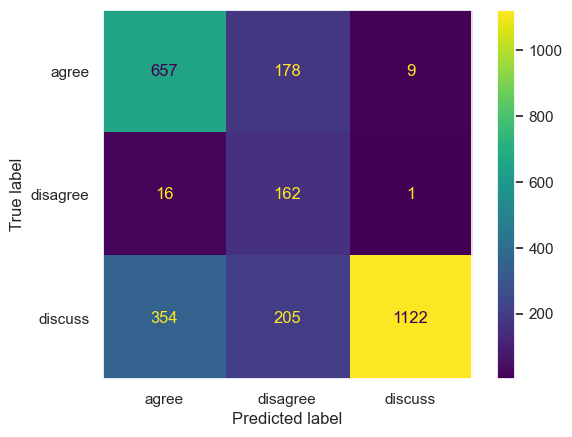

[2023-04-23 12:22:24] Classification Report:
[2023-04-23 12:22:24]               precision    recall  f1-score   support

           0       0.64      0.78      0.70       844
           1       0.30      0.91      0.45       179
           2       0.99      0.67      0.80      1681

    accuracy                           0.72      2704
   macro avg       0.64      0.78      0.65      2704
weighted avg       0.84      0.72      0.74      2704

[2023-04-23 12:22:24] Epoch Accuracy {'accuracy': 0.7178254437869822}
[2023-04-23 12:22:24] Finished validation evaluation
[2023-04-23 12:22:24] Logged to wandb
[2023-04-23 12:22:24] Starting epoch 3
[2023-04-23 12:22:24] Starting epoch training
[2023-04-23 12:22:24] Set model to train mode


  0%|          | 0/1340 [00:00<?, ?it/s]

[2023-04-23 12:22:38][3:40] Loss: 0.237
[2023-04-23 12:22:38][3:40] LR: 3.7313502424468484e-05
[2023-04-23 12:22:51][3:80] Loss: 0.149
[2023-04-23 12:22:51][3:80] LR: 3.7127004848936965e-05
[2023-04-23 12:23:05][3:120] Loss: 0.126
[2023-04-23 12:23:05][3:120] LR: 3.694050727340545e-05
[2023-04-23 12:23:19][3:160] Loss: 0.137
[2023-04-23 12:23:19][3:160] LR: 3.6754009697873934e-05
[2023-04-23 12:23:32][3:200] Loss: 0.145
[2023-04-23 12:23:32][3:200] LR: 3.6567512122342415e-05
[2023-04-23 12:23:46][3:240] Loss: 0.128
[2023-04-23 12:23:46][3:240] LR: 3.6381014546810895e-05
Class 1 exhausted, falling back to randomised sampling fromthe class
[2023-04-23 12:23:59][3:280] Loss: 0.205
[2023-04-23 12:23:59][3:280] LR: 3.6194516971279376e-05
[2023-04-23 12:24:13][3:320] Loss: 0.129
[2023-04-23 12:24:13][3:320] LR: 3.600801939574786e-05
[2023-04-23 12:24:26][3:360] Loss: 0.122
[2023-04-23 12:24:26][3:360] LR: 3.5821521820216345e-05
[2023-04-23 12:24:39][3:400] Loss: 0.113
[2023-04-23 12:24:39][3

  0%|          | 0/338 [00:00<?, ?it/s]

[2023-04-23 12:30:30] Set model to train mode


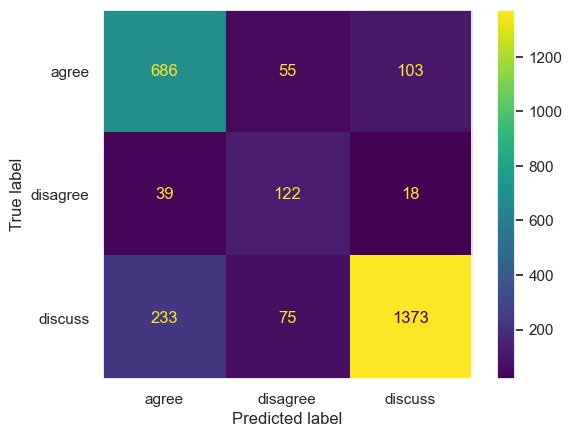

[2023-04-23 12:30:34] Classification Report:
[2023-04-23 12:30:34]               precision    recall  f1-score   support

           0       0.72      0.81      0.76       844
           1       0.48      0.68      0.57       179
           2       0.92      0.82      0.86      1681

    accuracy                           0.81      2704
   macro avg       0.71      0.77      0.73      2704
weighted avg       0.83      0.81      0.81      2704

[2023-04-23 12:30:34] Epoch Accuracy {'accuracy': 0.8065828402366864}
[2023-04-23 12:30:34] Finished validation evaluation
[2023-04-23 12:30:34] Early stopping triggered, best validation loss achieved at 1 (loss: 0.6243079592275417)
[2023-04-23 12:30:34] Loading best model (epoch 0.6243079592275417) for evaluation
[2023-04-23 12:30:34] Starting test evaluation
[2023-04-23 12:30:34] Using model to generate predictions
[2023-04-23 12:30:34] Set model to eval mode


  0%|          | 0/883 [00:00<?, ?it/s]

[2023-04-23 12:32:10] Set model to train mode


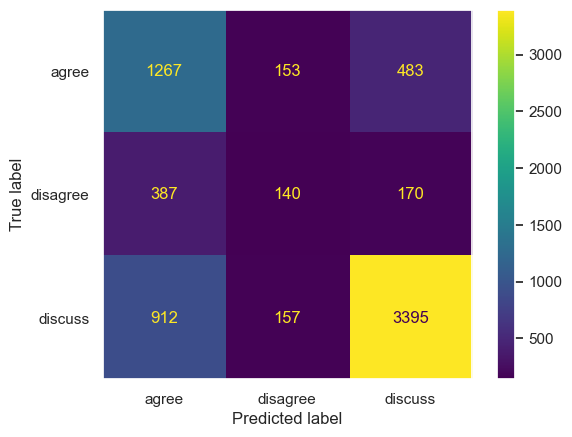

[2023-04-23 12:32:14] Classification Report:
[2023-04-23 12:32:14]               precision    recall  f1-score   support

           0       0.49      0.67      0.57      1903
           1       0.31      0.20      0.24       697
           2       0.84      0.76      0.80      4464

    accuracy                           0.68      7064
   macro avg       0.55      0.54      0.54      7064
weighted avg       0.69      0.68      0.68      7064

[2023-04-23 12:32:14] Finished test evaluation


In [103]:
model_trainer.train()

### CNN+LSTM Specific Distribution

In [127]:
class TransformerCNNRNNHybrid(nn.Module):
    def __init__(self, transformer, rnn_type, stacked_layers, hidden_dim, output_dim, bidirectional, dropout_prob):
        super().__init__()
        
        self.transformer = transformer
        embedding_dim = transformer.config.to_dict()["hidden_size"]
        
        rnn_class = None
        
        if rnn_type.lower() == "lstm":
            rnn_class = nn.LSTM
        elif rnn_type.lower() == "gru":
            rnn_class = nn.GRU
        else:
            assert 1 == 0, "Invalid RNN type"
            
        self.convolutions = nn.Sequential(
            nn.Conv1d(768, 512, 5, padding=2),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Conv1d(512, 256, 5, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_prob)
            # nn.MaxPool1d(1),
        )
        
        self.rnn_type = rnn_type
        self.rnn = rnn_class(256, hidden_dim, num_layers=stacked_layers, bidirectional=bidirectional, batch_first=True, dropout=dropout_prob)
        self.classifier = nn.Linear(hidden_dim * (1 + bidirectional), output_dim)
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, ids, mask):
        embeddings = self.transformer(input_ids=ids, attention_mask=mask)[0]
        
        embeddings = embeddings.permute(0, 2, 1)
        embeddings = self.convolutions(embeddings)
        embeddings = embeddings.permute(0, 2, 1)
        
        if self.rnn_type == "gru":
            _, hidden_state = self.rnn(embeddings)
        else:
            _, (hidden_state, _) = self.rnn(embeddings)
        
        if self.rnn.bidirectional:
            hidden_state = self.dropout(torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim=1))
        else:
            hidden_state = self.dropout(hidden_state[-1,:,:])
        
        return self.classifier(hidden_state)

In [128]:
transformer = AutoModel.from_pretrained(selected_transformer_name)

model_trainer = TransformerBasedModelTrainer(
    model_class=TransformerCNNRNNHybrid,
    model_transformer=transformer,
    model_freeze_transformer=False,
    model_config={
        "rnn_type": "lstm",
        "stacked_layers": 2,
        "hidden_dim": 256,
        "output_dim": 3,
        "dropout_prob": 0.1,
        "bidirectional": True,
    },
    optimiser_class=optim.AdamW,
    optimiser_config={
        "lr": 5e-5
    },
    hf_scheduler_name="linear",
    hf_scheduler_config={
        "num_warmup_steps": 0,
        "num_training_steps": 8 * (len(train_dataset) + 1) // 8
    },
    loss_class=nn.CrossEntropyLoss,
    batch_size=8,
    max_epochs=8,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    label_names=list(labels2id.keys()),
    sampling_weight_fn=[0.375, 0.4, 0.2],
    no_improvement_epochs_stop=2,
    eval_batch_size=None,
    loss_weights=None,
    device="cuda:0",
    excluded_freeze=None
)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model Initialised
TransformerCNNRNNHybrid(
  (transformer): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
        

[2023-04-22 16:24:11] Starting epoch 1
[2023-04-22 16:24:11] Starting epoch training
[2023-04-22 16:24:11] Set model to train mode


  0%|          | 0/1356 [00:00<?, ?it/s]

[2023-04-22 16:24:25][1:40] Loss: 0.850
[2023-04-22 16:24:25][1:40] LR: 4.9811112134893576e-05
[2023-04-22 16:24:38][1:80] Loss: 0.648
[2023-04-22 16:24:38][1:80] LR: 4.962683129088732e-05
[2023-04-22 16:24:52][1:120] Loss: 0.666
[2023-04-22 16:24:52][1:120] LR: 4.944255044688105e-05
[2023-04-22 16:25:05][1:160] Loss: 0.553
[2023-04-22 16:25:05][1:160] LR: 4.925826960287478e-05
[2023-04-22 16:25:18][1:200] Loss: 0.519
[2023-04-22 16:25:18][1:200] LR: 4.907398875886852e-05
Class 1 exhausted, falling back to randomised sampling fromthe class
[2023-04-22 16:25:32][1:240] Loss: 0.959
[2023-04-22 16:25:32][1:240] LR: 4.8889707914862254e-05
[2023-04-22 16:25:45][1:280] Loss: 0.729
[2023-04-22 16:25:45][1:280] LR: 4.870542707085598e-05
[2023-04-22 16:25:59][1:320] Loss: 0.727
[2023-04-22 16:25:59][1:320] LR: 4.8521146226849726e-05
[2023-04-22 16:26:12][1:360] Loss: 0.771
[2023-04-22 16:26:12][1:360] LR: 4.8336865382843455e-05
[2023-04-22 16:26:26][1:400] Loss: 0.638
[2023-04-22 16:26:26][1:40

  0%|          | 0/322 [00:00<?, ?it/s]

[2023-04-22 16:32:20] Set model to train mode


Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--accuracy\f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Fri Mar 31 21:15:28 2023) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--precision\4e7f439a346715f68500ce6f2be82bf3272abd3f20bdafd203a2c4f85b61dd5f (last modified on Fri Mar 31 21:16:47 2023) since it couldn't be found locally at evaluate-metric--precision, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--recall\e40e6e98d18ff3f210f4d0b26fa721bfaa80704b1fdf890fa551cfabf94fc185 (last modified on Fri Mar 31 21:38:10 2023) since it couldn't be found locally at

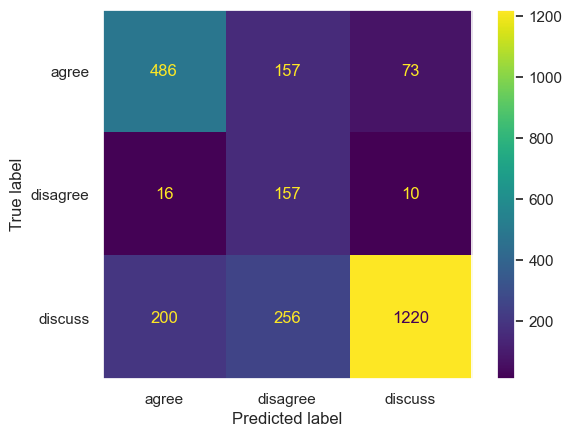

[2023-04-22 16:32:30] Classification Report:
[2023-04-22 16:32:30]               precision    recall  f1-score   support

           0       0.69      0.68      0.69       716
           1       0.28      0.86      0.42       183
           2       0.94      0.73      0.82      1676

    accuracy                           0.72      2575
   macro avg       0.63      0.75      0.64      2575
weighted avg       0.82      0.72      0.75      2575

[2023-04-22 16:32:30] Epoch Accuracy {'accuracy': 0.723495145631068}
[2023-04-22 16:32:30] Finished validation evaluation
[2023-04-22 16:32:30] Beat best validation loss, new validation loss: 0.8240046608059303 (surpassed 1000000000.0 from epoch -1)
[2023-04-22 16:32:31] Saved best model
[2023-04-22 16:32:31] Logged to wandb
[2023-04-22 16:32:31] Starting epoch 2
[2023-04-22 16:32:31] Starting epoch training
[2023-04-22 16:32:31] Set model to train mode


  0%|          | 0/1356 [00:00<?, ?it/s]

[2023-04-22 16:32:45][2:40] Loss: 0.409
[2023-04-22 16:32:45][2:40] LR: 4.356399152308118e-05
[2023-04-22 16:32:58][2:80] Loss: 0.218
[2023-04-22 16:32:58][2:80] LR: 4.3379710679074914e-05
[2023-04-22 16:33:11][2:120] Loss: 0.200
[2023-04-22 16:33:11][2:120] LR: 4.319542983506864e-05
[2023-04-22 16:33:25][2:160] Loss: 0.162
[2023-04-22 16:33:25][2:160] LR: 4.3011148991062386e-05
[2023-04-22 16:33:38][2:200] Loss: 0.177
[2023-04-22 16:33:38][2:200] LR: 4.2826868147056115e-05
Class 1 exhausted, falling back to randomised sampling fromthe class
[2023-04-22 16:33:51][2:240] Loss: 0.241
[2023-04-22 16:33:51][2:240] LR: 4.264258730304985e-05
[2023-04-22 16:34:05][2:280] Loss: 0.302
[2023-04-22 16:34:05][2:280] LR: 4.2458306459043586e-05
[2023-04-22 16:34:18][2:320] Loss: 0.285
[2023-04-22 16:34:18][2:320] LR: 4.227402561503732e-05
[2023-04-22 16:34:31][2:360] Loss: 0.264
[2023-04-22 16:34:31][2:360] LR: 4.208974477103105e-05
[2023-04-22 16:34:45][2:400] Loss: 0.205
[2023-04-22 16:34:45][2:40

  0%|          | 0/322 [00:00<?, ?it/s]

[2023-04-22 16:40:38] Set model to train mode


Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--accuracy\f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Fri Mar 31 21:15:28 2023) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--precision\4e7f439a346715f68500ce6f2be82bf3272abd3f20bdafd203a2c4f85b61dd5f (last modified on Fri Mar 31 21:16:47 2023) since it couldn't be found locally at evaluate-metric--precision, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--recall\e40e6e98d18ff3f210f4d0b26fa721bfaa80704b1fdf890fa551cfabf94fc185 (last modified on Fri Mar 31 21:38:10 2023) since it couldn't be found locally at

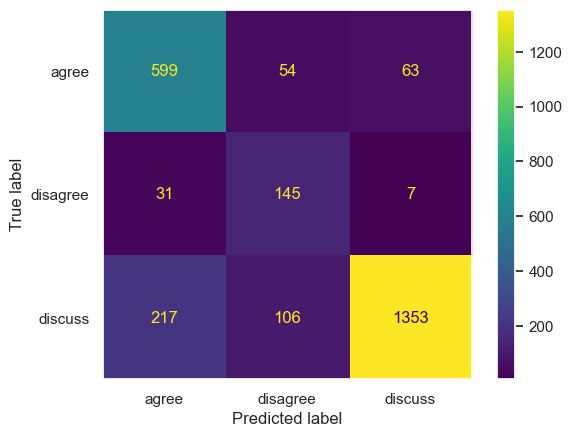

[2023-04-22 16:40:47] Classification Report:
[2023-04-22 16:40:47]               precision    recall  f1-score   support

           0       0.71      0.84      0.77       716
           1       0.48      0.79      0.59       183
           2       0.95      0.81      0.87      1676

    accuracy                           0.81      2575
   macro avg       0.71      0.81      0.74      2575
weighted avg       0.85      0.81      0.82      2575

[2023-04-22 16:40:47] Epoch Accuracy {'accuracy': 0.814368932038835}
[2023-04-22 16:40:47] Finished validation evaluation
[2023-04-22 16:40:47] Beat best validation loss, new validation loss: 0.6220223821377128 (surpassed 0.8240046608059303 from epoch 1)
[2023-04-22 16:40:49] Saved best model
[2023-04-22 16:40:49] Logged to wandb
[2023-04-22 16:40:49] Starting epoch 3
[2023-04-22 16:40:49] Starting epoch training
[2023-04-22 16:40:49] Set model to train mode


  0%|          | 0/1356 [00:00<?, ?it/s]

[2023-04-22 16:41:02][3:40] Loss: 0.072
[2023-04-22 16:41:02][3:40] LR: 3.7316870911268775e-05
[2023-04-22 16:41:16][3:80] Loss: 0.127
[2023-04-22 16:41:16][3:80] LR: 3.713259006726251e-05
[2023-04-22 16:41:29][3:120] Loss: 0.061
[2023-04-22 16:41:29][3:120] LR: 3.6948309223256246e-05
[2023-04-22 16:41:42][3:160] Loss: 0.104
[2023-04-22 16:41:42][3:160] LR: 3.6764028379249975e-05
[2023-04-22 16:41:55][3:200] Loss: 0.073
[2023-04-22 16:41:55][3:200] LR: 3.657974753524371e-05
Class 1 exhausted, falling back to randomised sampling fromthe class
[2023-04-22 16:42:09][3:240] Loss: 0.178
[2023-04-22 16:42:09][3:240] LR: 3.6395466691237447e-05
[2023-04-22 16:42:22][3:280] Loss: 0.049
[2023-04-22 16:42:22][3:280] LR: 3.621118584723118e-05
[2023-04-22 16:42:35][3:320] Loss: 0.071
[2023-04-22 16:42:35][3:320] LR: 3.602690500322491e-05
[2023-04-22 16:42:49][3:360] Loss: 0.110
[2023-04-22 16:42:49][3:360] LR: 3.5842624159218654e-05
[2023-04-22 16:43:02][3:400] Loss: 0.165
[2023-04-22 16:43:02][3:4

  0%|          | 0/322 [00:00<?, ?it/s]

[2023-04-22 16:48:56] Set model to train mode


Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--accuracy\f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Fri Mar 31 21:15:28 2023) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--precision\4e7f439a346715f68500ce6f2be82bf3272abd3f20bdafd203a2c4f85b61dd5f (last modified on Fri Mar 31 21:16:47 2023) since it couldn't be found locally at evaluate-metric--precision, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--recall\e40e6e98d18ff3f210f4d0b26fa721bfaa80704b1fdf890fa551cfabf94fc185 (last modified on Fri Mar 31 21:38:10 2023) since it couldn't be found locally at

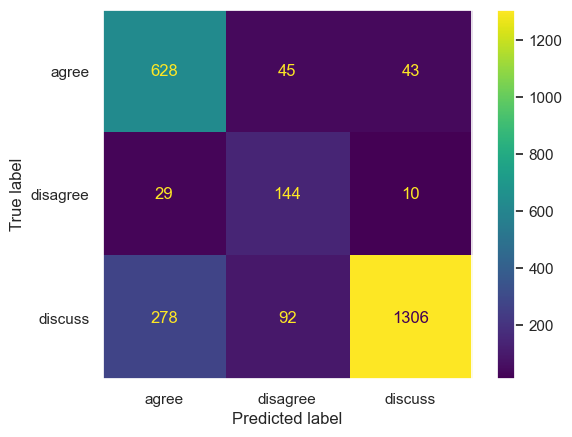

[2023-04-22 16:49:06] Classification Report:
[2023-04-22 16:49:06]               precision    recall  f1-score   support

           0       0.67      0.88      0.76       716
           1       0.51      0.79      0.62       183
           2       0.96      0.78      0.86      1676

    accuracy                           0.81      2575
   macro avg       0.72      0.81      0.75      2575
weighted avg       0.85      0.81      0.82      2575

[2023-04-22 16:49:06] Epoch Accuracy {'accuracy': 0.806990291262136}
[2023-04-22 16:49:06] Finished validation evaluation
[2023-04-22 16:49:06] Logged to wandb
[2023-04-22 16:49:06] Starting epoch 4
[2023-04-22 16:49:06] Starting epoch training
[2023-04-22 16:49:06] Set model to train mode


  0%|          | 0/1356 [00:00<?, ?it/s]

[2023-04-22 16:49:20][4:40] Loss: 0.128
[2023-04-22 16:49:20][4:40] LR: 3.106975029945637e-05
[2023-04-22 16:49:33][4:80] Loss: 0.064
[2023-04-22 16:49:33][4:80] LR: 3.0885469455450107e-05
[2023-04-22 16:49:46][4:120] Loss: 0.066
[2023-04-22 16:49:46][4:120] LR: 3.070118861144384e-05
[2023-04-22 16:50:00][4:160] Loss: 0.024
[2023-04-22 16:50:00][4:160] LR: 3.0516907767437575e-05
Class 1 exhausted, falling back to randomised sampling fromthe class
[2023-04-22 16:50:13][4:200] Loss: 0.047
[2023-04-22 16:50:13][4:200] LR: 3.0332626923431314e-05
[2023-04-22 16:50:26][4:240] Loss: 0.040
[2023-04-22 16:50:26][4:240] LR: 3.0148346079425043e-05
[2023-04-22 16:50:40][4:280] Loss: 0.046
[2023-04-22 16:50:40][4:280] LR: 2.9964065235418782e-05
[2023-04-22 16:50:53][4:320] Loss: 0.081
[2023-04-22 16:50:53][4:320] LR: 2.9779784391412514e-05
[2023-04-22 16:51:06][4:360] Loss: 0.043
[2023-04-22 16:51:06][4:360] LR: 2.959550354740625e-05
[2023-04-22 16:51:20][4:400] Loss: 0.035
[2023-04-22 16:51:20][4:

  0%|          | 0/322 [00:00<?, ?it/s]

[2023-04-22 16:57:13] Set model to train mode


Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--accuracy\f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Fri Mar 31 21:15:28 2023) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--precision\4e7f439a346715f68500ce6f2be82bf3272abd3f20bdafd203a2c4f85b61dd5f (last modified on Fri Mar 31 21:16:47 2023) since it couldn't be found locally at evaluate-metric--precision, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--recall\e40e6e98d18ff3f210f4d0b26fa721bfaa80704b1fdf890fa551cfabf94fc185 (last modified on Fri Mar 31 21:38:10 2023) since it couldn't be found locally at

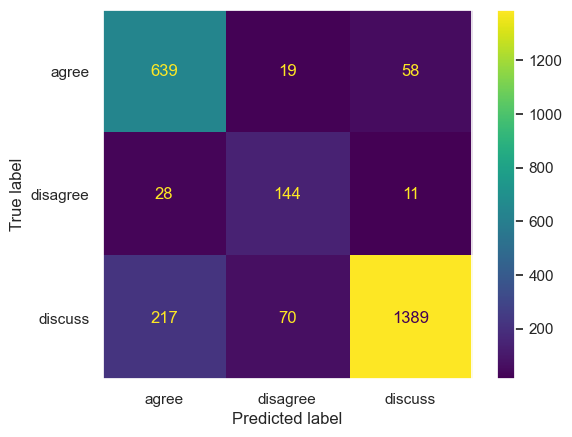

[2023-04-22 16:57:23] Classification Report:
[2023-04-22 16:57:23]               precision    recall  f1-score   support

           0       0.72      0.89      0.80       716
           1       0.62      0.79      0.69       183
           2       0.95      0.83      0.89      1676

    accuracy                           0.84      2575
   macro avg       0.76      0.84      0.79      2575
weighted avg       0.86      0.84      0.85      2575

[2023-04-22 16:57:23] Epoch Accuracy {'accuracy': 0.843495145631068}
[2023-04-22 16:57:23] Finished validation evaluation
[2023-04-22 16:57:23] Early stopping triggered, best validation loss achieved at 2 (loss: 0.6220223821377128)
[2023-04-22 16:57:23] Loading best model (epoch 0.6220223821377128) for evaluation
[2023-04-22 16:57:23] Starting test evaluation
[2023-04-22 16:57:23] Using model to generate predictions
[2023-04-22 16:57:23] Set model to eval mode


  0%|          | 0/883 [00:00<?, ?it/s]

[2023-04-22 16:59:00] Set model to train mode


Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--accuracy\f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Fri Mar 31 21:15:28 2023) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--precision\4e7f439a346715f68500ce6f2be82bf3272abd3f20bdafd203a2c4f85b61dd5f (last modified on Fri Mar 31 21:16:47 2023) since it couldn't be found locally at evaluate-metric--precision, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--recall\e40e6e98d18ff3f210f4d0b26fa721bfaa80704b1fdf890fa551cfabf94fc185 (last modified on Fri Mar 31 21:38:10 2023) since it couldn't be found locally at

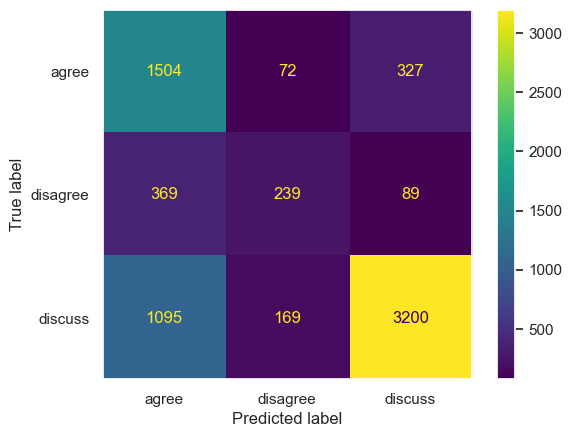

[2023-04-22 16:59:10] Classification Report:
[2023-04-22 16:59:10]               precision    recall  f1-score   support

           0       0.51      0.79      0.62      1903
           1       0.50      0.34      0.41       697
           2       0.88      0.72      0.79      4464

    accuracy                           0.70      7064
   macro avg       0.63      0.62      0.61      7064
weighted avg       0.74      0.70      0.71      7064

[2023-04-22 16:59:10] Finished test evaluation


In [129]:
model_trainer.train()

### CNN+LSTM Specific Distribution 2

In [130]:
class TransformerCNNRNNHybrid(nn.Module):
    def __init__(self, transformer, rnn_type, stacked_layers, hidden_dim, output_dim, bidirectional, dropout_prob):
        super().__init__()
        
        self.transformer = transformer
        embedding_dim = transformer.config.to_dict()["hidden_size"]
        
        rnn_class = None
        
        if rnn_type.lower() == "lstm":
            rnn_class = nn.LSTM
        elif rnn_type.lower() == "gru":
            rnn_class = nn.GRU
        else:
            assert 1 == 0, "Invalid RNN type"
            
        self.convolutions = nn.Sequential(
            nn.Conv1d(768, 512, 5, padding=2),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Conv1d(512, 256, 5, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_prob)
            # nn.MaxPool1d(1),
        )
        
        self.rnn_type = rnn_type
        self.rnn = rnn_class(256, hidden_dim, num_layers=stacked_layers, bidirectional=bidirectional, batch_first=True, dropout=dropout_prob)
        self.classifier = nn.Linear(hidden_dim * (1 + bidirectional), output_dim)
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, ids, mask):
        embeddings = self.transformer(input_ids=ids, attention_mask=mask)[0]
        
        embeddings = embeddings.permute(0, 2, 1)
        embeddings = self.convolutions(embeddings)
        embeddings = embeddings.permute(0, 2, 1)
        
        if self.rnn_type == "gru":
            _, hidden_state = self.rnn(embeddings)
        else:
            _, (hidden_state, _) = self.rnn(embeddings)
        
        if self.rnn.bidirectional:
            hidden_state = self.dropout(torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim=1))
        else:
            hidden_state = self.dropout(hidden_state[-1,:,:])
        
        return self.classifier(hidden_state)

In [131]:
transformer = AutoModel.from_pretrained(selected_transformer_name)

model_trainer = TransformerBasedModelTrainer(
    model_class=TransformerCNNRNNHybrid,
    model_transformer=transformer,
    model_freeze_transformer=False,
    model_config={
        "rnn_type": "lstm",
        "stacked_layers": 2,
        "hidden_dim": 256,
        "output_dim": 3,
        "dropout_prob": 0.1,
        "bidirectional": True,
    },
    optimiser_class=optim.AdamW,
    optimiser_config={
        "lr": 5e-5
    },
    hf_scheduler_name="linear",
    hf_scheduler_config={
        "num_warmup_steps": 0,
        "num_training_steps": 8 * (len(train_dataset) + 1) // 8
    },
    loss_class=nn.CrossEntropyLoss,
    batch_size=8,
    max_epochs=8,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    label_names=list(labels2id.keys()),
    sampling_weight_fn=[0.28, 0.4, 0.2],
    no_improvement_epochs_stop=2,
    eval_batch_size=None,
    loss_weights=None,
    device="cuda:0",
    excluded_freeze=None
)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model Initialised
TransformerCNNRNNHybrid(
  (transformer): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
        

[2023-04-22 17:00:50] Starting epoch 1
[2023-04-22 17:00:50] Starting epoch training
[2023-04-22 17:00:50] Set model to train mode


  0%|          | 0/1356 [00:00<?, ?it/s]

[2023-04-22 17:01:04][1:40] Loss: 0.860
[2023-04-22 17:01:04][1:40] LR: 4.9811112134893576e-05
[2023-04-22 17:01:17][1:80] Loss: 0.671
[2023-04-22 17:01:17][1:80] LR: 4.962683129088732e-05
[2023-04-22 17:01:30][1:120] Loss: 0.560
[2023-04-22 17:01:30][1:120] LR: 4.944255044688105e-05
[2023-04-22 17:01:44][1:160] Loss: 0.535
[2023-04-22 17:01:44][1:160] LR: 4.925826960287478e-05
Class 1 exhausted, falling back to randomised sampling fromthe class
[2023-04-22 17:01:57][1:200] Loss: 0.859
[2023-04-22 17:01:57][1:200] LR: 4.907398875886852e-05
[2023-04-22 17:02:11][1:240] Loss: 0.714
[2023-04-22 17:02:11][1:240] LR: 4.8889707914862254e-05
[2023-04-22 17:02:24][1:280] Loss: 0.738
[2023-04-22 17:02:24][1:280] LR: 4.870542707085598e-05
[2023-04-22 17:02:37][1:320] Loss: 0.649
[2023-04-22 17:02:37][1:320] LR: 4.8521146226849726e-05
[2023-04-22 17:02:51][1:360] Loss: 0.596
[2023-04-22 17:02:51][1:360] LR: 4.8336865382843455e-05
[2023-04-22 17:03:04][1:400] Loss: 0.491
[2023-04-22 17:03:04][1:40

  0%|          | 0/322 [00:00<?, ?it/s]

[2023-04-22 17:08:58] Set model to train mode


Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--accuracy\f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Fri Mar 31 21:15:28 2023) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--precision\4e7f439a346715f68500ce6f2be82bf3272abd3f20bdafd203a2c4f85b61dd5f (last modified on Fri Mar 31 21:16:47 2023) since it couldn't be found locally at evaluate-metric--precision, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--recall\e40e6e98d18ff3f210f4d0b26fa721bfaa80704b1fdf890fa551cfabf94fc185 (last modified on Fri Mar 31 21:38:10 2023) since it couldn't be found locally at

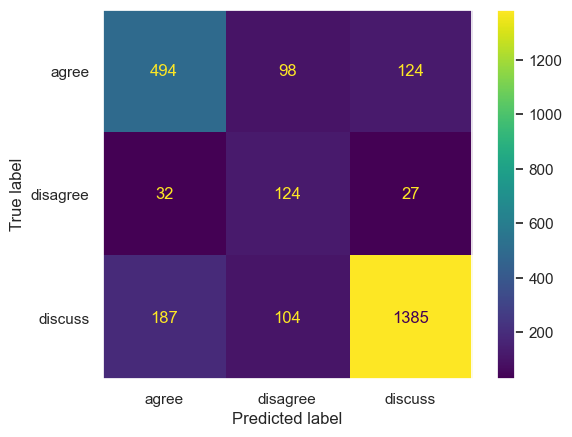

[2023-04-22 17:09:08] Classification Report:
[2023-04-22 17:09:08]               precision    recall  f1-score   support

           0       0.69      0.69      0.69       716
           1       0.38      0.68      0.49       183
           2       0.90      0.83      0.86      1676

    accuracy                           0.78      2575
   macro avg       0.66      0.73      0.68      2575
weighted avg       0.81      0.78      0.79      2575

[2023-04-22 17:09:08] Epoch Accuracy {'accuracy': 0.777864077669903}
[2023-04-22 17:09:08] Finished validation evaluation
[2023-04-22 17:09:08] Beat best validation loss, new validation loss: 0.6251855539794294 (surpassed 1000000000.0 from epoch -1)
[2023-04-22 17:09:10] Saved best model
[2023-04-22 17:09:10] Logged to wandb
[2023-04-22 17:09:10] Starting epoch 2
[2023-04-22 17:09:10] Starting epoch training
[2023-04-22 17:09:10] Set model to train mode


  0%|          | 0/1356 [00:00<?, ?it/s]

[2023-04-22 17:09:24][2:40] Loss: 0.267
[2023-04-22 17:09:24][2:40] LR: 4.356399152308118e-05
[2023-04-22 17:09:37][2:80] Loss: 0.177
[2023-04-22 17:09:37][2:80] LR: 4.3379710679074914e-05
[2023-04-22 17:09:50][2:120] Loss: 0.233
[2023-04-22 17:09:50][2:120] LR: 4.319542983506864e-05
[2023-04-22 17:10:03][2:160] Loss: 0.229
[2023-04-22 17:10:03][2:160] LR: 4.3011148991062386e-05
Class 1 exhausted, falling back to randomised sampling fromthe class
[2023-04-22 17:10:17][2:200] Loss: 0.211
[2023-04-22 17:10:17][2:200] LR: 4.2826868147056115e-05
[2023-04-22 17:10:30][2:240] Loss: 0.187
[2023-04-22 17:10:30][2:240] LR: 4.264258730304985e-05
[2023-04-22 17:10:43][2:280] Loss: 0.207
[2023-04-22 17:10:43][2:280] LR: 4.2458306459043586e-05
[2023-04-22 17:10:57][2:320] Loss: 0.191
[2023-04-22 17:10:57][2:320] LR: 4.227402561503732e-05
[2023-04-22 17:11:10][2:360] Loss: 0.231
[2023-04-22 17:11:10][2:360] LR: 4.208974477103105e-05
[2023-04-22 17:11:23][2:400] Loss: 0.205
[2023-04-22 17:11:23][2:40

  0%|          | 0/322 [00:00<?, ?it/s]

[2023-04-22 17:17:15] Set model to train mode


Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--accuracy\f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Fri Mar 31 21:15:28 2023) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--precision\4e7f439a346715f68500ce6f2be82bf3272abd3f20bdafd203a2c4f85b61dd5f (last modified on Fri Mar 31 21:16:47 2023) since it couldn't be found locally at evaluate-metric--precision, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--recall\e40e6e98d18ff3f210f4d0b26fa721bfaa80704b1fdf890fa551cfabf94fc185 (last modified on Fri Mar 31 21:38:10 2023) since it couldn't be found locally at

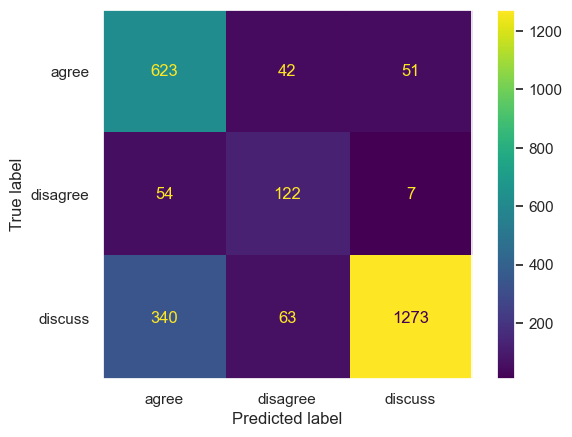

[2023-04-22 17:17:25] Classification Report:
[2023-04-22 17:17:25]               precision    recall  f1-score   support

           0       0.61      0.87      0.72       716
           1       0.54      0.67      0.60       183
           2       0.96      0.76      0.85      1676

    accuracy                           0.78      2575
   macro avg       0.70      0.77      0.72      2575
weighted avg       0.83      0.78      0.79      2575

[2023-04-22 17:17:25] Epoch Accuracy {'accuracy': 0.7836893203883495}
[2023-04-22 17:17:25] Finished validation evaluation
[2023-04-22 17:17:25] Logged to wandb
[2023-04-22 17:17:25] Starting epoch 3
[2023-04-22 17:17:25] Starting epoch training
[2023-04-22 17:17:25] Set model to train mode


  0%|          | 0/1356 [00:00<?, ?it/s]

[2023-04-22 17:17:38][3:40] Loss: 0.120
[2023-04-22 17:17:38][3:40] LR: 3.7316870911268775e-05
[2023-04-22 17:17:52][3:80] Loss: 0.095
[2023-04-22 17:17:52][3:80] LR: 3.713259006726251e-05
[2023-04-22 17:18:05][3:120] Loss: 0.059
[2023-04-22 17:18:05][3:120] LR: 3.6948309223256246e-05
[2023-04-22 17:18:18][3:160] Loss: 0.089
[2023-04-22 17:18:18][3:160] LR: 3.6764028379249975e-05
Class 1 exhausted, falling back to randomised sampling fromthe class
[2023-04-22 17:18:32][3:200] Loss: 0.041
[2023-04-22 17:18:32][3:200] LR: 3.657974753524371e-05
[2023-04-22 17:18:45][3:240] Loss: 0.046
[2023-04-22 17:18:45][3:240] LR: 3.6395466691237447e-05
[2023-04-22 17:18:58][3:280] Loss: 0.078
[2023-04-22 17:18:58][3:280] LR: 3.621118584723118e-05
[2023-04-22 17:19:11][3:320] Loss: 0.164
[2023-04-22 17:19:11][3:320] LR: 3.602690500322491e-05
[2023-04-22 17:19:25][3:360] Loss: 0.062
[2023-04-22 17:19:25][3:360] LR: 3.5842624159218654e-05
[2023-04-22 17:19:38][3:400] Loss: 0.110
[2023-04-22 17:19:38][3:4

  0%|          | 0/322 [00:00<?, ?it/s]

[2023-04-22 17:25:33] Set model to train mode


Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--accuracy\f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Fri Mar 31 21:15:28 2023) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--precision\4e7f439a346715f68500ce6f2be82bf3272abd3f20bdafd203a2c4f85b61dd5f (last modified on Fri Mar 31 21:16:47 2023) since it couldn't be found locally at evaluate-metric--precision, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--recall\e40e6e98d18ff3f210f4d0b26fa721bfaa80704b1fdf890fa551cfabf94fc185 (last modified on Fri Mar 31 21:38:10 2023) since it couldn't be found locally at

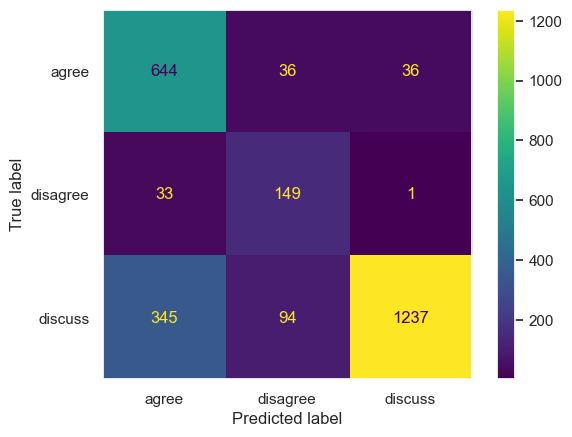

[2023-04-22 17:25:42] Classification Report:
[2023-04-22 17:25:42]               precision    recall  f1-score   support

           0       0.63      0.90      0.74       716
           1       0.53      0.81      0.65       183
           2       0.97      0.74      0.84      1676

    accuracy                           0.79      2575
   macro avg       0.71      0.82      0.74      2575
weighted avg       0.85      0.79      0.80      2575

[2023-04-22 17:25:42] Epoch Accuracy {'accuracy': 0.7883495145631068}
[2023-04-22 17:25:42] Finished validation evaluation
[2023-04-22 17:25:42] Early stopping triggered, best validation loss achieved at 1 (loss: 0.6251855539794294)
[2023-04-22 17:25:42] Loading best model (epoch 0.6251855539794294) for evaluation
[2023-04-22 17:25:42] Starting test evaluation
[2023-04-22 17:25:42] Using model to generate predictions
[2023-04-22 17:25:42] Set model to eval mode


  0%|          | 0/883 [00:00<?, ?it/s]

[2023-04-22 17:27:18] Set model to train mode


Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--accuracy\f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Fri Mar 31 21:15:28 2023) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--precision\4e7f439a346715f68500ce6f2be82bf3272abd3f20bdafd203a2c4f85b61dd5f (last modified on Fri Mar 31 21:16:47 2023) since it couldn't be found locally at evaluate-metric--precision, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--recall\e40e6e98d18ff3f210f4d0b26fa721bfaa80704b1fdf890fa551cfabf94fc185 (last modified on Fri Mar 31 21:38:10 2023) since it couldn't be found locally at

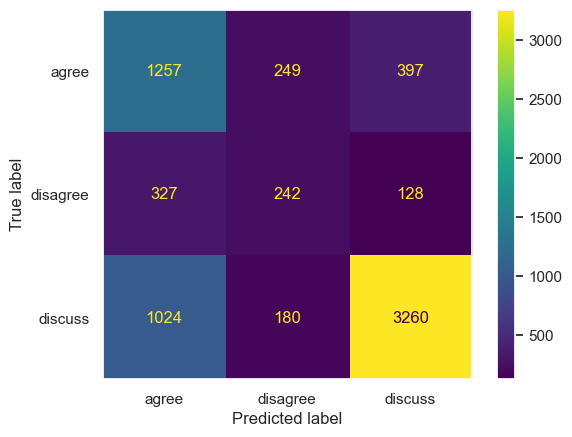

[2023-04-22 17:27:27] Classification Report:
[2023-04-22 17:27:27]               precision    recall  f1-score   support

           0       0.48      0.66      0.56      1903
           1       0.36      0.35      0.35       697
           2       0.86      0.73      0.79      4464

    accuracy                           0.67      7064
   macro avg       0.57      0.58      0.57      7064
weighted avg       0.71      0.67      0.68      7064

[2023-04-22 17:27:28] Finished test evaluation


In [132]:
model_trainer.train()

### CNN+LSTM Balanced with Dice Loss

In [133]:
class TransformerCNNRNNHybrid(nn.Module):
    def __init__(self, transformer, rnn_type, stacked_layers, hidden_dim, output_dim, bidirectional, dropout_prob):
        super().__init__()
        
        self.transformer = transformer
        embedding_dim = transformer.config.to_dict()["hidden_size"]
        
        rnn_class = None
        
        if rnn_type.lower() == "lstm":
            rnn_class = nn.LSTM
        elif rnn_type.lower() == "gru":
            rnn_class = nn.GRU
        else:
            assert 1 == 0, "Invalid RNN type"
            
        self.convolutions = nn.Sequential(
            nn.Conv1d(768, 512, 5, padding=2),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Conv1d(512, 256, 5, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_prob)
            # nn.MaxPool1d(1),
        )
        
        self.rnn_type = rnn_type
        self.rnn = rnn_class(256, hidden_dim, num_layers=stacked_layers, bidirectional=bidirectional, batch_first=True, dropout=dropout_prob)
        self.classifier = nn.Linear(hidden_dim * (1 + bidirectional), output_dim)
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, ids, mask):
        embeddings = self.transformer(input_ids=ids, attention_mask=mask)[0]
        
        embeddings = embeddings.permute(0, 2, 1)
        embeddings = self.convolutions(embeddings)
        embeddings = embeddings.permute(0, 2, 1)
        
        if self.rnn_type == "gru":
            _, hidden_state = self.rnn(embeddings)
        else:
            _, (hidden_state, _) = self.rnn(embeddings)
        
        if self.rnn.bidirectional:
            hidden_state = self.dropout(torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim=1))
        else:
            hidden_state = self.dropout(hidden_state[-1,:,:])
        
        return self.classifier(hidden_state)

In [134]:
transformer = AutoModel.from_pretrained(selected_transformer_name)

import sadice

model_trainer = TransformerBasedModelTrainer(
    model_class=TransformerCNNRNNHybrid,
    model_transformer=transformer,
    model_freeze_transformer=False,
    model_config={
        "rnn_type": "lstm",
        "stacked_layers": 2,
        "hidden_dim": 256,
        "output_dim": 3,
        "dropout_prob": 0.1,
        "bidirectional": True,
    },
    optimiser_class=optim.AdamW,
    optimiser_config={
        "lr": 5e-5
    },
    hf_scheduler_name="linear",
    hf_scheduler_config={
        "num_warmup_steps": 0,
        "num_training_steps": 8 * (len(train_dataset) + 1) // 8
    },
    loss_class=sadice.SelfAdjDiceLoss,
    batch_size=8,
    max_epochs=8,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    label_names=list(labels2id.keys()),
    sampling_weight_fn="balanced",
    no_improvement_epochs_stop=2,
    eval_batch_size=None,
    loss_weights=None,
    device="cuda:0",
    excluded_freeze=None
)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model Initialised
TransformerCNNRNNHybrid(
  (transformer): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
        

[2023-04-22 17:38:22] Starting epoch 1
[2023-04-22 17:38:22] Starting epoch training
[2023-04-22 17:38:22] Set model to train mode


  0%|          | 0/1356 [00:00<?, ?it/s]

[2023-04-22 17:38:36][1:40] Loss: 0.351
[2023-04-22 17:38:36][1:40] LR: 4.9811112134893576e-05
[2023-04-22 17:38:50][1:80] Loss: 0.340
[2023-04-22 17:38:50][1:80] LR: 4.962683129088732e-05
[2023-04-22 17:39:03][1:120] Loss: 0.341
[2023-04-22 17:39:03][1:120] LR: 4.944255044688105e-05
[2023-04-22 17:39:17][1:160] Loss: 0.338
[2023-04-22 17:39:17][1:160] LR: 4.925826960287478e-05
[2023-04-22 17:39:30][1:200] Loss: 0.338
[2023-04-22 17:39:30][1:200] LR: 4.907398875886852e-05
[2023-04-22 17:39:43][1:240] Loss: 0.337
[2023-04-22 17:39:43][1:240] LR: 4.8889707914862254e-05
Class 1 exhausted, falling back to randomised sampling fromthe class
[2023-04-22 17:39:57][1:280] Loss: 0.344
[2023-04-22 17:39:57][1:280] LR: 4.870542707085598e-05
[2023-04-22 17:40:10][1:320] Loss: 0.342
[2023-04-22 17:40:10][1:320] LR: 4.8521146226849726e-05
[2023-04-22 17:40:24][1:360] Loss: 0.340
[2023-04-22 17:40:24][1:360] LR: 4.8336865382843455e-05
[2023-04-22 17:40:37][1:400] Loss: 0.340
[2023-04-22 17:40:37][1:40

  0%|          | 0/322 [00:00<?, ?it/s]

[2023-04-22 17:46:33] Set model to train mode


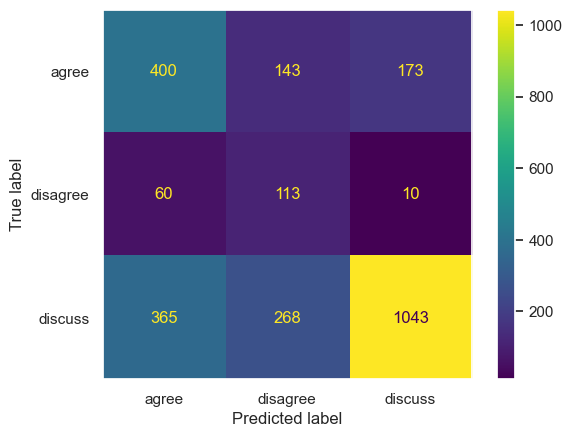

[2023-04-22 17:46:37] Classification Report:
[2023-04-22 17:46:37]               precision    recall  f1-score   support

           0       0.48      0.56      0.52       716
           1       0.22      0.62      0.32       183
           2       0.85      0.62      0.72      1676

    accuracy                           0.60      2575
   macro avg       0.52      0.60      0.52      2575
weighted avg       0.70      0.60      0.63      2575

[2023-04-22 17:46:37] Epoch Accuracy {'accuracy': 0.6042718446601941}
[2023-04-22 17:46:37] Finished validation evaluation
[2023-04-22 17:46:37] Beat best validation loss, new validation loss: 0.34868783591696934 (surpassed 1000000000.0 from epoch -1)
[2023-04-22 17:46:39] Saved best model
[2023-04-22 17:46:39] Logged to wandb
[2023-04-22 17:46:39] Starting epoch 2
[2023-04-22 17:46:39] Starting epoch training
[2023-04-22 17:46:39] Set model to train mode


  0%|          | 0/1356 [00:00<?, ?it/s]

[2023-04-22 17:46:53][2:40] Loss: 0.347
[2023-04-22 17:46:53][2:40] LR: 4.356399152308118e-05
[2023-04-22 17:47:06][2:80] Loss: 0.335
[2023-04-22 17:47:06][2:80] LR: 4.3379710679074914e-05
[2023-04-22 17:47:20][2:120] Loss: 0.337
[2023-04-22 17:47:20][2:120] LR: 4.319542983506864e-05
[2023-04-22 17:47:33][2:160] Loss: 0.336
[2023-04-22 17:47:33][2:160] LR: 4.3011148991062386e-05
[2023-04-22 17:47:46][2:200] Loss: 0.336
[2023-04-22 17:47:46][2:200] LR: 4.2826868147056115e-05
Class 1 exhausted, falling back to randomised sampling fromthe class
[2023-04-22 17:47:59][2:240] Loss: 0.335
[2023-04-22 17:47:59][2:240] LR: 4.264258730304985e-05
[2023-04-22 17:48:13][2:280] Loss: 0.338
[2023-04-22 17:48:13][2:280] LR: 4.2458306459043586e-05
[2023-04-22 17:48:26][2:320] Loss: 0.336
[2023-04-22 17:48:26][2:320] LR: 4.227402561503732e-05
[2023-04-22 17:48:39][2:360] Loss: 0.335
[2023-04-22 17:48:39][2:360] LR: 4.208974477103105e-05
[2023-04-22 17:48:53][2:400] Loss: 0.337
[2023-04-22 17:48:53][2:40

  0%|          | 0/322 [00:00<?, ?it/s]

[2023-04-22 17:54:45] Set model to train mode


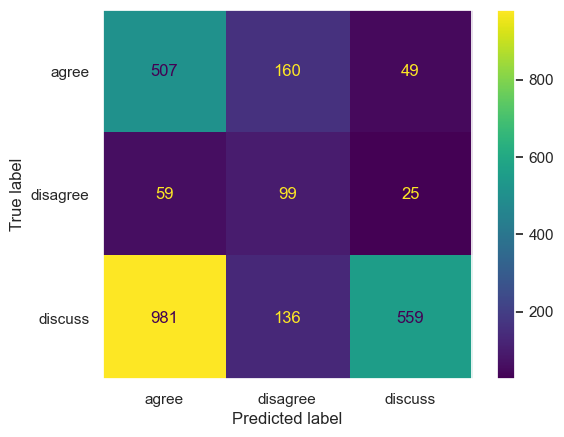

[2023-04-22 17:54:50] Classification Report:
[2023-04-22 17:54:50]               precision    recall  f1-score   support

           0       0.33      0.71      0.45       716
           1       0.25      0.54      0.34       183
           2       0.88      0.33      0.48      1676

    accuracy                           0.45      2575
   macro avg       0.49      0.53      0.42      2575
weighted avg       0.68      0.45      0.46      2575

[2023-04-22 17:54:50] Epoch Accuracy {'accuracy': 0.4524271844660194}
[2023-04-22 17:54:50] Finished validation evaluation
[2023-04-22 17:54:50] Beat best validation loss, new validation loss: 0.34345027795119315 (surpassed 0.34868783591696934 from epoch 1)
[2023-04-22 17:54:51] Saved best model
[2023-04-22 17:54:51] Logged to wandb
[2023-04-22 17:54:51] Starting epoch 3
[2023-04-22 17:54:51] Starting epoch training
[2023-04-22 17:54:51] Set model to train mode


  0%|          | 0/1356 [00:00<?, ?it/s]

[2023-04-22 17:55:05][3:40] Loss: 0.343
[2023-04-22 17:55:05][3:40] LR: 3.7316870911268775e-05
[2023-04-22 17:55:18][3:80] Loss: 0.335
[2023-04-22 17:55:18][3:80] LR: 3.713259006726251e-05
[2023-04-22 17:55:31][3:120] Loss: 0.334
[2023-04-22 17:55:31][3:120] LR: 3.6948309223256246e-05
[2023-04-22 17:55:45][3:160] Loss: 0.335
[2023-04-22 17:55:45][3:160] LR: 3.6764028379249975e-05
[2023-04-22 17:55:58][3:200] Loss: 0.334
[2023-04-22 17:55:58][3:200] LR: 3.657974753524371e-05
[2023-04-22 17:56:11][3:240] Loss: 0.335
[2023-04-22 17:56:11][3:240] LR: 3.6395466691237447e-05
Class 1 exhausted, falling back to randomised sampling fromthe class
[2023-04-22 17:56:25][3:280] Loss: 0.336
[2023-04-22 17:56:25][3:280] LR: 3.621118584723118e-05
[2023-04-22 17:56:38][3:320] Loss: 0.334
[2023-04-22 17:56:38][3:320] LR: 3.602690500322491e-05
[2023-04-22 17:56:51][3:360] Loss: 0.335
[2023-04-22 17:56:51][3:360] LR: 3.5842624159218654e-05
[2023-04-22 17:57:05][3:400] Loss: 0.335
[2023-04-22 17:57:05][3:4

  0%|          | 0/322 [00:00<?, ?it/s]

[2023-04-22 18:02:57] Set model to train mode


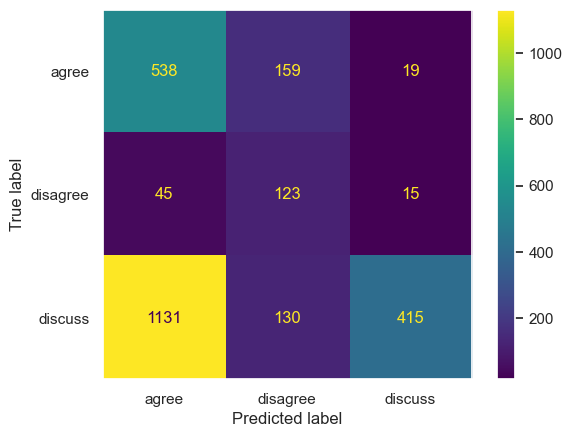

[2023-04-22 18:03:02] Classification Report:
[2023-04-22 18:03:02]               precision    recall  f1-score   support

           0       0.31      0.75      0.44       716
           1       0.30      0.67      0.41       183
           2       0.92      0.25      0.39      1676

    accuracy                           0.42      2575
   macro avg       0.51      0.56      0.42      2575
weighted avg       0.71      0.42      0.41      2575

[2023-04-22 18:03:02] Epoch Accuracy {'accuracy': 0.4178640776699029}
[2023-04-22 18:03:02] Finished validation evaluation
[2023-04-22 18:03:02] Logged to wandb
[2023-04-22 18:03:02] Starting epoch 4
[2023-04-22 18:03:02] Starting epoch training
[2023-04-22 18:03:02] Set model to train mode


  0%|          | 0/1356 [00:00<?, ?it/s]

[2023-04-22 18:03:15][4:40] Loss: 0.343
[2023-04-22 18:03:15][4:40] LR: 3.106975029945637e-05
[2023-04-22 18:03:29][4:80] Loss: 0.334
[2023-04-22 18:03:29][4:80] LR: 3.0885469455450107e-05
[2023-04-22 18:03:42][4:120] Loss: 0.333
[2023-04-22 18:03:42][4:120] LR: 3.070118861144384e-05
[2023-04-22 18:03:55][4:160] Loss: 0.334
[2023-04-22 18:03:55][4:160] LR: 3.0516907767437575e-05
[2023-04-22 18:04:08][4:200] Loss: 0.334
[2023-04-22 18:04:08][4:200] LR: 3.0332626923431314e-05
Class 1 exhausted, falling back to randomised sampling fromthe class
[2023-04-22 18:04:22][4:240] Loss: 0.334
[2023-04-22 18:04:22][4:240] LR: 3.0148346079425043e-05
[2023-04-22 18:04:35][4:280] Loss: 0.334
[2023-04-22 18:04:35][4:280] LR: 2.9964065235418782e-05
[2023-04-22 18:04:48][4:320] Loss: 0.334
[2023-04-22 18:04:48][4:320] LR: 2.9779784391412514e-05
[2023-04-22 18:05:02][4:360] Loss: 0.334
[2023-04-22 18:05:02][4:360] LR: 2.959550354740625e-05
[2023-04-22 18:05:15][4:400] Loss: 0.334
[2023-04-22 18:05:15][4:

  0%|          | 0/322 [00:00<?, ?it/s]

[2023-04-22 18:11:08] Set model to train mode


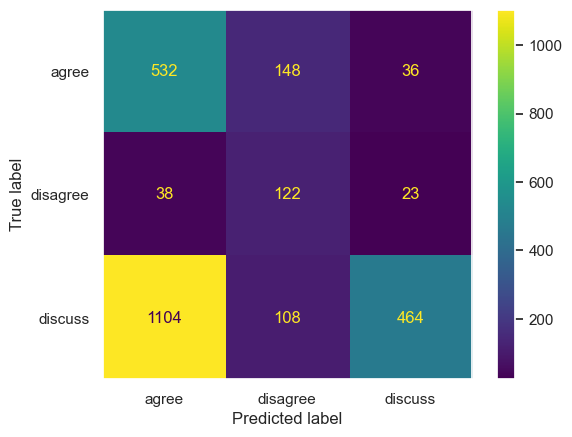

[2023-04-22 18:11:12] Classification Report:
[2023-04-22 18:11:12]               precision    recall  f1-score   support

           0       0.32      0.74      0.45       716
           1       0.32      0.67      0.43       183
           2       0.89      0.28      0.42      1676

    accuracy                           0.43      2575
   macro avg       0.51      0.56      0.43      2575
weighted avg       0.69      0.43      0.43      2575

[2023-04-22 18:11:12] Epoch Accuracy {'accuracy': 0.4341747572815534}
[2023-04-22 18:11:12] Finished validation evaluation
[2023-04-22 18:11:12] Beat best validation loss, new validation loss: 0.34050006646177045 (surpassed 0.34345027795119315 from epoch 2)
[2023-04-22 18:11:13] Saved best model
[2023-04-22 18:11:13] Logged to wandb
[2023-04-22 18:11:13] Starting epoch 5
[2023-04-22 18:11:13] Starting epoch training
[2023-04-22 18:11:13] Set model to train mode


  0%|          | 0/1356 [00:00<?, ?it/s]

[2023-04-22 18:11:27][5:40] Loss: 0.342
[2023-04-22 18:11:27][5:40] LR: 2.482262968764397e-05
[2023-04-22 18:11:41][5:80] Loss: 0.334
[2023-04-22 18:11:41][5:80] LR: 2.4638348843637703e-05
[2023-04-22 18:11:54][5:120] Loss: 0.334
[2023-04-22 18:11:54][5:120] LR: 2.445406799963144e-05
[2023-04-22 18:12:08][5:160] Loss: 0.334
[2023-04-22 18:12:08][5:160] LR: 2.4269787155625174e-05
[2023-04-22 18:12:21][5:200] Loss: 0.333
[2023-04-22 18:12:21][5:200] LR: 2.4085506311618906e-05
Class 1 exhausted, falling back to randomised sampling fromthe class
[2023-04-22 18:12:34][5:240] Loss: 0.334
[2023-04-22 18:12:34][5:240] LR: 2.3901225467612642e-05
[2023-04-22 18:12:48][5:280] Loss: 0.334
[2023-04-22 18:12:48][5:280] LR: 2.3716944623606378e-05
[2023-04-22 18:13:01][5:320] Loss: 0.333
[2023-04-22 18:13:01][5:320] LR: 2.353266377960011e-05
[2023-04-22 18:13:14][5:360] Loss: 0.333
[2023-04-22 18:13:14][5:360] LR: 2.3348382935593846e-05
[2023-04-22 18:13:28][5:400] Loss: 0.334
[2023-04-22 18:13:28][5:

  0%|          | 0/322 [00:00<?, ?it/s]

[2023-04-22 18:19:23] Set model to train mode


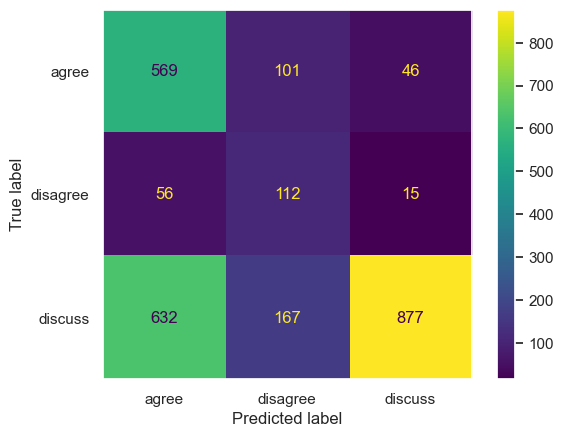

[2023-04-22 18:19:28] Classification Report:
[2023-04-22 18:19:28]               precision    recall  f1-score   support

           0       0.45      0.79      0.58       716
           1       0.29      0.61      0.40       183
           2       0.93      0.52      0.67      1676

    accuracy                           0.61      2575
   macro avg       0.56      0.64      0.55      2575
weighted avg       0.76      0.61      0.63      2575

[2023-04-22 18:19:28] Epoch Accuracy {'accuracy': 0.6050485436893204}
[2023-04-22 18:19:28] Finished validation evaluation
[2023-04-22 18:19:28] Logged to wandb
[2023-04-22 18:19:28] Starting epoch 6
[2023-04-22 18:19:28] Starting epoch training
[2023-04-22 18:19:28] Set model to train mode


  0%|          | 0/1356 [00:00<?, ?it/s]

[2023-04-22 18:19:42][6:40] Loss: 0.342
[2023-04-22 18:19:42][6:40] LR: 1.8575509075831566e-05
[2023-04-22 18:19:55][6:80] Loss: 0.334
[2023-04-22 18:19:55][6:80] LR: 1.8391228231825302e-05
[2023-04-22 18:20:08][6:120] Loss: 0.334
[2023-04-22 18:20:08][6:120] LR: 1.8206947387819038e-05
[2023-04-22 18:20:22][6:160] Loss: 0.334
[2023-04-22 18:20:22][6:160] LR: 1.802266654381277e-05
[2023-04-22 18:20:35][6:200] Loss: 0.333
[2023-04-22 18:20:35][6:200] LR: 1.7838385699806506e-05
Class 1 exhausted, falling back to randomised sampling fromthe class
[2023-04-22 18:20:48][6:240] Loss: 0.335
[2023-04-22 18:20:48][6:240] LR: 1.765410485580024e-05
[2023-04-22 18:21:01][6:280] Loss: 0.334
[2023-04-22 18:21:01][6:280] LR: 1.7469824011793974e-05
[2023-04-22 18:21:15][6:320] Loss: 0.333
[2023-04-22 18:21:15][6:320] LR: 1.728554316778771e-05
[2023-04-22 18:21:28][6:360] Loss: 0.333
[2023-04-22 18:21:28][6:360] LR: 1.7101262323781445e-05
[2023-04-22 18:21:41][6:400] Loss: 0.334
[2023-04-22 18:21:41][6:

  0%|          | 0/322 [00:00<?, ?it/s]

[2023-04-22 18:27:33] Set model to train mode


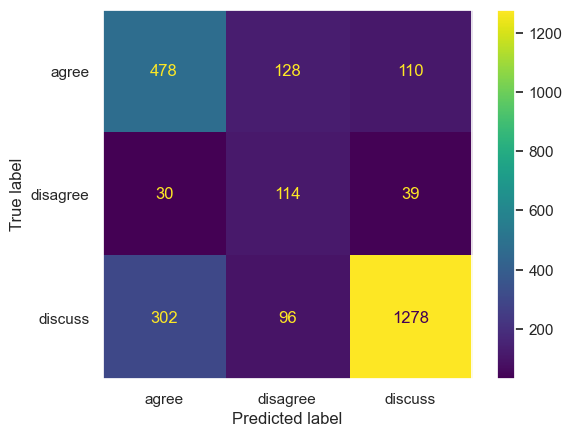

[2023-04-22 18:27:37] Classification Report:
[2023-04-22 18:27:37]               precision    recall  f1-score   support

           0       0.59      0.67      0.63       716
           1       0.34      0.62      0.44       183
           2       0.90      0.76      0.82      1676

    accuracy                           0.73      2575
   macro avg       0.61      0.68      0.63      2575
weighted avg       0.77      0.73      0.74      2575

[2023-04-22 18:27:37] Epoch Accuracy {'accuracy': 0.7262135922330097}
[2023-04-22 18:27:37] Finished validation evaluation
[2023-04-22 18:27:37] Early stopping triggered, best validation loss achieved at 4 (loss: 0.34050006646177045)
[2023-04-22 18:27:37] Loading best model (epoch 0.34050006646177045) for evaluation
[2023-04-22 18:27:38] Starting test evaluation
[2023-04-22 18:27:38] Using model to generate predictions
[2023-04-22 18:27:38] Set model to eval mode


  0%|          | 0/883 [00:00<?, ?it/s]

[2023-04-22 18:29:15] Set model to train mode


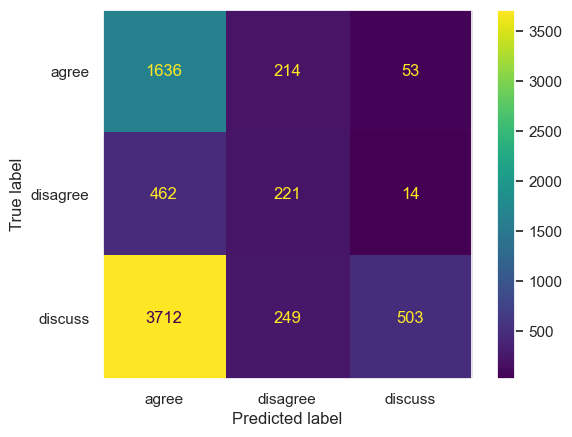

[2023-04-22 18:29:19] Classification Report:
[2023-04-22 18:29:19]               precision    recall  f1-score   support

           0       0.28      0.86      0.42      1903
           1       0.32      0.32      0.32       697
           2       0.88      0.11      0.20      4464

    accuracy                           0.33      7064
   macro avg       0.50      0.43      0.31      7064
weighted avg       0.67      0.33      0.27      7064

[2023-04-22 18:29:19] Finished test evaluation


In [135]:
model_trainer.train()

### CNN+LSTM No Weighting with Dice Loss

In [136]:
class TransformerCNNRNNHybrid(nn.Module):
    def __init__(self, transformer, rnn_type, stacked_layers, hidden_dim, output_dim, bidirectional, dropout_prob):
        super().__init__()
        
        self.transformer = transformer
        embedding_dim = transformer.config.to_dict()["hidden_size"]
        
        rnn_class = None
        
        if rnn_type.lower() == "lstm":
            rnn_class = nn.LSTM
        elif rnn_type.lower() == "gru":
            rnn_class = nn.GRU
        else:
            assert 1 == 0, "Invalid RNN type"
            
        self.convolutions = nn.Sequential(
            nn.Conv1d(768, 512, 5, padding=2),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Conv1d(512, 256, 5, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_prob)
            # nn.MaxPool1d(1),
        )
        
        self.rnn_type = rnn_type
        self.rnn = rnn_class(256, hidden_dim, num_layers=stacked_layers, bidirectional=bidirectional, batch_first=True, dropout=dropout_prob)
        self.classifier = nn.Linear(hidden_dim * (1 + bidirectional), output_dim)
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, ids, mask):
        embeddings = self.transformer(input_ids=ids, attention_mask=mask)[0]
        
        embeddings = embeddings.permute(0, 2, 1)
        embeddings = self.convolutions(embeddings)
        embeddings = embeddings.permute(0, 2, 1)
        
        if self.rnn_type == "gru":
            _, hidden_state = self.rnn(embeddings)
        else:
            _, (hidden_state, _) = self.rnn(embeddings)
        
        if self.rnn.bidirectional:
            hidden_state = self.dropout(torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim=1))
        else:
            hidden_state = self.dropout(hidden_state[-1,:,:])
        
        return self.classifier(hidden_state)

In [137]:
transformer = AutoModel.from_pretrained(selected_transformer_name)

import sadice

model_trainer = TransformerBasedModelTrainer(
    model_class=TransformerCNNRNNHybrid,
    model_transformer=transformer,
    model_freeze_transformer=False,
    model_config={
        "rnn_type": "lstm",
        "stacked_layers": 2,
        "hidden_dim": 256,
        "output_dim": 3,
        "dropout_prob": 0.1,
        "bidirectional": True,
    },
    optimiser_class=optim.AdamW,
    optimiser_config={
        "lr": 5e-5
    },
    hf_scheduler_name="linear",
    hf_scheduler_config={
        "num_warmup_steps": 0,
        "num_training_steps": 8 * (len(train_dataset) + 1) // 8
    },
    loss_class=sadice.SelfAdjDiceLoss,
    batch_size=8,
    max_epochs=8,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    label_names=list(labels2id.keys()),
    sampling_weight_fn=None,
    no_improvement_epochs_stop=2,
    eval_batch_size=None,
    loss_weights=None,
    device="cuda:0",
    excluded_freeze=None
)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model Initialised
TransformerCNNRNNHybrid(
  (transformer): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
        

[2023-04-22 18:29:20] Starting epoch 1
[2023-04-22 18:29:20] Starting epoch training
[2023-04-22 18:29:20] Set model to train mode


  0%|          | 0/1356 [00:00<?, ?it/s]

[2023-04-22 18:29:34][1:40] Loss: 0.349
[2023-04-22 18:29:34][1:40] LR: 4.9811112134893576e-05
[2023-04-22 18:29:48][1:80] Loss: 0.341
[2023-04-22 18:29:48][1:80] LR: 4.962683129088732e-05
[2023-04-22 18:30:01][1:120] Loss: 0.341
[2023-04-22 18:30:01][1:120] LR: 4.944255044688105e-05
[2023-04-22 18:30:14][1:160] Loss: 0.338
[2023-04-22 18:30:14][1:160] LR: 4.925826960287478e-05
[2023-04-22 18:30:28][1:200] Loss: 0.341
[2023-04-22 18:30:28][1:200] LR: 4.907398875886852e-05
[2023-04-22 18:30:41][1:240] Loss: 0.340
[2023-04-22 18:30:41][1:240] LR: 4.8889707914862254e-05
[2023-04-22 18:30:55][1:280] Loss: 0.340
[2023-04-22 18:30:55][1:280] LR: 4.870542707085598e-05
[2023-04-22 18:31:08][1:320] Loss: 0.339
[2023-04-22 18:31:08][1:320] LR: 4.8521146226849726e-05
[2023-04-22 18:31:21][1:360] Loss: 0.339
[2023-04-22 18:31:21][1:360] LR: 4.8336865382843455e-05
[2023-04-22 18:31:35][1:400] Loss: 0.338
[2023-04-22 18:31:35][1:400] LR: 4.815258453883719e-05
[2023-04-22 18:31:48][1:440] Loss: 0.339

  0%|          | 0/322 [00:00<?, ?it/s]

[2023-04-22 18:37:29] Set model to train mode


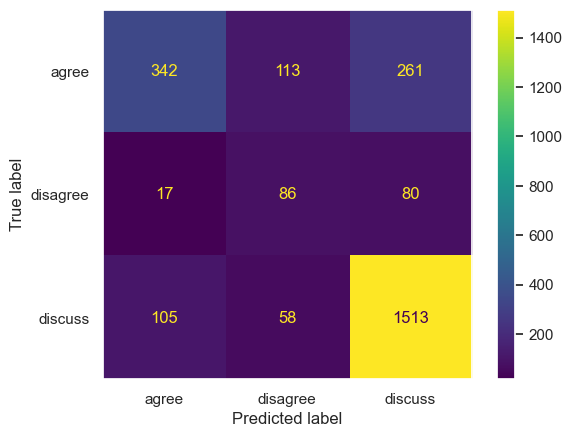

[2023-04-22 18:37:33] Classification Report:
[2023-04-22 18:37:33]               precision    recall  f1-score   support

           0       0.74      0.48      0.58       716
           1       0.33      0.47      0.39       183
           2       0.82      0.90      0.86      1676

    accuracy                           0.75      2575
   macro avg       0.63      0.62      0.61      2575
weighted avg       0.76      0.75      0.75      2575

[2023-04-22 18:37:33] Epoch Accuracy {'accuracy': 0.7537864077669902}
[2023-04-22 18:37:33] Finished validation evaluation
[2023-04-22 18:37:33] Beat best validation loss, new validation loss: 0.3389746580064667 (surpassed 1000000000.0 from epoch -1)
[2023-04-22 18:37:34] Saved best model
[2023-04-22 18:37:34] Logged to wandb
[2023-04-22 18:37:34] Starting epoch 2
[2023-04-22 18:37:34] Starting epoch training
[2023-04-22 18:37:34] Set model to train mode


  0%|          | 0/1356 [00:00<?, ?it/s]

[2023-04-22 18:37:48][2:40] Loss: 0.345
[2023-04-22 18:37:48][2:40] LR: 4.356399152308118e-05
[2023-04-22 18:38:01][2:80] Loss: 0.337
[2023-04-22 18:38:01][2:80] LR: 4.3379710679074914e-05
[2023-04-22 18:38:15][2:120] Loss: 0.337
[2023-04-22 18:38:15][2:120] LR: 4.319542983506864e-05
[2023-04-22 18:38:28][2:160] Loss: 0.337
[2023-04-22 18:38:28][2:160] LR: 4.3011148991062386e-05
[2023-04-22 18:38:41][2:200] Loss: 0.338
[2023-04-22 18:38:41][2:200] LR: 4.2826868147056115e-05
[2023-04-22 18:38:54][2:240] Loss: 0.337
[2023-04-22 18:38:54][2:240] LR: 4.264258730304985e-05
[2023-04-22 18:39:08][2:280] Loss: 0.337
[2023-04-22 18:39:08][2:280] LR: 4.2458306459043586e-05
[2023-04-22 18:39:21][2:320] Loss: 0.337
[2023-04-22 18:39:21][2:320] LR: 4.227402561503732e-05
[2023-04-22 18:39:34][2:360] Loss: 0.336
[2023-04-22 18:39:34][2:360] LR: 4.208974477103105e-05
[2023-04-22 18:39:48][2:400] Loss: 0.338
[2023-04-22 18:39:48][2:400] LR: 4.1905463927024787e-05
[2023-04-22 18:40:01][2:440] Loss: 0.33

  0%|          | 0/322 [00:00<?, ?it/s]

[2023-04-22 18:45:40] Set model to train mode


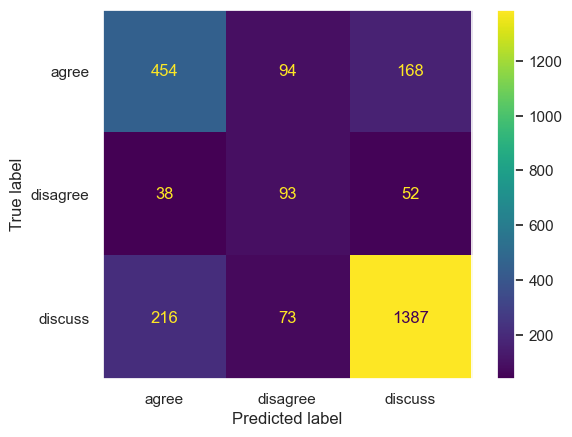

[2023-04-22 18:45:45] Classification Report:
[2023-04-22 18:45:45]               precision    recall  f1-score   support

           0       0.64      0.63      0.64       716
           1       0.36      0.51      0.42       183
           2       0.86      0.83      0.84      1676

    accuracy                           0.75      2575
   macro avg       0.62      0.66      0.63      2575
weighted avg       0.77      0.75      0.76      2575

[2023-04-22 18:45:45] Epoch Accuracy {'accuracy': 0.7510679611650486}
[2023-04-22 18:45:45] Finished validation evaluation
[2023-04-22 18:45:45] Logged to wandb
[2023-04-22 18:45:45] Starting epoch 3
[2023-04-22 18:45:45] Starting epoch training
[2023-04-22 18:45:45] Set model to train mode


  0%|          | 0/1356 [00:00<?, ?it/s]

[2023-04-22 18:45:58][3:40] Loss: 0.343
[2023-04-22 18:45:58][3:40] LR: 3.7316870911268775e-05
[2023-04-22 18:46:12][3:80] Loss: 0.335
[2023-04-22 18:46:12][3:80] LR: 3.713259006726251e-05
[2023-04-22 18:46:25][3:120] Loss: 0.335
[2023-04-22 18:46:25][3:120] LR: 3.6948309223256246e-05
[2023-04-22 18:46:38][3:160] Loss: 0.334
[2023-04-22 18:46:38][3:160] LR: 3.6764028379249975e-05
[2023-04-22 18:46:52][3:200] Loss: 0.335
[2023-04-22 18:46:52][3:200] LR: 3.657974753524371e-05
[2023-04-22 18:47:05][3:240] Loss: 0.335
[2023-04-22 18:47:05][3:240] LR: 3.6395466691237447e-05
[2023-04-22 18:47:18][3:280] Loss: 0.336
[2023-04-22 18:47:18][3:280] LR: 3.621118584723118e-05
[2023-04-22 18:47:32][3:320] Loss: 0.334
[2023-04-22 18:47:32][3:320] LR: 3.602690500322491e-05
[2023-04-22 18:47:45][3:360] Loss: 0.335
[2023-04-22 18:47:45][3:360] LR: 3.5842624159218654e-05
[2023-04-22 18:47:58][3:400] Loss: 0.336
[2023-04-22 18:47:58][3:400] LR: 3.565834331521238e-05
[2023-04-22 18:48:11][3:440] Loss: 0.33

  0%|          | 0/322 [00:00<?, ?it/s]

[2023-04-22 18:53:50] Set model to train mode


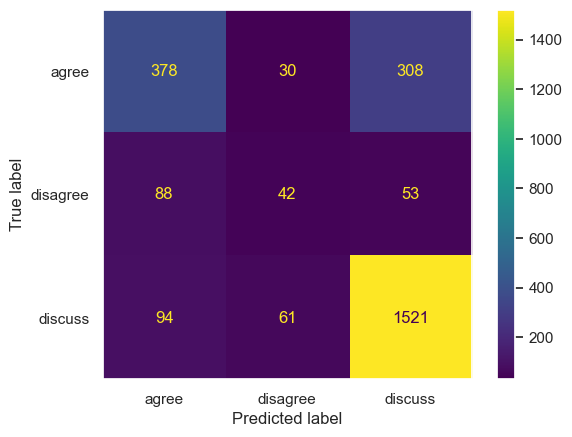

[2023-04-22 18:53:54] Classification Report:
[2023-04-22 18:53:54]               precision    recall  f1-score   support

           0       0.68      0.53      0.59       716
           1       0.32      0.23      0.27       183
           2       0.81      0.91      0.85      1676

    accuracy                           0.75      2575
   macro avg       0.60      0.55      0.57      2575
weighted avg       0.74      0.75      0.74      2575

[2023-04-22 18:53:54] Epoch Accuracy {'accuracy': 0.7537864077669902}
[2023-04-22 18:53:54] Finished validation evaluation
[2023-04-22 18:53:54] Beat best validation loss, new validation loss: 0.33864311531463764 (surpassed 0.3389746580064667 from epoch 1)
[2023-04-22 18:53:56] Saved best model
[2023-04-22 18:53:56] Logged to wandb
[2023-04-22 18:53:56] Starting epoch 4
[2023-04-22 18:53:56] Starting epoch training
[2023-04-22 18:53:56] Set model to train mode


  0%|          | 0/1356 [00:00<?, ?it/s]

[2023-04-22 18:54:10][4:40] Loss: 0.342
[2023-04-22 18:54:10][4:40] LR: 3.106975029945637e-05
[2023-04-22 18:54:23][4:80] Loss: 0.334
[2023-04-22 18:54:23][4:80] LR: 3.0885469455450107e-05
[2023-04-22 18:54:36][4:120] Loss: 0.334
[2023-04-22 18:54:36][4:120] LR: 3.070118861144384e-05
[2023-04-22 18:54:49][4:160] Loss: 0.334
[2023-04-22 18:54:49][4:160] LR: 3.0516907767437575e-05
[2023-04-22 18:55:03][4:200] Loss: 0.334
[2023-04-22 18:55:03][4:200] LR: 3.0332626923431314e-05
[2023-04-22 18:55:16][4:240] Loss: 0.334
[2023-04-22 18:55:16][4:240] LR: 3.0148346079425043e-05
[2023-04-22 18:55:29][4:280] Loss: 0.334
[2023-04-22 18:55:29][4:280] LR: 2.9964065235418782e-05
[2023-04-22 18:55:43][4:320] Loss: 0.334
[2023-04-22 18:55:43][4:320] LR: 2.9779784391412514e-05
[2023-04-22 18:55:56][4:360] Loss: 0.334
[2023-04-22 18:55:56][4:360] LR: 2.959550354740625e-05
[2023-04-22 18:56:09][4:400] Loss: 0.334
[2023-04-22 18:56:09][4:400] LR: 2.9411222703399982e-05
[2023-04-22 18:56:22][4:440] Loss: 0.

  0%|          | 0/322 [00:00<?, ?it/s]

[2023-04-22 19:02:01] Set model to train mode


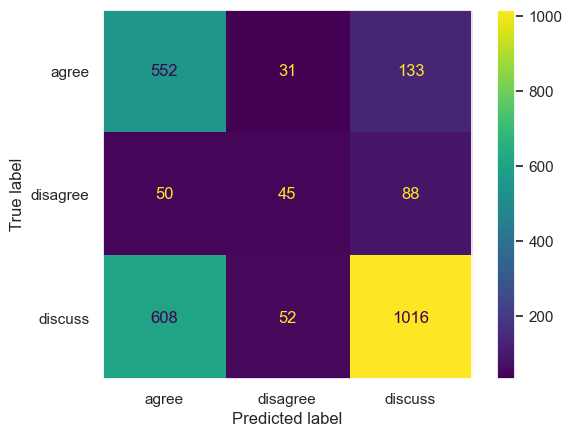

[2023-04-22 19:02:05] Classification Report:
[2023-04-22 19:02:05]               precision    recall  f1-score   support

           0       0.46      0.77      0.57       716
           1       0.35      0.25      0.29       183
           2       0.82      0.61      0.70      1676

    accuracy                           0.63      2575
   macro avg       0.54      0.54      0.52      2575
weighted avg       0.69      0.63      0.63      2575

[2023-04-22 19:02:05] Epoch Accuracy {'accuracy': 0.6264077669902912}
[2023-04-22 19:02:05] Finished validation evaluation
[2023-04-22 19:02:05] Logged to wandb
[2023-04-22 19:02:05] Starting epoch 5
[2023-04-22 19:02:05] Starting epoch training
[2023-04-22 19:02:05] Set model to train mode


  0%|          | 0/1356 [00:00<?, ?it/s]

[2023-04-22 19:02:19][5:40] Loss: 0.342
[2023-04-22 19:02:19][5:40] LR: 2.482262968764397e-05
[2023-04-22 19:02:32][5:80] Loss: 0.334
[2023-04-22 19:02:32][5:80] LR: 2.4638348843637703e-05
[2023-04-22 19:02:46][5:120] Loss: 0.334
[2023-04-22 19:02:46][5:120] LR: 2.445406799963144e-05
[2023-04-22 19:02:59][5:160] Loss: 0.334
[2023-04-22 19:02:59][5:160] LR: 2.4269787155625174e-05
[2023-04-22 19:03:12][5:200] Loss: 0.334
[2023-04-22 19:03:12][5:200] LR: 2.4085506311618906e-05
[2023-04-22 19:03:26][5:240] Loss: 0.334
[2023-04-22 19:03:26][5:240] LR: 2.3901225467612642e-05
[2023-04-22 19:03:39][5:280] Loss: 0.334
[2023-04-22 19:03:39][5:280] LR: 2.3716944623606378e-05
[2023-04-22 19:03:53][5:320] Loss: 0.334
[2023-04-22 19:03:53][5:320] LR: 2.353266377960011e-05
[2023-04-22 19:04:06][5:360] Loss: 0.334
[2023-04-22 19:04:06][5:360] LR: 2.3348382935593846e-05
[2023-04-22 19:04:20][5:400] Loss: 0.334
[2023-04-22 19:04:20][5:400] LR: 2.316410209158758e-05
[2023-04-22 19:04:33][5:440] Loss: 0.3

  0%|          | 0/322 [00:00<?, ?it/s]

[2023-04-22 19:10:15] Set model to train mode


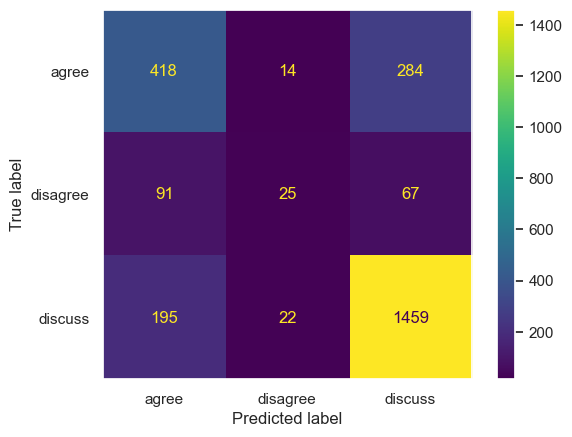

[2023-04-22 19:10:19] Classification Report:
[2023-04-22 19:10:19]               precision    recall  f1-score   support

           0       0.59      0.58      0.59       716
           1       0.41      0.14      0.20       183
           2       0.81      0.87      0.84      1676

    accuracy                           0.74      2575
   macro avg       0.60      0.53      0.54      2575
weighted avg       0.72      0.74      0.72      2575

[2023-04-22 19:10:19] Epoch Accuracy {'accuracy': 0.7386407766990292}
[2023-04-22 19:10:19] Finished validation evaluation
[2023-04-22 19:10:19] Early stopping triggered, best validation loss achieved at 3 (loss: 0.33864311531463764)
[2023-04-22 19:10:19] Loading best model (epoch 0.33864311531463764) for evaluation
[2023-04-22 19:10:19] Starting test evaluation
[2023-04-22 19:10:19] Using model to generate predictions
[2023-04-22 19:10:19] Set model to eval mode


  0%|          | 0/883 [00:00<?, ?it/s]

[2023-04-22 19:11:55] Set model to train mode


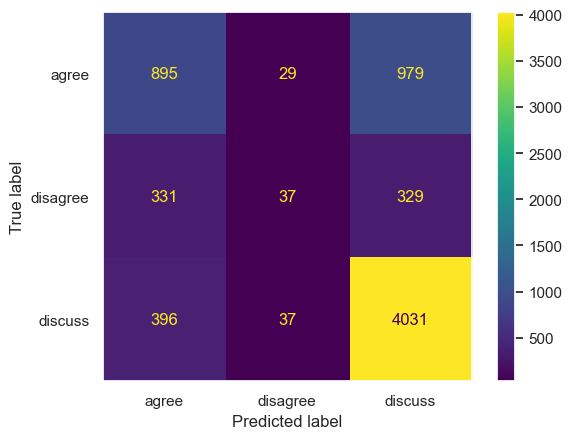

[2023-04-22 19:11:59] Classification Report:
[2023-04-22 19:11:59]               precision    recall  f1-score   support

           0       0.55      0.47      0.51      1903
           1       0.36      0.05      0.09       697
           2       0.76      0.90      0.82      4464

    accuracy                           0.70      7064
   macro avg       0.56      0.48      0.47      7064
weighted avg       0.66      0.70      0.67      7064

[2023-04-22 19:11:59] Finished test evaluation


In [138]:
model_trainer.train()

### CNN+LSTM Log Inverse

In [139]:
class TransformerCNNRNNHybrid(nn.Module):
    def __init__(self, transformer, rnn_type, stacked_layers, hidden_dim, output_dim, bidirectional, dropout_prob):
        super().__init__()
        
        self.transformer = transformer
        embedding_dim = transformer.config.to_dict()["hidden_size"]
        
        rnn_class = None
        
        if rnn_type.lower() == "lstm":
            rnn_class = nn.LSTM
        elif rnn_type.lower() == "gru":
            rnn_class = nn.GRU
        else:
            assert 1 == 0, "Invalid RNN type"
            
        self.convolutions = nn.Sequential(
            nn.Conv1d(768, 512, 5, padding=2),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Conv1d(512, 256, 5, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_prob)
            # nn.MaxPool1d(1),
        )
        
        self.rnn_type = rnn_type
        self.rnn = rnn_class(256, hidden_dim, num_layers=stacked_layers, bidirectional=bidirectional, batch_first=True, dropout=dropout_prob)
        self.classifier = nn.Linear(hidden_dim * (1 + bidirectional), output_dim)
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, ids, mask):
        embeddings = self.transformer(input_ids=ids, attention_mask=mask)[0]
        
        embeddings = embeddings.permute(0, 2, 1)
        embeddings = self.convolutions(embeddings)
        embeddings = embeddings.permute(0, 2, 1)
        
        if self.rnn_type == "gru":
            _, hidden_state = self.rnn(embeddings)
        else:
            _, (hidden_state, _) = self.rnn(embeddings)
        
        if self.rnn.bidirectional:
            hidden_state = self.dropout(torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim=1))
        else:
            hidden_state = self.dropout(hidden_state[-1,:,:])
        
        return self.classifier(hidden_state)

In [140]:
transformer = AutoModel.from_pretrained(selected_transformer_name)

model_trainer = TransformerBasedModelTrainer(
    model_class=TransformerCNNRNNHybrid,
    model_transformer=transformer,
    model_freeze_transformer=False,
    model_config={
        "rnn_type": "lstm",
        "stacked_layers": 2,
        "hidden_dim": 256,
        "output_dim": 3,
        "dropout_prob": 0.1,
        "bidirectional": True,
    },
    optimiser_class=optim.AdamW,
    optimiser_config={
        "lr": 5e-5
    },
    hf_scheduler_name="linear",
    hf_scheduler_config={
        "num_warmup_steps": 0,
        "num_training_steps": 4 * (len(train_dataset) + 1) // 8
    },
    loss_class=nn.CrossEntropyLoss,
    batch_size=8,
    max_epochs=4,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    label_names=list(labels2id.keys()),
    sampling_weight_fn="log_inverse",
    no_improvement_epochs_stop=1,
    eval_batch_size=None,
    loss_weights=None,
    device="cuda:0",
    excluded_freeze=None
)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model Initialised
TransformerCNNRNNHybrid(
  (transformer): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
        

[2023-04-22 19:32:14] Starting epoch 1
[2023-04-22 19:32:14] Starting epoch training
[2023-04-22 19:32:14] Set model to train mode


  0%|          | 0/1356 [00:00<?, ?it/s]

[2023-04-22 19:32:27][1:40] Loss: 0.888
[2023-04-22 19:32:27][1:40] LR: 4.9622189458164394e-05
[2023-04-22 19:32:41][1:80] Loss: 0.658
[2023-04-22 19:32:41][1:80] LR: 4.9253593807593074e-05
[2023-04-22 19:32:55][1:120] Loss: 0.601
[2023-04-22 19:32:55][1:120] LR: 4.888499815702175e-05
Class 1 exhausted, falling back to randomised sampling fromthe class
[2023-04-22 19:33:08][1:160] Loss: 0.894
[2023-04-22 19:33:08][1:160] LR: 4.8516402506450426e-05
[2023-04-22 19:33:22][1:200] Loss: 0.667
[2023-04-22 19:33:22][1:200] LR: 4.8147806855879105e-05
[2023-04-22 19:33:35][1:240] Loss: 0.684
[2023-04-22 19:33:35][1:240] LR: 4.777921120530778e-05
[2023-04-22 19:33:48][1:280] Loss: 0.557
[2023-04-22 19:33:48][1:280] LR: 4.741061555473646e-05
[2023-04-22 19:34:02][1:320] Loss: 0.543
[2023-04-22 19:34:02][1:320] LR: 4.7042019904165136e-05
[2023-04-22 19:34:15][1:360] Loss: 0.470
[2023-04-22 19:34:15][1:360] LR: 4.667342425359381e-05
[2023-04-22 19:34:29][1:400] Loss: 0.494
[2023-04-22 19:34:29][1:4

  0%|          | 0/322 [00:00<?, ?it/s]

[2023-04-22 19:40:27] Set model to train mode


Using the latest cached version of the module from C:\Users\yoyo1\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--f1\0ca73f6cf92ef5a268320c697f7b940d1030f8471714bffdb6856c641b818974 (last modified on Fri Mar 31 21:38:11 2023) since it couldn't be found locally at evaluate-metric--f1, or remotely on the Hugging Face Hub.


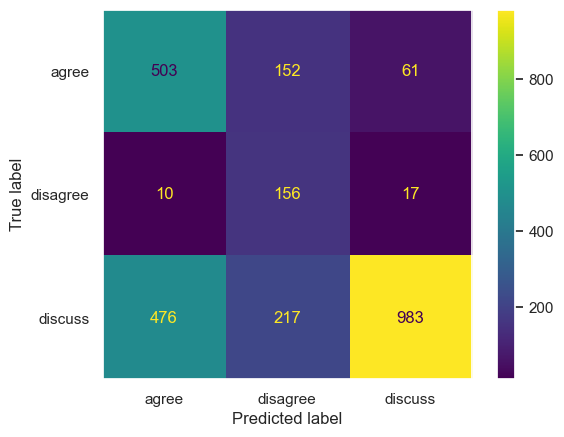

[2023-04-22 19:40:43] Classification Report:
[2023-04-22 19:40:43]               precision    recall  f1-score   support

           0       0.51      0.70      0.59       716
           1       0.30      0.85      0.44       183
           2       0.93      0.59      0.72      1676

    accuracy                           0.64      2575
   macro avg       0.58      0.71      0.58      2575
weighted avg       0.77      0.64      0.66      2575

[2023-04-22 19:40:43] Epoch Accuracy {'accuracy': 0.6376699029126214}
[2023-04-22 19:40:43] Finished validation evaluation
[2023-04-22 19:40:43] Beat best validation loss, new validation loss: 0.9833386625562396 (surpassed 1000000000.0 from epoch -1)
[2023-04-22 19:40:45] Saved best model
[2023-04-22 19:40:45] Logged to wandb
[2023-04-22 19:40:45] Starting epoch 2
[2023-04-22 19:40:45] Starting epoch training
[2023-04-22 19:40:45] Set model to train mode


  0%|          | 0/1356 [00:00<?, ?it/s]

[2023-04-22 19:40:59][2:40] Loss: 0.473
[2023-04-22 19:40:59][2:40] LR: 3.7126796903796536e-05
[2023-04-22 19:41:12][2:80] Loss: 0.374
[2023-04-22 19:41:12][2:80] LR: 3.6758201253225215e-05
[2023-04-22 19:41:25][2:120] Loss: 0.272
[2023-04-22 19:41:25][2:120] LR: 3.6389605602653895e-05
Class 1 exhausted, falling back to randomised sampling fromthe class
[2023-04-22 19:41:39][2:160] Loss: 0.296
[2023-04-22 19:41:39][2:160] LR: 3.602100995208257e-05
[2023-04-22 19:41:52][2:200] Loss: 0.159
[2023-04-22 19:41:52][2:200] LR: 3.5652414301511247e-05
[2023-04-22 19:42:05][2:240] Loss: 0.194
[2023-04-22 19:42:05][2:240] LR: 3.528381865093992e-05
[2023-04-22 19:42:18][2:280] Loss: 0.154
[2023-04-22 19:42:18][2:280] LR: 3.49152230003686e-05
[2023-04-22 19:42:32][2:320] Loss: 0.157
[2023-04-22 19:42:32][2:320] LR: 3.454662734979727e-05
[2023-04-22 19:42:45][2:360] Loss: 0.172
[2023-04-22 19:42:45][2:360] LR: 3.417803169922595e-05
[2023-04-22 19:42:58][2:400] Loss: 0.152
[2023-04-22 19:42:58][2:400

  0%|          | 0/322 [00:00<?, ?it/s]

[2023-04-22 19:48:51] Set model to train mode


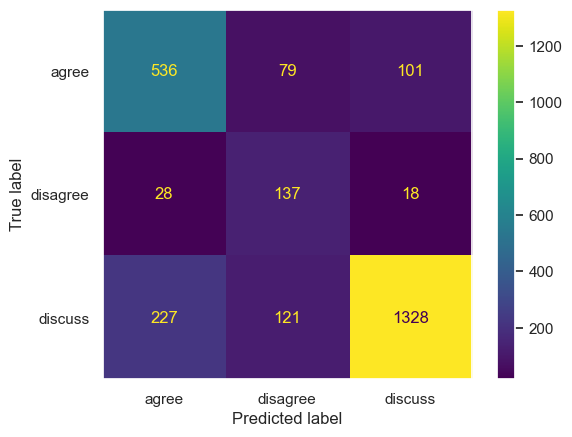

[2023-04-22 19:48:55] Classification Report:
[2023-04-22 19:48:55]               precision    recall  f1-score   support

           0       0.68      0.75      0.71       716
           1       0.41      0.75      0.53       183
           2       0.92      0.79      0.85      1676

    accuracy                           0.78      2575
   macro avg       0.67      0.76      0.70      2575
weighted avg       0.81      0.78      0.79      2575

[2023-04-22 19:48:55] Epoch Accuracy {'accuracy': 0.7770873786407767}
[2023-04-22 19:48:55] Finished validation evaluation
[2023-04-22 19:48:55] Beat best validation loss, new validation loss: 0.6827653400276018 (surpassed 0.9833386625562396 from epoch 1)
[2023-04-22 19:48:57] Saved best model
[2023-04-22 19:48:57] Logged to wandb
[2023-04-22 19:48:57] Starting epoch 3
[2023-04-22 19:48:57] Starting epoch training
[2023-04-22 19:48:57] Set model to train mode


  0%|          | 0/1356 [00:00<?, ?it/s]

[2023-04-22 19:49:11][3:40] Loss: 0.211
[2023-04-22 19:49:11][3:40] LR: 2.4631404349428677e-05
[2023-04-22 19:49:24][3:80] Loss: 0.103
[2023-04-22 19:49:24][3:80] LR: 2.4262808698857353e-05
[2023-04-22 19:49:38][3:120] Loss: 0.201
[2023-04-22 19:49:38][3:120] LR: 2.3894213048286033e-05
Class 1 exhausted, falling back to randomised sampling fromthe class
[2023-04-22 19:49:51][3:160] Loss: 0.134
[2023-04-22 19:49:51][3:160] LR: 2.352561739771471e-05
[2023-04-22 19:50:04][3:200] Loss: 0.170
[2023-04-22 19:50:04][3:200] LR: 2.3157021747143385e-05
[2023-04-22 19:50:18][3:240] Loss: 0.081
[2023-04-22 19:50:18][3:240] LR: 2.278842609657206e-05
[2023-04-22 19:50:31][3:280] Loss: 0.060
[2023-04-22 19:50:31][3:280] LR: 2.241983044600074e-05
[2023-04-22 19:50:44][3:320] Loss: 0.070
[2023-04-22 19:50:44][3:320] LR: 2.2051234795429416e-05
[2023-04-22 19:50:58][3:360] Loss: 0.096
[2023-04-22 19:50:58][3:360] LR: 2.1682639144858092e-05
[2023-04-22 19:51:11][3:400] Loss: 0.116
[2023-04-22 19:51:11][3:

  0%|          | 0/322 [00:00<?, ?it/s]

[2023-04-22 19:57:05] Set model to train mode


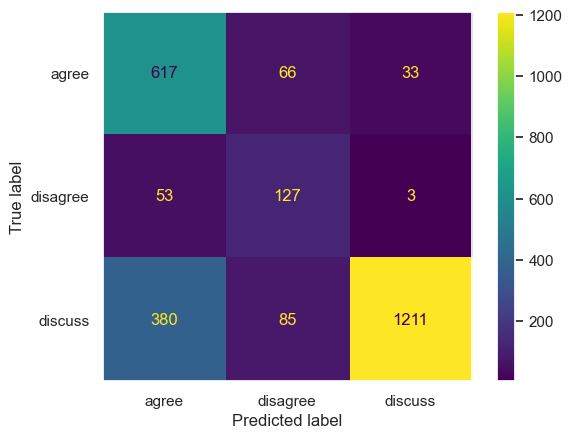

[2023-04-22 19:57:09] Classification Report:
[2023-04-22 19:57:09]               precision    recall  f1-score   support

           0       0.59      0.86      0.70       716
           1       0.46      0.69      0.55       183
           2       0.97      0.72      0.83      1676

    accuracy                           0.76      2575
   macro avg       0.67      0.76      0.69      2575
weighted avg       0.83      0.76      0.77      2575

[2023-04-22 19:57:09] Epoch Accuracy {'accuracy': 0.7592233009708738}
[2023-04-22 19:57:09] Finished validation evaluation
[2023-04-22 19:57:09] Early stopping triggered, best validation loss achieved at 2 (loss: 0.6827653400276018)
[2023-04-22 19:57:09] Loading best model (epoch 0.6827653400276018) for evaluation
[2023-04-22 19:57:09] Starting test evaluation
[2023-04-22 19:57:09] Using model to generate predictions
[2023-04-22 19:57:09] Set model to eval mode


  0%|          | 0/883 [00:00<?, ?it/s]

[2023-04-22 19:58:47] Set model to train mode


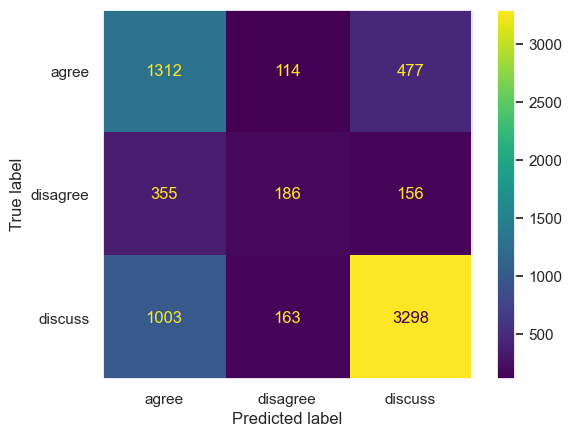

[2023-04-22 19:58:51] Classification Report:
[2023-04-22 19:58:51]               precision    recall  f1-score   support

           0       0.49      0.69      0.57      1903
           1       0.40      0.27      0.32       697
           2       0.84      0.74      0.79      4464

    accuracy                           0.68      7064
   macro avg       0.58      0.57      0.56      7064
weighted avg       0.70      0.68      0.68      7064

[2023-04-22 19:58:52] Finished test evaluation


In [141]:
model_trainer.train()

### CNN+LSTM Pooling Log Inverse

In [98]:
class TransformerCNNRNNHybrid(nn.Module):
    def __init__(self, transformer, rnn_type, stacked_layers, hidden_dim, output_dim, bidirectional, dropout_prob):
        super().__init__()
        
        self.transformer = transformer
        embedding_dim = transformer.config.to_dict()["hidden_size"]
        
        rnn_class = None
        
        if rnn_type.lower() == "lstm":
            rnn_class = nn.LSTM
        elif rnn_type.lower() == "gru":
            rnn_class = nn.GRU
        else:
            assert 1 == 0, "Invalid RNN type"
            
        self.convolutions = nn.Sequential(
            nn.Conv1d(768, 512, 5, padding=2),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Conv1d(512, 256, 5, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.MaxPool1d(4)
        )
        
        self.rnn_type = rnn_type
        self.rnn = rnn_class(256, hidden_dim, num_layers=stacked_layers, bidirectional=bidirectional, batch_first=True, dropout=dropout_prob)
        self.classifier = nn.Linear(hidden_dim * (1 + bidirectional), output_dim)
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, ids, mask):
        embeddings = self.transformer(input_ids=ids, attention_mask=mask)[0]
        
        embeddings = embeddings.permute(0, 2, 1)
        embeddings = self.convolutions(embeddings)
        embeddings = embeddings.permute(0, 2, 1)
        
        if self.rnn_type == "gru":
            _, hidden_state = self.rnn(embeddings)
        else:
            _, (hidden_state, _) = self.rnn(embeddings)
        
        if self.rnn.bidirectional:
            hidden_state = self.dropout(torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim=1))
        else:
            hidden_state = self.dropout(hidden_state[-1,:,:])
        
        return self.classifier(hidden_state)

In [99]:
transformer = AutoModel.from_pretrained(selected_transformer_name)

model_trainer = TransformerBasedModelTrainer(
    model_class=TransformerCNNRNNHybrid,
    model_transformer=transformer,
    model_freeze_transformer=False,
    model_config={
        "rnn_type": "lstm",
        "stacked_layers": 2,
        "hidden_dim": 256,
        "output_dim": 3,
        "dropout_prob": 0.1,
        "bidirectional": True,
    },
    optimiser_class=optim.AdamW,
    optimiser_config={
        "lr": 5e-5
    },
    hf_scheduler_name="linear",
    hf_scheduler_config={
        "num_warmup_steps": 0,
        "num_training_steps": 8 * (len(train_dataset) + 1) // 8
    },
    loss_class=nn.CrossEntropyLoss,
    batch_size=8,
    max_epochs=8,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    label_names=list(labels2id.keys()),
    sampling_weight_fn="log_inverse",
    no_improvement_epochs_stop=2,
    eval_batch_size=None,
    loss_weights=None,
    device="cuda:0",
    excluded_freeze=None
)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model Initialised
TransformerCNNRNNHybrid(
  (transformer): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
        

[2023-04-23 11:10:29] Starting epoch 1
[2023-04-23 11:10:29] Starting epoch training
[2023-04-23 11:10:29] Set model to train mode


  0%|          | 0/1340 [00:00<?, ?it/s]

[2023-04-23 11:10:42][1:40] Loss: 0.806
[2023-04-23 11:10:42][1:40] LR: 4.98088399850802e-05
[2023-04-23 11:10:54][1:80] Loss: 0.644
[2023-04-23 11:10:54][1:80] LR: 4.962234240954868e-05
[2023-04-23 11:11:06][1:120] Loss: 0.553
[2023-04-23 11:11:06][1:120] LR: 4.943584483401716e-05
Class 1 exhausted, falling back to randomised sampling fromthe class
[2023-04-23 11:11:17][1:160] Loss: 0.917
[2023-04-23 11:11:17][1:160] LR: 4.924934725848564e-05
[2023-04-23 11:11:29][1:200] Loss: 0.620
[2023-04-23 11:11:29][1:200] LR: 4.906284968295413e-05
[2023-04-23 11:11:41][1:240] Loss: 0.612
[2023-04-23 11:11:41][1:240] LR: 4.887635210742261e-05
[2023-04-23 11:11:52][1:280] Loss: 0.551
[2023-04-23 11:11:52][1:280] LR: 4.868985453189109e-05
[2023-04-23 11:12:04][1:320] Loss: 0.589
[2023-04-23 11:12:04][1:320] LR: 4.850335695635957e-05
[2023-04-23 11:12:16][1:360] Loss: 0.538
[2023-04-23 11:12:16][1:360] LR: 4.831685938082805e-05
[2023-04-23 11:12:27][1:400] Loss: 0.498
[2023-04-23 11:12:27][1:400] LR

  0%|          | 0/338 [00:00<?, ?it/s]

[2023-04-23 11:17:32] Set model to train mode


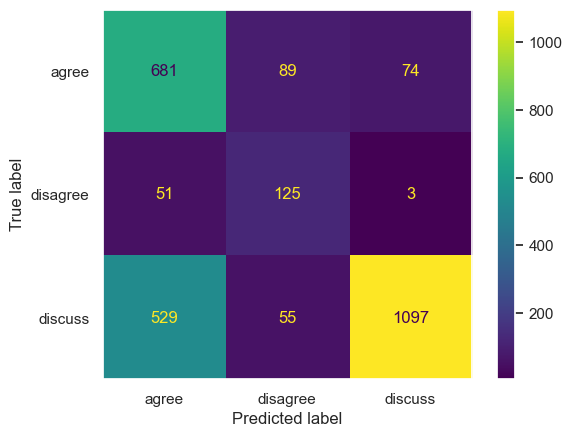

[2023-04-23 11:17:37] Classification Report:
[2023-04-23 11:17:37]               precision    recall  f1-score   support

           0       0.54      0.81      0.65       844
           1       0.46      0.70      0.56       179
           2       0.93      0.65      0.77      1681

    accuracy                           0.70      2704
   macro avg       0.65      0.72      0.66      2704
weighted avg       0.78      0.70      0.72      2704

[2023-04-23 11:17:37] Epoch Accuracy {'accuracy': 0.7037721893491125}
[2023-04-23 11:17:37] Finished validation evaluation
[2023-04-23 11:17:37] Beat best validation loss, new validation loss: 0.7793642375397788 (surpassed 1000000000.0 from epoch -1)
[2023-04-23 11:17:38] Saved best model
[2023-04-23 11:17:38] Logged to wandb
[2023-04-23 11:17:38] Starting epoch 2
[2023-04-23 11:17:38] Starting epoch training
[2023-04-23 11:17:38] Set model to train mode


  0%|          | 0/1340 [00:00<?, ?it/s]

[2023-04-23 11:17:50][2:40] Loss: 0.367
[2023-04-23 11:17:50][2:40] LR: 4.356117120477434e-05
[2023-04-23 11:18:02][2:80] Loss: 0.213
[2023-04-23 11:18:02][2:80] LR: 4.337467362924282e-05
[2023-04-23 11:18:13][2:120] Loss: 0.176
[2023-04-23 11:18:13][2:120] LR: 4.31881760537113e-05
Class 1 exhausted, falling back to randomised sampling fromthe class
[2023-04-23 11:18:25][2:160] Loss: 0.227
[2023-04-23 11:18:25][2:160] LR: 4.3001678478179784e-05
[2023-04-23 11:18:37][2:200] Loss: 0.134
[2023-04-23 11:18:37][2:200] LR: 4.2815180902648265e-05
[2023-04-23 11:18:49][2:240] Loss: 0.168
[2023-04-23 11:18:49][2:240] LR: 4.2628683327116746e-05
[2023-04-23 11:19:00][2:280] Loss: 0.209
[2023-04-23 11:19:00][2:280] LR: 4.244218575158523e-05
[2023-04-23 11:19:12][2:320] Loss: 0.220
[2023-04-23 11:19:12][2:320] LR: 4.2255688176053714e-05
[2023-04-23 11:19:24][2:360] Loss: 0.195
[2023-04-23 11:19:24][2:360] LR: 4.2069190600522195e-05
[2023-04-23 11:19:35][2:400] Loss: 0.217
[2023-04-23 11:19:35][2:40

  0%|          | 0/338 [00:00<?, ?it/s]

[2023-04-23 11:24:41] Set model to train mode


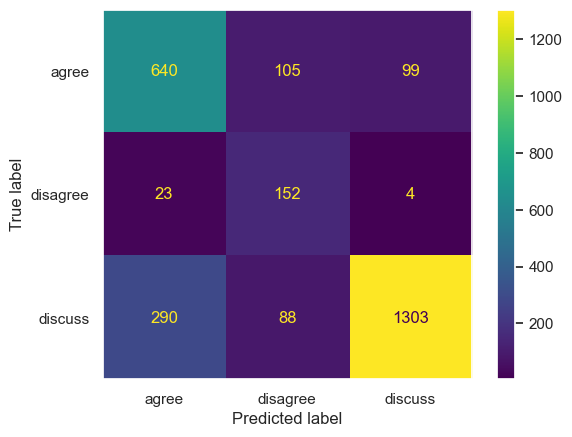

[2023-04-23 11:24:45] Classification Report:
[2023-04-23 11:24:45]               precision    recall  f1-score   support

           0       0.67      0.76      0.71       844
           1       0.44      0.85      0.58       179
           2       0.93      0.78      0.84      1681

    accuracy                           0.77      2704
   macro avg       0.68      0.79      0.71      2704
weighted avg       0.81      0.77      0.79      2704

[2023-04-23 11:24:45] Epoch Accuracy {'accuracy': 0.7747781065088757}
[2023-04-23 11:24:45] Finished validation evaluation
[2023-04-23 11:24:45] Beat best validation loss, new validation loss: 0.629751268180484 (surpassed 0.7793642375397788 from epoch 1)
[2023-04-23 11:24:46] Saved best model
[2023-04-23 11:24:46] Logged to wandb
[2023-04-23 11:24:46] Starting epoch 3
[2023-04-23 11:24:46] Starting epoch training
[2023-04-23 11:24:46] Set model to train mode


  0%|          | 0/1340 [00:00<?, ?it/s]

[2023-04-23 11:24:58][3:40] Loss: 0.156
[2023-04-23 11:24:58][3:40] LR: 3.7313502424468484e-05
[2023-04-23 11:25:10][3:80] Loss: 0.082
[2023-04-23 11:25:10][3:80] LR: 3.7127004848936965e-05
[2023-04-23 11:25:22][3:120] Loss: 0.118
[2023-04-23 11:25:22][3:120] LR: 3.694050727340545e-05
Class 1 exhausted, falling back to randomised sampling fromthe class
[2023-04-23 11:25:33][3:160] Loss: 0.216
[2023-04-23 11:25:33][3:160] LR: 3.6754009697873934e-05
[2023-04-23 11:25:45][3:200] Loss: 0.137
[2023-04-23 11:25:45][3:200] LR: 3.6567512122342415e-05
[2023-04-23 11:25:57][3:240] Loss: 0.087
[2023-04-23 11:25:57][3:240] LR: 3.6381014546810895e-05
[2023-04-23 11:26:08][3:280] Loss: 0.132
[2023-04-23 11:26:08][3:280] LR: 3.6194516971279376e-05
[2023-04-23 11:26:20][3:320] Loss: 0.083
[2023-04-23 11:26:20][3:320] LR: 3.600801939574786e-05
[2023-04-23 11:26:32][3:360] Loss: 0.094
[2023-04-23 11:26:32][3:360] LR: 3.5821521820216345e-05
[2023-04-23 11:26:45][3:400] Loss: 0.108
[2023-04-23 11:26:45][3

  0%|          | 0/338 [00:00<?, ?it/s]

[2023-04-23 11:31:52] Set model to train mode


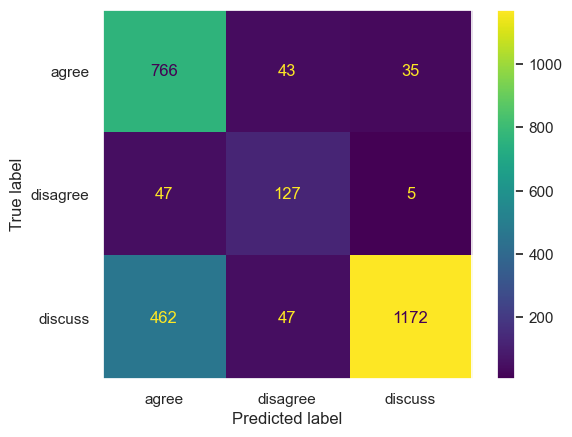

[2023-04-23 11:31:56] Classification Report:
[2023-04-23 11:31:56]               precision    recall  f1-score   support

           0       0.60      0.91      0.72       844
           1       0.59      0.71      0.64       179
           2       0.97      0.70      0.81      1681

    accuracy                           0.76      2704
   macro avg       0.72      0.77      0.72      2704
weighted avg       0.83      0.76      0.77      2704

[2023-04-23 11:31:56] Epoch Accuracy {'accuracy': 0.7636834319526628}
[2023-04-23 11:31:56] Finished validation evaluation
[2023-04-23 11:31:56] Logged to wandb
[2023-04-23 11:31:56] Starting epoch 4
[2023-04-23 11:31:56] Starting epoch training
[2023-04-23 11:31:56] Set model to train mode


  0%|          | 0/1340 [00:00<?, ?it/s]

[2023-04-23 11:32:08][4:40] Loss: 0.071
[2023-04-23 11:32:08][4:40] LR: 3.106583364416263e-05
[2023-04-23 11:32:19][4:80] Loss: 0.039
[2023-04-23 11:32:19][4:80] LR: 3.087933606863111e-05
[2023-04-23 11:32:31][4:120] Loss: 0.020
[2023-04-23 11:32:31][4:120] LR: 3.069283849309959e-05
Class 1 exhausted, falling back to randomised sampling fromthe class
[2023-04-23 11:32:43][4:160] Loss: 0.108
[2023-04-23 11:32:43][4:160] LR: 3.050634091756807e-05
[2023-04-23 11:32:54][4:200] Loss: 0.077
[2023-04-23 11:32:54][4:200] LR: 3.031984334203655e-05
[2023-04-23 11:33:06][4:240] Loss: 0.032
[2023-04-23 11:33:06][4:240] LR: 3.013334576650504e-05
[2023-04-23 11:33:18][4:280] Loss: 0.056
[2023-04-23 11:33:18][4:280] LR: 2.994684819097352e-05
[2023-04-23 11:33:29][4:320] Loss: 0.070
[2023-04-23 11:33:29][4:320] LR: 2.9760350615442e-05
[2023-04-23 11:33:41][4:360] Loss: 0.073
[2023-04-23 11:33:41][4:360] LR: 2.957385303991048e-05
[2023-04-23 11:33:53][4:400] Loss: 0.062
[2023-04-23 11:33:53][4:400] LR:

  0%|          | 0/338 [00:00<?, ?it/s]

[2023-04-23 11:38:58] Set model to train mode


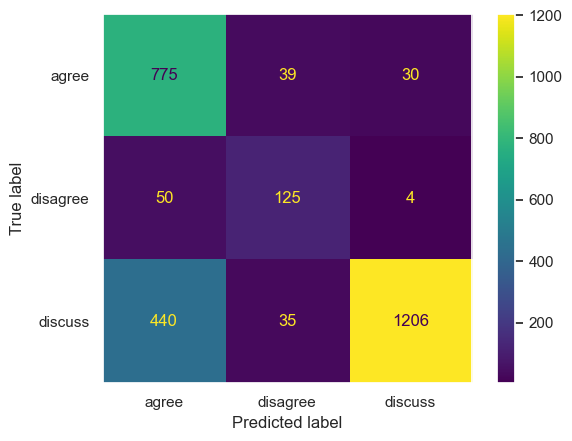

[2023-04-23 11:39:02] Classification Report:
[2023-04-23 11:39:02]               precision    recall  f1-score   support

           0       0.61      0.92      0.73       844
           1       0.63      0.70      0.66       179
           2       0.97      0.72      0.83      1681

    accuracy                           0.78      2704
   macro avg       0.74      0.78      0.74      2704
weighted avg       0.84      0.78      0.79      2704

[2023-04-23 11:39:02] Epoch Accuracy {'accuracy': 0.7788461538461539}
[2023-04-23 11:39:02] Finished validation evaluation
[2023-04-23 11:39:02] Early stopping triggered, best validation loss achieved at 2 (loss: 0.629751268180484)
[2023-04-23 11:39:02] Loading best model (epoch 0.629751268180484) for evaluation
[2023-04-23 11:39:02] Starting test evaluation
[2023-04-23 11:39:02] Using model to generate predictions
[2023-04-23 11:39:02] Set model to eval mode


  0%|          | 0/883 [00:00<?, ?it/s]

[2023-04-23 11:40:23] Set model to train mode


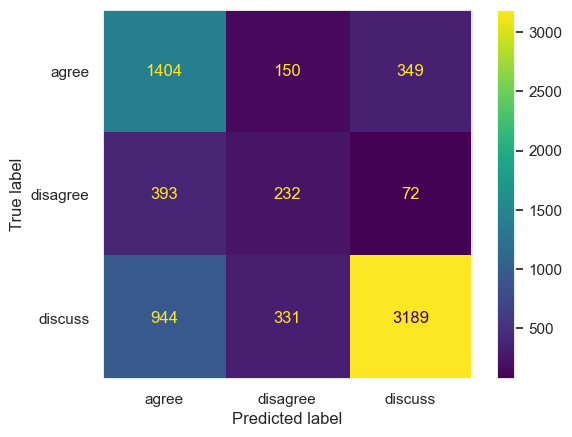

[2023-04-23 11:40:27] Classification Report:
[2023-04-23 11:40:27]               precision    recall  f1-score   support

           0       0.51      0.74      0.60      1903
           1       0.33      0.33      0.33       697
           2       0.88      0.71      0.79      4464

    accuracy                           0.68      7064
   macro avg       0.57      0.60      0.57      7064
weighted avg       0.73      0.68      0.69      7064

[2023-04-23 11:40:27] Finished test evaluation


In [100]:
model_trainer.train()

### CNN+LSTM Pooling Disagree Amplify Only

In [112]:
class TransformerCNNRNNHybrid(nn.Module):
    def __init__(self, transformer, rnn_type, stacked_layers, hidden_dim, output_dim, bidirectional, dropout_prob):
        super().__init__()
        
        self.transformer = transformer
        embedding_dim = transformer.config.to_dict()["hidden_size"]
        
        rnn_class = None
        
        if rnn_type.lower() == "lstm":
            rnn_class = nn.LSTM
        elif rnn_type.lower() == "gru":
            rnn_class = nn.GRU
        else:
            assert 1 == 0, "Invalid RNN type"
            
        self.convolutions = nn.Sequential(
            nn.Conv1d(768, 512, 5, padding=2),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Conv1d(512, 256, 5, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.MaxPool1d(4)
        )
        
        self.rnn_type = rnn_type
        self.rnn = rnn_class(256, hidden_dim, num_layers=stacked_layers, bidirectional=bidirectional, batch_first=True, dropout=dropout_prob)
        self.classifier = nn.Linear(hidden_dim * (1 + bidirectional), output_dim)
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, ids, mask):
        embeddings = self.transformer(input_ids=ids, attention_mask=mask)[0]
        
        embeddings = embeddings.permute(0, 2, 1)
        embeddings = self.convolutions(embeddings)
        embeddings = embeddings.permute(0, 2, 1)
        
        if self.rnn_type == "gru":
            _, hidden_state = self.rnn(embeddings)
        else:
            _, (hidden_state, _) = self.rnn(embeddings)
        
        if self.rnn.bidirectional:
            hidden_state = self.dropout(torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim=1))
        else:
            hidden_state = self.dropout(hidden_state[-1,:,:])
        
        return self.classifier(hidden_state)

In [117]:
transformer = AutoModel.from_pretrained(selected_transformer_name)

model_trainer = TransformerBasedModelTrainer(
    model_class=TransformerCNNRNNHybrid,
    model_transformer=transformer,
    model_freeze_transformer=False,
    model_config={
        "rnn_type": "lstm",
        "stacked_layers": 2,
        "hidden_dim": 256,
        "output_dim": 3,
        "dropout_prob": 0.1,
        "bidirectional": True,
    },
    optimiser_class=optim.AdamW,
    optimiser_config={
        "lr": 5e-5
    },
    hf_scheduler_name="linear",
    hf_scheduler_config={
        "num_warmup_steps": 0,
        "num_training_steps": 8 * (len(train_dataset) + 1) // 8
    },
    loss_class=nn.CrossEntropyLoss,
    batch_size=8,
    max_epochs=8,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    label_names=list(labels2id.keys()),
    sampling_weight_fn=[0.3, 0.4, 0.6740650937237713], #lambda x, n: x / n,
    no_improvement_epochs_stop=2,
    eval_batch_size=None,
    loss_weights=None,
    device="cuda:0",
    excluded_freeze=None
)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model Initialised
TransformerCNNRNNHybrid(
  (transformer): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
        

[2023-04-23 14:27:25] Starting epoch 1
[2023-04-23 14:27:25] Starting epoch training
[2023-04-23 14:27:25] Set model to train mode


  0%|          | 0/1340 [00:00<?, ?it/s]

[2023-04-23 14:27:38][1:40] Loss: 0.784
[2023-04-23 14:27:38][1:40] LR: 4.98088399850802e-05
[2023-04-23 14:27:50][1:80] Loss: 0.542
[2023-04-23 14:27:50][1:80] LR: 4.962234240954868e-05
[2023-04-23 14:28:01][1:120] Loss: 0.642
[2023-04-23 14:28:01][1:120] LR: 4.943584483401716e-05
[2023-04-23 14:28:13][1:160] Loss: 0.577
[2023-04-23 14:28:13][1:160] LR: 4.924934725848564e-05
[2023-04-23 14:28:25][1:200] Loss: 0.561
[2023-04-23 14:28:25][1:200] LR: 4.906284968295413e-05
[2023-04-23 14:28:37][1:240] Loss: 0.577
[2023-04-23 14:28:37][1:240] LR: 4.887635210742261e-05
Class 1 exhausted, falling back to randomised sampling fromthe class
[2023-04-23 14:28:49][1:280] Loss: 0.473
[2023-04-23 14:28:49][1:280] LR: 4.868985453189109e-05
[2023-04-23 14:29:01][1:320] Loss: 0.736
[2023-04-23 14:29:01][1:320] LR: 4.850335695635957e-05
[2023-04-23 14:29:13][1:360] Loss: 0.713
[2023-04-23 14:29:13][1:360] LR: 4.831685938082805e-05
[2023-04-23 14:29:25][1:400] Loss: 0.705
[2023-04-23 14:29:25][1:400] LR

  0%|          | 0/338 [00:00<?, ?it/s]

[2023-04-23 14:34:43] Set model to train mode


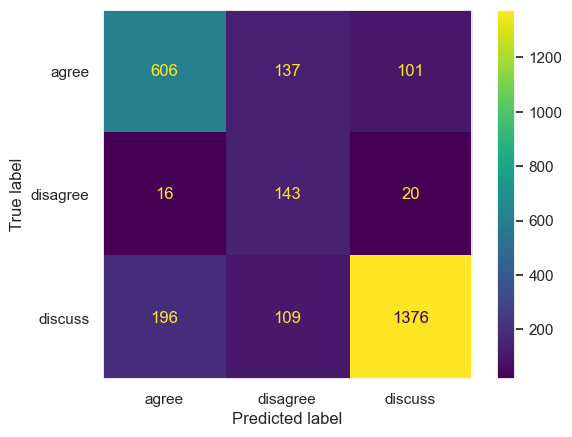

[2023-04-23 14:34:47] Classification Report:
[2023-04-23 14:34:47]               precision    recall  f1-score   support

           0       0.74      0.72      0.73       844
           1       0.37      0.80      0.50       179
           2       0.92      0.82      0.87      1681

    accuracy                           0.79      2704
   macro avg       0.68      0.78      0.70      2704
weighted avg       0.83      0.79      0.80      2704

[2023-04-23 14:34:47] Epoch Accuracy {'accuracy': 0.7858727810650887}
[2023-04-23 14:34:47] Finished validation evaluation
[2023-04-23 14:34:47] Beat best validation loss, new validation loss: 0.6124257474019021 (surpassed 1000000000.0 from epoch -1)
[2023-04-23 14:34:48] Saved best model
[2023-04-23 14:34:48] Logged to wandb
[2023-04-23 14:34:48] Starting epoch 2
[2023-04-23 14:34:48] Starting epoch training
[2023-04-23 14:34:48] Set model to train mode


  0%|          | 0/1340 [00:00<?, ?it/s]

[2023-04-23 14:35:00][2:40] Loss: 0.219
[2023-04-23 14:35:00][2:40] LR: 4.356117120477434e-05
[2023-04-23 14:35:12][2:80] Loss: 0.192
[2023-04-23 14:35:12][2:80] LR: 4.337467362924282e-05
[2023-04-23 14:35:24][2:120] Loss: 0.196
[2023-04-23 14:35:24][2:120] LR: 4.31881760537113e-05
[2023-04-23 14:35:36][2:160] Loss: 0.184
[2023-04-23 14:35:36][2:160] LR: 4.3001678478179784e-05
[2023-04-23 14:35:48][2:200] Loss: 0.189
[2023-04-23 14:35:48][2:200] LR: 4.2815180902648265e-05
[2023-04-23 14:35:59][2:240] Loss: 0.126
[2023-04-23 14:35:59][2:240] LR: 4.2628683327116746e-05
[2023-04-23 14:36:11][2:280] Loss: 0.199
[2023-04-23 14:36:11][2:280] LR: 4.244218575158523e-05
Class 1 exhausted, falling back to randomised sampling fromthe class
[2023-04-23 14:36:23][2:320] Loss: 0.219
[2023-04-23 14:36:23][2:320] LR: 4.2255688176053714e-05
[2023-04-23 14:36:34][2:360] Loss: 0.233
[2023-04-23 14:36:34][2:360] LR: 4.2069190600522195e-05
[2023-04-23 14:36:46][2:400] Loss: 0.217
[2023-04-23 14:36:46][2:40

  0%|          | 0/338 [00:00<?, ?it/s]

[2023-04-23 14:41:54] Set model to train mode


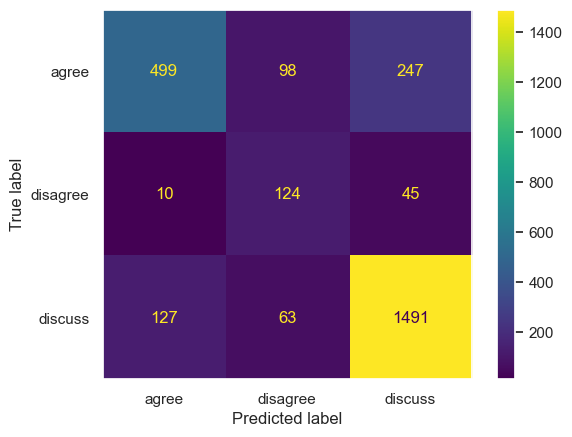

[2023-04-23 14:41:58] Classification Report:
[2023-04-23 14:41:58]               precision    recall  f1-score   support

           0       0.78      0.59      0.67       844
           1       0.44      0.69      0.53       179
           2       0.84      0.89      0.86      1681

    accuracy                           0.78      2704
   macro avg       0.69      0.72      0.69      2704
weighted avg       0.79      0.78      0.78      2704

[2023-04-23 14:41:58] Epoch Accuracy {'accuracy': 0.7818047337278107}
[2023-04-23 14:41:58] Finished validation evaluation
[2023-04-23 14:41:58] Logged to wandb
[2023-04-23 14:41:58] Starting epoch 3
[2023-04-23 14:41:58] Starting epoch training
[2023-04-23 14:41:58] Set model to train mode


  0%|          | 0/1340 [00:00<?, ?it/s]

[2023-04-23 14:42:10][3:40] Loss: 0.099
[2023-04-23 14:42:10][3:40] LR: 3.7313502424468484e-05
[2023-04-23 14:42:22][3:80] Loss: 0.087
[2023-04-23 14:42:22][3:80] LR: 3.7127004848936965e-05
[2023-04-23 14:42:34][3:120] Loss: 0.066
[2023-04-23 14:42:34][3:120] LR: 3.694050727340545e-05
[2023-04-23 14:42:46][3:160] Loss: 0.113
[2023-04-23 14:42:46][3:160] LR: 3.6754009697873934e-05
[2023-04-23 14:42:58][3:200] Loss: 0.066
[2023-04-23 14:42:58][3:200] LR: 3.6567512122342415e-05
[2023-04-23 14:43:10][3:240] Loss: 0.113
[2023-04-23 14:43:10][3:240] LR: 3.6381014546810895e-05
[2023-04-23 14:43:22][3:280] Loss: 0.078
[2023-04-23 14:43:22][3:280] LR: 3.6194516971279376e-05
Class 1 exhausted, falling back to randomised sampling fromthe class
[2023-04-23 14:43:34][3:320] Loss: 0.156
[2023-04-23 14:43:34][3:320] LR: 3.600801939574786e-05
[2023-04-23 14:43:46][3:360] Loss: 0.099
[2023-04-23 14:43:46][3:360] LR: 3.5821521820216345e-05
[2023-04-23 14:43:57][3:400] Loss: 0.108
[2023-04-23 14:43:57][3

  0%|          | 0/338 [00:00<?, ?it/s]

[2023-04-23 14:49:08] Set model to train mode


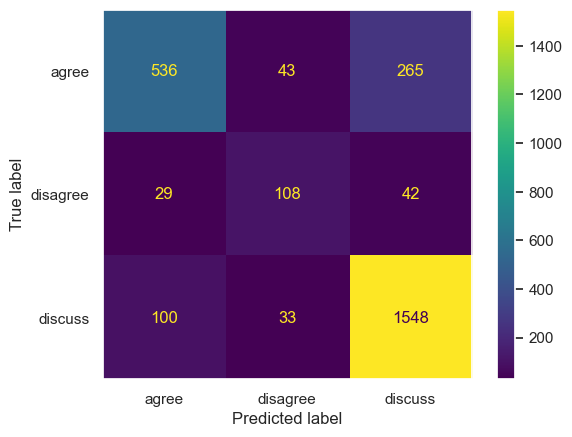

[2023-04-23 14:49:12] Classification Report:
[2023-04-23 14:49:12]               precision    recall  f1-score   support

           0       0.81      0.64      0.71       844
           1       0.59      0.60      0.60       179
           2       0.83      0.92      0.88      1681

    accuracy                           0.81      2704
   macro avg       0.74      0.72      0.73      2704
weighted avg       0.81      0.81      0.81      2704

[2023-04-23 14:49:12] Epoch Accuracy {'accuracy': 0.8106508875739645}
[2023-04-23 14:49:12] Finished validation evaluation
[2023-04-23 14:49:12] Early stopping triggered, best validation loss achieved at 1 (loss: 0.6124257474019021)
[2023-04-23 14:49:12] Loading best model (epoch 0.6124257474019021) for evaluation
[2023-04-23 14:49:12] Starting test evaluation
[2023-04-23 14:49:12] Using model to generate predictions
[2023-04-23 14:49:12] Set model to eval mode


  0%|          | 0/883 [00:00<?, ?it/s]

[2023-04-23 14:50:35] Set model to train mode


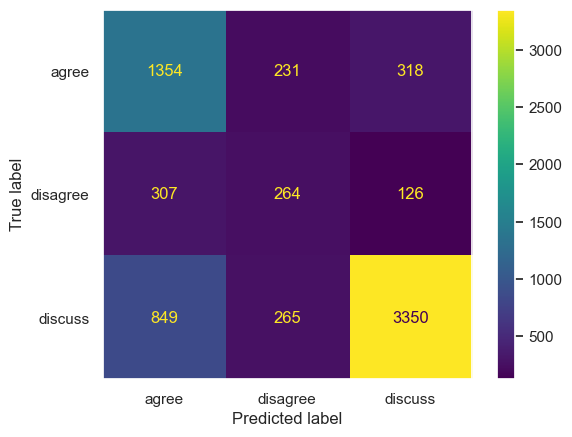

[2023-04-23 14:50:39] Classification Report:
[2023-04-23 14:50:39]               precision    recall  f1-score   support

           0       0.54      0.71      0.61      1903
           1       0.35      0.38      0.36       697
           2       0.88      0.75      0.81      4464

    accuracy                           0.70      7064
   macro avg       0.59      0.61      0.60      7064
weighted avg       0.74      0.70      0.71      7064

[2023-04-23 14:50:39] Finished test evaluation


In [118]:
model_trainer.train()

# Part 2.c: End-to-End Testing

In [65]:
best_unrelated_related_model_path = "./runs/TransformerMLPDummy/Unrelated-Related Finetuned Roberta HQ/2_model.pth"
best_stance_model_settings = "./runs/TransformerCNNRNNHybrid/CNN_LSTM Amplified Disagree HQ/info.json"
best_stance_model_path = "./runs/TransformerCNNRNNHybrid/CNN_LSTM Amplified Disagree HQ/4_model.pth"

In [66]:
from transformers import AutoModelForSequenceClassification

class TransformerMLPDummy(nn.Module):
    def __init__(self, transformer):
        super().__init__()
        self.transformer = transformer
        
    def forward(self, input_ids, mask):
        out = self.transformer(input_ids, attention_mask=mask)
        return out["logits"]

transformer_with_head = AutoModelForSequenceClassification.from_pretrained(
    selected_transformer_name,
    num_labels=2
)

unrelated_related_model = TransformerMLPDummy(transformer_with_head)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.out_proj.weig

In [67]:
success = unrelated_related_model.load_state_dict(torch.load(best_unrelated_related_model_path))
print(success)
unrelated_related_model.eval()
;

<All keys matched successfully>


''

In [68]:
class TransformerCNNRNNHybrid(nn.Module):
    def __init__(self, transformer, rnn_type, stacked_layers, hidden_dim, output_dim, bidirectional, dropout_prob):
        super().__init__()
        
        self.transformer = transformer
        embedding_dim = transformer.config.to_dict()["hidden_size"]
        
        rnn_class = None
        
        if rnn_type.lower() == "lstm":
            rnn_class = nn.LSTM
        elif rnn_type.lower() == "gru":
            rnn_class = nn.GRU
        else:
            assert 1 == 0, "Invalid RNN type"
            
        self.convolutions = nn.Sequential(
            nn.Conv1d(768, 512, 5, padding=2),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Conv1d(512, 256, 5, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.MaxPool1d(4)
        )
        
        self.rnn_type = rnn_type
        self.rnn = rnn_class(256, hidden_dim, num_layers=stacked_layers, bidirectional=bidirectional, batch_first=True, dropout=dropout_prob)
        self.classifier = nn.Linear(hidden_dim * (1 + bidirectional), output_dim)
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, ids, mask):
        embeddings = self.transformer(input_ids=ids, attention_mask=mask)[0]
        
        embeddings = embeddings.permute(0, 2, 1)
        embeddings = self.convolutions(embeddings)
        embeddings = embeddings.permute(0, 2, 1)
        
        if self.rnn_type == "gru":
            _, hidden_state = self.rnn(embeddings)
        else:
            _, (hidden_state, _) = self.rnn(embeddings)
        
        if self.rnn.bidirectional:
            hidden_state = self.dropout(torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim=1))
        else:
            hidden_state = self.dropout(hidden_state[-1,:,:])
        
        return self.classifier(hidden_state)

transformer = AutoModelForSequenceClassification.from_pretrained(
    selected_transformer_name,
    num_labels=3
)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.out_proj.weig

In [69]:
with open(best_stance_model_settings, "r") as fp:
    settings = json.load(fp)
    config = settings["model"]["model_config"]
    
transformer = AutoModel.from_pretrained(selected_transformer_name)
stance_model = TransformerCNNRNNHybrid(transformer, **config)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [70]:
success = stance_model.load_state_dict(torch.load(best_stance_model_path))
print(success)
stance_model.eval()
;

<All keys matched successfully>


''

In [72]:
transformer_test_df

Headline     Stance  \
0      Ferguson riots: Pregnant woman loses eye after...  unrelated   
1      Apple Stores to install safes to secure gold A...  unrelated   
2      Pregnant woman loses eye after police shoot be...  unrelated   
3      We just found out the #Ferguson Protester who ...  unrelated   
4      Police Chief In Charge of Paris Attacks Commit...    discuss   
...                                                  ...        ...   
25408        A Sign That Obamacare Exchanges Are Failing   disagree   
25409  Republicans call Obamacare a 'failure.' These ...      agree   
25410  CBO’s Alternate Facts Show Obamacare is Unsust...   disagree   
25411                               Why Obamacare failed   disagree   
25412  The success of the Affordable Care Act is a hu...      agree   

                                             articleBody  Related  \
0      A RESPECTED senior French police officer inves...        0   
1      A RESPECTED senior French police officer inves...        0   
2      A RESPECTED senior French police officer inves...        0   
3      A RESPECTED senior French police officer inves...        0   
4      A RESPECTED senior French police officer inves...        1   
...                                                  ...      ...   
25408  Remember how much Republicans wanted to repeal...        1   
25409  Remember how much Republicans wanted to repeal...        1   
25410  Remember how much Republicans wanted to repeal...        1   
25411  Remember how much Republicans wanted to repeal...        1   
25412  Remember how much Republicans wanted to repeal...        1   

                                      Processed Headline  \
0      Ferguson riots: Pregnant woman loses eye after...   
1      Apple Stores to install safes to secure gold A...   
2      Pregnant woman loses eye after police shoot be...   
3      We just found out the #Ferguson Protester who ...   
4      Police Chief In Charge of Paris Attacks Commit...   
...                                                  ...   
25408        A Sign That Obamacare Exchanges Are Failing   
25409  Republicans call Obamacare a 'failure.' These ...   
25410  CBO’s Alternate Facts Show Obamacare is Unsust...   
25411                               Why Obamacare failed   
25412  The success of the Affordable Care Act is a hu...   

                                          Processed Body  \
0      A RESPECTED senior French police officer inves...   
1      A RESPECTED senior French police officer inves...   
2      A RESPECTED senior French police officer inves...   
3      A RESPECTED senior French police officer inves...   
4      A RESPECTED senior French police officer inves...   
...                                                  ...   
25408  Remember how much Republicans wanted to repeal...   
25409  Remember how much Republicans wanted to repeal...   
25410  Remember how much Republicans wanted to repeal...   
25411  Remember how much Republicans wanted to repeal...   
25412  Remember how much Republicans wanted to repeal...   

                                               input_ids  \
0      [[tensor(0), tensor(597), tensor(46395), tenso...   
1      [[tensor(0), tensor(20770), tensor(19225), ten...   
2      [[tensor(0), tensor(510), tensor(4950), tensor...   
3      [[tensor(0), tensor(170), tensor(95), tensor(3...   
4      [[tensor(0), tensor(9497), tensor(1231), tenso...   
...                                                  ...   
25408  [[tensor(0), tensor(250), tensor(4313), tensor...   
25409  [[tensor(0), tensor(39044), tensor(486), tenso...   
25410  [[tensor(0), tensor(347), tensor(7997), tensor...   
25411  [[tensor(0), tensor(7608), tensor(9138), tenso...   
25412  [[tensor(0), tensor(133), tensor(1282), tensor...   

                                          attention_mask  
0      [[tensor(1), tensor(1), tensor(1), tensor(1), ...  
1      [[tensor(1), tensor(1), tensor(1), tensor(1), ...  
2      [[tensor(1), tensor

## Dataset Preparation

In [79]:
class TransformerTokenDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_masks[idx],
            "labels": self.labels[idx] 
        }

        return item
    
    def get_labels(self):
        return self.labels
    
    def __len__(self):
        return len(self.labels)

In [80]:
labels2id = {
    "unrelated": 0,
    "agree": 1,
    "disagree": 2,
    "discuss": 3
}

## Validation Dataset

In [126]:
val_df = transformer_val_df.copy(deep=True)

In [127]:
val_labels = np.array([labels2id[x] for x in val_df["Stance"].values])
val_labels_tensor = torch.LongTensor(val_labels).unsqueeze(1)
val_labels_tensor.shape

torch.Size([9630, 1])

In [128]:
val_transformer_input_ids = torch.concat(list(val_df["input_ids"].values))
val_transformer_attention_masks = torch.concat(list(val_df["attention_mask"].values))
val_dataset = TransformerTokenDataset(val_transformer_input_ids, val_transformer_attention_masks, val_labels_tensor)
batch_size = 16
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [129]:
unrelated_related_model = unrelated_related_model.to(device)
stance_model = stance_model.to(device)

y_true = val_dataset.labels
y_pred = np.empty(len(y_true))

with torch.inference_mode():
    for i, batch in enumerate(tqdm(val_dataloader)):
        upper = ((i + 1) if i + 1 < len(val_dataloader) else len(val_dataloader)) * batch_size
        
        tokens = batch["input_ids"].to(device)
        attention_masks = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device).squeeze(-1)
        
        predictions = np.empty(tokens.shape[0])
        
        # Stage One
        related_logits = unrelated_related_model(tokens, attention_masks)
        related_predictions = torch.argmax(related_logits, 1)
        
        related_indexes = related_predictions > 0
        # print(related_indexes.shape)
        predictions[~related_indexes.cpu()] = 0
        
        next_stage_tokens = tokens[related_indexes]
        next_stage_attention_masks = attention_masks[related_indexes]
        
        stance_logits = stance_model(next_stage_tokens, next_stage_attention_masks)
        stance_predictions = torch.argmax(stance_logits, 1)
        
        predictions[related_indexes.cpu()] = stance_predictions.detach().cpu().numpy() + 1
        y_pred[i * batch_size : upper] = predictions

  0%|          | 0/602 [00:00<?, ?it/s]

Accuracy {'accuracy': 0.9707165109034268}
Precision {'precision': 0.9725150857491652}
Recall {'recall': 0.9707165109034268}
F1 {'f1': 0.9712819462855486}
MCC {'matthews_correlation': 0.9318690493492546}
Kappa 0.9317767833705237

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      7056
           1       0.85      0.86      0.86       715
           2       0.69      0.94      0.80       154
           3       0.94      0.92      0.93      1705

    accuracy                           0.97      9630
   macro avg       0.87      0.93      0.90      9630
weighted avg       0.97      0.97      0.97      9630




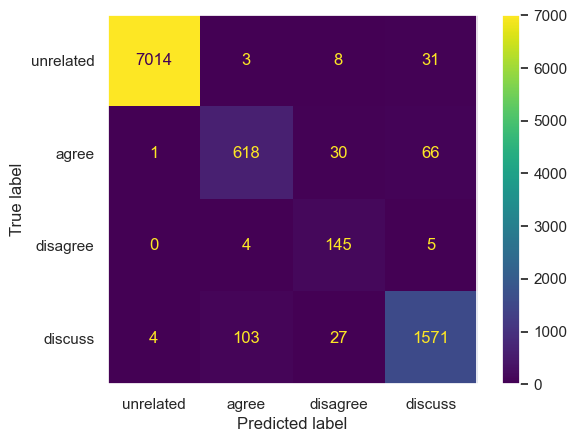

In [130]:
accuracy = evaluate.load("accuracy").compute(predictions=y_pred, references=y_true)
print("Accuracy", accuracy)

precision = evaluate.load("precision").compute(predictions=y_pred, references=y_true, average="weighted")
print("Precision", precision)

recall = evaluate.load("recall").compute(predictions=y_pred, references=y_true, average="weighted")
print("Recall", recall)

f1 = evaluate.load("f1").compute(predictions=y_pred, references=y_true, average="weighted")
print("F1", f1)

mcc = evaluate.load("matthews_correlation").compute(predictions=y_pred, references=y_true)
print("MCC", mcc)

kappa = cohen_kappa_score(y_true, y_pred)
print("Kappa", kappa)

print()
print(classification_report(y_true, y_pred))
print()

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=list(labels2id.keys()))
plt.grid(False)

## Test Dataset

In [131]:
test_df = transformer_test_df.copy(deep=True)

In [132]:
test_labels = np.array([labels2id[x] for x in test_df["Stance"].values])
test_labels_tensor = torch.LongTensor(test_labels).unsqueeze(1)
test_labels_tensor.shape

torch.Size([25413, 1])

In [133]:
test_transformer_input_ids = torch.concat(list(test_df["input_ids"].values))
test_transformer_attention_masks = torch.concat(list(test_df["attention_mask"].values))
test_dataset = TransformerTokenDataset(test_transformer_input_ids, test_transformer_attention_masks, test_labels_tensor)
batch_size = 16
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [134]:
unrelated_related_model = unrelated_related_model.to(device)
stance_model = stance_model.to(device)

y_true = test_dataset.labels
y_pred = np.empty(len(y_true))

with torch.inference_mode():
    for i, batch in enumerate(tqdm(test_dataloader)):
        upper = ((i + 1) if i + 1 < len(test_dataloader) else len(test_dataloader)) * batch_size
        
        tokens = batch["input_ids"].to(device)
        attention_masks = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device).squeeze(-1)
        
        predictions = np.empty(tokens.shape[0])
        
        # Stage One
        related_logits = unrelated_related_model(tokens, attention_masks)
        related_predictions = torch.argmax(related_logits, 1)
        
        related_indexes = related_predictions > 0
        # print(related_indexes.shape)
        predictions[~related_indexes.cpu()] = 0
        
        next_stage_tokens = tokens[related_indexes]
        next_stage_attention_masks = attention_masks[related_indexes]
        
        stance_logits = stance_model(next_stage_tokens, next_stage_attention_masks)
        stance_predictions = torch.argmax(stance_logits, 1)
        
        predictions[related_indexes.cpu()] = stance_predictions.detach().cpu().numpy() + 1
        y_pred[i * batch_size : upper] = predictions

  0%|          | 0/1589 [00:00<?, ?it/s]

Accuracy {'accuracy': 0.9128005351591705}
Precision {'precision': 0.9127542478238589}
Recall {'recall': 0.9128005351591705}
F1 {'f1': 0.911547403600336}
MCC {'matthews_correlation': 0.800924197140185}
Kappa 0.8002471931411392

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     18349
           1       0.57      0.69      0.63      1903
           2       0.51      0.34      0.41       697
           3       0.85      0.77      0.81      4464

    accuracy                           0.91     25413
   macro avg       0.73      0.70      0.71     25413
weighted avg       0.91      0.91      0.91     25413




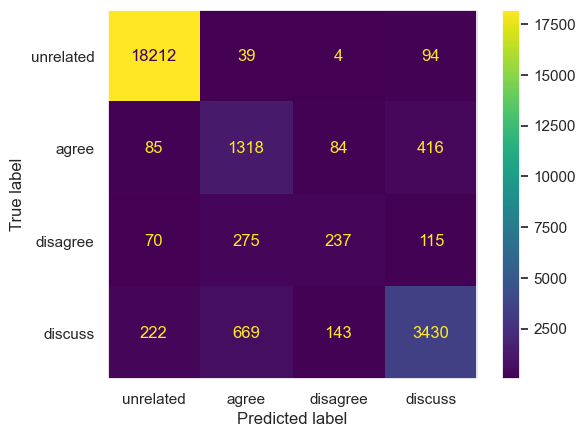

In [135]:
accuracy = evaluate.load("accuracy").compute(predictions=y_pred, references=y_true)
print("Accuracy", accuracy)

precision = evaluate.load("precision").compute(predictions=y_pred, references=y_true, average="weighted")
print("Precision", precision)

recall = evaluate.load("recall").compute(predictions=y_pred, references=y_true, average="weighted")
print("Recall", recall)

f1 = evaluate.load("f1").compute(predictions=y_pred, references=y_true, average="weighted")
print("F1", f1)

mcc = evaluate.load("matthews_correlation").compute(predictions=y_pred, references=y_true)
print("MCC", mcc)

kappa = cohen_kappa_score(y_true, y_pred)
print("Kappa", kappa)

print()
print(classification_report(y_true, y_pred))
print()

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=list(labels2id.keys()))
plt.grid(False)